## Vanilla Vision Transformer From Scratch

In [1]:
import math
import time
import numpy as np
import copy

from utils import dataset
from models import VanillaVisionTransformer
from models import transformer

import matplotlib.pyplot as plt
import matplotlib

# Pytorch packages
import torch
import torch.optim as optim
import torch.nn as nn

# torchvision
import torchvision
from torchvision import transforms

# Tqdm progress bar
from tqdm import tqdm_notebook

# obtain reproducible results in PyTorch
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)

In [2]:
# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)

You are using device: cuda


In [3]:
LEARNING_RATE = 0.000001
MOMENTUM = 0.5
WEIGHT_DECAY_REGULARIZATION_TERM = 0.002
NUM_EPOCHS = 10
BATCH_SIZE = 1

PATCH_SIZE = 32
HIDDEN_DIM = 512
EMBED_DIM = 1000 # aka mlp_dim
NUM_CHANNELS = 3
NUM_HEADS = 8
NUM_LAYERS = 6
DROPOUT = 0.2

# converts image into patches. patch_size is the size of each patch
def img_to_patches(x, patch_size, flatten_channels=True):
    B, C, H, W = x.shape
    x = x.reshape(B, C, H//patch_size, patch_size, W//patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5) # [B, H', W', C, p_H, p_W]
    x = x.flatten(1,2)              # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2,4)          # [B, H'*W', C*p_H*p_W]
    return x

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n

        self.avg = self.sum / self.count

def train(epoch, data_loader, model, optimizer, criterion, scaler=None):
    iter_time = AverageMeter()
    losses = AverageMeter()

    for idx, (data, target) in enumerate(data_loader):
        start = time.time()
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()

        with torch.autocast("cuda"): #Automatic Mixed precision
            data = img_to_patches(data, patch_size = PATCH_SIZE, flatten_channels=True)
            out = model(data).reshape(target.shape)
#             loss = torch.sqrt(criterion(out, target))
            loss = criterion(out, target)
    
#         print("DATA TYPES")
#         print(out.dtype)
#         print(target.dtype)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

        for param in model.parameters():
            param.grad = None
        scaler.scale(loss).backward()
        scaler.step(optimizer)

        scaler.update()
        losses.update(loss, out.shape[0])

        iter_time.update(time.time() - start)
        if idx % 10 == 0:
            print(('Epoch: [{0}][{1}/{2}]\t'
                   'Time {iter_time.val:.3f} ({iter_time.avg:.3f})\t'
                   'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  .format(epoch, idx, len(data_loader), iter_time=iter_time, loss=losses)))
    
    return losses.avg

def validate(epoch, validation_loader, model, criterion):
    iter_time = AverageMeter()
    losses = AverageMeter()

    for idx, (data, target) in enumerate(validation_loader):
        start = time.time()

        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        target = target.to(torch.float16)

        out = None
        loss = None
        data = img_to_patches(data, patch_size = PATCH_SIZE, flatten_channels=True)

        with torch.no_grad():
            out = model(data)
#             loss = torch.sqrt(criterion(out, target))
            loss = criterion(out, target)


        losses.update(loss, out.shape[0])

        iter_time.update(time.time() - start)
        if idx % 10 == 0:
            print(('Epoch: [{0}][{1}/{2}]\t'
                   'Time {iter_time.val:.3f} ({iter_time.avg:.3f})\t')
                  .format(epoch, idx, len(validation_loader), iter_time=iter_time, loss=losses))

    print("* Average Loss @1: {loss.avg:.4f}".format(loss=losses))
    return losses.avg

def test(testing_loader, model, criterion):
    iter_time = AverageMeter()
    losses = AverageMeter()

    # Get the progress bar for later modification
    progress_bar = tqdm_notebook(testing_loader, ascii=True)

    for idx, (data, target) in enumerate(progress_bar):
        start = time.time()

        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()

        out = None
        loss = None

        with torch.no_grad():
            out = model(data)
            # MSE loss
            loss = criterion(out, target)

        losses.update(loss, out.shape[0])

        iter_time.update(time.time() - start)

        progress_bar.set_description_str(f"Batch: {idx+1}, Loss: {loss.item():.4f}")

    print("* Average Loss @1: {loss.avg:.4f}".format(loss=losses))
#   Return RMSE loss
    return losses.avg ** 0.5 

def RMSELoss(yhat, y, eps=1e-6):
    return torch.sqrt(torch.mean((yhat-y)**2) + eps)

def plots(losses, lr=LEARNING_RATE, reg=WEIGHT_DECAY_REGULARIZATION_TERM, batch=BATCH_SIZE): #, momentum=MOMENTUM):
    fig1, ax1 = plt.subplots(figsize=(8, 10))
    ax1.plot(losses[0], label='Training Losses')
    ax1.plot(losses[1], label='Validation Losses')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('MSE Loss')
    ax1.set_title(f'ViT Loss Curve; LR={lr}; Reg_Term={reg} Batch={batch}')
    ax1.legend(loc="best")
    plt.grid()
    plt.savefig('vanilla_vit_loss_2.png')
    plt.show()

def vit_plots(losses, lr=LEARNING_RATE, reg=WEIGHT_DECAY_REGULARIZATION_TERM, batch=BATCH_SIZE): #, momentum=MOMENTUM):
    fig1, ax1 = plt.subplots(figsize=(8, 10))
    ax1.plot(losses[0], label='Vanilla Training Losses')
    ax1.plot(losses[1], label='Prebuilt Training Losses')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('MSE Loss')
    ax1.set_title(f'Vanilla ViT vs Prebuilt ViT; LR={lr}; Reg_Term={reg} Batch={batch}')
    ax1.legend(loc="best")
    plt.grid()
    plt.savefig('comp_train_1.png')
    plt.show()
    
    fig2, ax2 = plt.subplots(figsize=(8,10))
    ax2.plot(losses[2], label='Vanilla Validation Losses')
    ax2.plot(losses[3], label='Prebuilt Validation Losses')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('MSE Loss')
    ax2.set_title(f'Vanilla ViT vs Prebuilt ViT; LR={lr}; Reg_Term={reg} Batch={batch}')
    ax2.legend(loc="best")
    plt.grid()
    plt.savefig('comp_val_1.png')
    plt.show()

Epoch: [0][0/27046]	Time 0.145 (0.145)	Loss 0.0055 (0.0055)	
Epoch: [0][10/27046]	Time 0.035 (0.038)	Loss 0.0810 (0.2591)	
Epoch: [0][20/27046]	Time 0.035 (0.036)	Loss 0.5479 (0.1872)	
Epoch: [0][30/27046]	Time 0.036 (0.035)	Loss 0.0778 (0.1678)	
Epoch: [0][40/27046]	Time 0.034 (0.035)	Loss 0.0036 (0.1865)	
Epoch: [0][50/27046]	Time 0.035 (0.035)	Loss 0.0028 (0.1543)	
Epoch: [0][60/27046]	Time 0.036 (0.034)	Loss 0.3171 (0.1570)	
Epoch: [0][70/27046]	Time 0.029 (0.034)	Loss 3.1633 (0.2061)	
Epoch: [0][80/27046]	Time 0.035 (0.034)	Loss 0.0029 (0.2033)	
Epoch: [0][90/27046]	Time 0.034 (0.034)	Loss 0.0357 (0.1955)	
Epoch: [0][100/27046]	Time 0.035 (0.034)	Loss 0.0506 (0.1983)	
Epoch: [0][110/27046]	Time 0.035 (0.034)	Loss 0.0076 (0.1907)	
Epoch: [0][120/27046]	Time 0.035 (0.034)	Loss 0.2518 (0.1883)	
Epoch: [0][130/27046]	Time 0.038 (0.034)	Loss 0.1766 (0.1900)	
Epoch: [0][140/27046]	Time 0.037 (0.034)	Loss 0.1209 (0.2028)	
Epoch: [0][150/27046]	Time 0.035 (0.034)	Loss 0.0520 (0.2154)	
Epo

Epoch: [0][1300/27046]	Time 0.036 (0.034)	Loss 0.0899 (0.1703)	
Epoch: [0][1310/27046]	Time 0.035 (0.034)	Loss 0.0000 (0.1700)	
Epoch: [0][1320/27046]	Time 0.035 (0.034)	Loss 0.0152 (0.1698)	
Epoch: [0][1330/27046]	Time 0.036 (0.034)	Loss 0.1900 (0.1688)	
Epoch: [0][1340/27046]	Time 0.036 (0.034)	Loss 0.0653 (0.1682)	
Epoch: [0][1350/27046]	Time 0.035 (0.034)	Loss 0.0001 (0.1672)	
Epoch: [0][1360/27046]	Time 0.036 (0.034)	Loss 0.3241 (0.1672)	
Epoch: [0][1370/27046]	Time 0.036 (0.034)	Loss 0.0631 (0.1665)	
Epoch: [0][1380/27046]	Time 0.035 (0.034)	Loss 0.0321 (0.1660)	
Epoch: [0][1390/27046]	Time 0.035 (0.034)	Loss 0.0099 (0.1653)	
Epoch: [0][1400/27046]	Time 0.037 (0.034)	Loss 0.0246 (0.1648)	
Epoch: [0][1410/27046]	Time 0.035 (0.034)	Loss 0.0318 (0.1648)	
Epoch: [0][1420/27046]	Time 0.035 (0.034)	Loss 0.0846 (0.1653)	
Epoch: [0][1430/27046]	Time 0.036 (0.034)	Loss 0.0580 (0.1660)	
Epoch: [0][1440/27046]	Time 0.034 (0.034)	Loss 0.1845 (0.1664)	
Epoch: [0][1450/27046]	Time 0.035 (0.034

Epoch: [0][2590/27046]	Time 0.035 (0.034)	Loss 0.0309 (0.1531)	
Epoch: [0][2600/27046]	Time 0.036 (0.034)	Loss 0.0046 (0.1529)	
Epoch: [0][2610/27046]	Time 0.036 (0.034)	Loss 0.0058 (0.1526)	
Epoch: [0][2620/27046]	Time 0.037 (0.034)	Loss 0.0776 (0.1524)	
Epoch: [0][2630/27046]	Time 0.036 (0.034)	Loss 0.0001 (0.1520)	
Epoch: [0][2640/27046]	Time 0.036 (0.034)	Loss 0.1068 (0.1520)	
Epoch: [0][2650/27046]	Time 0.036 (0.034)	Loss 0.1202 (0.1525)	
Epoch: [0][2660/27046]	Time 0.036 (0.034)	Loss 0.0074 (0.1523)	
Epoch: [0][2670/27046]	Time 0.036 (0.034)	Loss 0.0109 (0.1524)	
Epoch: [0][2680/27046]	Time 0.035 (0.034)	Loss 0.0593 (0.1520)	
Epoch: [0][2690/27046]	Time 0.036 (0.034)	Loss 0.5072 (0.1520)	
Epoch: [0][2700/27046]	Time 0.035 (0.034)	Loss 0.1838 (0.1517)	
Epoch: [0][2710/27046]	Time 0.035 (0.034)	Loss 0.0002 (0.1516)	
Epoch: [0][2720/27046]	Time 0.037 (0.034)	Loss 0.0043 (0.1525)	
Epoch: [0][2730/27046]	Time 0.036 (0.034)	Loss 0.0112 (0.1523)	
Epoch: [0][2740/27046]	Time 0.035 (0.034

Epoch: [0][3880/27046]	Time 0.037 (0.034)	Loss 0.0557 (0.1418)	
Epoch: [0][3890/27046]	Time 0.035 (0.034)	Loss 0.0583 (0.1427)	
Epoch: [0][3900/27046]	Time 0.036 (0.034)	Loss 0.0141 (0.1426)	
Epoch: [0][3910/27046]	Time 0.036 (0.034)	Loss 0.0251 (0.1424)	
Epoch: [0][3920/27046]	Time 0.036 (0.034)	Loss 0.0001 (0.1425)	
Epoch: [0][3930/27046]	Time 0.035 (0.034)	Loss 0.0057 (0.1422)	
Epoch: [0][3940/27046]	Time 0.035 (0.034)	Loss 0.0229 (0.1420)	
Epoch: [0][3950/27046]	Time 0.036 (0.034)	Loss 0.0005 (0.1419)	
Epoch: [0][3960/27046]	Time 0.036 (0.034)	Loss 0.0268 (0.1419)	
Epoch: [0][3970/27046]	Time 0.035 (0.034)	Loss 0.1302 (0.1417)	
Epoch: [0][3980/27046]	Time 0.036 (0.034)	Loss 0.3144 (0.1416)	
Epoch: [0][3990/27046]	Time 0.036 (0.034)	Loss 0.0366 (0.1416)	
Epoch: [0][4000/27046]	Time 0.035 (0.034)	Loss 0.0480 (0.1414)	
Epoch: [0][4010/27046]	Time 0.035 (0.034)	Loss 0.0007 (0.1411)	
Epoch: [0][4020/27046]	Time 0.037 (0.034)	Loss 0.0210 (0.1410)	
Epoch: [0][4030/27046]	Time 0.036 (0.034

Epoch: [0][5170/27046]	Time 0.035 (0.034)	Loss 0.2451 (0.1345)	
Epoch: [0][5180/27046]	Time 0.037 (0.034)	Loss 0.0001 (0.1344)	
Epoch: [0][5190/27046]	Time 0.035 (0.034)	Loss 0.0097 (0.1343)	
Epoch: [0][5200/27046]	Time 0.036 (0.034)	Loss 0.1266 (0.1342)	
Epoch: [0][5210/27046]	Time 0.036 (0.034)	Loss 0.0352 (0.1340)	
Epoch: [0][5220/27046]	Time 0.036 (0.034)	Loss 0.0122 (0.1339)	
Epoch: [0][5230/27046]	Time 0.034 (0.034)	Loss 0.0032 (0.1337)	
Epoch: [0][5240/27046]	Time 0.036 (0.034)	Loss 0.0264 (0.1335)	
Epoch: [0][5250/27046]	Time 0.036 (0.034)	Loss 0.0540 (0.1335)	
Epoch: [0][5260/27046]	Time 0.036 (0.034)	Loss 0.2602 (0.1334)	
Epoch: [0][5270/27046]	Time 0.035 (0.034)	Loss 0.0984 (0.1333)	
Epoch: [0][5280/27046]	Time 0.036 (0.034)	Loss 0.0279 (0.1333)	
Epoch: [0][5290/27046]	Time 0.036 (0.034)	Loss 0.0628 (0.1334)	
Epoch: [0][5300/27046]	Time 0.035 (0.034)	Loss 0.0003 (0.1332)	
Epoch: [0][5310/27046]	Time 0.036 (0.034)	Loss 0.2090 (0.1331)	
Epoch: [0][5320/27046]	Time 0.037 (0.034

Epoch: [0][6460/27046]	Time 0.035 (0.034)	Loss 0.0161 (0.1262)	
Epoch: [0][6470/27046]	Time 0.036 (0.034)	Loss 0.0077 (0.1260)	
Epoch: [0][6480/27046]	Time 0.035 (0.034)	Loss 0.0748 (0.1260)	
Epoch: [0][6490/27046]	Time 0.035 (0.034)	Loss 0.0357 (0.1259)	
Epoch: [0][6500/27046]	Time 0.035 (0.034)	Loss 0.3686 (0.1259)	
Epoch: [0][6510/27046]	Time 0.036 (0.034)	Loss 0.1137 (0.1257)	
Epoch: [0][6520/27046]	Time 0.034 (0.034)	Loss 0.0774 (0.1257)	
Epoch: [0][6530/27046]	Time 0.036 (0.034)	Loss 0.0805 (0.1256)	
Epoch: [0][6540/27046]	Time 0.035 (0.034)	Loss 0.0223 (0.1258)	
Epoch: [0][6550/27046]	Time 0.035 (0.034)	Loss 0.0743 (0.1257)	
Epoch: [0][6560/27046]	Time 0.034 (0.034)	Loss 0.0051 (0.1256)	
Epoch: [0][6570/27046]	Time 0.035 (0.034)	Loss 0.0000 (0.1255)	
Epoch: [0][6580/27046]	Time 0.035 (0.034)	Loss 0.0045 (0.1253)	
Epoch: [0][6590/27046]	Time 0.035 (0.034)	Loss 0.0156 (0.1252)	
Epoch: [0][6600/27046]	Time 0.035 (0.034)	Loss 0.3264 (0.1251)	
Epoch: [0][6610/27046]	Time 0.036 (0.034

Epoch: [0][7750/27046]	Time 0.036 (0.034)	Loss 0.0376 (0.1233)	
Epoch: [0][7760/27046]	Time 0.036 (0.034)	Loss 0.0002 (0.1232)	
Epoch: [0][7770/27046]	Time 0.035 (0.034)	Loss 0.0666 (0.1233)	
Epoch: [0][7780/27046]	Time 0.035 (0.034)	Loss 0.0066 (0.1232)	
Epoch: [0][7790/27046]	Time 0.034 (0.034)	Loss 0.0000 (0.1231)	
Epoch: [0][7800/27046]	Time 0.036 (0.034)	Loss 0.2764 (0.1231)	
Epoch: [0][7810/27046]	Time 0.035 (0.034)	Loss 0.0079 (0.1230)	
Epoch: [0][7820/27046]	Time 0.035 (0.034)	Loss 0.0020 (0.1229)	
Epoch: [0][7830/27046]	Time 0.036 (0.034)	Loss 0.0489 (0.1229)	
Epoch: [0][7840/27046]	Time 0.035 (0.034)	Loss 0.0095 (0.1229)	
Epoch: [0][7850/27046]	Time 0.035 (0.034)	Loss 0.0144 (0.1228)	
Epoch: [0][7860/27046]	Time 0.035 (0.034)	Loss 0.0004 (0.1226)	
Epoch: [0][7870/27046]	Time 0.035 (0.034)	Loss 0.0387 (0.1225)	
Epoch: [0][7880/27046]	Time 0.035 (0.034)	Loss 0.0150 (0.1225)	
Epoch: [0][7890/27046]	Time 0.034 (0.034)	Loss 0.2511 (0.1225)	
Epoch: [0][7900/27046]	Time 0.037 (0.034

Epoch: [0][9040/27046]	Time 0.035 (0.034)	Loss 0.0196 (0.1172)	
Epoch: [0][9050/27046]	Time 0.036 (0.034)	Loss 0.0298 (0.1171)	
Epoch: [0][9060/27046]	Time 0.034 (0.034)	Loss 0.0034 (0.1171)	
Epoch: [0][9070/27046]	Time 0.034 (0.034)	Loss 0.0746 (0.1169)	
Epoch: [0][9080/27046]	Time 0.035 (0.034)	Loss 0.0010 (0.1170)	
Epoch: [0][9090/27046]	Time 0.036 (0.034)	Loss 0.0145 (0.1169)	
Epoch: [0][9100/27046]	Time 0.036 (0.034)	Loss 0.0029 (0.1168)	
Epoch: [0][9110/27046]	Time 0.034 (0.034)	Loss 0.0096 (0.1168)	
Epoch: [0][9120/27046]	Time 0.034 (0.034)	Loss 0.2003 (0.1167)	
Epoch: [0][9130/27046]	Time 0.034 (0.034)	Loss 0.0304 (0.1166)	
Epoch: [0][9140/27046]	Time 0.034 (0.034)	Loss 0.0109 (0.1168)	
Epoch: [0][9150/27046]	Time 0.035 (0.034)	Loss 0.0431 (0.1167)	
Epoch: [0][9160/27046]	Time 0.037 (0.034)	Loss 0.0719 (0.1167)	
Epoch: [0][9170/27046]	Time 0.037 (0.034)	Loss 0.0005 (0.1168)	
Epoch: [0][9180/27046]	Time 0.036 (0.034)	Loss 0.0773 (0.1167)	
Epoch: [0][9190/27046]	Time 0.038 (0.034

Epoch: [0][10320/27046]	Time 0.036 (0.034)	Loss 0.0023 (0.1167)	
Epoch: [0][10330/27046]	Time 0.038 (0.034)	Loss 0.0082 (0.1166)	
Epoch: [0][10340/27046]	Time 0.034 (0.034)	Loss 0.0123 (0.1166)	
Epoch: [0][10350/27046]	Time 0.036 (0.034)	Loss 0.1323 (0.1165)	
Epoch: [0][10360/27046]	Time 0.035 (0.034)	Loss 0.0594 (0.1164)	
Epoch: [0][10370/27046]	Time 0.034 (0.034)	Loss 0.0299 (0.1164)	
Epoch: [0][10380/27046]	Time 0.035 (0.034)	Loss 0.0014 (0.1163)	
Epoch: [0][10390/27046]	Time 0.036 (0.034)	Loss 0.1445 (0.1162)	
Epoch: [0][10400/27046]	Time 0.034 (0.034)	Loss 0.0009 (0.1162)	
Epoch: [0][10410/27046]	Time 0.035 (0.034)	Loss 0.0638 (0.1161)	
Epoch: [0][10420/27046]	Time 0.036 (0.034)	Loss 0.1255 (0.1160)	
Epoch: [0][10430/27046]	Time 0.035 (0.034)	Loss 2.0028 (0.1163)	
Epoch: [0][10440/27046]	Time 0.035 (0.034)	Loss 0.0160 (0.1162)	
Epoch: [0][10450/27046]	Time 0.035 (0.034)	Loss 0.0734 (0.1162)	
Epoch: [0][10460/27046]	Time 0.036 (0.034)	Loss 0.0237 (0.1161)	
Epoch: [0][10470/27046]	T

Epoch: [0][11590/27046]	Time 0.034 (0.034)	Loss 0.4777 (0.1139)	
Epoch: [0][11600/27046]	Time 0.035 (0.034)	Loss 0.0002 (0.1139)	
Epoch: [0][11610/27046]	Time 0.036 (0.034)	Loss 0.0336 (0.1138)	
Epoch: [0][11620/27046]	Time 0.035 (0.034)	Loss 0.0002 (0.1137)	
Epoch: [0][11630/27046]	Time 0.035 (0.034)	Loss 0.4011 (0.1137)	
Epoch: [0][11640/27046]	Time 0.038 (0.034)	Loss 0.0308 (0.1136)	
Epoch: [0][11650/27046]	Time 0.035 (0.034)	Loss 0.0002 (0.1136)	
Epoch: [0][11660/27046]	Time 0.035 (0.034)	Loss 0.0003 (0.1135)	
Epoch: [0][11670/27046]	Time 0.035 (0.034)	Loss 0.0589 (0.1135)	
Epoch: [0][11680/27046]	Time 0.036 (0.034)	Loss 0.0921 (0.1135)	
Epoch: [0][11690/27046]	Time 0.034 (0.034)	Loss 0.1064 (0.1134)	
Epoch: [0][11700/27046]	Time 0.035 (0.034)	Loss 0.0017 (0.1134)	
Epoch: [0][11710/27046]	Time 0.036 (0.034)	Loss 0.0642 (0.1136)	
Epoch: [0][11720/27046]	Time 0.035 (0.034)	Loss 0.0010 (0.1135)	
Epoch: [0][11730/27046]	Time 0.035 (0.034)	Loss 0.0417 (0.1135)	
Epoch: [0][11740/27046]	T

Epoch: [0][12860/27046]	Time 0.036 (0.034)	Loss 0.0175 (0.1106)	
Epoch: [0][12870/27046]	Time 0.035 (0.034)	Loss 1.1699 (0.1106)	
Epoch: [0][12880/27046]	Time 0.035 (0.034)	Loss 0.0203 (0.1105)	
Epoch: [0][12890/27046]	Time 0.037 (0.034)	Loss 0.0069 (0.1105)	
Epoch: [0][12900/27046]	Time 0.036 (0.034)	Loss 0.9240 (0.1105)	
Epoch: [0][12910/27046]	Time 0.034 (0.034)	Loss 0.3919 (0.1105)	
Epoch: [0][12920/27046]	Time 0.036 (0.034)	Loss 0.1000 (0.1105)	
Epoch: [0][12930/27046]	Time 0.035 (0.034)	Loss 0.0811 (0.1104)	
Epoch: [0][12940/27046]	Time 0.035 (0.034)	Loss 0.0345 (0.1104)	
Epoch: [0][12950/27046]	Time 0.034 (0.034)	Loss 0.0000 (0.1105)	
Epoch: [0][12960/27046]	Time 0.036 (0.034)	Loss 0.0001 (0.1105)	
Epoch: [0][12970/27046]	Time 0.035 (0.034)	Loss 0.0220 (0.1105)	
Epoch: [0][12980/27046]	Time 0.035 (0.034)	Loss 0.0315 (0.1106)	
Epoch: [0][12990/27046]	Time 0.035 (0.034)	Loss 0.0015 (0.1106)	
Epoch: [0][13000/27046]	Time 0.035 (0.034)	Loss 0.2469 (0.1106)	
Epoch: [0][13010/27046]	T

Epoch: [0][14130/27046]	Time 0.034 (0.034)	Loss 0.0432 (0.1089)	
Epoch: [0][14140/27046]	Time 0.035 (0.034)	Loss 0.1163 (0.1088)	
Epoch: [0][14150/27046]	Time 0.034 (0.034)	Loss 0.0019 (0.1089)	
Epoch: [0][14160/27046]	Time 0.036 (0.034)	Loss 0.0034 (0.1088)	
Epoch: [0][14170/27046]	Time 0.036 (0.034)	Loss 0.1506 (0.1088)	
Epoch: [0][14180/27046]	Time 0.035 (0.034)	Loss 0.0035 (0.1088)	
Epoch: [0][14190/27046]	Time 0.037 (0.034)	Loss 0.0622 (0.1088)	
Epoch: [0][14200/27046]	Time 0.036 (0.034)	Loss 0.0001 (0.1087)	
Epoch: [0][14210/27046]	Time 0.036 (0.034)	Loss 0.0949 (0.1087)	
Epoch: [0][14220/27046]	Time 0.035 (0.034)	Loss 0.0010 (0.1087)	
Epoch: [0][14230/27046]	Time 0.035 (0.034)	Loss 0.0097 (0.1086)	
Epoch: [0][14240/27046]	Time 0.034 (0.034)	Loss 0.0068 (0.1086)	
Epoch: [0][14250/27046]	Time 0.035 (0.034)	Loss 0.0106 (0.1085)	
Epoch: [0][14260/27046]	Time 0.037 (0.034)	Loss 0.0370 (0.1085)	
Epoch: [0][14270/27046]	Time 0.035 (0.034)	Loss 0.0028 (0.1084)	
Epoch: [0][14280/27046]	T

Epoch: [0][15400/27046]	Time 0.037 (0.034)	Loss 0.0211 (0.1065)	
Epoch: [0][15410/27046]	Time 0.035 (0.034)	Loss 0.0013 (0.1065)	
Epoch: [0][15420/27046]	Time 0.036 (0.034)	Loss 0.0291 (0.1064)	
Epoch: [0][15430/27046]	Time 0.037 (0.034)	Loss 0.1149 (0.1064)	
Epoch: [0][15440/27046]	Time 0.035 (0.034)	Loss 0.0044 (0.1063)	
Epoch: [0][15450/27046]	Time 0.035 (0.034)	Loss 0.0917 (0.1063)	
Epoch: [0][15460/27046]	Time 0.036 (0.034)	Loss 0.0425 (0.1063)	
Epoch: [0][15470/27046]	Time 0.036 (0.034)	Loss 0.0139 (0.1062)	
Epoch: [0][15480/27046]	Time 0.035 (0.034)	Loss 0.0060 (0.1061)	
Epoch: [0][15490/27046]	Time 0.035 (0.034)	Loss 0.0506 (0.1061)	
Epoch: [0][15500/27046]	Time 0.036 (0.034)	Loss 0.0072 (0.1061)	
Epoch: [0][15510/27046]	Time 0.035 (0.034)	Loss 0.3731 (0.1061)	
Epoch: [0][15520/27046]	Time 0.035 (0.034)	Loss 0.0195 (0.1060)	
Epoch: [0][15530/27046]	Time 0.034 (0.034)	Loss 0.0206 (0.1060)	
Epoch: [0][15540/27046]	Time 0.036 (0.034)	Loss 0.0153 (0.1059)	
Epoch: [0][15550/27046]	T

Epoch: [0][16670/27046]	Time 0.035 (0.034)	Loss 0.1528 (0.1054)	
Epoch: [0][16680/27046]	Time 0.035 (0.034)	Loss 0.0032 (0.1053)	
Epoch: [0][16690/27046]	Time 0.035 (0.034)	Loss 0.0256 (0.1053)	
Epoch: [0][16700/27046]	Time 0.035 (0.034)	Loss 0.0008 (0.1053)	
Epoch: [0][16710/27046]	Time 0.037 (0.034)	Loss 0.0388 (0.1052)	
Epoch: [0][16720/27046]	Time 0.037 (0.034)	Loss 0.0311 (0.1052)	
Epoch: [0][16730/27046]	Time 0.036 (0.034)	Loss 0.0396 (0.1052)	
Epoch: [0][16740/27046]	Time 0.036 (0.034)	Loss 0.0667 (0.1051)	
Epoch: [0][16750/27046]	Time 0.035 (0.034)	Loss 0.0232 (0.1052)	
Epoch: [0][16760/27046]	Time 0.034 (0.034)	Loss 0.0120 (0.1051)	
Epoch: [0][16770/27046]	Time 0.035 (0.034)	Loss 0.0454 (0.1051)	
Epoch: [0][16780/27046]	Time 0.035 (0.034)	Loss 0.0049 (0.1051)	
Epoch: [0][16790/27046]	Time 0.035 (0.034)	Loss 0.0037 (0.1050)	
Epoch: [0][16800/27046]	Time 0.034 (0.034)	Loss 0.1983 (0.1052)	
Epoch: [0][16810/27046]	Time 0.035 (0.034)	Loss 0.1033 (0.1051)	
Epoch: [0][16820/27046]	T

Epoch: [0][17940/27046]	Time 0.034 (0.034)	Loss 0.0014 (0.1047)	
Epoch: [0][17950/27046]	Time 0.035 (0.034)	Loss 0.4987 (0.1047)	
Epoch: [0][17960/27046]	Time 0.035 (0.034)	Loss 0.0361 (0.1048)	
Epoch: [0][17970/27046]	Time 0.034 (0.034)	Loss 0.0009 (0.1048)	
Epoch: [0][17980/27046]	Time 0.036 (0.034)	Loss 0.0000 (0.1047)	
Epoch: [0][17990/27046]	Time 0.034 (0.034)	Loss 0.3135 (0.1047)	
Epoch: [0][18000/27046]	Time 0.035 (0.034)	Loss 0.0020 (0.1047)	
Epoch: [0][18010/27046]	Time 0.035 (0.034)	Loss 0.0657 (0.1046)	
Epoch: [0][18020/27046]	Time 0.035 (0.034)	Loss 0.0741 (0.1046)	
Epoch: [0][18030/27046]	Time 0.037 (0.034)	Loss 0.0889 (0.1048)	
Epoch: [0][18040/27046]	Time 0.034 (0.034)	Loss 0.0128 (0.1048)	
Epoch: [0][18050/27046]	Time 0.035 (0.034)	Loss 0.0001 (0.1048)	
Epoch: [0][18060/27046]	Time 0.034 (0.034)	Loss 0.0083 (0.1048)	
Epoch: [0][18070/27046]	Time 0.036 (0.034)	Loss 0.0005 (0.1049)	
Epoch: [0][18080/27046]	Time 0.034 (0.034)	Loss 0.0029 (0.1049)	
Epoch: [0][18090/27046]	T

Epoch: [0][19210/27046]	Time 0.034 (0.034)	Loss 0.0099 (0.1044)	
Epoch: [0][19220/27046]	Time 0.035 (0.034)	Loss 0.1026 (0.1044)	
Epoch: [0][19230/27046]	Time 0.034 (0.034)	Loss 0.0407 (0.1044)	
Epoch: [0][19240/27046]	Time 0.035 (0.034)	Loss 0.0273 (0.1044)	
Epoch: [0][19250/27046]	Time 0.035 (0.034)	Loss 0.0029 (0.1044)	
Epoch: [0][19260/27046]	Time 0.036 (0.034)	Loss 0.0495 (0.1045)	
Epoch: [0][19270/27046]	Time 0.034 (0.034)	Loss 0.0071 (0.1044)	
Epoch: [0][19280/27046]	Time 0.036 (0.034)	Loss 0.0011 (0.1044)	
Epoch: [0][19290/27046]	Time 0.036 (0.034)	Loss 0.0226 (0.1044)	
Epoch: [0][19300/27046]	Time 0.035 (0.034)	Loss 0.0020 (0.1043)	
Epoch: [0][19310/27046]	Time 0.035 (0.034)	Loss 0.0227 (0.1043)	
Epoch: [0][19320/27046]	Time 0.034 (0.034)	Loss 0.0031 (0.1043)	
Epoch: [0][19330/27046]	Time 0.035 (0.034)	Loss 0.0019 (0.1042)	
Epoch: [0][19340/27046]	Time 0.035 (0.034)	Loss 0.0204 (0.1042)	
Epoch: [0][19350/27046]	Time 0.035 (0.034)	Loss 0.1073 (0.1042)	
Epoch: [0][19360/27046]	T

Epoch: [0][20480/27046]	Time 0.035 (0.034)	Loss 0.0007 (0.1030)	
Epoch: [0][20490/27046]	Time 0.035 (0.034)	Loss 0.0423 (0.1030)	
Epoch: [0][20500/27046]	Time 0.035 (0.034)	Loss 0.0186 (0.1030)	
Epoch: [0][20510/27046]	Time 0.034 (0.034)	Loss 0.0883 (0.1030)	
Epoch: [0][20520/27046]	Time 0.035 (0.034)	Loss 1.8182 (0.1031)	
Epoch: [0][20530/27046]	Time 0.036 (0.034)	Loss 0.0271 (0.1031)	
Epoch: [0][20540/27046]	Time 0.035 (0.034)	Loss 0.0163 (0.1031)	
Epoch: [0][20550/27046]	Time 0.035 (0.034)	Loss 0.0256 (0.1031)	
Epoch: [0][20560/27046]	Time 0.034 (0.034)	Loss 0.0366 (0.1030)	
Epoch: [0][20570/27046]	Time 0.035 (0.034)	Loss 0.0001 (0.1030)	
Epoch: [0][20580/27046]	Time 0.036 (0.034)	Loss 0.0437 (0.1030)	
Epoch: [0][20590/27046]	Time 0.036 (0.034)	Loss 0.0069 (0.1030)	
Epoch: [0][20600/27046]	Time 0.036 (0.034)	Loss 0.0001 (0.1029)	
Epoch: [0][20610/27046]	Time 0.036 (0.034)	Loss 0.0140 (0.1029)	
Epoch: [0][20620/27046]	Time 0.036 (0.034)	Loss 0.0055 (0.1029)	
Epoch: [0][20630/27046]	T

Epoch: [0][21750/27046]	Time 0.034 (0.034)	Loss 0.0228 (0.1025)	
Epoch: [0][21760/27046]	Time 0.036 (0.034)	Loss 0.0000 (0.1026)	
Epoch: [0][21770/27046]	Time 0.036 (0.034)	Loss 0.1267 (0.1025)	
Epoch: [0][21780/27046]	Time 0.035 (0.034)	Loss 0.0078 (0.1025)	
Epoch: [0][21790/27046]	Time 0.035 (0.034)	Loss 0.0026 (0.1025)	
Epoch: [0][21800/27046]	Time 0.035 (0.034)	Loss 0.0149 (0.1024)	
Epoch: [0][21810/27046]	Time 0.037 (0.034)	Loss 0.0044 (0.1024)	
Epoch: [0][21820/27046]	Time 0.035 (0.034)	Loss 1.1242 (0.1024)	
Epoch: [0][21830/27046]	Time 0.034 (0.034)	Loss 0.0004 (0.1024)	
Epoch: [0][21840/27046]	Time 0.035 (0.034)	Loss 0.0002 (0.1024)	
Epoch: [0][21850/27046]	Time 0.035 (0.034)	Loss 0.0166 (0.1024)	
Epoch: [0][21860/27046]	Time 0.036 (0.034)	Loss 0.0002 (0.1023)	
Epoch: [0][21870/27046]	Time 0.035 (0.034)	Loss 0.0077 (0.1023)	
Epoch: [0][21880/27046]	Time 0.035 (0.034)	Loss 0.0067 (0.1023)	
Epoch: [0][21890/27046]	Time 0.034 (0.034)	Loss 0.0111 (0.1023)	
Epoch: [0][21900/27046]	T

Epoch: [0][23020/27046]	Time 0.036 (0.034)	Loss 0.0109 (0.1017)	
Epoch: [0][23030/27046]	Time 0.035 (0.034)	Loss 0.0420 (0.1016)	
Epoch: [0][23040/27046]	Time 0.037 (0.034)	Loss 0.0010 (0.1016)	
Epoch: [0][23050/27046]	Time 0.036 (0.034)	Loss 0.0257 (0.1017)	
Epoch: [0][23060/27046]	Time 0.034 (0.034)	Loss 0.6608 (0.1018)	
Epoch: [0][23070/27046]	Time 0.037 (0.034)	Loss 0.0349 (0.1018)	
Epoch: [0][23080/27046]	Time 0.036 (0.034)	Loss 2.4573 (0.1018)	
Epoch: [0][23090/27046]	Time 0.037 (0.034)	Loss 0.0352 (0.1019)	
Epoch: [0][23100/27046]	Time 0.038 (0.034)	Loss 0.1109 (0.1019)	
Epoch: [0][23110/27046]	Time 0.036 (0.034)	Loss 0.0010 (0.1019)	
Epoch: [0][23120/27046]	Time 0.035 (0.034)	Loss 0.1098 (0.1019)	
Epoch: [0][23130/27046]	Time 0.036 (0.034)	Loss 0.0190 (0.1019)	
Epoch: [0][23140/27046]	Time 0.036 (0.034)	Loss 0.0001 (0.1019)	
Epoch: [0][23150/27046]	Time 0.036 (0.034)	Loss 0.1424 (0.1019)	
Epoch: [0][23160/27046]	Time 0.035 (0.034)	Loss 0.0081 (0.1019)	
Epoch: [0][23170/27046]	T

Epoch: [0][24290/27046]	Time 0.036 (0.034)	Loss 0.0762 (0.1006)	
Epoch: [0][24300/27046]	Time 0.036 (0.034)	Loss 0.0148 (0.1006)	
Epoch: [0][24310/27046]	Time 0.034 (0.034)	Loss 0.0610 (0.1006)	
Epoch: [0][24320/27046]	Time 0.034 (0.034)	Loss 0.0006 (0.1006)	
Epoch: [0][24330/27046]	Time 0.035 (0.034)	Loss 0.0053 (0.1006)	
Epoch: [0][24340/27046]	Time 0.035 (0.034)	Loss 0.0237 (0.1006)	
Epoch: [0][24350/27046]	Time 0.036 (0.034)	Loss 0.0703 (0.1005)	
Epoch: [0][24360/27046]	Time 0.035 (0.034)	Loss 0.0570 (0.1005)	
Epoch: [0][24370/27046]	Time 0.035 (0.034)	Loss 0.0001 (0.1005)	
Epoch: [0][24380/27046]	Time 0.037 (0.034)	Loss 0.0280 (0.1005)	
Epoch: [0][24390/27046]	Time 0.037 (0.034)	Loss 0.3032 (0.1005)	
Epoch: [0][24400/27046]	Time 0.037 (0.034)	Loss 0.0692 (0.1005)	
Epoch: [0][24410/27046]	Time 0.035 (0.034)	Loss 0.0049 (0.1004)	
Epoch: [0][24420/27046]	Time 0.035 (0.034)	Loss 0.0098 (0.1005)	
Epoch: [0][24430/27046]	Time 0.036 (0.034)	Loss 0.5968 (0.1005)	
Epoch: [0][24440/27046]	T

Epoch: [0][25560/27046]	Time 0.036 (0.034)	Loss 0.0451 (0.1001)	
Epoch: [0][25570/27046]	Time 0.035 (0.034)	Loss 0.0128 (0.1000)	
Epoch: [0][25580/27046]	Time 0.037 (0.034)	Loss 0.0366 (0.1000)	
Epoch: [0][25590/27046]	Time 0.036 (0.034)	Loss 0.0020 (0.1001)	
Epoch: [0][25600/27046]	Time 0.036 (0.034)	Loss 0.5335 (0.1001)	
Epoch: [0][25610/27046]	Time 0.034 (0.034)	Loss 0.0404 (0.1000)	
Epoch: [0][25620/27046]	Time 0.036 (0.034)	Loss 0.0807 (0.1000)	
Epoch: [0][25630/27046]	Time 0.037 (0.034)	Loss 0.0015 (0.1000)	
Epoch: [0][25640/27046]	Time 0.035 (0.034)	Loss 0.0818 (0.1000)	
Epoch: [0][25650/27046]	Time 0.034 (0.034)	Loss 0.0068 (0.1000)	
Epoch: [0][25660/27046]	Time 0.035 (0.034)	Loss 0.0328 (0.1000)	
Epoch: [0][25670/27046]	Time 0.036 (0.034)	Loss 0.0318 (0.0999)	
Epoch: [0][25680/27046]	Time 0.035 (0.034)	Loss 0.0015 (0.0999)	
Epoch: [0][25690/27046]	Time 0.037 (0.034)	Loss 0.0069 (0.0999)	
Epoch: [0][25700/27046]	Time 0.035 (0.034)	Loss 0.0002 (0.0999)	
Epoch: [0][25710/27046]	T

Epoch: [0][26830/27046]	Time 0.037 (0.034)	Loss 0.1393 (0.0993)	
Epoch: [0][26840/27046]	Time 0.035 (0.034)	Loss 0.0219 (0.0993)	
Epoch: [0][26850/27046]	Time 0.035 (0.034)	Loss 0.0188 (0.0993)	
Epoch: [0][26860/27046]	Time 0.034 (0.034)	Loss 0.0202 (0.0993)	
Epoch: [0][26870/27046]	Time 0.035 (0.034)	Loss 0.0767 (0.0993)	
Epoch: [0][26880/27046]	Time 0.035 (0.034)	Loss 0.0026 (0.0992)	
Epoch: [0][26890/27046]	Time 0.035 (0.034)	Loss 0.9135 (0.0993)	
Epoch: [0][26900/27046]	Time 0.036 (0.034)	Loss 0.0044 (0.0993)	
Epoch: [0][26910/27046]	Time 0.034 (0.034)	Loss 0.0985 (0.0993)	
Epoch: [0][26920/27046]	Time 0.035 (0.034)	Loss 0.0687 (0.0992)	
Epoch: [0][26930/27046]	Time 0.035 (0.034)	Loss 0.0064 (0.0992)	
Epoch: [0][26940/27046]	Time 0.036 (0.034)	Loss 0.0571 (0.0992)	
Epoch: [0][26950/27046]	Time 0.035 (0.034)	Loss 0.0247 (0.0992)	
Epoch: [0][26960/27046]	Time 0.036 (0.034)	Loss 0.0162 (0.0992)	
Epoch: [0][26970/27046]	Time 0.035 (0.034)	Loss 0.0393 (0.0991)	
Epoch: [0][26980/27046]	T

C:\Users\Steven\anaconda3\envs\cs7643-a4-5\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: [0][0/6762]	Time 0.005 (0.005)	
Epoch: [0][10/6762]	Time 0.003 (0.004)	
Epoch: [0][20/6762]	Time 0.004 (0.004)	
Epoch: [0][30/6762]	Time 0.003 (0.004)	
Epoch: [0][40/6762]	Time 0.004 (0.004)	
Epoch: [0][50/6762]	Time 0.004 (0.004)	
Epoch: [0][60/6762]	Time 0.004 (0.004)	
Epoch: [0][70/6762]	Time 0.004 (0.004)	
Epoch: [0][80/6762]	Time 0.005 (0.004)	
Epoch: [0][90/6762]	Time 0.003 (0.004)	
Epoch: [0][100/6762]	Time 0.004 (0.004)	
Epoch: [0][110/6762]	Time 0.003 (0.004)	
Epoch: [0][120/6762]	Time 0.003 (0.004)	
Epoch: [0][130/6762]	Time 0.003 (0.004)	
Epoch: [0][140/6762]	Time 0.003 (0.004)	
Epoch: [0][150/6762]	Time 0.005 (0.004)	
Epoch: [0][160/6762]	Time 0.004 (0.004)	
Epoch: [0][170/6762]	Time 0.003 (0.004)	
Epoch: [0][180/6762]	Time 0.004 (0.004)	
Epoch: [0][190/6762]	Time 0.004 (0.004)	
Epoch: [0][200/6762]	Time 0.004 (0.004)	
Epoch: [0][210/6762]	Time 0.004 (0.004)	
Epoch: [0][220/6762]	Time 0.003 (0.004)	
Epoch: [0][230/6762]	Time 0.004 (0.004)	
Epoch: [0][240/6762]	Time 0

Epoch: [0][1990/6762]	Time 0.005 (0.004)	
Epoch: [0][2000/6762]	Time 0.004 (0.004)	
Epoch: [0][2010/6762]	Time 0.004 (0.004)	
Epoch: [0][2020/6762]	Time 0.003 (0.004)	
Epoch: [0][2030/6762]	Time 0.004 (0.004)	
Epoch: [0][2040/6762]	Time 0.003 (0.004)	
Epoch: [0][2050/6762]	Time 0.004 (0.004)	
Epoch: [0][2060/6762]	Time 0.003 (0.004)	
Epoch: [0][2070/6762]	Time 0.004 (0.004)	
Epoch: [0][2080/6762]	Time 0.004 (0.004)	
Epoch: [0][2090/6762]	Time 0.005 (0.004)	
Epoch: [0][2100/6762]	Time 0.004 (0.004)	
Epoch: [0][2110/6762]	Time 0.003 (0.004)	
Epoch: [0][2120/6762]	Time 0.004 (0.004)	
Epoch: [0][2130/6762]	Time 0.004 (0.004)	
Epoch: [0][2140/6762]	Time 0.004 (0.004)	
Epoch: [0][2150/6762]	Time 0.004 (0.004)	
Epoch: [0][2160/6762]	Time 0.004 (0.004)	
Epoch: [0][2170/6762]	Time 0.005 (0.004)	
Epoch: [0][2180/6762]	Time 0.003 (0.004)	
Epoch: [0][2190/6762]	Time 0.004 (0.004)	
Epoch: [0][2200/6762]	Time 0.004 (0.004)	
Epoch: [0][2210/6762]	Time 0.003 (0.004)	
Epoch: [0][2220/6762]	Time 0.003 (

Epoch: [0][3950/6762]	Time 0.004 (0.004)	
Epoch: [0][3960/6762]	Time 0.003 (0.004)	
Epoch: [0][3970/6762]	Time 0.004 (0.004)	
Epoch: [0][3980/6762]	Time 0.003 (0.004)	
Epoch: [0][3990/6762]	Time 0.004 (0.004)	
Epoch: [0][4000/6762]	Time 0.004 (0.004)	
Epoch: [0][4010/6762]	Time 0.004 (0.004)	
Epoch: [0][4020/6762]	Time 0.004 (0.004)	
Epoch: [0][4030/6762]	Time 0.004 (0.004)	
Epoch: [0][4040/6762]	Time 0.003 (0.004)	
Epoch: [0][4050/6762]	Time 0.003 (0.004)	
Epoch: [0][4060/6762]	Time 0.004 (0.004)	
Epoch: [0][4070/6762]	Time 0.004 (0.004)	
Epoch: [0][4080/6762]	Time 0.003 (0.004)	
Epoch: [0][4090/6762]	Time 0.003 (0.004)	
Epoch: [0][4100/6762]	Time 0.004 (0.004)	
Epoch: [0][4110/6762]	Time 0.004 (0.004)	
Epoch: [0][4120/6762]	Time 0.004 (0.004)	
Epoch: [0][4130/6762]	Time 0.004 (0.004)	
Epoch: [0][4140/6762]	Time 0.003 (0.004)	
Epoch: [0][4150/6762]	Time 0.003 (0.004)	
Epoch: [0][4160/6762]	Time 0.004 (0.004)	
Epoch: [0][4170/6762]	Time 0.004 (0.004)	
Epoch: [0][4180/6762]	Time 0.003 (

Epoch: [0][5920/6762]	Time 0.003 (0.003)	
Epoch: [0][5930/6762]	Time 0.003 (0.003)	
Epoch: [0][5940/6762]	Time 0.004 (0.003)	
Epoch: [0][5950/6762]	Time 0.003 (0.003)	
Epoch: [0][5960/6762]	Time 0.003 (0.003)	
Epoch: [0][5970/6762]	Time 0.004 (0.003)	
Epoch: [0][5980/6762]	Time 0.003 (0.003)	
Epoch: [0][5990/6762]	Time 0.004 (0.003)	
Epoch: [0][6000/6762]	Time 0.003 (0.003)	
Epoch: [0][6010/6762]	Time 0.003 (0.003)	
Epoch: [0][6020/6762]	Time 0.003 (0.003)	
Epoch: [0][6030/6762]	Time 0.003 (0.003)	
Epoch: [0][6040/6762]	Time 0.003 (0.003)	
Epoch: [0][6050/6762]	Time 0.004 (0.003)	
Epoch: [0][6060/6762]	Time 0.003 (0.003)	
Epoch: [0][6070/6762]	Time 0.004 (0.003)	
Epoch: [0][6080/6762]	Time 0.003 (0.003)	
Epoch: [0][6090/6762]	Time 0.003 (0.003)	
Epoch: [0][6100/6762]	Time 0.004 (0.003)	
Epoch: [0][6110/6762]	Time 0.005 (0.003)	
Epoch: [0][6120/6762]	Time 0.003 (0.003)	
Epoch: [0][6130/6762]	Time 0.004 (0.003)	
Epoch: [0][6140/6762]	Time 0.003 (0.003)	
Epoch: [0][6150/6762]	Time 0.005 (

Epoch: [1][740/27046]	Time 0.037 (0.034)	Loss 0.0013 (0.0716)	
Epoch: [1][750/27046]	Time 0.035 (0.034)	Loss 0.0232 (0.0712)	
Epoch: [1][760/27046]	Time 0.037 (0.034)	Loss 0.0262 (0.0706)	
Epoch: [1][770/27046]	Time 0.035 (0.034)	Loss 0.0031 (0.0699)	
Epoch: [1][780/27046]	Time 0.036 (0.034)	Loss 0.1664 (0.0695)	
Epoch: [1][790/27046]	Time 0.034 (0.034)	Loss 0.0086 (0.0690)	
Epoch: [1][800/27046]	Time 0.036 (0.034)	Loss 0.0020 (0.0688)	
Epoch: [1][810/27046]	Time 0.035 (0.034)	Loss 0.0008 (0.0691)	
Epoch: [1][820/27046]	Time 0.035 (0.034)	Loss 0.0021 (0.0702)	
Epoch: [1][830/27046]	Time 0.036 (0.034)	Loss 0.0723 (0.0706)	
Epoch: [1][840/27046]	Time 0.035 (0.034)	Loss 0.0787 (0.0708)	
Epoch: [1][850/27046]	Time 0.036 (0.034)	Loss 0.0359 (0.0703)	
Epoch: [1][860/27046]	Time 0.035 (0.034)	Loss 0.2334 (0.0713)	
Epoch: [1][870/27046]	Time 0.034 (0.034)	Loss 0.0983 (0.0707)	
Epoch: [1][880/27046]	Time 0.035 (0.034)	Loss 0.1612 (0.0705)	
Epoch: [1][890/27046]	Time 0.034 (0.034)	Loss 0.0018 (0

Epoch: [1][2030/27046]	Time 0.034 (0.034)	Loss 0.0007 (0.0772)	
Epoch: [1][2040/27046]	Time 0.035 (0.034)	Loss 0.0302 (0.0772)	
Epoch: [1][2050/27046]	Time 0.036 (0.034)	Loss 0.0108 (0.0770)	
Epoch: [1][2060/27046]	Time 0.035 (0.034)	Loss 4.5252 (0.0789)	
Epoch: [1][2070/27046]	Time 0.035 (0.034)	Loss 0.0441 (0.0789)	
Epoch: [1][2080/27046]	Time 0.035 (0.034)	Loss 0.0075 (0.0790)	
Epoch: [1][2090/27046]	Time 0.034 (0.034)	Loss 0.0089 (0.0794)	
Epoch: [1][2100/27046]	Time 0.035 (0.034)	Loss 0.0408 (0.0791)	
Epoch: [1][2110/27046]	Time 0.035 (0.034)	Loss 0.0027 (0.0792)	
Epoch: [1][2120/27046]	Time 0.036 (0.034)	Loss 0.3644 (0.0799)	
Epoch: [1][2130/27046]	Time 0.035 (0.034)	Loss 0.0117 (0.0797)	
Epoch: [1][2140/27046]	Time 0.035 (0.034)	Loss 0.0131 (0.0797)	
Epoch: [1][2150/27046]	Time 0.035 (0.034)	Loss 0.0629 (0.0797)	
Epoch: [1][2160/27046]	Time 0.035 (0.034)	Loss 0.0005 (0.0796)	
Epoch: [1][2170/27046]	Time 0.036 (0.034)	Loss 0.0619 (0.0794)	
Epoch: [1][2180/27046]	Time 0.036 (0.034

Epoch: [1][3320/27046]	Time 0.036 (0.034)	Loss 0.0090 (0.0807)	
Epoch: [1][3330/27046]	Time 0.036 (0.034)	Loss 0.0002 (0.0806)	
Epoch: [1][3340/27046]	Time 0.035 (0.034)	Loss 0.0225 (0.0805)	
Epoch: [1][3350/27046]	Time 0.036 (0.034)	Loss 0.0407 (0.0806)	
Epoch: [1][3360/27046]	Time 0.038 (0.034)	Loss 0.0007 (0.0805)	
Epoch: [1][3370/27046]	Time 0.036 (0.034)	Loss 0.0009 (0.0811)	
Epoch: [1][3380/27046]	Time 0.037 (0.034)	Loss 0.0084 (0.0809)	
Epoch: [1][3390/27046]	Time 0.037 (0.034)	Loss 0.0012 (0.0807)	
Epoch: [1][3400/27046]	Time 0.037 (0.034)	Loss 0.0077 (0.0809)	
Epoch: [1][3410/27046]	Time 0.037 (0.034)	Loss 0.0388 (0.0807)	
Epoch: [1][3420/27046]	Time 0.039 (0.034)	Loss 0.0127 (0.0808)	
Epoch: [1][3430/27046]	Time 0.037 (0.034)	Loss 0.0007 (0.0807)	
Epoch: [1][3440/27046]	Time 0.036 (0.034)	Loss 0.2259 (0.0807)	
Epoch: [1][3450/27046]	Time 0.036 (0.034)	Loss 0.0035 (0.0805)	
Epoch: [1][3460/27046]	Time 0.037 (0.034)	Loss 0.0280 (0.0803)	
Epoch: [1][3470/27046]	Time 0.038 (0.034

Epoch: [1][4610/27046]	Time 0.035 (0.034)	Loss 0.0032 (0.0810)	
Epoch: [1][4620/27046]	Time 0.035 (0.034)	Loss 0.0005 (0.0811)	
Epoch: [1][4630/27046]	Time 0.035 (0.034)	Loss 0.4643 (0.0811)	
Epoch: [1][4640/27046]	Time 0.037 (0.034)	Loss 0.0054 (0.0810)	
Epoch: [1][4650/27046]	Time 0.036 (0.034)	Loss 0.0013 (0.0810)	
Epoch: [1][4660/27046]	Time 0.034 (0.034)	Loss 0.0074 (0.0810)	
Epoch: [1][4670/27046]	Time 0.035 (0.034)	Loss 0.0213 (0.0810)	
Epoch: [1][4680/27046]	Time 0.035 (0.034)	Loss 0.0042 (0.0813)	
Epoch: [1][4690/27046]	Time 0.035 (0.034)	Loss 0.0373 (0.0812)	
Epoch: [1][4700/27046]	Time 0.035 (0.034)	Loss 0.0034 (0.0813)	
Epoch: [1][4710/27046]	Time 0.035 (0.034)	Loss 0.0051 (0.0815)	
Epoch: [1][4720/27046]	Time 0.035 (0.034)	Loss 0.0151 (0.0815)	
Epoch: [1][4730/27046]	Time 0.035 (0.034)	Loss 0.0559 (0.0816)	
Epoch: [1][4740/27046]	Time 0.035 (0.034)	Loss 0.0362 (0.0822)	
Epoch: [1][4750/27046]	Time 0.035 (0.034)	Loss 0.0399 (0.0822)	
Epoch: [1][4760/27046]	Time 0.035 (0.034

Epoch: [1][5900/27046]	Time 0.036 (0.034)	Loss 0.2764 (0.0827)	
Epoch: [1][5910/27046]	Time 0.036 (0.034)	Loss 0.0603 (0.0831)	
Epoch: [1][5920/27046]	Time 0.035 (0.034)	Loss 0.0579 (0.0830)	
Epoch: [1][5930/27046]	Time 0.037 (0.034)	Loss 0.1728 (0.0830)	
Epoch: [1][5940/27046]	Time 0.036 (0.034)	Loss 0.0004 (0.0829)	
Epoch: [1][5950/27046]	Time 0.035 (0.034)	Loss 0.0247 (0.0830)	
Epoch: [1][5960/27046]	Time 0.035 (0.034)	Loss 0.0127 (0.0831)	
Epoch: [1][5970/27046]	Time 0.036 (0.034)	Loss 0.2973 (0.0831)	
Epoch: [1][5980/27046]	Time 0.035 (0.034)	Loss 0.0048 (0.0833)	
Epoch: [1][5990/27046]	Time 0.035 (0.034)	Loss 0.0125 (0.0834)	
Epoch: [1][6000/27046]	Time 0.034 (0.034)	Loss 0.0315 (0.0834)	
Epoch: [1][6010/27046]	Time 0.035 (0.034)	Loss 0.0572 (0.0834)	
Epoch: [1][6020/27046]	Time 0.036 (0.034)	Loss 0.0003 (0.0833)	
Epoch: [1][6030/27046]	Time 0.035 (0.034)	Loss 0.0000 (0.0833)	
Epoch: [1][6040/27046]	Time 0.036 (0.034)	Loss 0.0020 (0.0837)	
Epoch: [1][6050/27046]	Time 0.035 (0.034

Epoch: [1][7190/27046]	Time 0.036 (0.034)	Loss 0.0175 (0.0848)	
Epoch: [1][7200/27046]	Time 0.035 (0.034)	Loss 0.0355 (0.0848)	
Epoch: [1][7210/27046]	Time 0.036 (0.034)	Loss 0.0067 (0.0847)	
Epoch: [1][7220/27046]	Time 0.038 (0.034)	Loss 0.0033 (0.0846)	
Epoch: [1][7230/27046]	Time 0.044 (0.034)	Loss 0.0107 (0.0847)	
Epoch: [1][7240/27046]	Time 0.037 (0.034)	Loss 0.0003 (0.0846)	
Epoch: [1][7250/27046]	Time 0.035 (0.034)	Loss 0.0032 (0.0845)	
Epoch: [1][7260/27046]	Time 0.035 (0.034)	Loss 0.0264 (0.0848)	
Epoch: [1][7270/27046]	Time 0.036 (0.034)	Loss 0.0719 (0.0850)	
Epoch: [1][7280/27046]	Time 0.035 (0.034)	Loss 0.0334 (0.0850)	
Epoch: [1][7290/27046]	Time 0.038 (0.034)	Loss 0.0010 (0.0851)	
Epoch: [1][7300/27046]	Time 0.036 (0.034)	Loss 0.0000 (0.0852)	
Epoch: [1][7310/27046]	Time 0.036 (0.034)	Loss 1.1045 (0.0853)	
Epoch: [1][7320/27046]	Time 0.036 (0.034)	Loss 0.0461 (0.0852)	
Epoch: [1][7330/27046]	Time 0.037 (0.034)	Loss 0.0588 (0.0852)	
Epoch: [1][7340/27046]	Time 0.037 (0.034

Epoch: [1][8480/27046]	Time 0.036 (0.034)	Loss 0.0820 (0.0835)	
Epoch: [1][8490/27046]	Time 0.037 (0.034)	Loss 0.0055 (0.0835)	
Epoch: [1][8500/27046]	Time 0.035 (0.034)	Loss 0.0945 (0.0835)	
Epoch: [1][8510/27046]	Time 0.035 (0.034)	Loss 0.0025 (0.0834)	
Epoch: [1][8520/27046]	Time 0.036 (0.034)	Loss 0.0902 (0.0835)	
Epoch: [1][8530/27046]	Time 0.038 (0.034)	Loss 0.0001 (0.0835)	
Epoch: [1][8540/27046]	Time 0.034 (0.034)	Loss 0.1875 (0.0837)	
Epoch: [1][8550/27046]	Time 0.035 (0.034)	Loss 0.0080 (0.0837)	
Epoch: [1][8560/27046]	Time 0.034 (0.034)	Loss 0.0671 (0.0838)	
Epoch: [1][8570/27046]	Time 0.035 (0.034)	Loss 0.0188 (0.0837)	
Epoch: [1][8580/27046]	Time 0.035 (0.034)	Loss 0.0279 (0.0839)	
Epoch: [1][8590/27046]	Time 0.034 (0.034)	Loss 0.0466 (0.0838)	
Epoch: [1][8600/27046]	Time 0.035 (0.034)	Loss 0.0048 (0.0838)	
Epoch: [1][8610/27046]	Time 0.036 (0.034)	Loss 0.0005 (0.0838)	
Epoch: [1][8620/27046]	Time 0.036 (0.034)	Loss 0.1050 (0.0837)	
Epoch: [1][8630/27046]	Time 0.036 (0.034

Epoch: [1][9770/27046]	Time 0.035 (0.034)	Loss 0.0027 (0.0831)	
Epoch: [1][9780/27046]	Time 0.035 (0.034)	Loss 0.0000 (0.0832)	
Epoch: [1][9790/27046]	Time 0.036 (0.034)	Loss 0.0000 (0.0832)	
Epoch: [1][9800/27046]	Time 0.036 (0.034)	Loss 0.0207 (0.0831)	
Epoch: [1][9810/27046]	Time 0.037 (0.034)	Loss 0.0019 (0.0830)	
Epoch: [1][9820/27046]	Time 0.037 (0.034)	Loss 0.0050 (0.0831)	
Epoch: [1][9830/27046]	Time 0.035 (0.034)	Loss 0.0314 (0.0830)	
Epoch: [1][9840/27046]	Time 0.038 (0.034)	Loss 0.0035 (0.0830)	
Epoch: [1][9850/27046]	Time 0.036 (0.034)	Loss 0.0003 (0.0829)	
Epoch: [1][9860/27046]	Time 0.037 (0.034)	Loss 0.0015 (0.0830)	
Epoch: [1][9870/27046]	Time 0.037 (0.034)	Loss 0.0008 (0.0829)	
Epoch: [1][9880/27046]	Time 0.036 (0.034)	Loss 0.0003 (0.0829)	
Epoch: [1][9890/27046]	Time 0.036 (0.034)	Loss 0.2860 (0.0828)	
Epoch: [1][9900/27046]	Time 0.037 (0.034)	Loss 0.0008 (0.0828)	
Epoch: [1][9910/27046]	Time 0.039 (0.034)	Loss 0.0079 (0.0827)	
Epoch: [1][9920/27046]	Time 0.036 (0.034

Epoch: [1][11040/27046]	Time 0.036 (0.034)	Loss 0.0054 (0.0812)	
Epoch: [1][11050/27046]	Time 0.034 (0.034)	Loss 0.0027 (0.0811)	
Epoch: [1][11060/27046]	Time 0.035 (0.034)	Loss 0.0017 (0.0811)	
Epoch: [1][11070/27046]	Time 0.035 (0.034)	Loss 0.0058 (0.0811)	
Epoch: [1][11080/27046]	Time 0.035 (0.034)	Loss 0.0247 (0.0810)	
Epoch: [1][11090/27046]	Time 0.035 (0.034)	Loss 0.0011 (0.0810)	
Epoch: [1][11100/27046]	Time 0.035 (0.034)	Loss 0.0213 (0.0810)	
Epoch: [1][11110/27046]	Time 0.035 (0.034)	Loss 0.0000 (0.0809)	
Epoch: [1][11120/27046]	Time 0.035 (0.034)	Loss 0.0171 (0.0809)	
Epoch: [1][11130/27046]	Time 0.035 (0.034)	Loss 0.0674 (0.0809)	
Epoch: [1][11140/27046]	Time 0.036 (0.034)	Loss 0.0420 (0.0809)	
Epoch: [1][11150/27046]	Time 0.036 (0.034)	Loss 0.0105 (0.0812)	
Epoch: [1][11160/27046]	Time 0.036 (0.034)	Loss 3.2185 (0.0814)	
Epoch: [1][11170/27046]	Time 0.035 (0.034)	Loss 0.0029 (0.0818)	
Epoch: [1][11180/27046]	Time 0.036 (0.034)	Loss 0.0752 (0.0817)	
Epoch: [1][11190/27046]	T

Epoch: [1][12310/27046]	Time 0.035 (0.034)	Loss 0.0015 (0.0811)	
Epoch: [1][12320/27046]	Time 0.036 (0.034)	Loss 0.0040 (0.0811)	
Epoch: [1][12330/27046]	Time 0.034 (0.034)	Loss 0.0070 (0.0810)	
Epoch: [1][12340/27046]	Time 0.035 (0.034)	Loss 0.0157 (0.0810)	
Epoch: [1][12350/27046]	Time 0.036 (0.034)	Loss 0.0634 (0.0809)	
Epoch: [1][12360/27046]	Time 0.036 (0.034)	Loss 0.0526 (0.0809)	
Epoch: [1][12370/27046]	Time 0.035 (0.034)	Loss 0.0208 (0.0810)	
Epoch: [1][12380/27046]	Time 0.034 (0.034)	Loss 0.0025 (0.0810)	
Epoch: [1][12390/27046]	Time 0.035 (0.034)	Loss 0.0513 (0.0810)	
Epoch: [1][12400/27046]	Time 0.034 (0.034)	Loss 0.0161 (0.0810)	
Epoch: [1][12410/27046]	Time 0.035 (0.034)	Loss 0.0194 (0.0809)	
Epoch: [1][12420/27046]	Time 0.034 (0.034)	Loss 0.0089 (0.0810)	
Epoch: [1][12430/27046]	Time 0.035 (0.034)	Loss 0.2511 (0.0811)	
Epoch: [1][12440/27046]	Time 0.035 (0.034)	Loss 0.0125 (0.0811)	
Epoch: [1][12450/27046]	Time 0.036 (0.034)	Loss 0.0118 (0.0810)	
Epoch: [1][12460/27046]	T

Epoch: [1][13580/27046]	Time 0.035 (0.034)	Loss 0.1092 (0.0815)	
Epoch: [1][13590/27046]	Time 0.035 (0.034)	Loss 0.0016 (0.0815)	
Epoch: [1][13600/27046]	Time 0.034 (0.034)	Loss 0.0494 (0.0815)	
Epoch: [1][13610/27046]	Time 0.035 (0.034)	Loss 0.0000 (0.0815)	
Epoch: [1][13620/27046]	Time 0.037 (0.034)	Loss 0.0496 (0.0814)	
Epoch: [1][13630/27046]	Time 0.035 (0.034)	Loss 0.0074 (0.0814)	
Epoch: [1][13640/27046]	Time 0.035 (0.034)	Loss 0.0271 (0.0813)	
Epoch: [1][13650/27046]	Time 0.036 (0.034)	Loss 0.0944 (0.0813)	
Epoch: [1][13660/27046]	Time 0.035 (0.034)	Loss 0.0338 (0.0812)	
Epoch: [1][13670/27046]	Time 0.035 (0.034)	Loss 0.0103 (0.0812)	
Epoch: [1][13680/27046]	Time 0.035 (0.034)	Loss 0.0048 (0.0812)	
Epoch: [1][13690/27046]	Time 0.035 (0.034)	Loss 0.0079 (0.0812)	
Epoch: [1][13700/27046]	Time 0.034 (0.034)	Loss 0.0150 (0.0811)	
Epoch: [1][13710/27046]	Time 0.035 (0.034)	Loss 0.5138 (0.0812)	
Epoch: [1][13720/27046]	Time 0.035 (0.034)	Loss 0.0001 (0.0813)	
Epoch: [1][13730/27046]	T

Epoch: [1][14850/27046]	Time 0.035 (0.034)	Loss 0.0402 (0.0814)	
Epoch: [1][14860/27046]	Time 0.035 (0.034)	Loss 0.0267 (0.0813)	
Epoch: [1][14870/27046]	Time 0.035 (0.034)	Loss 0.0095 (0.0815)	
Epoch: [1][14880/27046]	Time 0.035 (0.034)	Loss 0.1012 (0.0815)	
Epoch: [1][14890/27046]	Time 0.036 (0.034)	Loss 0.2966 (0.0816)	
Epoch: [1][14900/27046]	Time 0.036 (0.034)	Loss 0.0017 (0.0816)	
Epoch: [1][14910/27046]	Time 0.035 (0.034)	Loss 0.0275 (0.0815)	
Epoch: [1][14920/27046]	Time 0.035 (0.034)	Loss 0.0119 (0.0816)	
Epoch: [1][14930/27046]	Time 0.035 (0.034)	Loss 0.0115 (0.0816)	
Epoch: [1][14940/27046]	Time 0.035 (0.034)	Loss 0.0007 (0.0815)	
Epoch: [1][14950/27046]	Time 0.035 (0.034)	Loss 0.0120 (0.0815)	
Epoch: [1][14960/27046]	Time 0.034 (0.034)	Loss 0.0520 (0.0814)	
Epoch: [1][14970/27046]	Time 0.035 (0.034)	Loss 0.0017 (0.0814)	
Epoch: [1][14980/27046]	Time 0.034 (0.034)	Loss 0.0666 (0.0814)	
Epoch: [1][14990/27046]	Time 0.034 (0.034)	Loss 0.0754 (0.0813)	
Epoch: [1][15000/27046]	T

Epoch: [1][16120/27046]	Time 0.035 (0.034)	Loss 0.0067 (0.0803)	
Epoch: [1][16130/27046]	Time 0.035 (0.034)	Loss 0.0003 (0.0803)	
Epoch: [1][16140/27046]	Time 0.035 (0.034)	Loss 0.0007 (0.0804)	
Epoch: [1][16150/27046]	Time 0.034 (0.034)	Loss 0.1496 (0.0804)	
Epoch: [1][16160/27046]	Time 0.035 (0.034)	Loss 0.0767 (0.0803)	
Epoch: [1][16170/27046]	Time 0.035 (0.034)	Loss 0.0151 (0.0803)	
Epoch: [1][16180/27046]	Time 0.035 (0.034)	Loss 0.0001 (0.0803)	
Epoch: [1][16190/27046]	Time 0.035 (0.034)	Loss 0.1326 (0.0802)	
Epoch: [1][16200/27046]	Time 0.035 (0.034)	Loss 0.0000 (0.0802)	
Epoch: [1][16210/27046]	Time 0.035 (0.034)	Loss 0.0089 (0.0802)	
Epoch: [1][16220/27046]	Time 0.035 (0.034)	Loss 0.2090 (0.0802)	
Epoch: [1][16230/27046]	Time 0.035 (0.034)	Loss 0.0024 (0.0803)	
Epoch: [1][16240/27046]	Time 0.035 (0.034)	Loss 0.2466 (0.0802)	
Epoch: [1][16250/27046]	Time 0.035 (0.034)	Loss 0.0123 (0.0802)	
Epoch: [1][16260/27046]	Time 0.035 (0.034)	Loss 0.0011 (0.0802)	
Epoch: [1][16270/27046]	T

Epoch: [1][17390/27046]	Time 0.035 (0.034)	Loss 0.1224 (0.0804)	
Epoch: [1][17400/27046]	Time 0.036 (0.034)	Loss 0.0122 (0.0806)	
Epoch: [1][17410/27046]	Time 0.036 (0.034)	Loss 0.0709 (0.0806)	
Epoch: [1][17420/27046]	Time 0.035 (0.034)	Loss 0.0072 (0.0806)	
Epoch: [1][17430/27046]	Time 0.036 (0.034)	Loss 0.0066 (0.0806)	
Epoch: [1][17440/27046]	Time 0.035 (0.034)	Loss 0.0014 (0.0806)	
Epoch: [1][17450/27046]	Time 0.034 (0.034)	Loss 0.0072 (0.0806)	
Epoch: [1][17460/27046]	Time 0.035 (0.034)	Loss 0.0982 (0.0806)	
Epoch: [1][17470/27046]	Time 0.035 (0.034)	Loss 0.0068 (0.0806)	
Epoch: [1][17480/27046]	Time 0.035 (0.034)	Loss 0.0094 (0.0805)	
Epoch: [1][17490/27046]	Time 0.036 (0.034)	Loss 0.0005 (0.0805)	
Epoch: [1][17500/27046]	Time 0.036 (0.034)	Loss 0.0106 (0.0805)	
Epoch: [1][17510/27046]	Time 0.035 (0.034)	Loss 0.0002 (0.0805)	
Epoch: [1][17520/27046]	Time 0.035 (0.034)	Loss 0.1957 (0.0805)	
Epoch: [1][17530/27046]	Time 0.035 (0.034)	Loss 0.0507 (0.0805)	
Epoch: [1][17540/27046]	T

Epoch: [1][18660/27046]	Time 0.035 (0.034)	Loss 0.0387 (0.0805)	
Epoch: [1][18670/27046]	Time 0.035 (0.034)	Loss 0.2627 (0.0805)	
Epoch: [1][18680/27046]	Time 0.036 (0.034)	Loss 0.0255 (0.0805)	
Epoch: [1][18690/27046]	Time 0.035 (0.034)	Loss 0.0219 (0.0805)	
Epoch: [1][18700/27046]	Time 0.035 (0.034)	Loss 0.0012 (0.0804)	
Epoch: [1][18710/27046]	Time 0.036 (0.034)	Loss 0.0103 (0.0804)	
Epoch: [1][18720/27046]	Time 0.035 (0.034)	Loss 0.0029 (0.0804)	
Epoch: [1][18730/27046]	Time 0.035 (0.034)	Loss 0.0137 (0.0803)	
Epoch: [1][18740/27046]	Time 0.035 (0.034)	Loss 0.0025 (0.0803)	
Epoch: [1][18750/27046]	Time 0.035 (0.034)	Loss 0.0034 (0.0803)	
Epoch: [1][18760/27046]	Time 0.035 (0.034)	Loss 0.1697 (0.0803)	
Epoch: [1][18770/27046]	Time 0.034 (0.034)	Loss 0.1242 (0.0803)	
Epoch: [1][18780/27046]	Time 0.035 (0.034)	Loss 0.0166 (0.0802)	
Epoch: [1][18790/27046]	Time 0.034 (0.034)	Loss 0.0178 (0.0802)	
Epoch: [1][18800/27046]	Time 0.035 (0.034)	Loss 0.0765 (0.0802)	
Epoch: [1][18810/27046]	T

Epoch: [1][19930/27046]	Time 0.036 (0.034)	Loss 0.0059 (0.0794)	
Epoch: [1][19940/27046]	Time 0.035 (0.034)	Loss 0.0009 (0.0794)	
Epoch: [1][19950/27046]	Time 0.035 (0.034)	Loss 0.0073 (0.0794)	
Epoch: [1][19960/27046]	Time 0.036 (0.034)	Loss 0.0030 (0.0794)	
Epoch: [1][19970/27046]	Time 0.035 (0.034)	Loss 0.0590 (0.0794)	
Epoch: [1][19980/27046]	Time 0.035 (0.034)	Loss 0.0003 (0.0793)	
Epoch: [1][19990/27046]	Time 0.035 (0.034)	Loss 0.0051 (0.0793)	
Epoch: [1][20000/27046]	Time 0.035 (0.034)	Loss 0.0002 (0.0793)	
Epoch: [1][20010/27046]	Time 0.035 (0.034)	Loss 0.7622 (0.0793)	
Epoch: [1][20020/27046]	Time 0.035 (0.034)	Loss 0.0135 (0.0792)	
Epoch: [1][20030/27046]	Time 0.035 (0.034)	Loss 0.0206 (0.0792)	
Epoch: [1][20040/27046]	Time 0.036 (0.034)	Loss 0.4013 (0.0792)	
Epoch: [1][20050/27046]	Time 0.035 (0.034)	Loss 0.2266 (0.0792)	
Epoch: [1][20060/27046]	Time 0.036 (0.034)	Loss 0.0721 (0.0792)	
Epoch: [1][20070/27046]	Time 0.034 (0.034)	Loss 0.0146 (0.0792)	
Epoch: [1][20080/27046]	T

Epoch: [1][21200/27046]	Time 0.035 (0.034)	Loss 0.0083 (0.0794)	
Epoch: [1][21210/27046]	Time 0.035 (0.034)	Loss 0.0380 (0.0794)	
Epoch: [1][21220/27046]	Time 0.035 (0.034)	Loss 0.0168 (0.0794)	
Epoch: [1][21230/27046]	Time 0.035 (0.034)	Loss 0.0293 (0.0794)	
Epoch: [1][21240/27046]	Time 0.035 (0.034)	Loss 0.0403 (0.0793)	
Epoch: [1][21250/27046]	Time 0.035 (0.034)	Loss 0.0000 (0.0793)	
Epoch: [1][21260/27046]	Time 0.035 (0.034)	Loss 0.0000 (0.0793)	
Epoch: [1][21270/27046]	Time 0.034 (0.034)	Loss 0.2544 (0.0793)	
Epoch: [1][21280/27046]	Time 0.035 (0.034)	Loss 0.0678 (0.0793)	
Epoch: [1][21290/27046]	Time 0.037 (0.034)	Loss 0.0004 (0.0793)	
Epoch: [1][21300/27046]	Time 0.034 (0.034)	Loss 0.0019 (0.0793)	
Epoch: [1][21310/27046]	Time 0.036 (0.034)	Loss 0.0684 (0.0793)	
Epoch: [1][21320/27046]	Time 0.035 (0.034)	Loss 0.1856 (0.0794)	
Epoch: [1][21330/27046]	Time 0.035 (0.034)	Loss 0.0515 (0.0794)	
Epoch: [1][21340/27046]	Time 0.034 (0.034)	Loss 0.0019 (0.0793)	
Epoch: [1][21350/27046]	T

Epoch: [1][22470/27046]	Time 0.035 (0.034)	Loss 0.0020 (0.0790)	
Epoch: [1][22480/27046]	Time 0.035 (0.034)	Loss 0.0293 (0.0789)	
Epoch: [1][22490/27046]	Time 0.035 (0.034)	Loss 0.0324 (0.0790)	
Epoch: [1][22500/27046]	Time 0.035 (0.034)	Loss 0.0033 (0.0789)	
Epoch: [1][22510/27046]	Time 0.034 (0.034)	Loss 0.0519 (0.0789)	
Epoch: [1][22520/27046]	Time 0.036 (0.034)	Loss 0.0559 (0.0789)	
Epoch: [1][22530/27046]	Time 0.034 (0.034)	Loss 0.0038 (0.0789)	
Epoch: [1][22540/27046]	Time 0.034 (0.034)	Loss 0.0492 (0.0789)	
Epoch: [1][22550/27046]	Time 0.035 (0.034)	Loss 0.0070 (0.0789)	
Epoch: [1][22560/27046]	Time 0.036 (0.034)	Loss 0.3853 (0.0789)	
Epoch: [1][22570/27046]	Time 0.035 (0.034)	Loss 0.0221 (0.0788)	
Epoch: [1][22580/27046]	Time 0.035 (0.034)	Loss 0.0027 (0.0788)	
Epoch: [1][22590/27046]	Time 0.036 (0.034)	Loss 0.0116 (0.0788)	
Epoch: [1][22600/27046]	Time 0.036 (0.034)	Loss 0.0108 (0.0788)	
Epoch: [1][22610/27046]	Time 0.035 (0.034)	Loss 0.0024 (0.0788)	
Epoch: [1][22620/27046]	T

Epoch: [1][23740/27046]	Time 0.035 (0.034)	Loss 0.0042 (0.0782)	
Epoch: [1][23750/27046]	Time 0.040 (0.034)	Loss 0.0152 (0.0781)	
Epoch: [1][23760/27046]	Time 0.037 (0.034)	Loss 0.0028 (0.0781)	
Epoch: [1][23770/27046]	Time 0.037 (0.034)	Loss 0.0060 (0.0781)	
Epoch: [1][23780/27046]	Time 0.037 (0.034)	Loss 0.0751 (0.0781)	
Epoch: [1][23790/27046]	Time 0.037 (0.034)	Loss 0.1963 (0.0781)	
Epoch: [1][23800/27046]	Time 0.036 (0.034)	Loss 0.2972 (0.0781)	
Epoch: [1][23810/27046]	Time 0.036 (0.034)	Loss 1.5329 (0.0782)	
Epoch: [1][23820/27046]	Time 0.036 (0.034)	Loss 0.0192 (0.0783)	
Epoch: [1][23830/27046]	Time 0.037 (0.034)	Loss 0.0469 (0.0784)	
Epoch: [1][23840/27046]	Time 0.035 (0.034)	Loss 0.0295 (0.0783)	
Epoch: [1][23850/27046]	Time 0.035 (0.034)	Loss 0.1047 (0.0783)	
Epoch: [1][23860/27046]	Time 0.035 (0.034)	Loss 0.0790 (0.0783)	
Epoch: [1][23870/27046]	Time 0.036 (0.034)	Loss 0.0003 (0.0783)	
Epoch: [1][23880/27046]	Time 0.036 (0.034)	Loss 0.0088 (0.0784)	
Epoch: [1][23890/27046]	T

Epoch: [1][25010/27046]	Time 0.035 (0.034)	Loss 0.0064 (0.0784)	
Epoch: [1][25020/27046]	Time 0.035 (0.034)	Loss 0.0001 (0.0784)	
Epoch: [1][25030/27046]	Time 0.037 (0.034)	Loss 0.0285 (0.0784)	
Epoch: [1][25040/27046]	Time 0.037 (0.034)	Loss 0.0003 (0.0784)	
Epoch: [1][25050/27046]	Time 0.035 (0.034)	Loss 0.0007 (0.0784)	
Epoch: [1][25060/27046]	Time 0.034 (0.034)	Loss 0.2558 (0.0784)	
Epoch: [1][25070/27046]	Time 0.035 (0.034)	Loss 0.0447 (0.0784)	
Epoch: [1][25080/27046]	Time 0.035 (0.034)	Loss 0.0369 (0.0784)	
Epoch: [1][25090/27046]	Time 0.035 (0.034)	Loss 0.0002 (0.0784)	
Epoch: [1][25100/27046]	Time 0.035 (0.034)	Loss 0.0263 (0.0784)	
Epoch: [1][25110/27046]	Time 0.035 (0.034)	Loss 0.0032 (0.0784)	
Epoch: [1][25120/27046]	Time 0.036 (0.034)	Loss 0.0034 (0.0784)	
Epoch: [1][25130/27046]	Time 0.035 (0.034)	Loss 0.0221 (0.0784)	
Epoch: [1][25140/27046]	Time 0.035 (0.034)	Loss 0.8979 (0.0784)	
Epoch: [1][25150/27046]	Time 0.034 (0.034)	Loss 0.0064 (0.0784)	
Epoch: [1][25160/27046]	T

Epoch: [1][26280/27046]	Time 0.035 (0.034)	Loss 0.0085 (0.0784)	
Epoch: [1][26290/27046]	Time 0.036 (0.034)	Loss 0.0486 (0.0784)	
Epoch: [1][26300/27046]	Time 0.035 (0.034)	Loss 0.2826 (0.0784)	
Epoch: [1][26310/27046]	Time 0.035 (0.034)	Loss 0.0000 (0.0784)	
Epoch: [1][26320/27046]	Time 0.036 (0.034)	Loss 0.0782 (0.0784)	
Epoch: [1][26330/27046]	Time 0.035 (0.034)	Loss 0.0004 (0.0784)	
Epoch: [1][26340/27046]	Time 0.035 (0.034)	Loss 0.0221 (0.0784)	
Epoch: [1][26350/27046]	Time 0.035 (0.034)	Loss 0.5116 (0.0784)	
Epoch: [1][26360/27046]	Time 0.035 (0.034)	Loss 0.0042 (0.0784)	
Epoch: [1][26370/27046]	Time 0.035 (0.034)	Loss 0.1336 (0.0783)	
Epoch: [1][26380/27046]	Time 0.035 (0.034)	Loss 0.0416 (0.0783)	
Epoch: [1][26390/27046]	Time 0.035 (0.034)	Loss 0.0375 (0.0783)	
Epoch: [1][26400/27046]	Time 0.040 (0.034)	Loss 0.0013 (0.0783)	
Epoch: [1][26410/27046]	Time 0.036 (0.034)	Loss 0.0000 (0.0784)	
Epoch: [1][26420/27046]	Time 0.035 (0.034)	Loss 0.0515 (0.0784)	
Epoch: [1][26430/27046]	T

Epoch: [1][820/6762]	Time 0.003 (0.004)	
Epoch: [1][830/6762]	Time 0.003 (0.004)	
Epoch: [1][840/6762]	Time 0.003 (0.004)	
Epoch: [1][850/6762]	Time 0.003 (0.004)	
Epoch: [1][860/6762]	Time 0.003 (0.004)	
Epoch: [1][870/6762]	Time 0.004 (0.004)	
Epoch: [1][880/6762]	Time 0.003 (0.004)	
Epoch: [1][890/6762]	Time 0.003 (0.004)	
Epoch: [1][900/6762]	Time 0.004 (0.004)	
Epoch: [1][910/6762]	Time 0.004 (0.004)	
Epoch: [1][920/6762]	Time 0.004 (0.004)	
Epoch: [1][930/6762]	Time 0.004 (0.004)	
Epoch: [1][940/6762]	Time 0.003 (0.004)	
Epoch: [1][950/6762]	Time 0.003 (0.004)	
Epoch: [1][960/6762]	Time 0.004 (0.004)	
Epoch: [1][970/6762]	Time 0.004 (0.004)	
Epoch: [1][980/6762]	Time 0.003 (0.004)	
Epoch: [1][990/6762]	Time 0.003 (0.004)	
Epoch: [1][1000/6762]	Time 0.003 (0.004)	
Epoch: [1][1010/6762]	Time 0.003 (0.004)	
Epoch: [1][1020/6762]	Time 0.004 (0.004)	
Epoch: [1][1030/6762]	Time 0.003 (0.004)	
Epoch: [1][1040/6762]	Time 0.004 (0.004)	
Epoch: [1][1050/6762]	Time 0.003 (0.004)	
Epoch: [1]

Epoch: [1][2810/6762]	Time 0.003 (0.004)	
Epoch: [1][2820/6762]	Time 0.003 (0.004)	
Epoch: [1][2830/6762]	Time 0.003 (0.004)	
Epoch: [1][2840/6762]	Time 0.003 (0.004)	
Epoch: [1][2850/6762]	Time 0.004 (0.004)	
Epoch: [1][2860/6762]	Time 0.003 (0.004)	
Epoch: [1][2870/6762]	Time 0.004 (0.004)	
Epoch: [1][2880/6762]	Time 0.004 (0.004)	
Epoch: [1][2890/6762]	Time 0.004 (0.004)	
Epoch: [1][2900/6762]	Time 0.004 (0.004)	
Epoch: [1][2910/6762]	Time 0.003 (0.004)	
Epoch: [1][2920/6762]	Time 0.004 (0.004)	
Epoch: [1][2930/6762]	Time 0.003 (0.004)	
Epoch: [1][2940/6762]	Time 0.003 (0.004)	
Epoch: [1][2950/6762]	Time 0.003 (0.004)	
Epoch: [1][2960/6762]	Time 0.004 (0.004)	
Epoch: [1][2970/6762]	Time 0.003 (0.004)	
Epoch: [1][2980/6762]	Time 0.004 (0.004)	
Epoch: [1][2990/6762]	Time 0.004 (0.004)	
Epoch: [1][3000/6762]	Time 0.004 (0.004)	
Epoch: [1][3010/6762]	Time 0.003 (0.004)	
Epoch: [1][3020/6762]	Time 0.004 (0.004)	
Epoch: [1][3030/6762]	Time 0.003 (0.004)	
Epoch: [1][3040/6762]	Time 0.004 (

Epoch: [1][4810/6762]	Time 0.003 (0.004)	
Epoch: [1][4820/6762]	Time 0.004 (0.004)	
Epoch: [1][4830/6762]	Time 0.003 (0.004)	
Epoch: [1][4840/6762]	Time 0.004 (0.004)	
Epoch: [1][4850/6762]	Time 0.003 (0.004)	
Epoch: [1][4860/6762]	Time 0.003 (0.004)	
Epoch: [1][4870/6762]	Time 0.004 (0.004)	
Epoch: [1][4880/6762]	Time 0.003 (0.004)	
Epoch: [1][4890/6762]	Time 0.003 (0.004)	
Epoch: [1][4900/6762]	Time 0.005 (0.004)	
Epoch: [1][4910/6762]	Time 0.003 (0.004)	
Epoch: [1][4920/6762]	Time 0.004 (0.004)	
Epoch: [1][4930/6762]	Time 0.003 (0.004)	
Epoch: [1][4940/6762]	Time 0.003 (0.004)	
Epoch: [1][4950/6762]	Time 0.003 (0.004)	
Epoch: [1][4960/6762]	Time 0.004 (0.004)	
Epoch: [1][4970/6762]	Time 0.003 (0.004)	
Epoch: [1][4980/6762]	Time 0.003 (0.004)	
Epoch: [1][4990/6762]	Time 0.003 (0.004)	
Epoch: [1][5000/6762]	Time 0.003 (0.004)	
Epoch: [1][5010/6762]	Time 0.004 (0.004)	
Epoch: [1][5020/6762]	Time 0.004 (0.004)	
Epoch: [1][5030/6762]	Time 0.003 (0.004)	
Epoch: [1][5040/6762]	Time 0.004 (

* Average Loss @1: 0.0720
Epoch: [2][0/27046]	Time 0.021 (0.021)	Loss 0.0136 (0.0136)	
Epoch: [2][10/27046]	Time 0.035 (0.033)	Loss 2.0013 (0.2126)	
Epoch: [2][20/27046]	Time 0.035 (0.033)	Loss 0.0134 (0.1370)	
Epoch: [2][30/27046]	Time 0.035 (0.033)	Loss 0.0145 (0.1109)	
Epoch: [2][40/27046]	Time 0.035 (0.033)	Loss 0.0957 (0.1287)	
Epoch: [2][50/27046]	Time 0.035 (0.033)	Loss 0.0025 (0.1691)	
Epoch: [2][60/27046]	Time 0.034 (0.033)	Loss 0.0808 (0.1467)	
Epoch: [2][70/27046]	Time 0.035 (0.033)	Loss 0.0528 (0.1356)	
Epoch: [2][80/27046]	Time 0.034 (0.033)	Loss 0.0233 (0.1350)	
Epoch: [2][90/27046]	Time 0.035 (0.033)	Loss 0.0740 (0.1288)	
Epoch: [2][100/27046]	Time 0.034 (0.033)	Loss 0.0008 (0.1177)	
Epoch: [2][110/27046]	Time 0.035 (0.033)	Loss 0.2405 (0.1172)	
Epoch: [2][120/27046]	Time 0.034 (0.033)	Loss 0.0006 (0.1107)	
Epoch: [2][130/27046]	Time 0.035 (0.033)	Loss 0.0115 (0.1181)	
Epoch: [2][140/27046]	Time 0.036 (0.033)	Loss 0.0220 (0.1335)	
Epoch: [2][150/27046]	Time 0.035 (0.033)

Epoch: [2][1300/27046]	Time 0.035 (0.034)	Loss 0.0003 (0.0803)	
Epoch: [2][1310/27046]	Time 0.036 (0.034)	Loss 0.0090 (0.0799)	
Epoch: [2][1320/27046]	Time 0.035 (0.034)	Loss 0.0026 (0.0795)	
Epoch: [2][1330/27046]	Time 0.035 (0.034)	Loss 0.0006 (0.0793)	
Epoch: [2][1340/27046]	Time 0.035 (0.034)	Loss 0.0066 (0.0790)	
Epoch: [2][1350/27046]	Time 0.036 (0.034)	Loss 0.0000 (0.0800)	
Epoch: [2][1360/27046]	Time 0.035 (0.034)	Loss 0.1659 (0.0803)	
Epoch: [2][1370/27046]	Time 0.036 (0.034)	Loss 0.0009 (0.0798)	
Epoch: [2][1380/27046]	Time 0.038 (0.034)	Loss 0.0402 (0.0795)	
Epoch: [2][1390/27046]	Time 0.036 (0.034)	Loss 0.0172 (0.0793)	
Epoch: [2][1400/27046]	Time 0.035 (0.034)	Loss 0.0195 (0.0820)	
Epoch: [2][1410/27046]	Time 0.035 (0.034)	Loss 0.0206 (0.0830)	
Epoch: [2][1420/27046]	Time 0.035 (0.034)	Loss 0.2425 (0.0832)	
Epoch: [2][1430/27046]	Time 0.034 (0.034)	Loss 0.0334 (0.0827)	
Epoch: [2][1440/27046]	Time 0.036 (0.034)	Loss 0.0052 (0.0826)	
Epoch: [2][1450/27046]	Time 0.035 (0.034

Epoch: [2][2590/27046]	Time 0.034 (0.034)	Loss 0.1438 (0.0763)	
Epoch: [2][2600/27046]	Time 0.036 (0.034)	Loss 0.0000 (0.0762)	
Epoch: [2][2610/27046]	Time 0.034 (0.034)	Loss 0.0583 (0.0759)	
Epoch: [2][2620/27046]	Time 0.037 (0.034)	Loss 0.0081 (0.0758)	
Epoch: [2][2630/27046]	Time 0.036 (0.034)	Loss 0.1105 (0.0756)	
Epoch: [2][2640/27046]	Time 0.036 (0.034)	Loss 0.0001 (0.0754)	
Epoch: [2][2650/27046]	Time 0.034 (0.034)	Loss 0.0750 (0.0753)	
Epoch: [2][2660/27046]	Time 0.035 (0.034)	Loss 0.0036 (0.0757)	
Epoch: [2][2670/27046]	Time 0.036 (0.034)	Loss 0.0247 (0.0759)	
Epoch: [2][2680/27046]	Time 0.036 (0.034)	Loss 0.0481 (0.0758)	
Epoch: [2][2690/27046]	Time 0.035 (0.034)	Loss 0.0127 (0.0757)	
Epoch: [2][2700/27046]	Time 0.035 (0.034)	Loss 0.0271 (0.0754)	
Epoch: [2][2710/27046]	Time 0.035 (0.034)	Loss 0.0173 (0.0761)	
Epoch: [2][2720/27046]	Time 0.036 (0.034)	Loss 0.0016 (0.0763)	
Epoch: [2][2730/27046]	Time 0.035 (0.034)	Loss 0.0104 (0.0763)	
Epoch: [2][2740/27046]	Time 0.035 (0.034

Epoch: [2][3880/27046]	Time 0.037 (0.034)	Loss 0.0030 (0.0767)	
Epoch: [2][3890/27046]	Time 0.037 (0.034)	Loss 0.0005 (0.0768)	
Epoch: [2][3900/27046]	Time 0.038 (0.034)	Loss 0.0146 (0.0767)	
Epoch: [2][3910/27046]	Time 0.036 (0.034)	Loss 0.0059 (0.0766)	
Epoch: [2][3920/27046]	Time 0.035 (0.034)	Loss 0.0687 (0.0766)	
Epoch: [2][3930/27046]	Time 0.036 (0.034)	Loss 0.0074 (0.0764)	
Epoch: [2][3940/27046]	Time 0.035 (0.034)	Loss 0.0004 (0.0762)	
Epoch: [2][3950/27046]	Time 0.035 (0.034)	Loss 0.0348 (0.0763)	
Epoch: [2][3960/27046]	Time 0.036 (0.034)	Loss 0.0001 (0.0761)	
Epoch: [2][3970/27046]	Time 0.035 (0.034)	Loss 0.0297 (0.0760)	
Epoch: [2][3980/27046]	Time 0.036 (0.034)	Loss 0.0676 (0.0758)	
Epoch: [2][3990/27046]	Time 0.036 (0.034)	Loss 0.0009 (0.0761)	
Epoch: [2][4000/27046]	Time 0.034 (0.034)	Loss 0.0067 (0.0759)	
Epoch: [2][4010/27046]	Time 0.036 (0.034)	Loss 0.0002 (0.0761)	
Epoch: [2][4020/27046]	Time 0.035 (0.034)	Loss 0.0417 (0.0761)	
Epoch: [2][4030/27046]	Time 0.037 (0.034

Epoch: [2][5170/27046]	Time 0.036 (0.034)	Loss 0.0699 (0.0766)	
Epoch: [2][5180/27046]	Time 0.035 (0.034)	Loss 0.0050 (0.0765)	
Epoch: [2][5190/27046]	Time 0.036 (0.034)	Loss 0.0005 (0.0764)	
Epoch: [2][5200/27046]	Time 0.035 (0.034)	Loss 0.0156 (0.0763)	
Epoch: [2][5210/27046]	Time 0.035 (0.034)	Loss 0.0032 (0.0764)	
Epoch: [2][5220/27046]	Time 0.035 (0.034)	Loss 0.0042 (0.0763)	
Epoch: [2][5230/27046]	Time 0.035 (0.034)	Loss 0.0276 (0.0765)	
Epoch: [2][5240/27046]	Time 0.036 (0.034)	Loss 0.0001 (0.0763)	
Epoch: [2][5250/27046]	Time 0.036 (0.034)	Loss 0.0593 (0.0763)	
Epoch: [2][5260/27046]	Time 0.037 (0.034)	Loss 0.0064 (0.0762)	
Epoch: [2][5270/27046]	Time 0.035 (0.034)	Loss 0.0045 (0.0762)	
Epoch: [2][5280/27046]	Time 0.036 (0.034)	Loss 0.7693 (0.0762)	
Epoch: [2][5290/27046]	Time 0.035 (0.034)	Loss 0.0557 (0.0762)	
Epoch: [2][5300/27046]	Time 0.035 (0.034)	Loss 0.1039 (0.0761)	
Epoch: [2][5310/27046]	Time 0.035 (0.034)	Loss 0.0135 (0.0761)	
Epoch: [2][5320/27046]	Time 0.036 (0.034

Epoch: [2][6460/27046]	Time 0.037 (0.034)	Loss 0.3537 (0.0744)	
Epoch: [2][6470/27046]	Time 0.036 (0.034)	Loss 0.0003 (0.0743)	
Epoch: [2][6480/27046]	Time 0.036 (0.034)	Loss 0.0196 (0.0742)	
Epoch: [2][6490/27046]	Time 0.036 (0.034)	Loss 0.0048 (0.0741)	
Epoch: [2][6500/27046]	Time 0.037 (0.034)	Loss 0.0062 (0.0741)	
Epoch: [2][6510/27046]	Time 0.037 (0.034)	Loss 1.1053 (0.0742)	
Epoch: [2][6520/27046]	Time 0.035 (0.034)	Loss 0.0344 (0.0745)	
Epoch: [2][6530/27046]	Time 0.036 (0.034)	Loss 0.0147 (0.0750)	
Epoch: [2][6540/27046]	Time 0.036 (0.034)	Loss 0.0003 (0.0749)	
Epoch: [2][6550/27046]	Time 0.036 (0.034)	Loss 0.0172 (0.0749)	
Epoch: [2][6560/27046]	Time 0.036 (0.034)	Loss 0.1645 (0.0750)	
Epoch: [2][6570/27046]	Time 0.037 (0.034)	Loss 0.0205 (0.0751)	
Epoch: [2][6580/27046]	Time 0.037 (0.034)	Loss 0.0281 (0.0751)	
Epoch: [2][6590/27046]	Time 0.036 (0.034)	Loss 0.0091 (0.0750)	
Epoch: [2][6600/27046]	Time 0.036 (0.034)	Loss 0.0002 (0.0752)	
Epoch: [2][6610/27046]	Time 0.035 (0.034

Epoch: [2][7750/27046]	Time 0.035 (0.034)	Loss 0.1358 (0.0757)	
Epoch: [2][7760/27046]	Time 0.035 (0.034)	Loss 0.0048 (0.0757)	
Epoch: [2][7770/27046]	Time 0.036 (0.034)	Loss 0.0233 (0.0756)	
Epoch: [2][7780/27046]	Time 0.036 (0.034)	Loss 0.0009 (0.0755)	
Epoch: [2][7790/27046]	Time 0.035 (0.034)	Loss 0.0034 (0.0755)	
Epoch: [2][7800/27046]	Time 0.037 (0.034)	Loss 0.0164 (0.0755)	
Epoch: [2][7810/27046]	Time 0.035 (0.034)	Loss 0.0027 (0.0754)	
Epoch: [2][7820/27046]	Time 0.036 (0.034)	Loss 0.0005 (0.0754)	
Epoch: [2][7830/27046]	Time 0.035 (0.034)	Loss 0.3606 (0.0754)	
Epoch: [2][7840/27046]	Time 0.036 (0.034)	Loss 0.0240 (0.0753)	
Epoch: [2][7850/27046]	Time 0.035 (0.034)	Loss 0.0038 (0.0753)	
Epoch: [2][7860/27046]	Time 0.036 (0.034)	Loss 0.0231 (0.0752)	
Epoch: [2][7870/27046]	Time 0.035 (0.034)	Loss 0.0763 (0.0755)	
Epoch: [2][7880/27046]	Time 0.035 (0.034)	Loss 0.0523 (0.0754)	
Epoch: [2][7890/27046]	Time 0.035 (0.034)	Loss 0.0107 (0.0758)	
Epoch: [2][7900/27046]	Time 0.035 (0.034

Epoch: [2][9040/27046]	Time 0.036 (0.034)	Loss 0.0047 (0.0751)	
Epoch: [2][9050/27046]	Time 0.035 (0.034)	Loss 0.0329 (0.0750)	
Epoch: [2][9060/27046]	Time 0.035 (0.034)	Loss 0.0728 (0.0751)	
Epoch: [2][9070/27046]	Time 0.035 (0.034)	Loss 0.0209 (0.0752)	
Epoch: [2][9080/27046]	Time 0.036 (0.034)	Loss 0.0034 (0.0751)	
Epoch: [2][9090/27046]	Time 0.035 (0.034)	Loss 0.0030 (0.0751)	
Epoch: [2][9100/27046]	Time 0.035 (0.034)	Loss 0.0278 (0.0751)	
Epoch: [2][9110/27046]	Time 0.035 (0.034)	Loss 0.0124 (0.0750)	
Epoch: [2][9120/27046]	Time 0.035 (0.034)	Loss 0.0265 (0.0750)	
Epoch: [2][9130/27046]	Time 0.036 (0.034)	Loss 0.0000 (0.0750)	
Epoch: [2][9140/27046]	Time 0.035 (0.034)	Loss 0.0062 (0.0750)	
Epoch: [2][9150/27046]	Time 0.036 (0.034)	Loss 0.0197 (0.0750)	
Epoch: [2][9160/27046]	Time 0.034 (0.034)	Loss 0.0294 (0.0751)	
Epoch: [2][9170/27046]	Time 0.035 (0.034)	Loss 0.0011 (0.0750)	
Epoch: [2][9180/27046]	Time 0.036 (0.034)	Loss 0.0082 (0.0750)	
Epoch: [2][9190/27046]	Time 0.034 (0.034

Epoch: [2][10320/27046]	Time 0.038 (0.034)	Loss 0.0835 (0.0740)	
Epoch: [2][10330/27046]	Time 0.035 (0.034)	Loss 0.0573 (0.0741)	
Epoch: [2][10340/27046]	Time 0.036 (0.034)	Loss 0.0206 (0.0741)	
Epoch: [2][10350/27046]	Time 0.035 (0.034)	Loss 0.0006 (0.0740)	
Epoch: [2][10360/27046]	Time 0.036 (0.034)	Loss 0.1152 (0.0740)	
Epoch: [2][10370/27046]	Time 0.036 (0.034)	Loss 0.0016 (0.0740)	
Epoch: [2][10380/27046]	Time 0.035 (0.034)	Loss 0.0016 (0.0739)	
Epoch: [2][10390/27046]	Time 0.036 (0.034)	Loss 0.1816 (0.0739)	
Epoch: [2][10400/27046]	Time 0.035 (0.034)	Loss 0.0007 (0.0739)	
Epoch: [2][10410/27046]	Time 0.036 (0.034)	Loss 0.0374 (0.0739)	
Epoch: [2][10420/27046]	Time 0.036 (0.034)	Loss 0.0412 (0.0738)	
Epoch: [2][10430/27046]	Time 0.036 (0.034)	Loss 0.0026 (0.0738)	
Epoch: [2][10440/27046]	Time 0.035 (0.034)	Loss 0.0056 (0.0738)	
Epoch: [2][10450/27046]	Time 0.035 (0.034)	Loss 0.1139 (0.0737)	
Epoch: [2][10460/27046]	Time 0.036 (0.034)	Loss 0.0188 (0.0737)	
Epoch: [2][10470/27046]	T

Epoch: [2][11590/27046]	Time 0.035 (0.034)	Loss 0.0008 (0.0723)	
Epoch: [2][11600/27046]	Time 0.037 (0.034)	Loss 0.0035 (0.0722)	
Epoch: [2][11610/27046]	Time 0.035 (0.034)	Loss 0.0562 (0.0722)	
Epoch: [2][11620/27046]	Time 0.034 (0.034)	Loss 0.0541 (0.0722)	
Epoch: [2][11630/27046]	Time 0.035 (0.034)	Loss 0.0024 (0.0722)	
Epoch: [2][11640/27046]	Time 0.035 (0.034)	Loss 0.0209 (0.0722)	
Epoch: [2][11650/27046]	Time 0.036 (0.034)	Loss 0.0862 (0.0722)	
Epoch: [2][11660/27046]	Time 0.035 (0.034)	Loss 0.0280 (0.0722)	
Epoch: [2][11670/27046]	Time 0.035 (0.034)	Loss 0.0251 (0.0721)	
Epoch: [2][11680/27046]	Time 0.035 (0.034)	Loss 0.0032 (0.0721)	
Epoch: [2][11690/27046]	Time 0.034 (0.034)	Loss 1.5893 (0.0723)	
Epoch: [2][11700/27046]	Time 0.035 (0.034)	Loss 0.0001 (0.0724)	
Epoch: [2][11710/27046]	Time 0.036 (0.034)	Loss 0.0368 (0.0725)	
Epoch: [2][11720/27046]	Time 0.037 (0.034)	Loss 0.0040 (0.0725)	
Epoch: [2][11730/27046]	Time 0.036 (0.034)	Loss 0.0243 (0.0724)	
Epoch: [2][11740/27046]	T

Epoch: [2][12860/27046]	Time 0.035 (0.034)	Loss 0.1444 (0.0715)	
Epoch: [2][12870/27046]	Time 0.035 (0.034)	Loss 0.1001 (0.0715)	
Epoch: [2][12880/27046]	Time 0.036 (0.034)	Loss 0.0247 (0.0716)	
Epoch: [2][12890/27046]	Time 0.035 (0.034)	Loss 0.0046 (0.0715)	
Epoch: [2][12900/27046]	Time 0.036 (0.034)	Loss 0.0004 (0.0715)	
Epoch: [2][12910/27046]	Time 0.035 (0.034)	Loss 0.4155 (0.0715)	
Epoch: [2][12920/27046]	Time 0.035 (0.034)	Loss 0.1459 (0.0715)	
Epoch: [2][12930/27046]	Time 0.035 (0.034)	Loss 0.0101 (0.0715)	
Epoch: [2][12940/27046]	Time 0.036 (0.034)	Loss 0.1966 (0.0715)	
Epoch: [2][12950/27046]	Time 0.035 (0.034)	Loss 0.0018 (0.0715)	
Epoch: [2][12960/27046]	Time 0.036 (0.034)	Loss 0.0077 (0.0715)	
Epoch: [2][12970/27046]	Time 0.036 (0.034)	Loss 0.0009 (0.0714)	
Epoch: [2][12980/27046]	Time 0.035 (0.034)	Loss 0.0026 (0.0714)	
Epoch: [2][12990/27046]	Time 0.034 (0.034)	Loss 0.0204 (0.0714)	
Epoch: [2][13000/27046]	Time 0.036 (0.034)	Loss 0.0253 (0.0714)	
Epoch: [2][13010/27046]	T

Epoch: [2][14130/27046]	Time 0.035 (0.034)	Loss 0.6343 (0.0723)	
Epoch: [2][14140/27046]	Time 0.035 (0.034)	Loss 0.0353 (0.0723)	
Epoch: [2][14150/27046]	Time 0.039 (0.034)	Loss 0.0018 (0.0723)	
Epoch: [2][14160/27046]	Time 0.038 (0.034)	Loss 0.0365 (0.0723)	
Epoch: [2][14170/27046]	Time 0.036 (0.034)	Loss 0.0138 (0.0724)	
Epoch: [2][14180/27046]	Time 0.035 (0.034)	Loss 0.0294 (0.0724)	
Epoch: [2][14190/27046]	Time 0.034 (0.034)	Loss 0.0097 (0.0723)	
Epoch: [2][14200/27046]	Time 0.034 (0.034)	Loss 0.0885 (0.0723)	
Epoch: [2][14210/27046]	Time 0.034 (0.034)	Loss 0.0040 (0.0724)	
Epoch: [2][14220/27046]	Time 0.035 (0.034)	Loss 0.1275 (0.0724)	
Epoch: [2][14230/27046]	Time 0.036 (0.034)	Loss 0.1667 (0.0724)	
Epoch: [2][14240/27046]	Time 0.035 (0.034)	Loss 0.0328 (0.0724)	
Epoch: [2][14250/27046]	Time 0.034 (0.034)	Loss 0.0181 (0.0724)	
Epoch: [2][14260/27046]	Time 0.037 (0.034)	Loss 0.0015 (0.0723)	
Epoch: [2][14270/27046]	Time 0.034 (0.034)	Loss 0.0097 (0.0723)	
Epoch: [2][14280/27046]	T

Epoch: [2][15400/27046]	Time 0.036 (0.034)	Loss 0.0927 (0.0723)	
Epoch: [2][15410/27046]	Time 0.035 (0.034)	Loss 0.4647 (0.0724)	
Epoch: [2][15420/27046]	Time 0.035 (0.034)	Loss 0.0286 (0.0724)	
Epoch: [2][15430/27046]	Time 0.035 (0.034)	Loss 0.0001 (0.0724)	
Epoch: [2][15440/27046]	Time 0.035 (0.034)	Loss 0.4940 (0.0725)	
Epoch: [2][15450/27046]	Time 0.035 (0.034)	Loss 0.2066 (0.0725)	
Epoch: [2][15460/27046]	Time 0.035 (0.034)	Loss 0.0013 (0.0725)	
Epoch: [2][15470/27046]	Time 0.035 (0.034)	Loss 0.0198 (0.0726)	
Epoch: [2][15480/27046]	Time 0.036 (0.034)	Loss 0.0115 (0.0726)	
Epoch: [2][15490/27046]	Time 0.034 (0.034)	Loss 0.0000 (0.0726)	
Epoch: [2][15500/27046]	Time 0.036 (0.034)	Loss 0.0305 (0.0725)	
Epoch: [2][15510/27046]	Time 0.035 (0.034)	Loss 0.1268 (0.0725)	
Epoch: [2][15520/27046]	Time 0.035 (0.034)	Loss 0.0011 (0.0726)	
Epoch: [2][15530/27046]	Time 0.035 (0.034)	Loss 0.0025 (0.0725)	
Epoch: [2][15540/27046]	Time 0.036 (0.034)	Loss 0.0293 (0.0725)	
Epoch: [2][15550/27046]	T

Epoch: [2][16670/27046]	Time 0.036 (0.034)	Loss 0.0113 (0.0729)	
Epoch: [2][16680/27046]	Time 0.035 (0.034)	Loss 0.0002 (0.0728)	
Epoch: [2][16690/27046]	Time 0.036 (0.034)	Loss 0.0061 (0.0728)	
Epoch: [2][16700/27046]	Time 0.035 (0.034)	Loss 0.0344 (0.0728)	
Epoch: [2][16710/27046]	Time 0.036 (0.034)	Loss 0.0075 (0.0728)	
Epoch: [2][16720/27046]	Time 0.037 (0.034)	Loss 0.0105 (0.0728)	
Epoch: [2][16730/27046]	Time 0.035 (0.034)	Loss 0.0005 (0.0728)	
Epoch: [2][16740/27046]	Time 0.035 (0.034)	Loss 0.0006 (0.0727)	
Epoch: [2][16750/27046]	Time 0.035 (0.034)	Loss 0.0094 (0.0727)	
Epoch: [2][16760/27046]	Time 0.036 (0.034)	Loss 0.0033 (0.0727)	
Epoch: [2][16770/27046]	Time 0.035 (0.034)	Loss 0.0045 (0.0727)	
Epoch: [2][16780/27046]	Time 0.035 (0.034)	Loss 0.0047 (0.0727)	
Epoch: [2][16790/27046]	Time 0.035 (0.034)	Loss 0.0024 (0.0727)	
Epoch: [2][16800/27046]	Time 0.036 (0.034)	Loss 0.0070 (0.0727)	
Epoch: [2][16810/27046]	Time 0.036 (0.034)	Loss 0.0108 (0.0727)	
Epoch: [2][16820/27046]	T

Epoch: [2][17940/27046]	Time 0.035 (0.034)	Loss 0.0001 (0.0731)	
Epoch: [2][17950/27046]	Time 0.035 (0.034)	Loss 1.5540 (0.0733)	
Epoch: [2][17960/27046]	Time 0.036 (0.034)	Loss 0.0049 (0.0734)	
Epoch: [2][17970/27046]	Time 0.035 (0.034)	Loss 0.1435 (0.0734)	
Epoch: [2][17980/27046]	Time 0.035 (0.034)	Loss 0.0094 (0.0734)	
Epoch: [2][17990/27046]	Time 0.035 (0.034)	Loss 0.0452 (0.0734)	
Epoch: [2][18000/27046]	Time 0.036 (0.034)	Loss 0.0001 (0.0733)	
Epoch: [2][18010/27046]	Time 0.036 (0.034)	Loss 0.0046 (0.0733)	
Epoch: [2][18020/27046]	Time 0.035 (0.034)	Loss 0.0031 (0.0733)	
Epoch: [2][18030/27046]	Time 0.035 (0.034)	Loss 0.0220 (0.0733)	
Epoch: [2][18040/27046]	Time 0.035 (0.034)	Loss 0.0066 (0.0734)	
Epoch: [2][18050/27046]	Time 0.035 (0.034)	Loss 0.0131 (0.0733)	
Epoch: [2][18060/27046]	Time 0.035 (0.034)	Loss 0.0006 (0.0733)	
Epoch: [2][18070/27046]	Time 0.035 (0.034)	Loss 0.0001 (0.0733)	
Epoch: [2][18080/27046]	Time 0.035 (0.034)	Loss 0.0162 (0.0732)	
Epoch: [2][18090/27046]	T

Epoch: [2][19210/27046]	Time 0.035 (0.034)	Loss 0.0006 (0.0732)	
Epoch: [2][19220/27046]	Time 0.036 (0.034)	Loss 0.0096 (0.0732)	
Epoch: [2][19230/27046]	Time 0.037 (0.034)	Loss 0.0358 (0.0732)	
Epoch: [2][19240/27046]	Time 0.035 (0.034)	Loss 2.8506 (0.0733)	
Epoch: [2][19250/27046]	Time 0.035 (0.034)	Loss 0.2363 (0.0734)	
Epoch: [2][19260/27046]	Time 0.035 (0.034)	Loss 0.0002 (0.0734)	
Epoch: [2][19270/27046]	Time 0.035 (0.034)	Loss 0.0000 (0.0734)	
Epoch: [2][19280/27046]	Time 0.036 (0.034)	Loss 0.1233 (0.0734)	
Epoch: [2][19290/27046]	Time 0.034 (0.034)	Loss 0.0562 (0.0734)	
Epoch: [2][19300/27046]	Time 0.035 (0.034)	Loss 0.0410 (0.0733)	
Epoch: [2][19310/27046]	Time 0.035 (0.034)	Loss 0.0574 (0.0734)	
Epoch: [2][19320/27046]	Time 0.034 (0.034)	Loss 0.0493 (0.0734)	
Epoch: [2][19330/27046]	Time 0.035 (0.034)	Loss 0.0422 (0.0734)	
Epoch: [2][19340/27046]	Time 0.036 (0.034)	Loss 0.0593 (0.0734)	
Epoch: [2][19350/27046]	Time 0.034 (0.034)	Loss 0.0134 (0.0734)	
Epoch: [2][19360/27046]	T

Epoch: [2][20480/27046]	Time 0.035 (0.034)	Loss 0.0276 (0.0737)	
Epoch: [2][20490/27046]	Time 0.036 (0.034)	Loss 0.0008 (0.0736)	
Epoch: [2][20500/27046]	Time 0.036 (0.034)	Loss 0.0118 (0.0737)	
Epoch: [2][20510/27046]	Time 0.035 (0.034)	Loss 0.0041 (0.0736)	
Epoch: [2][20520/27046]	Time 0.034 (0.034)	Loss 0.0000 (0.0736)	
Epoch: [2][20530/27046]	Time 0.034 (0.034)	Loss 0.0219 (0.0736)	
Epoch: [2][20540/27046]	Time 0.035 (0.034)	Loss 0.0001 (0.0736)	
Epoch: [2][20550/27046]	Time 0.035 (0.034)	Loss 0.0134 (0.0736)	
Epoch: [2][20560/27046]	Time 0.034 (0.034)	Loss 0.0347 (0.0736)	
Epoch: [2][20570/27046]	Time 0.034 (0.034)	Loss 0.2513 (0.0735)	
Epoch: [2][20580/27046]	Time 0.035 (0.034)	Loss 0.0013 (0.0735)	
Epoch: [2][20590/27046]	Time 0.034 (0.034)	Loss 0.1094 (0.0735)	
Epoch: [2][20600/27046]	Time 0.035 (0.034)	Loss 0.0149 (0.0735)	
Epoch: [2][20610/27046]	Time 0.035 (0.034)	Loss 0.0530 (0.0735)	
Epoch: [2][20620/27046]	Time 0.035 (0.034)	Loss 0.6483 (0.0735)	
Epoch: [2][20630/27046]	T

Epoch: [2][21750/27046]	Time 0.035 (0.034)	Loss 0.1738 (0.0739)	
Epoch: [2][21760/27046]	Time 0.035 (0.034)	Loss 0.1210 (0.0739)	
Epoch: [2][21770/27046]	Time 0.035 (0.034)	Loss 0.0094 (0.0739)	
Epoch: [2][21780/27046]	Time 0.035 (0.034)	Loss 0.1093 (0.0738)	
Epoch: [2][21790/27046]	Time 0.035 (0.034)	Loss 0.0498 (0.0738)	
Epoch: [2][21800/27046]	Time 0.035 (0.034)	Loss 0.0369 (0.0738)	
Epoch: [2][21810/27046]	Time 0.035 (0.034)	Loss 0.0009 (0.0738)	
Epoch: [2][21820/27046]	Time 0.036 (0.034)	Loss 0.0104 (0.0738)	
Epoch: [2][21830/27046]	Time 0.035 (0.034)	Loss 0.1359 (0.0737)	
Epoch: [2][21840/27046]	Time 0.035 (0.034)	Loss 0.0129 (0.0737)	
Epoch: [2][21850/27046]	Time 0.035 (0.034)	Loss 0.0087 (0.0737)	
Epoch: [2][21860/27046]	Time 0.035 (0.034)	Loss 1.1820 (0.0737)	
Epoch: [2][21870/27046]	Time 0.036 (0.034)	Loss 0.0077 (0.0737)	
Epoch: [2][21880/27046]	Time 0.035 (0.034)	Loss 0.0002 (0.0737)	
Epoch: [2][21890/27046]	Time 0.035 (0.034)	Loss 0.1045 (0.0737)	
Epoch: [2][21900/27046]	T

Epoch: [2][23020/27046]	Time 0.035 (0.034)	Loss 0.0117 (0.0734)	
Epoch: [2][23030/27046]	Time 0.035 (0.034)	Loss 0.0023 (0.0734)	
Epoch: [2][23040/27046]	Time 0.035 (0.034)	Loss 0.0002 (0.0734)	
Epoch: [2][23050/27046]	Time 0.034 (0.034)	Loss 0.2837 (0.0735)	
Epoch: [2][23060/27046]	Time 0.036 (0.034)	Loss 0.1913 (0.0735)	
Epoch: [2][23070/27046]	Time 0.035 (0.034)	Loss 0.1992 (0.0735)	
Epoch: [2][23080/27046]	Time 0.035 (0.034)	Loss 0.0016 (0.0735)	
Epoch: [2][23090/27046]	Time 0.034 (0.034)	Loss 0.0007 (0.0735)	
Epoch: [2][23100/27046]	Time 0.037 (0.034)	Loss 0.0665 (0.0737)	
Epoch: [2][23110/27046]	Time 0.035 (0.034)	Loss 0.0011 (0.0736)	
Epoch: [2][23120/27046]	Time 0.036 (0.034)	Loss 0.1967 (0.0736)	
Epoch: [2][23130/27046]	Time 0.035 (0.034)	Loss 0.0002 (0.0736)	
Epoch: [2][23140/27046]	Time 0.035 (0.034)	Loss 0.1672 (0.0736)	
Epoch: [2][23150/27046]	Time 0.036 (0.034)	Loss 0.0488 (0.0736)	
Epoch: [2][23160/27046]	Time 0.035 (0.034)	Loss 0.0683 (0.0736)	
Epoch: [2][23170/27046]	T

Epoch: [2][24290/27046]	Time 0.035 (0.034)	Loss 0.0047 (0.0737)	
Epoch: [2][24300/27046]	Time 0.037 (0.034)	Loss 0.0249 (0.0737)	
Epoch: [2][24310/27046]	Time 0.036 (0.034)	Loss 0.0340 (0.0737)	
Epoch: [2][24320/27046]	Time 0.035 (0.034)	Loss 0.0039 (0.0737)	
Epoch: [2][24330/27046]	Time 0.037 (0.034)	Loss 0.0034 (0.0737)	
Epoch: [2][24340/27046]	Time 0.039 (0.034)	Loss 0.0018 (0.0737)	
Epoch: [2][24350/27046]	Time 0.038 (0.034)	Loss 0.0004 (0.0737)	
Epoch: [2][24360/27046]	Time 0.046 (0.034)	Loss 0.0223 (0.0737)	
Epoch: [2][24370/27046]	Time 0.036 (0.034)	Loss 0.1233 (0.0736)	
Epoch: [2][24380/27046]	Time 0.036 (0.034)	Loss 0.1896 (0.0736)	
Epoch: [2][24390/27046]	Time 0.036 (0.034)	Loss 0.0029 (0.0736)	
Epoch: [2][24400/27046]	Time 0.035 (0.034)	Loss 0.0274 (0.0736)	
Epoch: [2][24410/27046]	Time 0.035 (0.034)	Loss 0.0329 (0.0736)	
Epoch: [2][24420/27046]	Time 0.035 (0.034)	Loss 0.0010 (0.0736)	
Epoch: [2][24430/27046]	Time 0.035 (0.034)	Loss 0.0151 (0.0735)	
Epoch: [2][24440/27046]	T

Epoch: [2][25560/27046]	Time 0.036 (0.034)	Loss 0.0088 (0.0735)	
Epoch: [2][25570/27046]	Time 0.035 (0.034)	Loss 0.1031 (0.0735)	
Epoch: [2][25580/27046]	Time 0.034 (0.034)	Loss 0.5268 (0.0735)	
Epoch: [2][25590/27046]	Time 0.035 (0.034)	Loss 0.0693 (0.0735)	
Epoch: [2][25600/27046]	Time 0.036 (0.034)	Loss 0.0249 (0.0735)	
Epoch: [2][25610/27046]	Time 0.036 (0.034)	Loss 0.1968 (0.0735)	
Epoch: [2][25620/27046]	Time 0.035 (0.034)	Loss 0.0009 (0.0735)	
Epoch: [2][25630/27046]	Time 0.035 (0.034)	Loss 0.0416 (0.0734)	
Epoch: [2][25640/27046]	Time 0.036 (0.034)	Loss 0.1569 (0.0734)	
Epoch: [2][25650/27046]	Time 0.035 (0.034)	Loss 0.0015 (0.0734)	
Epoch: [2][25660/27046]	Time 0.037 (0.034)	Loss 0.0039 (0.0735)	
Epoch: [2][25670/27046]	Time 0.035 (0.034)	Loss 0.0000 (0.0734)	
Epoch: [2][25680/27046]	Time 0.035 (0.034)	Loss 0.0000 (0.0734)	
Epoch: [2][25690/27046]	Time 0.034 (0.034)	Loss 0.0056 (0.0734)	
Epoch: [2][25700/27046]	Time 0.035 (0.034)	Loss 1.1371 (0.0734)	
Epoch: [2][25710/27046]	T

Epoch: [2][26830/27046]	Time 0.037 (0.034)	Loss 0.0032 (0.0736)	
Epoch: [2][26840/27046]	Time 0.036 (0.034)	Loss 0.0097 (0.0736)	
Epoch: [2][26850/27046]	Time 0.036 (0.034)	Loss 0.0141 (0.0738)	
Epoch: [2][26860/27046]	Time 0.036 (0.034)	Loss 0.0292 (0.0737)	
Epoch: [2][26870/27046]	Time 0.034 (0.034)	Loss 0.0003 (0.0737)	
Epoch: [2][26880/27046]	Time 0.034 (0.034)	Loss 0.0071 (0.0737)	
Epoch: [2][26890/27046]	Time 0.035 (0.034)	Loss 0.0002 (0.0737)	
Epoch: [2][26900/27046]	Time 0.035 (0.034)	Loss 0.0005 (0.0737)	
Epoch: [2][26910/27046]	Time 0.035 (0.034)	Loss 0.0170 (0.0737)	
Epoch: [2][26920/27046]	Time 0.035 (0.034)	Loss 0.0074 (0.0737)	
Epoch: [2][26930/27046]	Time 0.034 (0.034)	Loss 0.0249 (0.0736)	
Epoch: [2][26940/27046]	Time 0.036 (0.034)	Loss 0.0130 (0.0736)	
Epoch: [2][26950/27046]	Time 0.036 (0.034)	Loss 0.0192 (0.0736)	
Epoch: [2][26960/27046]	Time 0.035 (0.034)	Loss 0.0633 (0.0736)	
Epoch: [2][26970/27046]	Time 0.035 (0.034)	Loss 0.0055 (0.0736)	
Epoch: [2][26980/27046]	T

Epoch: [2][1650/6762]	Time 0.004 (0.004)	
Epoch: [2][1660/6762]	Time 0.003 (0.004)	
Epoch: [2][1670/6762]	Time 0.003 (0.004)	
Epoch: [2][1680/6762]	Time 0.004 (0.004)	
Epoch: [2][1690/6762]	Time 0.003 (0.004)	
Epoch: [2][1700/6762]	Time 0.004 (0.004)	
Epoch: [2][1710/6762]	Time 0.003 (0.004)	
Epoch: [2][1720/6762]	Time 0.003 (0.004)	
Epoch: [2][1730/6762]	Time 0.004 (0.004)	
Epoch: [2][1740/6762]	Time 0.004 (0.004)	
Epoch: [2][1750/6762]	Time 0.004 (0.004)	
Epoch: [2][1760/6762]	Time 0.004 (0.004)	
Epoch: [2][1770/6762]	Time 0.004 (0.004)	
Epoch: [2][1780/6762]	Time 0.004 (0.004)	
Epoch: [2][1790/6762]	Time 0.004 (0.004)	
Epoch: [2][1800/6762]	Time 0.004 (0.004)	
Epoch: [2][1810/6762]	Time 0.004 (0.004)	
Epoch: [2][1820/6762]	Time 0.003 (0.004)	
Epoch: [2][1830/6762]	Time 0.003 (0.004)	
Epoch: [2][1840/6762]	Time 0.003 (0.004)	
Epoch: [2][1850/6762]	Time 0.004 (0.004)	
Epoch: [2][1860/6762]	Time 0.004 (0.004)	
Epoch: [2][1870/6762]	Time 0.004 (0.004)	
Epoch: [2][1880/6762]	Time 0.003 (

Epoch: [2][3630/6762]	Time 0.004 (0.004)	
Epoch: [2][3640/6762]	Time 0.003 (0.004)	
Epoch: [2][3650/6762]	Time 0.004 (0.004)	
Epoch: [2][3660/6762]	Time 0.004 (0.004)	
Epoch: [2][3670/6762]	Time 0.003 (0.004)	
Epoch: [2][3680/6762]	Time 0.004 (0.004)	
Epoch: [2][3690/6762]	Time 0.003 (0.004)	
Epoch: [2][3700/6762]	Time 0.003 (0.004)	
Epoch: [2][3710/6762]	Time 0.003 (0.004)	
Epoch: [2][3720/6762]	Time 0.003 (0.004)	
Epoch: [2][3730/6762]	Time 0.003 (0.004)	
Epoch: [2][3740/6762]	Time 0.003 (0.004)	
Epoch: [2][3750/6762]	Time 0.003 (0.004)	
Epoch: [2][3760/6762]	Time 0.004 (0.004)	
Epoch: [2][3770/6762]	Time 0.004 (0.004)	
Epoch: [2][3780/6762]	Time 0.003 (0.004)	
Epoch: [2][3790/6762]	Time 0.003 (0.004)	
Epoch: [2][3800/6762]	Time 0.004 (0.004)	
Epoch: [2][3810/6762]	Time 0.004 (0.004)	
Epoch: [2][3820/6762]	Time 0.004 (0.004)	
Epoch: [2][3830/6762]	Time 0.004 (0.004)	
Epoch: [2][3840/6762]	Time 0.003 (0.004)	
Epoch: [2][3850/6762]	Time 0.003 (0.004)	
Epoch: [2][3860/6762]	Time 0.003 (

Epoch: [2][5590/6762]	Time 0.003 (0.004)	
Epoch: [2][5600/6762]	Time 0.003 (0.004)	
Epoch: [2][5610/6762]	Time 0.004 (0.004)	
Epoch: [2][5620/6762]	Time 0.003 (0.004)	
Epoch: [2][5630/6762]	Time 0.003 (0.004)	
Epoch: [2][5640/6762]	Time 0.003 (0.004)	
Epoch: [2][5650/6762]	Time 0.004 (0.004)	
Epoch: [2][5660/6762]	Time 0.003 (0.004)	
Epoch: [2][5670/6762]	Time 0.004 (0.004)	
Epoch: [2][5680/6762]	Time 0.003 (0.004)	
Epoch: [2][5690/6762]	Time 0.003 (0.004)	
Epoch: [2][5700/6762]	Time 0.004 (0.004)	
Epoch: [2][5710/6762]	Time 0.003 (0.004)	
Epoch: [2][5720/6762]	Time 0.003 (0.004)	
Epoch: [2][5730/6762]	Time 0.004 (0.004)	
Epoch: [2][5740/6762]	Time 0.003 (0.004)	
Epoch: [2][5750/6762]	Time 0.004 (0.004)	
Epoch: [2][5760/6762]	Time 0.004 (0.004)	
Epoch: [2][5770/6762]	Time 0.003 (0.004)	
Epoch: [2][5780/6762]	Time 0.004 (0.004)	
Epoch: [2][5790/6762]	Time 0.003 (0.004)	
Epoch: [2][5800/6762]	Time 0.004 (0.004)	
Epoch: [2][5810/6762]	Time 0.003 (0.004)	
Epoch: [2][5820/6762]	Time 0.004 (

Epoch: [3][520/27046]	Time 0.036 (0.034)	Loss 0.0014 (0.0478)	
Epoch: [3][530/27046]	Time 0.036 (0.034)	Loss 0.0054 (0.0474)	
Epoch: [3][540/27046]	Time 0.035 (0.034)	Loss 0.0000 (0.0466)	
Epoch: [3][550/27046]	Time 0.035 (0.034)	Loss 0.0062 (0.0463)	
Epoch: [3][560/27046]	Time 0.036 (0.034)	Loss 0.0470 (0.0480)	
Epoch: [3][570/27046]	Time 0.035 (0.034)	Loss 0.0006 (0.0477)	
Epoch: [3][580/27046]	Time 0.035 (0.034)	Loss 0.0029 (0.0473)	
Epoch: [3][590/27046]	Time 0.035 (0.034)	Loss 0.0603 (0.0516)	
Epoch: [3][600/27046]	Time 0.037 (0.034)	Loss 0.0144 (0.0513)	
Epoch: [3][610/27046]	Time 0.036 (0.034)	Loss 0.0469 (0.0516)	
Epoch: [3][620/27046]	Time 0.034 (0.034)	Loss 1.8606 (0.0541)	
Epoch: [3][630/27046]	Time 0.035 (0.034)	Loss 0.0439 (0.0549)	
Epoch: [3][640/27046]	Time 0.034 (0.034)	Loss 0.0696 (0.0606)	
Epoch: [3][650/27046]	Time 0.035 (0.034)	Loss 0.0638 (0.0661)	
Epoch: [3][660/27046]	Time 0.035 (0.034)	Loss 0.0137 (0.0662)	
Epoch: [3][670/27046]	Time 0.035 (0.034)	Loss 0.0006 (0

Epoch: [3][1810/27046]	Time 0.037 (0.034)	Loss 0.0029 (0.0695)	
Epoch: [3][1820/27046]	Time 0.036 (0.034)	Loss 0.0107 (0.0694)	
Epoch: [3][1830/27046]	Time 0.036 (0.034)	Loss 0.0160 (0.0691)	
Epoch: [3][1840/27046]	Time 0.036 (0.034)	Loss 0.0389 (0.0689)	
Epoch: [3][1850/27046]	Time 0.036 (0.034)	Loss 0.0176 (0.0687)	
Epoch: [3][1860/27046]	Time 0.034 (0.034)	Loss 0.0003 (0.0688)	
Epoch: [3][1870/27046]	Time 0.036 (0.034)	Loss 0.0081 (0.0687)	
Epoch: [3][1880/27046]	Time 0.036 (0.034)	Loss 0.0163 (0.0694)	
Epoch: [3][1890/27046]	Time 0.036 (0.034)	Loss 0.0009 (0.0692)	
Epoch: [3][1900/27046]	Time 0.035 (0.034)	Loss 0.0177 (0.0692)	
Epoch: [3][1910/27046]	Time 0.035 (0.034)	Loss 0.0041 (0.0697)	
Epoch: [3][1920/27046]	Time 0.034 (0.034)	Loss 0.9002 (0.0700)	
Epoch: [3][1930/27046]	Time 0.036 (0.034)	Loss 0.0011 (0.0698)	
Epoch: [3][1940/27046]	Time 0.036 (0.034)	Loss 0.0707 (0.0696)	
Epoch: [3][1950/27046]	Time 0.036 (0.034)	Loss 0.0074 (0.0695)	
Epoch: [3][1960/27046]	Time 0.036 (0.034

Epoch: [3][3100/27046]	Time 0.035 (0.034)	Loss 0.0018 (0.0699)	
Epoch: [3][3110/27046]	Time 0.038 (0.034)	Loss 0.6427 (0.0700)	
Epoch: [3][3120/27046]	Time 0.036 (0.034)	Loss 0.0018 (0.0698)	
Epoch: [3][3130/27046]	Time 0.035 (0.034)	Loss 0.0502 (0.0699)	
Epoch: [3][3140/27046]	Time 0.036 (0.034)	Loss 0.0028 (0.0697)	
Epoch: [3][3150/27046]	Time 0.037 (0.034)	Loss 0.0077 (0.0696)	
Epoch: [3][3160/27046]	Time 0.036 (0.034)	Loss 0.0011 (0.0696)	
Epoch: [3][3170/27046]	Time 0.036 (0.034)	Loss 0.0038 (0.0694)	
Epoch: [3][3180/27046]	Time 0.035 (0.034)	Loss 0.0156 (0.0693)	
Epoch: [3][3190/27046]	Time 0.035 (0.034)	Loss 0.0095 (0.0692)	
Epoch: [3][3200/27046]	Time 0.035 (0.034)	Loss 0.0627 (0.0700)	
Epoch: [3][3210/27046]	Time 0.036 (0.034)	Loss 0.0002 (0.0708)	
Epoch: [3][3220/27046]	Time 0.035 (0.034)	Loss 0.0713 (0.0707)	
Epoch: [3][3230/27046]	Time 0.037 (0.034)	Loss 0.0051 (0.0707)	
Epoch: [3][3240/27046]	Time 0.036 (0.034)	Loss 0.0223 (0.0706)	
Epoch: [3][3250/27046]	Time 0.035 (0.034

Epoch: [3][4390/27046]	Time 0.036 (0.034)	Loss 0.0081 (0.0701)	
Epoch: [3][4400/27046]	Time 0.036 (0.034)	Loss 0.0682 (0.0700)	
Epoch: [3][4410/27046]	Time 0.035 (0.034)	Loss 0.0001 (0.0699)	
Epoch: [3][4420/27046]	Time 0.034 (0.034)	Loss 0.0859 (0.0698)	
Epoch: [3][4430/27046]	Time 0.037 (0.034)	Loss 0.0000 (0.0704)	
Epoch: [3][4440/27046]	Time 0.038 (0.034)	Loss 0.0203 (0.0703)	
Epoch: [3][4450/27046]	Time 0.037 (0.034)	Loss 0.0001 (0.0706)	
Epoch: [3][4460/27046]	Time 0.037 (0.034)	Loss 1.8708 (0.0709)	
Epoch: [3][4470/27046]	Time 0.035 (0.034)	Loss 0.0001 (0.0715)	
Epoch: [3][4480/27046]	Time 0.036 (0.034)	Loss 0.0224 (0.0714)	
Epoch: [3][4490/27046]	Time 0.037 (0.034)	Loss 0.0008 (0.0713)	
Epoch: [3][4500/27046]	Time 0.035 (0.034)	Loss 0.0030 (0.0712)	
Epoch: [3][4510/27046]	Time 0.035 (0.034)	Loss 0.0061 (0.0711)	
Epoch: [3][4520/27046]	Time 0.038 (0.034)	Loss 0.0000 (0.0710)	
Epoch: [3][4530/27046]	Time 0.036 (0.034)	Loss 0.0097 (0.0709)	
Epoch: [3][4540/27046]	Time 0.035 (0.034

Epoch: [3][5680/27046]	Time 0.035 (0.034)	Loss 3.0441 (0.0721)	
Epoch: [3][5690/27046]	Time 0.035 (0.034)	Loss 0.0222 (0.0721)	
Epoch: [3][5700/27046]	Time 0.035 (0.034)	Loss 0.0234 (0.0726)	
Epoch: [3][5710/27046]	Time 0.035 (0.034)	Loss 0.0657 (0.0726)	
Epoch: [3][5720/27046]	Time 0.036 (0.034)	Loss 0.0025 (0.0725)	
Epoch: [3][5730/27046]	Time 0.034 (0.034)	Loss 0.0026 (0.0725)	
Epoch: [3][5740/27046]	Time 0.034 (0.034)	Loss 0.0785 (0.0724)	
Epoch: [3][5750/27046]	Time 0.037 (0.034)	Loss 0.0065 (0.0724)	
Epoch: [3][5760/27046]	Time 0.036 (0.034)	Loss 0.0367 (0.0723)	
Epoch: [3][5770/27046]	Time 0.036 (0.034)	Loss 0.0000 (0.0721)	
Epoch: [3][5780/27046]	Time 0.037 (0.034)	Loss 0.0611 (0.0721)	
Epoch: [3][5790/27046]	Time 0.035 (0.034)	Loss 0.0014 (0.0720)	
Epoch: [3][5800/27046]	Time 0.036 (0.034)	Loss 0.0009 (0.0719)	
Epoch: [3][5810/27046]	Time 0.037 (0.034)	Loss 0.0084 (0.0719)	
Epoch: [3][5820/27046]	Time 0.035 (0.034)	Loss 0.0768 (0.0718)	
Epoch: [3][5830/27046]	Time 0.035 (0.034

Epoch: [3][6970/27046]	Time 0.034 (0.035)	Loss 0.0022 (0.0735)	
Epoch: [3][6980/27046]	Time 0.037 (0.035)	Loss 0.0098 (0.0734)	
Epoch: [3][6990/27046]	Time 0.035 (0.035)	Loss 0.0032 (0.0733)	
Epoch: [3][7000/27046]	Time 0.036 (0.035)	Loss 0.0163 (0.0733)	
Epoch: [3][7010/27046]	Time 0.037 (0.035)	Loss 0.0242 (0.0732)	
Epoch: [3][7020/27046]	Time 0.034 (0.035)	Loss 0.3268 (0.0737)	
Epoch: [3][7030/27046]	Time 0.035 (0.035)	Loss 0.0018 (0.0736)	
Epoch: [3][7040/27046]	Time 0.036 (0.035)	Loss 0.0277 (0.0736)	
Epoch: [3][7050/27046]	Time 0.036 (0.035)	Loss 0.0778 (0.0735)	
Epoch: [3][7060/27046]	Time 0.036 (0.035)	Loss 0.0017 (0.0734)	
Epoch: [3][7070/27046]	Time 0.037 (0.035)	Loss 0.0382 (0.0734)	
Epoch: [3][7080/27046]	Time 0.037 (0.035)	Loss 0.0102 (0.0733)	
Epoch: [3][7090/27046]	Time 0.037 (0.035)	Loss 0.0004 (0.0733)	
Epoch: [3][7100/27046]	Time 0.035 (0.035)	Loss 0.0051 (0.0732)	
Epoch: [3][7110/27046]	Time 0.036 (0.035)	Loss 0.0012 (0.0731)	
Epoch: [3][7120/27046]	Time 0.037 (0.035

Epoch: [3][8260/27046]	Time 0.036 (0.035)	Loss 0.0013 (0.0717)	
Epoch: [3][8270/27046]	Time 0.036 (0.035)	Loss 0.0156 (0.0716)	
Epoch: [3][8280/27046]	Time 0.035 (0.035)	Loss 0.0166 (0.0716)	
Epoch: [3][8290/27046]	Time 0.035 (0.035)	Loss 0.0098 (0.0715)	
Epoch: [3][8300/27046]	Time 0.036 (0.035)	Loss 0.0019 (0.0715)	
Epoch: [3][8310/27046]	Time 0.037 (0.035)	Loss 0.0003 (0.0715)	
Epoch: [3][8320/27046]	Time 0.038 (0.035)	Loss 0.0451 (0.0714)	
Epoch: [3][8330/27046]	Time 0.036 (0.035)	Loss 0.0091 (0.0714)	
Epoch: [3][8340/27046]	Time 0.035 (0.035)	Loss 0.0028 (0.0717)	
Epoch: [3][8350/27046]	Time 0.035 (0.035)	Loss 0.0005 (0.0718)	
Epoch: [3][8360/27046]	Time 0.036 (0.035)	Loss 0.0044 (0.0718)	
Epoch: [3][8370/27046]	Time 0.035 (0.035)	Loss 0.0011 (0.0720)	
Epoch: [3][8380/27046]	Time 0.038 (0.035)	Loss 0.0164 (0.0719)	
Epoch: [3][8390/27046]	Time 0.036 (0.035)	Loss 0.0001 (0.0718)	
Epoch: [3][8400/27046]	Time 0.035 (0.035)	Loss 0.0517 (0.0719)	
Epoch: [3][8410/27046]	Time 0.036 (0.035

Epoch: [3][9550/27046]	Time 0.035 (0.034)	Loss 0.0071 (0.0718)	
Epoch: [3][9560/27046]	Time 0.037 (0.034)	Loss 0.0155 (0.0717)	
Epoch: [3][9570/27046]	Time 0.035 (0.034)	Loss 0.0135 (0.0721)	
Epoch: [3][9580/27046]	Time 0.035 (0.034)	Loss 0.8419 (0.0722)	
Epoch: [3][9590/27046]	Time 0.035 (0.034)	Loss 0.0005 (0.0722)	
Epoch: [3][9600/27046]	Time 0.035 (0.034)	Loss 0.0368 (0.0722)	
Epoch: [3][9610/27046]	Time 0.035 (0.034)	Loss 0.0278 (0.0722)	
Epoch: [3][9620/27046]	Time 0.036 (0.034)	Loss 0.1186 (0.0723)	
Epoch: [3][9630/27046]	Time 0.034 (0.034)	Loss 0.0017 (0.0722)	
Epoch: [3][9640/27046]	Time 0.036 (0.034)	Loss 0.0236 (0.0722)	
Epoch: [3][9650/27046]	Time 0.036 (0.034)	Loss 0.0071 (0.0722)	
Epoch: [3][9660/27046]	Time 0.036 (0.034)	Loss 0.0053 (0.0722)	
Epoch: [3][9670/27046]	Time 0.035 (0.034)	Loss 0.0207 (0.0721)	
Epoch: [3][9680/27046]	Time 0.035 (0.034)	Loss 0.0019 (0.0721)	
Epoch: [3][9690/27046]	Time 0.035 (0.034)	Loss 0.0951 (0.0720)	
Epoch: [3][9700/27046]	Time 0.035 (0.034

Epoch: [3][10820/27046]	Time 0.036 (0.034)	Loss 0.0067 (0.0712)	
Epoch: [3][10830/27046]	Time 0.034 (0.034)	Loss 0.0377 (0.0712)	
Epoch: [3][10840/27046]	Time 0.035 (0.034)	Loss 0.1058 (0.0712)	
Epoch: [3][10850/27046]	Time 0.034 (0.034)	Loss 0.3466 (0.0712)	
Epoch: [3][10860/27046]	Time 0.035 (0.034)	Loss 0.1463 (0.0713)	
Epoch: [3][10870/27046]	Time 0.035 (0.034)	Loss 0.0079 (0.0712)	
Epoch: [3][10880/27046]	Time 0.035 (0.034)	Loss 0.2115 (0.0712)	
Epoch: [3][10890/27046]	Time 0.036 (0.034)	Loss 0.0003 (0.0711)	
Epoch: [3][10900/27046]	Time 0.036 (0.034)	Loss 0.0005 (0.0712)	
Epoch: [3][10910/27046]	Time 0.035 (0.034)	Loss 0.0288 (0.0712)	
Epoch: [3][10920/27046]	Time 0.035 (0.034)	Loss 0.0158 (0.0712)	
Epoch: [3][10930/27046]	Time 0.036 (0.034)	Loss 0.0523 (0.0713)	
Epoch: [3][10940/27046]	Time 0.035 (0.034)	Loss 0.0159 (0.0712)	
Epoch: [3][10950/27046]	Time 0.035 (0.034)	Loss 0.0380 (0.0712)	
Epoch: [3][10960/27046]	Time 0.036 (0.034)	Loss 0.1103 (0.0711)	
Epoch: [3][10970/27046]	T

Epoch: [3][12090/27046]	Time 0.037 (0.034)	Loss 0.0023 (0.0713)	
Epoch: [3][12100/27046]	Time 0.035 (0.034)	Loss 0.0007 (0.0712)	
Epoch: [3][12110/27046]	Time 0.034 (0.034)	Loss 0.0169 (0.0712)	
Epoch: [3][12120/27046]	Time 0.035 (0.034)	Loss 0.0005 (0.0711)	
Epoch: [3][12130/27046]	Time 0.035 (0.034)	Loss 0.0013 (0.0713)	
Epoch: [3][12140/27046]	Time 0.037 (0.034)	Loss 0.0595 (0.0713)	
Epoch: [3][12150/27046]	Time 0.036 (0.034)	Loss 0.0053 (0.0712)	
Epoch: [3][12160/27046]	Time 0.035 (0.034)	Loss 0.0013 (0.0712)	
Epoch: [3][12170/27046]	Time 0.035 (0.034)	Loss 0.0034 (0.0712)	
Epoch: [3][12180/27046]	Time 0.034 (0.034)	Loss 0.2237 (0.0711)	
Epoch: [3][12190/27046]	Time 0.036 (0.034)	Loss 0.0015 (0.0712)	
Epoch: [3][12200/27046]	Time 0.035 (0.034)	Loss 0.0201 (0.0712)	
Epoch: [3][12210/27046]	Time 0.036 (0.034)	Loss 0.0000 (0.0711)	
Epoch: [3][12220/27046]	Time 0.035 (0.034)	Loss 0.2232 (0.0711)	
Epoch: [3][12230/27046]	Time 0.035 (0.034)	Loss 0.0034 (0.0711)	
Epoch: [3][12240/27046]	T

Epoch: [3][13360/27046]	Time 0.038 (0.034)	Loss 0.0006 (0.0708)	
Epoch: [3][13370/27046]	Time 0.036 (0.034)	Loss 0.0079 (0.0708)	
Epoch: [3][13380/27046]	Time 0.038 (0.034)	Loss 0.0157 (0.0708)	
Epoch: [3][13390/27046]	Time 0.038 (0.034)	Loss 0.0050 (0.0708)	
Epoch: [3][13400/27046]	Time 0.038 (0.034)	Loss 0.0001 (0.0708)	
Epoch: [3][13410/27046]	Time 0.036 (0.034)	Loss 0.0068 (0.0707)	
Epoch: [3][13420/27046]	Time 0.037 (0.034)	Loss 0.0064 (0.0708)	
Epoch: [3][13430/27046]	Time 0.038 (0.034)	Loss 0.0808 (0.0708)	
Epoch: [3][13440/27046]	Time 0.037 (0.034)	Loss 0.0095 (0.0708)	
Epoch: [3][13450/27046]	Time 0.036 (0.034)	Loss 0.0784 (0.0707)	
Epoch: [3][13460/27046]	Time 0.037 (0.034)	Loss 0.0015 (0.0708)	
Epoch: [3][13470/27046]	Time 0.037 (0.034)	Loss 0.0087 (0.0708)	
Epoch: [3][13480/27046]	Time 0.038 (0.034)	Loss 0.0027 (0.0707)	
Epoch: [3][13490/27046]	Time 0.036 (0.034)	Loss 0.0142 (0.0707)	
Epoch: [3][13500/27046]	Time 0.036 (0.034)	Loss 0.0132 (0.0707)	
Epoch: [3][13510/27046]	T

Epoch: [3][14630/27046]	Time 0.035 (0.034)	Loss 0.0005 (0.0719)	
Epoch: [3][14640/27046]	Time 0.036 (0.034)	Loss 0.0079 (0.0719)	
Epoch: [3][14650/27046]	Time 0.037 (0.034)	Loss 0.0003 (0.0720)	
Epoch: [3][14660/27046]	Time 0.036 (0.034)	Loss 0.0714 (0.0720)	
Epoch: [3][14670/27046]	Time 0.036 (0.034)	Loss 0.0111 (0.0720)	
Epoch: [3][14680/27046]	Time 0.036 (0.034)	Loss 0.0190 (0.0719)	
Epoch: [3][14690/27046]	Time 0.036 (0.034)	Loss 0.0305 (0.0719)	
Epoch: [3][14700/27046]	Time 0.036 (0.034)	Loss 0.0084 (0.0720)	
Epoch: [3][14710/27046]	Time 0.035 (0.034)	Loss 0.0051 (0.0721)	
Epoch: [3][14720/27046]	Time 0.035 (0.034)	Loss 0.0172 (0.0723)	
Epoch: [3][14730/27046]	Time 0.036 (0.034)	Loss 0.0009 (0.0722)	
Epoch: [3][14740/27046]	Time 0.036 (0.034)	Loss 0.0417 (0.0722)	
Epoch: [3][14750/27046]	Time 0.037 (0.034)	Loss 0.0102 (0.0722)	
Epoch: [3][14760/27046]	Time 0.037 (0.034)	Loss 0.0355 (0.0722)	
Epoch: [3][14770/27046]	Time 0.036 (0.034)	Loss 0.0118 (0.0722)	
Epoch: [3][14780/27046]	T

Epoch: [3][15900/27046]	Time 0.036 (0.035)	Loss 0.0010 (0.0707)	
Epoch: [3][15910/27046]	Time 0.036 (0.035)	Loss 0.0146 (0.0707)	
Epoch: [3][15920/27046]	Time 0.036 (0.035)	Loss 0.0813 (0.0706)	
Epoch: [3][15930/27046]	Time 0.037 (0.035)	Loss 0.0028 (0.0706)	
Epoch: [3][15940/27046]	Time 0.038 (0.035)	Loss 0.1852 (0.0706)	
Epoch: [3][15950/27046]	Time 0.037 (0.035)	Loss 0.0223 (0.0706)	
Epoch: [3][15960/27046]	Time 0.036 (0.035)	Loss 0.0117 (0.0706)	
Epoch: [3][15970/27046]	Time 0.036 (0.035)	Loss 0.0066 (0.0705)	
Epoch: [3][15980/27046]	Time 0.036 (0.035)	Loss 0.0055 (0.0705)	
Epoch: [3][15990/27046]	Time 0.036 (0.035)	Loss 0.0366 (0.0705)	
Epoch: [3][16000/27046]	Time 0.036 (0.035)	Loss 0.0950 (0.0704)	
Epoch: [3][16010/27046]	Time 0.038 (0.035)	Loss 0.0272 (0.0704)	
Epoch: [3][16020/27046]	Time 0.037 (0.035)	Loss 0.0037 (0.0704)	
Epoch: [3][16030/27046]	Time 0.036 (0.035)	Loss 0.0008 (0.0703)	
Epoch: [3][16040/27046]	Time 0.036 (0.035)	Loss 0.0773 (0.0703)	
Epoch: [3][16050/27046]	T

Epoch: [3][17170/27046]	Time 0.036 (0.035)	Loss 0.0022 (0.0703)	
Epoch: [3][17180/27046]	Time 0.037 (0.035)	Loss 0.0133 (0.0703)	
Epoch: [3][17190/27046]	Time 0.036 (0.035)	Loss 0.0049 (0.0703)	
Epoch: [3][17200/27046]	Time 0.037 (0.035)	Loss 0.0594 (0.0703)	
Epoch: [3][17210/27046]	Time 0.036 (0.035)	Loss 0.0183 (0.0702)	
Epoch: [3][17220/27046]	Time 0.036 (0.035)	Loss 0.0000 (0.0702)	
Epoch: [3][17230/27046]	Time 0.038 (0.035)	Loss 0.0004 (0.0702)	
Epoch: [3][17240/27046]	Time 0.037 (0.035)	Loss 0.0190 (0.0702)	
Epoch: [3][17250/27046]	Time 0.036 (0.035)	Loss 0.0014 (0.0701)	
Epoch: [3][17260/27046]	Time 0.038 (0.035)	Loss 0.0282 (0.0701)	
Epoch: [3][17270/27046]	Time 0.037 (0.035)	Loss 0.0011 (0.0701)	
Epoch: [3][17280/27046]	Time 0.037 (0.035)	Loss 0.0349 (0.0702)	
Epoch: [3][17290/27046]	Time 0.036 (0.035)	Loss 0.1145 (0.0702)	
Epoch: [3][17300/27046]	Time 0.036 (0.035)	Loss 0.0559 (0.0702)	
Epoch: [3][17310/27046]	Time 0.037 (0.035)	Loss 0.0025 (0.0701)	
Epoch: [3][17320/27046]	T

Epoch: [3][18440/27046]	Time 0.036 (0.035)	Loss 0.0075 (0.0694)	
Epoch: [3][18450/27046]	Time 0.037 (0.035)	Loss 0.0037 (0.0696)	
Epoch: [3][18460/27046]	Time 0.037 (0.035)	Loss 0.0248 (0.0695)	
Epoch: [3][18470/27046]	Time 0.037 (0.035)	Loss 0.2952 (0.0696)	
Epoch: [3][18480/27046]	Time 0.036 (0.035)	Loss 0.0374 (0.0696)	
Epoch: [3][18490/27046]	Time 0.036 (0.035)	Loss 0.0017 (0.0697)	
Epoch: [3][18500/27046]	Time 0.036 (0.035)	Loss 0.0020 (0.0697)	
Epoch: [3][18510/27046]	Time 0.036 (0.035)	Loss 0.0528 (0.0697)	
Epoch: [3][18520/27046]	Time 0.038 (0.035)	Loss 0.0471 (0.0697)	
Epoch: [3][18530/27046]	Time 0.037 (0.035)	Loss 0.0049 (0.0697)	
Epoch: [3][18540/27046]	Time 0.036 (0.035)	Loss 0.0002 (0.0696)	
Epoch: [3][18550/27046]	Time 0.035 (0.035)	Loss 0.0084 (0.0696)	
Epoch: [3][18560/27046]	Time 0.038 (0.035)	Loss 0.0086 (0.0696)	
Epoch: [3][18570/27046]	Time 0.036 (0.035)	Loss 0.0004 (0.0696)	
Epoch: [3][18580/27046]	Time 0.037 (0.035)	Loss 0.0139 (0.0696)	
Epoch: [3][18590/27046]	T

Epoch: [3][19710/27046]	Time 0.035 (0.035)	Loss 0.0006 (0.0703)	
Epoch: [3][19720/27046]	Time 0.035 (0.035)	Loss 0.1460 (0.0704)	
Epoch: [3][19730/27046]	Time 0.035 (0.035)	Loss 0.0789 (0.0703)	
Epoch: [3][19740/27046]	Time 0.036 (0.035)	Loss 0.0007 (0.0705)	
Epoch: [3][19750/27046]	Time 0.035 (0.035)	Loss 0.1178 (0.0705)	
Epoch: [3][19760/27046]	Time 0.037 (0.035)	Loss 0.1018 (0.0706)	
Epoch: [3][19770/27046]	Time 0.037 (0.035)	Loss 0.3657 (0.0706)	
Epoch: [3][19780/27046]	Time 0.038 (0.035)	Loss 0.1459 (0.0706)	
Epoch: [3][19790/27046]	Time 0.037 (0.035)	Loss 0.0183 (0.0706)	
Epoch: [3][19800/27046]	Time 0.037 (0.035)	Loss 0.3973 (0.0707)	
Epoch: [3][19810/27046]	Time 0.037 (0.035)	Loss 0.0033 (0.0707)	
Epoch: [3][19820/27046]	Time 0.038 (0.035)	Loss 0.1598 (0.0707)	
Epoch: [3][19830/27046]	Time 0.037 (0.035)	Loss 0.0000 (0.0706)	
Epoch: [3][19840/27046]	Time 0.038 (0.035)	Loss 0.1099 (0.0707)	
Epoch: [3][19850/27046]	Time 0.036 (0.035)	Loss 0.0001 (0.0708)	
Epoch: [3][19860/27046]	T

Epoch: [3][20980/27046]	Time 0.037 (0.035)	Loss 0.1646 (0.0706)	
Epoch: [3][20990/27046]	Time 0.036 (0.035)	Loss 0.0687 (0.0706)	
Epoch: [3][21000/27046]	Time 0.038 (0.035)	Loss 0.0398 (0.0707)	
Epoch: [3][21010/27046]	Time 0.036 (0.035)	Loss 0.1179 (0.0707)	
Epoch: [3][21020/27046]	Time 0.038 (0.035)	Loss 0.0001 (0.0706)	
Epoch: [3][21030/27046]	Time 0.037 (0.035)	Loss 0.0500 (0.0706)	
Epoch: [3][21040/27046]	Time 0.036 (0.035)	Loss 0.0013 (0.0706)	
Epoch: [3][21050/27046]	Time 0.038 (0.035)	Loss 0.0249 (0.0706)	
Epoch: [3][21060/27046]	Time 0.037 (0.035)	Loss 0.1189 (0.0706)	
Epoch: [3][21070/27046]	Time 0.038 (0.035)	Loss 0.0166 (0.0705)	
Epoch: [3][21080/27046]	Time 0.037 (0.035)	Loss 0.0085 (0.0705)	
Epoch: [3][21090/27046]	Time 0.037 (0.035)	Loss 0.0006 (0.0705)	
Epoch: [3][21100/27046]	Time 0.039 (0.035)	Loss 0.5571 (0.0706)	
Epoch: [3][21110/27046]	Time 0.036 (0.035)	Loss 0.0009 (0.0705)	
Epoch: [3][21120/27046]	Time 0.036 (0.035)	Loss 0.0933 (0.0705)	
Epoch: [3][21130/27046]	T

Epoch: [3][22250/27046]	Time 0.038 (0.035)	Loss 0.0065 (0.0701)	
Epoch: [3][22260/27046]	Time 0.036 (0.035)	Loss 0.0127 (0.0701)	
Epoch: [3][22270/27046]	Time 0.036 (0.035)	Loss 0.0001 (0.0700)	
Epoch: [3][22280/27046]	Time 0.037 (0.035)	Loss 0.0335 (0.0700)	
Epoch: [3][22290/27046]	Time 0.037 (0.035)	Loss 0.0087 (0.0700)	
Epoch: [3][22300/27046]	Time 0.038 (0.035)	Loss 0.0013 (0.0700)	
Epoch: [3][22310/27046]	Time 0.037 (0.035)	Loss 3.2781 (0.0701)	
Epoch: [3][22320/27046]	Time 0.036 (0.035)	Loss 0.0499 (0.0701)	
Epoch: [3][22330/27046]	Time 0.037 (0.035)	Loss 0.0001 (0.0701)	
Epoch: [3][22340/27046]	Time 0.037 (0.035)	Loss 0.0104 (0.0701)	
Epoch: [3][22350/27046]	Time 0.037 (0.035)	Loss 0.0347 (0.0701)	
Epoch: [3][22360/27046]	Time 0.037 (0.035)	Loss 0.0006 (0.0701)	
Epoch: [3][22370/27046]	Time 0.036 (0.035)	Loss 0.0141 (0.0701)	
Epoch: [3][22380/27046]	Time 0.037 (0.035)	Loss 0.0396 (0.0700)	
Epoch: [3][22390/27046]	Time 0.036 (0.035)	Loss 0.0407 (0.0700)	
Epoch: [3][22400/27046]	T

Epoch: [3][23520/27046]	Time 0.037 (0.035)	Loss 0.0196 (0.0698)	
Epoch: [3][23530/27046]	Time 0.039 (0.035)	Loss 0.0141 (0.0698)	
Epoch: [3][23540/27046]	Time 0.039 (0.035)	Loss 0.0062 (0.0697)	
Epoch: [3][23550/27046]	Time 0.040 (0.035)	Loss 0.0070 (0.0698)	
Epoch: [3][23560/27046]	Time 0.038 (0.035)	Loss 0.0007 (0.0698)	
Epoch: [3][23570/27046]	Time 0.037 (0.035)	Loss 0.0082 (0.0698)	
Epoch: [3][23580/27046]	Time 0.039 (0.035)	Loss 0.0038 (0.0698)	
Epoch: [3][23590/27046]	Time 0.036 (0.035)	Loss 0.0019 (0.0698)	
Epoch: [3][23600/27046]	Time 0.038 (0.035)	Loss 0.0197 (0.0698)	
Epoch: [3][23610/27046]	Time 0.037 (0.035)	Loss 0.0000 (0.0698)	
Epoch: [3][23620/27046]	Time 0.037 (0.035)	Loss 0.0057 (0.0698)	
Epoch: [3][23630/27046]	Time 0.039 (0.035)	Loss 0.0385 (0.0698)	
Epoch: [3][23640/27046]	Time 0.037 (0.035)	Loss 0.0001 (0.0698)	
Epoch: [3][23650/27046]	Time 0.035 (0.035)	Loss 0.0110 (0.0698)	
Epoch: [3][23660/27046]	Time 0.038 (0.035)	Loss 0.0120 (0.0698)	
Epoch: [3][23670/27046]	T

Epoch: [3][24790/27046]	Time 0.037 (0.035)	Loss 0.0001 (0.0702)	
Epoch: [3][24800/27046]	Time 0.037 (0.035)	Loss 0.0078 (0.0702)	
Epoch: [3][24810/27046]	Time 0.036 (0.035)	Loss 0.0264 (0.0702)	
Epoch: [3][24820/27046]	Time 0.037 (0.035)	Loss 0.0009 (0.0702)	
Epoch: [3][24830/27046]	Time 0.035 (0.035)	Loss 0.0089 (0.0702)	
Epoch: [3][24840/27046]	Time 0.036 (0.035)	Loss 0.0277 (0.0702)	
Epoch: [3][24850/27046]	Time 0.037 (0.035)	Loss 0.2626 (0.0702)	
Epoch: [3][24860/27046]	Time 0.037 (0.035)	Loss 0.0071 (0.0702)	
Epoch: [3][24870/27046]	Time 0.037 (0.035)	Loss 0.0007 (0.0701)	
Epoch: [3][24880/27046]	Time 0.036 (0.035)	Loss 0.0446 (0.0701)	
Epoch: [3][24890/27046]	Time 0.037 (0.035)	Loss 0.0154 (0.0701)	
Epoch: [3][24900/27046]	Time 0.037 (0.035)	Loss 0.0346 (0.0701)	
Epoch: [3][24910/27046]	Time 0.036 (0.035)	Loss 0.0133 (0.0701)	
Epoch: [3][24920/27046]	Time 0.036 (0.035)	Loss 1.4972 (0.0701)	
Epoch: [3][24930/27046]	Time 0.035 (0.035)	Loss 0.0425 (0.0701)	
Epoch: [3][24940/27046]	T

Epoch: [3][26060/27046]	Time 0.037 (0.035)	Loss 0.0035 (0.0693)	
Epoch: [3][26070/27046]	Time 0.038 (0.035)	Loss 0.0064 (0.0692)	
Epoch: [3][26080/27046]	Time 0.036 (0.035)	Loss 0.0074 (0.0692)	
Epoch: [3][26090/27046]	Time 0.038 (0.035)	Loss 0.8121 (0.0692)	
Epoch: [3][26100/27046]	Time 0.036 (0.035)	Loss 0.0061 (0.0692)	
Epoch: [3][26110/27046]	Time 0.038 (0.035)	Loss 0.0000 (0.0692)	
Epoch: [3][26120/27046]	Time 0.036 (0.035)	Loss 0.0663 (0.0692)	
Epoch: [3][26130/27046]	Time 0.036 (0.035)	Loss 0.0513 (0.0692)	
Epoch: [3][26140/27046]	Time 0.037 (0.035)	Loss 0.0690 (0.0692)	
Epoch: [3][26150/27046]	Time 0.036 (0.035)	Loss 0.0046 (0.0692)	
Epoch: [3][26160/27046]	Time 0.036 (0.035)	Loss 0.0273 (0.0693)	
Epoch: [3][26170/27046]	Time 0.036 (0.035)	Loss 0.0000 (0.0693)	
Epoch: [3][26180/27046]	Time 0.036 (0.035)	Loss 0.0051 (0.0693)	
Epoch: [3][26190/27046]	Time 0.037 (0.035)	Loss 0.0332 (0.0693)	
Epoch: [3][26200/27046]	Time 0.038 (0.035)	Loss 0.0859 (0.0693)	
Epoch: [3][26210/27046]	T

Epoch: [3][460/6762]	Time 0.003 (0.004)	
Epoch: [3][470/6762]	Time 0.003 (0.004)	
Epoch: [3][480/6762]	Time 0.003 (0.004)	
Epoch: [3][490/6762]	Time 0.003 (0.004)	
Epoch: [3][500/6762]	Time 0.003 (0.004)	
Epoch: [3][510/6762]	Time 0.004 (0.004)	
Epoch: [3][520/6762]	Time 0.003 (0.004)	
Epoch: [3][530/6762]	Time 0.004 (0.004)	
Epoch: [3][540/6762]	Time 0.003 (0.004)	
Epoch: [3][550/6762]	Time 0.005 (0.004)	
Epoch: [3][560/6762]	Time 0.003 (0.004)	
Epoch: [3][570/6762]	Time 0.004 (0.004)	
Epoch: [3][580/6762]	Time 0.004 (0.004)	
Epoch: [3][590/6762]	Time 0.004 (0.004)	
Epoch: [3][600/6762]	Time 0.004 (0.004)	
Epoch: [3][610/6762]	Time 0.004 (0.004)	
Epoch: [3][620/6762]	Time 0.004 (0.004)	
Epoch: [3][630/6762]	Time 0.006 (0.004)	
Epoch: [3][640/6762]	Time 0.004 (0.004)	
Epoch: [3][650/6762]	Time 0.004 (0.004)	
Epoch: [3][660/6762]	Time 0.003 (0.004)	
Epoch: [3][670/6762]	Time 0.003 (0.004)	
Epoch: [3][680/6762]	Time 0.004 (0.004)	
Epoch: [3][690/6762]	Time 0.004 (0.004)	
Epoch: [3][700/6

Epoch: [3][2460/6762]	Time 0.003 (0.004)	
Epoch: [3][2470/6762]	Time 0.003 (0.004)	
Epoch: [3][2480/6762]	Time 0.003 (0.004)	
Epoch: [3][2490/6762]	Time 0.004 (0.004)	
Epoch: [3][2500/6762]	Time 0.003 (0.004)	
Epoch: [3][2510/6762]	Time 0.003 (0.004)	
Epoch: [3][2520/6762]	Time 0.004 (0.004)	
Epoch: [3][2530/6762]	Time 0.004 (0.004)	
Epoch: [3][2540/6762]	Time 0.004 (0.004)	
Epoch: [3][2550/6762]	Time 0.004 (0.004)	
Epoch: [3][2560/6762]	Time 0.005 (0.004)	
Epoch: [3][2570/6762]	Time 0.004 (0.004)	
Epoch: [3][2580/6762]	Time 0.003 (0.004)	
Epoch: [3][2590/6762]	Time 0.003 (0.004)	
Epoch: [3][2600/6762]	Time 0.003 (0.004)	
Epoch: [3][2610/6762]	Time 0.003 (0.004)	
Epoch: [3][2620/6762]	Time 0.003 (0.004)	
Epoch: [3][2630/6762]	Time 0.003 (0.004)	
Epoch: [3][2640/6762]	Time 0.003 (0.004)	
Epoch: [3][2650/6762]	Time 0.003 (0.004)	
Epoch: [3][2660/6762]	Time 0.004 (0.004)	
Epoch: [3][2670/6762]	Time 0.003 (0.004)	
Epoch: [3][2680/6762]	Time 0.004 (0.004)	
Epoch: [3][2690/6762]	Time 0.004 (

Epoch: [3][4430/6762]	Time 0.004 (0.004)	
Epoch: [3][4440/6762]	Time 0.003 (0.004)	
Epoch: [3][4450/6762]	Time 0.003 (0.004)	
Epoch: [3][4460/6762]	Time 0.003 (0.004)	
Epoch: [3][4470/6762]	Time 0.003 (0.004)	
Epoch: [3][4480/6762]	Time 0.003 (0.004)	
Epoch: [3][4490/6762]	Time 0.003 (0.004)	
Epoch: [3][4500/6762]	Time 0.003 (0.004)	
Epoch: [3][4510/6762]	Time 0.003 (0.004)	
Epoch: [3][4520/6762]	Time 0.004 (0.004)	
Epoch: [3][4530/6762]	Time 0.003 (0.004)	
Epoch: [3][4540/6762]	Time 0.004 (0.004)	
Epoch: [3][4550/6762]	Time 0.004 (0.004)	
Epoch: [3][4560/6762]	Time 0.004 (0.004)	
Epoch: [3][4570/6762]	Time 0.003 (0.004)	
Epoch: [3][4580/6762]	Time 0.003 (0.004)	
Epoch: [3][4590/6762]	Time 0.004 (0.004)	
Epoch: [3][4600/6762]	Time 0.003 (0.004)	
Epoch: [3][4610/6762]	Time 0.003 (0.004)	
Epoch: [3][4620/6762]	Time 0.003 (0.004)	
Epoch: [3][4630/6762]	Time 0.004 (0.004)	
Epoch: [3][4640/6762]	Time 0.003 (0.004)	
Epoch: [3][4650/6762]	Time 0.003 (0.004)	
Epoch: [3][4660/6762]	Time 0.003 (

Epoch: [3][6400/6762]	Time 0.004 (0.004)	
Epoch: [3][6410/6762]	Time 0.003 (0.004)	
Epoch: [3][6420/6762]	Time 0.004 (0.004)	
Epoch: [3][6430/6762]	Time 0.003 (0.004)	
Epoch: [3][6440/6762]	Time 0.003 (0.004)	
Epoch: [3][6450/6762]	Time 0.003 (0.004)	
Epoch: [3][6460/6762]	Time 0.003 (0.004)	
Epoch: [3][6470/6762]	Time 0.003 (0.004)	
Epoch: [3][6480/6762]	Time 0.003 (0.004)	
Epoch: [3][6490/6762]	Time 0.004 (0.004)	
Epoch: [3][6500/6762]	Time 0.004 (0.004)	
Epoch: [3][6510/6762]	Time 0.004 (0.004)	
Epoch: [3][6520/6762]	Time 0.003 (0.004)	
Epoch: [3][6530/6762]	Time 0.003 (0.004)	
Epoch: [3][6540/6762]	Time 0.003 (0.004)	
Epoch: [3][6550/6762]	Time 0.003 (0.004)	
Epoch: [3][6560/6762]	Time 0.004 (0.004)	
Epoch: [3][6570/6762]	Time 0.003 (0.004)	
Epoch: [3][6580/6762]	Time 0.003 (0.004)	
Epoch: [3][6590/6762]	Time 0.003 (0.004)	
Epoch: [3][6600/6762]	Time 0.003 (0.004)	
Epoch: [3][6610/6762]	Time 0.003 (0.004)	
Epoch: [3][6620/6762]	Time 0.004 (0.004)	
Epoch: [3][6630/6762]	Time 0.003 (

Epoch: [4][1060/27046]	Time 0.035 (0.034)	Loss 0.0038 (0.0701)	
Epoch: [4][1070/27046]	Time 0.036 (0.034)	Loss 0.0289 (0.0696)	
Epoch: [4][1080/27046]	Time 0.035 (0.034)	Loss 0.0010 (0.0695)	
Epoch: [4][1090/27046]	Time 0.035 (0.034)	Loss 0.0000 (0.0690)	
Epoch: [4][1100/27046]	Time 0.035 (0.034)	Loss 0.0298 (0.0688)	
Epoch: [4][1110/27046]	Time 0.036 (0.034)	Loss 0.0096 (0.0689)	
Epoch: [4][1120/27046]	Time 0.035 (0.034)	Loss 0.0970 (0.0685)	
Epoch: [4][1130/27046]	Time 0.035 (0.034)	Loss 0.0003 (0.0681)	
Epoch: [4][1140/27046]	Time 0.036 (0.034)	Loss 0.0012 (0.0679)	
Epoch: [4][1150/27046]	Time 0.035 (0.034)	Loss 0.0372 (0.0683)	
Epoch: [4][1160/27046]	Time 0.035 (0.034)	Loss 0.0476 (0.0683)	
Epoch: [4][1170/27046]	Time 0.035 (0.034)	Loss 0.0235 (0.0714)	
Epoch: [4][1180/27046]	Time 0.035 (0.034)	Loss 0.0505 (0.0710)	
Epoch: [4][1190/27046]	Time 0.034 (0.034)	Loss 0.0036 (0.0707)	
Epoch: [4][1200/27046]	Time 0.035 (0.034)	Loss 0.2024 (0.0704)	
Epoch: [4][1210/27046]	Time 0.035 (0.034

Epoch: [4][2350/27046]	Time 0.035 (0.034)	Loss 0.0387 (0.0742)	
Epoch: [4][2360/27046]	Time 0.036 (0.034)	Loss 0.0194 (0.0740)	
Epoch: [4][2370/27046]	Time 0.035 (0.034)	Loss 0.0357 (0.0738)	
Epoch: [4][2380/27046]	Time 0.037 (0.034)	Loss 0.0473 (0.0735)	
Epoch: [4][2390/27046]	Time 0.035 (0.034)	Loss 0.0334 (0.0733)	
Epoch: [4][2400/27046]	Time 0.036 (0.034)	Loss 0.0425 (0.0731)	
Epoch: [4][2410/27046]	Time 0.035 (0.034)	Loss 0.0078 (0.0729)	
Epoch: [4][2420/27046]	Time 0.036 (0.034)	Loss 0.0179 (0.0727)	
Epoch: [4][2430/27046]	Time 0.037 (0.034)	Loss 0.0002 (0.0725)	
Epoch: [4][2440/27046]	Time 0.034 (0.034)	Loss 0.0387 (0.0723)	
Epoch: [4][2450/27046]	Time 0.035 (0.034)	Loss 0.0003 (0.0723)	
Epoch: [4][2460/27046]	Time 0.035 (0.034)	Loss 0.0058 (0.0726)	
Epoch: [4][2470/27046]	Time 0.035 (0.034)	Loss 0.0084 (0.0724)	
Epoch: [4][2480/27046]	Time 0.036 (0.034)	Loss 0.0342 (0.0723)	
Epoch: [4][2490/27046]	Time 0.037 (0.034)	Loss 0.0008 (0.0722)	
Epoch: [4][2500/27046]	Time 0.035 (0.034

Epoch: [4][3640/27046]	Time 0.035 (0.034)	Loss 0.0004 (0.0676)	
Epoch: [4][3650/27046]	Time 0.035 (0.034)	Loss 0.0031 (0.0675)	
Epoch: [4][3660/27046]	Time 0.036 (0.034)	Loss 0.0137 (0.0673)	
Epoch: [4][3670/27046]	Time 0.034 (0.034)	Loss 0.0173 (0.0672)	
Epoch: [4][3680/27046]	Time 0.035 (0.034)	Loss 0.0729 (0.0672)	
Epoch: [4][3690/27046]	Time 0.035 (0.034)	Loss 0.0232 (0.0671)	
Epoch: [4][3700/27046]	Time 0.035 (0.034)	Loss 0.0127 (0.0672)	
Epoch: [4][3710/27046]	Time 0.035 (0.034)	Loss 0.0079 (0.0673)	
Epoch: [4][3720/27046]	Time 0.035 (0.034)	Loss 0.0108 (0.0672)	
Epoch: [4][3730/27046]	Time 0.035 (0.034)	Loss 0.0029 (0.0671)	
Epoch: [4][3740/27046]	Time 0.036 (0.034)	Loss 0.8965 (0.0672)	
Epoch: [4][3750/27046]	Time 0.036 (0.034)	Loss 0.0045 (0.0671)	
Epoch: [4][3760/27046]	Time 0.035 (0.034)	Loss 0.0000 (0.0671)	
Epoch: [4][3770/27046]	Time 0.036 (0.034)	Loss 0.0489 (0.0670)	
Epoch: [4][3780/27046]	Time 0.035 (0.034)	Loss 0.0001 (0.0669)	
Epoch: [4][3790/27046]	Time 0.035 (0.034

Epoch: [4][4930/27046]	Time 0.035 (0.034)	Loss 0.0003 (0.0689)	
Epoch: [4][4940/27046]	Time 0.035 (0.034)	Loss 0.0685 (0.0688)	
Epoch: [4][4950/27046]	Time 0.036 (0.034)	Loss 0.0783 (0.0688)	
Epoch: [4][4960/27046]	Time 0.034 (0.034)	Loss 0.0006 (0.0688)	
Epoch: [4][4970/27046]	Time 0.035 (0.034)	Loss 0.0218 (0.0689)	
Epoch: [4][4980/27046]	Time 0.035 (0.034)	Loss 0.0191 (0.0689)	
Epoch: [4][4990/27046]	Time 0.036 (0.034)	Loss 0.0141 (0.0688)	
Epoch: [4][5000/27046]	Time 0.036 (0.034)	Loss 0.0108 (0.0687)	
Epoch: [4][5010/27046]	Time 0.036 (0.034)	Loss 0.0001 (0.0686)	
Epoch: [4][5020/27046]	Time 0.035 (0.034)	Loss 0.7053 (0.0686)	
Epoch: [4][5030/27046]	Time 0.034 (0.034)	Loss 0.0030 (0.0686)	
Epoch: [4][5040/27046]	Time 0.036 (0.034)	Loss 0.0335 (0.0685)	
Epoch: [4][5050/27046]	Time 0.035 (0.034)	Loss 0.0135 (0.0684)	
Epoch: [4][5060/27046]	Time 0.035 (0.034)	Loss 0.0022 (0.0683)	
Epoch: [4][5070/27046]	Time 0.036 (0.034)	Loss 0.0047 (0.0683)	
Epoch: [4][5080/27046]	Time 0.035 (0.034

Epoch: [4][6220/27046]	Time 0.035 (0.034)	Loss 0.0227 (0.0666)	
Epoch: [4][6230/27046]	Time 0.035 (0.034)	Loss 0.0024 (0.0665)	
Epoch: [4][6240/27046]	Time 0.036 (0.034)	Loss 0.0131 (0.0664)	
Epoch: [4][6250/27046]	Time 0.035 (0.034)	Loss 0.0043 (0.0664)	
Epoch: [4][6260/27046]	Time 0.035 (0.034)	Loss 0.0513 (0.0663)	
Epoch: [4][6270/27046]	Time 0.036 (0.034)	Loss 0.0030 (0.0663)	
Epoch: [4][6280/27046]	Time 0.035 (0.034)	Loss 0.0191 (0.0662)	
Epoch: [4][6290/27046]	Time 0.035 (0.034)	Loss 0.0473 (0.0662)	
Epoch: [4][6300/27046]	Time 0.036 (0.034)	Loss 0.0057 (0.0661)	
Epoch: [4][6310/27046]	Time 0.035 (0.034)	Loss 0.1341 (0.0667)	
Epoch: [4][6320/27046]	Time 0.034 (0.034)	Loss 0.0101 (0.0667)	
Epoch: [4][6330/27046]	Time 0.036 (0.034)	Loss 0.5411 (0.0667)	
Epoch: [4][6340/27046]	Time 0.034 (0.034)	Loss 0.0009 (0.0667)	
Epoch: [4][6350/27046]	Time 0.035 (0.034)	Loss 0.0081 (0.0666)	
Epoch: [4][6360/27046]	Time 0.036 (0.034)	Loss 0.0166 (0.0666)	
Epoch: [4][6370/27046]	Time 0.036 (0.034

Epoch: [4][7510/27046]	Time 0.035 (0.034)	Loss 0.0004 (0.0672)	
Epoch: [4][7520/27046]	Time 0.035 (0.034)	Loss 0.0087 (0.0672)	
Epoch: [4][7530/27046]	Time 0.036 (0.034)	Loss 0.0077 (0.0672)	
Epoch: [4][7540/27046]	Time 0.036 (0.034)	Loss 0.0030 (0.0671)	
Epoch: [4][7550/27046]	Time 0.036 (0.034)	Loss 0.1353 (0.0671)	
Epoch: [4][7560/27046]	Time 0.035 (0.034)	Loss 0.0005 (0.0674)	
Epoch: [4][7570/27046]	Time 0.035 (0.034)	Loss 0.0224 (0.0674)	
Epoch: [4][7580/27046]	Time 0.034 (0.034)	Loss 0.0003 (0.0674)	
Epoch: [4][7590/27046]	Time 0.035 (0.034)	Loss 0.0134 (0.0673)	
Epoch: [4][7600/27046]	Time 0.035 (0.034)	Loss 0.0099 (0.0672)	
Epoch: [4][7610/27046]	Time 0.035 (0.034)	Loss 0.7369 (0.0673)	
Epoch: [4][7620/27046]	Time 0.036 (0.034)	Loss 0.0176 (0.0673)	
Epoch: [4][7630/27046]	Time 0.038 (0.034)	Loss 0.0169 (0.0673)	
Epoch: [4][7640/27046]	Time 0.035 (0.034)	Loss 0.2025 (0.0673)	
Epoch: [4][7650/27046]	Time 0.037 (0.034)	Loss 0.1889 (0.0673)	
Epoch: [4][7660/27046]	Time 0.035 (0.034

Epoch: [4][8800/27046]	Time 0.035 (0.034)	Loss 0.0040 (0.0674)	
Epoch: [4][8810/27046]	Time 0.034 (0.034)	Loss 0.0104 (0.0674)	
Epoch: [4][8820/27046]	Time 0.035 (0.034)	Loss 0.0122 (0.0674)	
Epoch: [4][8830/27046]	Time 0.035 (0.034)	Loss 0.0014 (0.0674)	
Epoch: [4][8840/27046]	Time 0.037 (0.034)	Loss 0.1584 (0.0674)	
Epoch: [4][8850/27046]	Time 0.036 (0.034)	Loss 0.0297 (0.0673)	
Epoch: [4][8860/27046]	Time 0.035 (0.034)	Loss 0.0112 (0.0673)	
Epoch: [4][8870/27046]	Time 0.035 (0.034)	Loss 0.0073 (0.0672)	
Epoch: [4][8880/27046]	Time 0.037 (0.034)	Loss 0.0028 (0.0672)	
Epoch: [4][8890/27046]	Time 0.035 (0.034)	Loss 0.0262 (0.0672)	
Epoch: [4][8900/27046]	Time 0.036 (0.034)	Loss 0.0519 (0.0671)	
Epoch: [4][8910/27046]	Time 0.035 (0.034)	Loss 0.0110 (0.0671)	
Epoch: [4][8920/27046]	Time 0.035 (0.034)	Loss 0.0009 (0.0671)	
Epoch: [4][8930/27046]	Time 0.034 (0.034)	Loss 0.0002 (0.0670)	
Epoch: [4][8940/27046]	Time 0.036 (0.034)	Loss 0.0038 (0.0670)	
Epoch: [4][8950/27046]	Time 0.035 (0.034

Epoch: [4][10080/27046]	Time 0.035 (0.034)	Loss 0.0022 (0.0659)	
Epoch: [4][10090/27046]	Time 0.034 (0.034)	Loss 0.0329 (0.0659)	
Epoch: [4][10100/27046]	Time 0.034 (0.034)	Loss 0.0365 (0.0659)	
Epoch: [4][10110/27046]	Time 0.035 (0.034)	Loss 0.0562 (0.0659)	
Epoch: [4][10120/27046]	Time 0.034 (0.034)	Loss 0.0036 (0.0658)	
Epoch: [4][10130/27046]	Time 0.035 (0.034)	Loss 0.0029 (0.0658)	
Epoch: [4][10140/27046]	Time 0.036 (0.034)	Loss 0.0025 (0.0658)	
Epoch: [4][10150/27046]	Time 0.034 (0.034)	Loss 0.0394 (0.0659)	
Epoch: [4][10160/27046]	Time 0.035 (0.034)	Loss 0.0098 (0.0660)	
Epoch: [4][10170/27046]	Time 0.034 (0.034)	Loss 0.0006 (0.0660)	
Epoch: [4][10180/27046]	Time 0.035 (0.034)	Loss 0.0163 (0.0660)	
Epoch: [4][10190/27046]	Time 0.034 (0.034)	Loss 0.0040 (0.0661)	
Epoch: [4][10200/27046]	Time 0.034 (0.034)	Loss 0.0809 (0.0660)	
Epoch: [4][10210/27046]	Time 0.035 (0.034)	Loss 0.0005 (0.0660)	
Epoch: [4][10220/27046]	Time 0.035 (0.034)	Loss 0.0521 (0.0660)	
Epoch: [4][10230/27046]	T

Epoch: [4][11350/27046]	Time 0.035 (0.034)	Loss 0.0032 (0.0654)	
Epoch: [4][11360/27046]	Time 0.034 (0.034)	Loss 0.0334 (0.0654)	
Epoch: [4][11370/27046]	Time 0.035 (0.034)	Loss 0.0001 (0.0653)	
Epoch: [4][11380/27046]	Time 0.035 (0.034)	Loss 0.0052 (0.0653)	
Epoch: [4][11390/27046]	Time 0.034 (0.034)	Loss 0.0000 (0.0653)	
Epoch: [4][11400/27046]	Time 0.036 (0.034)	Loss 0.0061 (0.0653)	
Epoch: [4][11410/27046]	Time 0.035 (0.034)	Loss 0.0002 (0.0653)	
Epoch: [4][11420/27046]	Time 0.035 (0.034)	Loss 0.0029 (0.0653)	
Epoch: [4][11430/27046]	Time 0.035 (0.034)	Loss 0.0006 (0.0654)	
Epoch: [4][11440/27046]	Time 0.035 (0.034)	Loss 0.0241 (0.0653)	
Epoch: [4][11450/27046]	Time 0.035 (0.034)	Loss 0.0043 (0.0653)	
Epoch: [4][11460/27046]	Time 0.035 (0.034)	Loss 0.0008 (0.0653)	
Epoch: [4][11470/27046]	Time 0.036 (0.034)	Loss 0.0767 (0.0653)	
Epoch: [4][11480/27046]	Time 0.036 (0.034)	Loss 0.0037 (0.0653)	
Epoch: [4][11490/27046]	Time 0.035 (0.034)	Loss 0.0513 (0.0653)	
Epoch: [4][11500/27046]	T

Epoch: [4][12620/27046]	Time 0.034 (0.034)	Loss 0.0025 (0.0649)	
Epoch: [4][12630/27046]	Time 0.036 (0.034)	Loss 0.0007 (0.0649)	
Epoch: [4][12640/27046]	Time 0.035 (0.034)	Loss 0.0001 (0.0649)	
Epoch: [4][12650/27046]	Time 0.035 (0.034)	Loss 0.0080 (0.0649)	
Epoch: [4][12660/27046]	Time 0.036 (0.034)	Loss 0.0285 (0.0649)	
Epoch: [4][12670/27046]	Time 0.035 (0.034)	Loss 0.0090 (0.0649)	
Epoch: [4][12680/27046]	Time 0.035 (0.034)	Loss 0.0143 (0.0649)	
Epoch: [4][12690/27046]	Time 0.034 (0.034)	Loss 0.0004 (0.0650)	
Epoch: [4][12700/27046]	Time 0.035 (0.034)	Loss 0.0000 (0.0650)	
Epoch: [4][12710/27046]	Time 0.035 (0.034)	Loss 0.4297 (0.0650)	
Epoch: [4][12720/27046]	Time 0.035 (0.034)	Loss 0.0013 (0.0650)	
Epoch: [4][12730/27046]	Time 0.034 (0.034)	Loss 0.0013 (0.0650)	
Epoch: [4][12740/27046]	Time 0.035 (0.034)	Loss 0.0108 (0.0650)	
Epoch: [4][12750/27046]	Time 0.035 (0.034)	Loss 0.0639 (0.0649)	
Epoch: [4][12760/27046]	Time 0.037 (0.034)	Loss 0.0007 (0.0649)	
Epoch: [4][12770/27046]	T

Epoch: [4][13890/27046]	Time 0.036 (0.034)	Loss 0.0176 (0.0645)	
Epoch: [4][13900/27046]	Time 0.036 (0.034)	Loss 0.0261 (0.0645)	
Epoch: [4][13910/27046]	Time 0.035 (0.034)	Loss 0.0873 (0.0644)	
Epoch: [4][13920/27046]	Time 0.034 (0.034)	Loss 0.0104 (0.0644)	
Epoch: [4][13930/27046]	Time 0.035 (0.034)	Loss 0.0004 (0.0644)	
Epoch: [4][13940/27046]	Time 0.035 (0.034)	Loss 0.0001 (0.0645)	
Epoch: [4][13950/27046]	Time 0.035 (0.034)	Loss 0.0006 (0.0645)	
Epoch: [4][13960/27046]	Time 0.035 (0.034)	Loss 0.0075 (0.0645)	
Epoch: [4][13970/27046]	Time 0.035 (0.034)	Loss 0.0044 (0.0644)	
Epoch: [4][13980/27046]	Time 0.036 (0.034)	Loss 0.0256 (0.0644)	
Epoch: [4][13990/27046]	Time 0.035 (0.034)	Loss 0.0332 (0.0644)	
Epoch: [4][14000/27046]	Time 0.035 (0.034)	Loss 0.0026 (0.0643)	
Epoch: [4][14010/27046]	Time 0.035 (0.034)	Loss 0.0039 (0.0644)	
Epoch: [4][14020/27046]	Time 0.035 (0.034)	Loss 0.0000 (0.0644)	
Epoch: [4][14030/27046]	Time 0.035 (0.034)	Loss 0.0369 (0.0644)	
Epoch: [4][14040/27046]	T

Epoch: [4][15160/27046]	Time 0.036 (0.034)	Loss 0.0349 (0.0640)	
Epoch: [4][15170/27046]	Time 0.035 (0.034)	Loss 0.0066 (0.0640)	
Epoch: [4][15180/27046]	Time 0.036 (0.034)	Loss 0.1032 (0.0640)	
Epoch: [4][15190/27046]	Time 0.036 (0.034)	Loss 0.0071 (0.0639)	
Epoch: [4][15200/27046]	Time 0.035 (0.034)	Loss 0.1744 (0.0639)	
Epoch: [4][15210/27046]	Time 0.035 (0.034)	Loss 0.0512 (0.0639)	
Epoch: [4][15220/27046]	Time 0.035 (0.034)	Loss 0.0007 (0.0640)	
Epoch: [4][15230/27046]	Time 0.034 (0.034)	Loss 0.0093 (0.0640)	
Epoch: [4][15240/27046]	Time 0.035 (0.034)	Loss 0.0591 (0.0640)	
Epoch: [4][15250/27046]	Time 0.036 (0.034)	Loss 0.0067 (0.0640)	
Epoch: [4][15260/27046]	Time 0.034 (0.034)	Loss 0.0136 (0.0639)	
Epoch: [4][15270/27046]	Time 0.035 (0.034)	Loss 0.0212 (0.0639)	
Epoch: [4][15280/27046]	Time 0.035 (0.034)	Loss 0.0103 (0.0639)	
Epoch: [4][15290/27046]	Time 0.034 (0.034)	Loss 0.0004 (0.0639)	
Epoch: [4][15300/27046]	Time 0.035 (0.034)	Loss 0.0003 (0.0639)	
Epoch: [4][15310/27046]	T

Epoch: [4][16430/27046]	Time 0.035 (0.034)	Loss 0.0106 (0.0643)	
Epoch: [4][16440/27046]	Time 0.035 (0.034)	Loss 0.0014 (0.0644)	
Epoch: [4][16450/27046]	Time 0.035 (0.034)	Loss 0.0162 (0.0644)	
Epoch: [4][16460/27046]	Time 0.035 (0.034)	Loss 0.0000 (0.0644)	
Epoch: [4][16470/27046]	Time 0.035 (0.034)	Loss 0.0000 (0.0644)	
Epoch: [4][16480/27046]	Time 0.035 (0.034)	Loss 0.0563 (0.0647)	
Epoch: [4][16490/27046]	Time 0.035 (0.034)	Loss 0.2317 (0.0647)	
Epoch: [4][16500/27046]	Time 0.036 (0.034)	Loss 0.0128 (0.0647)	
Epoch: [4][16510/27046]	Time 0.036 (0.034)	Loss 0.0244 (0.0647)	
Epoch: [4][16520/27046]	Time 0.036 (0.034)	Loss 0.2268 (0.0647)	
Epoch: [4][16530/27046]	Time 0.035 (0.034)	Loss 0.0018 (0.0647)	
Epoch: [4][16540/27046]	Time 0.035 (0.034)	Loss 0.0281 (0.0647)	
Epoch: [4][16550/27046]	Time 0.035 (0.034)	Loss 0.0028 (0.0646)	
Epoch: [4][16560/27046]	Time 0.035 (0.034)	Loss 0.1356 (0.0646)	
Epoch: [4][16570/27046]	Time 0.035 (0.034)	Loss 0.0252 (0.0646)	
Epoch: [4][16580/27046]	T

Epoch: [4][17700/27046]	Time 0.034 (0.034)	Loss 0.0053 (0.0646)	
Epoch: [4][17710/27046]	Time 0.035 (0.034)	Loss 0.0045 (0.0646)	
Epoch: [4][17720/27046]	Time 0.035 (0.034)	Loss 0.0043 (0.0647)	
Epoch: [4][17730/27046]	Time 0.034 (0.034)	Loss 0.1562 (0.0647)	
Epoch: [4][17740/27046]	Time 0.034 (0.034)	Loss 0.0015 (0.0647)	
Epoch: [4][17750/27046]	Time 0.035 (0.034)	Loss 0.0267 (0.0647)	
Epoch: [4][17760/27046]	Time 0.035 (0.034)	Loss 0.0149 (0.0647)	
Epoch: [4][17770/27046]	Time 0.035 (0.034)	Loss 0.0035 (0.0647)	
Epoch: [4][17780/27046]	Time 0.034 (0.034)	Loss 0.0034 (0.0647)	
Epoch: [4][17790/27046]	Time 0.034 (0.034)	Loss 0.0251 (0.0648)	
Epoch: [4][17800/27046]	Time 0.035 (0.034)	Loss 0.0031 (0.0648)	
Epoch: [4][17810/27046]	Time 0.035 (0.034)	Loss 0.0199 (0.0648)	
Epoch: [4][17820/27046]	Time 0.034 (0.034)	Loss 0.0817 (0.0648)	
Epoch: [4][17830/27046]	Time 0.034 (0.034)	Loss 0.0022 (0.0648)	
Epoch: [4][17840/27046]	Time 0.034 (0.034)	Loss 0.0132 (0.0648)	
Epoch: [4][17850/27046]	T

Epoch: [4][18970/27046]	Time 0.035 (0.034)	Loss 0.0000 (0.0639)	
Epoch: [4][18980/27046]	Time 0.035 (0.034)	Loss 0.0003 (0.0638)	
Epoch: [4][18990/27046]	Time 0.034 (0.034)	Loss 0.1705 (0.0639)	
Epoch: [4][19000/27046]	Time 0.035 (0.034)	Loss 0.0077 (0.0638)	
Epoch: [4][19010/27046]	Time 0.035 (0.034)	Loss 0.0210 (0.0639)	
Epoch: [4][19020/27046]	Time 0.034 (0.034)	Loss 0.0000 (0.0638)	
Epoch: [4][19030/27046]	Time 0.034 (0.034)	Loss 0.0002 (0.0638)	
Epoch: [4][19040/27046]	Time 0.036 (0.034)	Loss 0.1958 (0.0638)	
Epoch: [4][19050/27046]	Time 0.034 (0.034)	Loss 0.0109 (0.0638)	
Epoch: [4][19060/27046]	Time 0.035 (0.034)	Loss 0.0001 (0.0637)	
Epoch: [4][19070/27046]	Time 0.035 (0.034)	Loss 0.0418 (0.0637)	
Epoch: [4][19080/27046]	Time 0.034 (0.034)	Loss 0.0000 (0.0637)	
Epoch: [4][19090/27046]	Time 0.035 (0.034)	Loss 0.0005 (0.0637)	
Epoch: [4][19100/27046]	Time 0.035 (0.034)	Loss 0.1132 (0.0637)	
Epoch: [4][19110/27046]	Time 0.035 (0.034)	Loss 0.0113 (0.0637)	
Epoch: [4][19120/27046]	T

Epoch: [4][20240/27046]	Time 0.038 (0.034)	Loss 0.0089 (0.0636)	
Epoch: [4][20250/27046]	Time 0.037 (0.034)	Loss 0.0127 (0.0636)	
Epoch: [4][20260/27046]	Time 0.035 (0.034)	Loss 0.0692 (0.0636)	
Epoch: [4][20270/27046]	Time 0.037 (0.034)	Loss 0.0593 (0.0636)	
Epoch: [4][20280/27046]	Time 0.035 (0.034)	Loss 0.0026 (0.0637)	
Epoch: [4][20290/27046]	Time 0.035 (0.034)	Loss 0.0488 (0.0636)	
Epoch: [4][20300/27046]	Time 0.035 (0.034)	Loss 0.0068 (0.0636)	
Epoch: [4][20310/27046]	Time 0.034 (0.034)	Loss 0.0020 (0.0637)	
Epoch: [4][20320/27046]	Time 0.036 (0.034)	Loss 0.0418 (0.0637)	
Epoch: [4][20330/27046]	Time 0.036 (0.034)	Loss 0.1358 (0.0637)	
Epoch: [4][20340/27046]	Time 0.035 (0.034)	Loss 0.0289 (0.0637)	
Epoch: [4][20350/27046]	Time 0.036 (0.034)	Loss 0.0339 (0.0637)	
Epoch: [4][20360/27046]	Time 0.036 (0.034)	Loss 0.0457 (0.0637)	
Epoch: [4][20370/27046]	Time 0.036 (0.034)	Loss 0.0350 (0.0637)	
Epoch: [4][20380/27046]	Time 0.034 (0.034)	Loss 0.0009 (0.0637)	
Epoch: [4][20390/27046]	T

Epoch: [4][21510/27046]	Time 0.035 (0.034)	Loss 0.0086 (0.0632)	
Epoch: [4][21520/27046]	Time 0.035 (0.034)	Loss 0.0095 (0.0631)	
Epoch: [4][21530/27046]	Time 0.034 (0.034)	Loss 0.0722 (0.0632)	
Epoch: [4][21540/27046]	Time 0.035 (0.034)	Loss 0.3537 (0.0632)	
Epoch: [4][21550/27046]	Time 0.035 (0.034)	Loss 0.0007 (0.0632)	
Epoch: [4][21560/27046]	Time 0.035 (0.034)	Loss 0.0155 (0.0632)	
Epoch: [4][21570/27046]	Time 0.034 (0.034)	Loss 0.0000 (0.0632)	
Epoch: [4][21580/27046]	Time 0.035 (0.034)	Loss 0.0026 (0.0631)	
Epoch: [4][21590/27046]	Time 0.035 (0.034)	Loss 0.0075 (0.0631)	
Epoch: [4][21600/27046]	Time 0.035 (0.034)	Loss 0.0072 (0.0631)	
Epoch: [4][21610/27046]	Time 0.035 (0.034)	Loss 1.1925 (0.0632)	
Epoch: [4][21620/27046]	Time 0.037 (0.034)	Loss 0.0056 (0.0631)	
Epoch: [4][21630/27046]	Time 0.036 (0.034)	Loss 0.0000 (0.0631)	
Epoch: [4][21640/27046]	Time 0.035 (0.034)	Loss 0.6250 (0.0632)	
Epoch: [4][21650/27046]	Time 0.035 (0.034)	Loss 0.0183 (0.0633)	
Epoch: [4][21660/27046]	T

Epoch: [4][22780/27046]	Time 0.034 (0.034)	Loss 0.0036 (0.0626)	
Epoch: [4][22790/27046]	Time 0.035 (0.034)	Loss 0.0626 (0.0626)	
Epoch: [4][22800/27046]	Time 0.035 (0.034)	Loss 0.0024 (0.0625)	
Epoch: [4][22810/27046]	Time 0.035 (0.034)	Loss 0.0072 (0.0625)	
Epoch: [4][22820/27046]	Time 0.035 (0.034)	Loss 0.0010 (0.0625)	
Epoch: [4][22830/27046]	Time 0.035 (0.034)	Loss 0.0038 (0.0625)	
Epoch: [4][22840/27046]	Time 0.035 (0.034)	Loss 0.0148 (0.0625)	
Epoch: [4][22850/27046]	Time 0.035 (0.034)	Loss 0.0238 (0.0625)	
Epoch: [4][22860/27046]	Time 0.035 (0.034)	Loss 0.0011 (0.0625)	
Epoch: [4][22870/27046]	Time 0.036 (0.034)	Loss 0.3421 (0.0625)	
Epoch: [4][22880/27046]	Time 0.035 (0.034)	Loss 0.2513 (0.0626)	
Epoch: [4][22890/27046]	Time 0.036 (0.034)	Loss 0.0373 (0.0626)	
Epoch: [4][22900/27046]	Time 0.035 (0.034)	Loss 0.0003 (0.0626)	
Epoch: [4][22910/27046]	Time 0.035 (0.034)	Loss 0.0327 (0.0626)	
Epoch: [4][22920/27046]	Time 0.035 (0.034)	Loss 0.0074 (0.0626)	
Epoch: [4][22930/27046]	T

Epoch: [4][24050/27046]	Time 0.036 (0.034)	Loss 0.0045 (0.0624)	
Epoch: [4][24060/27046]	Time 0.035 (0.034)	Loss 0.0002 (0.0625)	
Epoch: [4][24070/27046]	Time 0.035 (0.034)	Loss 0.0013 (0.0625)	
Epoch: [4][24080/27046]	Time 0.035 (0.034)	Loss 0.0454 (0.0625)	
Epoch: [4][24090/27046]	Time 0.035 (0.034)	Loss 0.0001 (0.0625)	
Epoch: [4][24100/27046]	Time 0.036 (0.034)	Loss 0.0176 (0.0625)	
Epoch: [4][24110/27046]	Time 0.036 (0.034)	Loss 0.0224 (0.0625)	
Epoch: [4][24120/27046]	Time 0.034 (0.034)	Loss 0.0315 (0.0625)	
Epoch: [4][24130/27046]	Time 0.035 (0.034)	Loss 0.0027 (0.0625)	
Epoch: [4][24140/27046]	Time 0.035 (0.034)	Loss 0.0018 (0.0625)	
Epoch: [4][24150/27046]	Time 0.035 (0.034)	Loss 0.0111 (0.0625)	
Epoch: [4][24160/27046]	Time 0.035 (0.034)	Loss 0.0155 (0.0624)	
Epoch: [4][24170/27046]	Time 0.037 (0.034)	Loss 0.0015 (0.0624)	
Epoch: [4][24180/27046]	Time 0.036 (0.034)	Loss 0.0361 (0.0624)	
Epoch: [4][24190/27046]	Time 0.035 (0.034)	Loss 0.1040 (0.0624)	
Epoch: [4][24200/27046]	T

Epoch: [4][25320/27046]	Time 0.035 (0.034)	Loss 0.1713 (0.0620)	
Epoch: [4][25330/27046]	Time 0.035 (0.034)	Loss 0.0043 (0.0620)	
Epoch: [4][25340/27046]	Time 0.036 (0.034)	Loss 0.0039 (0.0620)	
Epoch: [4][25350/27046]	Time 0.041 (0.034)	Loss 0.0054 (0.0620)	
Epoch: [4][25360/27046]	Time 0.038 (0.034)	Loss 0.1123 (0.0620)	
Epoch: [4][25370/27046]	Time 0.038 (0.034)	Loss 0.0934 (0.0620)	
Epoch: [4][25380/27046]	Time 0.037 (0.034)	Loss 0.0028 (0.0620)	
Epoch: [4][25390/27046]	Time 0.040 (0.034)	Loss 0.0041 (0.0620)	
Epoch: [4][25400/27046]	Time 0.039 (0.034)	Loss 0.0147 (0.0620)	
Epoch: [4][25410/27046]	Time 0.037 (0.034)	Loss 0.0040 (0.0620)	
Epoch: [4][25420/27046]	Time 0.036 (0.034)	Loss 0.0928 (0.0620)	
Epoch: [4][25430/27046]	Time 0.037 (0.034)	Loss 0.0061 (0.0620)	
Epoch: [4][25440/27046]	Time 0.037 (0.034)	Loss 0.0061 (0.0620)	
Epoch: [4][25450/27046]	Time 0.036 (0.034)	Loss 0.0454 (0.0620)	
Epoch: [4][25460/27046]	Time 0.055 (0.034)	Loss 0.0091 (0.0619)	
Epoch: [4][25470/27046]	T

Epoch: [4][26590/27046]	Time 0.037 (0.034)	Loss 0.0045 (0.0617)	
Epoch: [4][26600/27046]	Time 0.037 (0.034)	Loss 0.0122 (0.0617)	
Epoch: [4][26610/27046]	Time 0.036 (0.034)	Loss 0.0216 (0.0617)	
Epoch: [4][26620/27046]	Time 0.037 (0.034)	Loss 0.0044 (0.0617)	
Epoch: [4][26630/27046]	Time 0.037 (0.034)	Loss 0.0063 (0.0617)	
Epoch: [4][26640/27046]	Time 0.037 (0.034)	Loss 0.0043 (0.0617)	
Epoch: [4][26650/27046]	Time 0.036 (0.034)	Loss 0.0099 (0.0617)	
Epoch: [4][26660/27046]	Time 0.038 (0.034)	Loss 0.0049 (0.0617)	
Epoch: [4][26670/27046]	Time 0.036 (0.034)	Loss 1.5508 (0.0619)	
Epoch: [4][26680/27046]	Time 0.037 (0.034)	Loss 0.0605 (0.0619)	
Epoch: [4][26690/27046]	Time 0.038 (0.034)	Loss 0.0861 (0.0619)	
Epoch: [4][26700/27046]	Time 0.037 (0.034)	Loss 0.0076 (0.0619)	
Epoch: [4][26710/27046]	Time 0.036 (0.034)	Loss 0.0135 (0.0619)	
Epoch: [4][26720/27046]	Time 0.036 (0.034)	Loss 0.0034 (0.0618)	
Epoch: [4][26730/27046]	Time 0.038 (0.034)	Loss 0.0052 (0.0619)	
Epoch: [4][26740/27046]	T

Epoch: [4][1270/6762]	Time 0.004 (0.004)	
Epoch: [4][1280/6762]	Time 0.004 (0.004)	
Epoch: [4][1290/6762]	Time 0.004 (0.004)	
Epoch: [4][1300/6762]	Time 0.004 (0.004)	
Epoch: [4][1310/6762]	Time 0.004 (0.004)	
Epoch: [4][1320/6762]	Time 0.003 (0.004)	
Epoch: [4][1330/6762]	Time 0.004 (0.004)	
Epoch: [4][1340/6762]	Time 0.003 (0.004)	
Epoch: [4][1350/6762]	Time 0.004 (0.004)	
Epoch: [4][1360/6762]	Time 0.004 (0.004)	
Epoch: [4][1370/6762]	Time 0.004 (0.004)	
Epoch: [4][1380/6762]	Time 0.004 (0.004)	
Epoch: [4][1390/6762]	Time 0.004 (0.004)	
Epoch: [4][1400/6762]	Time 0.003 (0.004)	
Epoch: [4][1410/6762]	Time 0.006 (0.004)	
Epoch: [4][1420/6762]	Time 0.004 (0.004)	
Epoch: [4][1430/6762]	Time 0.005 (0.004)	
Epoch: [4][1440/6762]	Time 0.004 (0.004)	
Epoch: [4][1450/6762]	Time 0.003 (0.004)	
Epoch: [4][1460/6762]	Time 0.004 (0.004)	
Epoch: [4][1470/6762]	Time 0.004 (0.004)	
Epoch: [4][1480/6762]	Time 0.004 (0.004)	
Epoch: [4][1490/6762]	Time 0.004 (0.004)	
Epoch: [4][1500/6762]	Time 0.004 (

Epoch: [4][3270/6762]	Time 0.003 (0.004)	
Epoch: [4][3280/6762]	Time 0.004 (0.004)	
Epoch: [4][3290/6762]	Time 0.004 (0.004)	
Epoch: [4][3300/6762]	Time 0.004 (0.004)	
Epoch: [4][3310/6762]	Time 0.003 (0.004)	
Epoch: [4][3320/6762]	Time 0.004 (0.004)	
Epoch: [4][3330/6762]	Time 0.004 (0.004)	
Epoch: [4][3340/6762]	Time 0.004 (0.004)	
Epoch: [4][3350/6762]	Time 0.004 (0.004)	
Epoch: [4][3360/6762]	Time 0.004 (0.004)	
Epoch: [4][3370/6762]	Time 0.004 (0.004)	
Epoch: [4][3380/6762]	Time 0.004 (0.004)	
Epoch: [4][3390/6762]	Time 0.003 (0.004)	
Epoch: [4][3400/6762]	Time 0.004 (0.004)	
Epoch: [4][3410/6762]	Time 0.004 (0.004)	
Epoch: [4][3420/6762]	Time 0.004 (0.004)	
Epoch: [4][3430/6762]	Time 0.004 (0.004)	
Epoch: [4][3440/6762]	Time 0.005 (0.004)	
Epoch: [4][3450/6762]	Time 0.004 (0.004)	
Epoch: [4][3460/6762]	Time 0.003 (0.004)	
Epoch: [4][3470/6762]	Time 0.004 (0.004)	
Epoch: [4][3480/6762]	Time 0.004 (0.004)	
Epoch: [4][3490/6762]	Time 0.003 (0.004)	
Epoch: [4][3500/6762]	Time 0.004 (

Epoch: [5][270/27046]	Time 0.035 (0.033)	Loss 0.0022 (0.0547)	
Epoch: [5][280/27046]	Time 0.035 (0.033)	Loss 0.1179 (0.0550)	
Epoch: [5][290/27046]	Time 0.035 (0.033)	Loss 0.0017 (0.0543)	
Epoch: [5][300/27046]	Time 0.034 (0.033)	Loss 0.0048 (0.0530)	
Epoch: [5][310/27046]	Time 0.035 (0.033)	Loss 0.0087 (0.0566)	
Epoch: [5][320/27046]	Time 0.035 (0.033)	Loss 0.0217 (0.0553)	
Epoch: [5][330/27046]	Time 0.035 (0.033)	Loss 0.0127 (0.0540)	
Epoch: [5][340/27046]	Time 0.035 (0.033)	Loss 0.3152 (0.0575)	
Epoch: [5][350/27046]	Time 0.035 (0.033)	Loss 0.0324 (0.0576)	
Epoch: [5][360/27046]	Time 0.035 (0.033)	Loss 0.6797 (0.0583)	
Epoch: [5][370/27046]	Time 0.035 (0.033)	Loss 0.0005 (0.0571)	
Epoch: [5][380/27046]	Time 0.035 (0.033)	Loss 0.0156 (0.0577)	
Epoch: [5][390/27046]	Time 0.035 (0.033)	Loss 0.0688 (0.0568)	
Epoch: [5][400/27046]	Time 0.035 (0.033)	Loss 0.0262 (0.0558)	
Epoch: [5][410/27046]	Time 0.036 (0.033)	Loss 0.0000 (0.0546)	
Epoch: [5][420/27046]	Time 0.035 (0.033)	Loss 0.0018 (0

Epoch: [5][1570/27046]	Time 0.036 (0.034)	Loss 0.0039 (0.0632)	
Epoch: [5][1580/27046]	Time 0.037 (0.034)	Loss 0.0288 (0.0635)	
Epoch: [5][1590/27046]	Time 0.035 (0.034)	Loss 0.0059 (0.0632)	
Epoch: [5][1600/27046]	Time 0.036 (0.034)	Loss 0.0094 (0.0630)	
Epoch: [5][1610/27046]	Time 0.038 (0.034)	Loss 0.0301 (0.0627)	
Epoch: [5][1620/27046]	Time 0.044 (0.034)	Loss 0.0110 (0.0626)	
Epoch: [5][1630/27046]	Time 0.040 (0.034)	Loss 0.0003 (0.0625)	
Epoch: [5][1640/27046]	Time 0.041 (0.034)	Loss 0.0470 (0.0622)	
Epoch: [5][1650/27046]	Time 0.040 (0.034)	Loss 0.0017 (0.0622)	
Epoch: [5][1660/27046]	Time 0.039 (0.034)	Loss 0.0253 (0.0619)	
Epoch: [5][1670/27046]	Time 0.042 (0.034)	Loss 0.0564 (0.0628)	
Epoch: [5][1680/27046]	Time 0.041 (0.034)	Loss 0.0082 (0.0627)	
Epoch: [5][1690/27046]	Time 0.037 (0.034)	Loss 0.0044 (0.0625)	
Epoch: [5][1700/27046]	Time 0.038 (0.034)	Loss 0.2829 (0.0624)	
Epoch: [5][1710/27046]	Time 0.038 (0.034)	Loss 0.0370 (0.0622)	
Epoch: [5][1720/27046]	Time 0.039 (0.034

Epoch: [5][2860/27046]	Time 0.036 (0.035)	Loss 0.0217 (0.0598)	
Epoch: [5][2870/27046]	Time 0.039 (0.035)	Loss 0.0301 (0.0597)	
Epoch: [5][2880/27046]	Time 0.038 (0.035)	Loss 0.0022 (0.0596)	
Epoch: [5][2890/27046]	Time 0.037 (0.035)	Loss 0.0164 (0.0595)	
Epoch: [5][2900/27046]	Time 0.038 (0.035)	Loss 0.0014 (0.0593)	
Epoch: [5][2910/27046]	Time 0.037 (0.035)	Loss 0.0247 (0.0592)	
Epoch: [5][2920/27046]	Time 0.037 (0.035)	Loss 0.0061 (0.0591)	
Epoch: [5][2930/27046]	Time 0.038 (0.035)	Loss 0.0001 (0.0590)	
Epoch: [5][2940/27046]	Time 0.037 (0.035)	Loss 0.0075 (0.0589)	
Epoch: [5][2950/27046]	Time 0.038 (0.035)	Loss 0.0020 (0.0588)	
Epoch: [5][2960/27046]	Time 0.039 (0.035)	Loss 0.0257 (0.0587)	
Epoch: [5][2970/27046]	Time 0.038 (0.035)	Loss 0.0120 (0.0586)	
Epoch: [5][2980/27046]	Time 0.037 (0.035)	Loss 0.0022 (0.0585)	
Epoch: [5][2990/27046]	Time 0.038 (0.035)	Loss 0.3424 (0.0585)	
Epoch: [5][3000/27046]	Time 0.037 (0.035)	Loss 0.1755 (0.0589)	
Epoch: [5][3010/27046]	Time 0.036 (0.035

Epoch: [5][4150/27046]	Time 0.036 (0.035)	Loss 0.0015 (0.0591)	
Epoch: [5][4160/27046]	Time 0.038 (0.035)	Loss 0.0063 (0.0592)	
Epoch: [5][4170/27046]	Time 0.037 (0.035)	Loss 0.0660 (0.0592)	
Epoch: [5][4180/27046]	Time 0.039 (0.035)	Loss 0.0021 (0.0591)	
Epoch: [5][4190/27046]	Time 0.033 (0.035)	Loss 2.8621 (0.0598)	
Epoch: [5][4200/27046]	Time 0.035 (0.035)	Loss 0.0028 (0.0597)	
Epoch: [5][4210/27046]	Time 0.037 (0.035)	Loss 0.0045 (0.0596)	
Epoch: [5][4220/27046]	Time 0.038 (0.035)	Loss 0.0048 (0.0595)	
Epoch: [5][4230/27046]	Time 0.039 (0.035)	Loss 0.0001 (0.0594)	
Epoch: [5][4240/27046]	Time 0.035 (0.035)	Loss 0.0120 (0.0594)	
Epoch: [5][4250/27046]	Time 0.037 (0.035)	Loss 0.0042 (0.0594)	
Epoch: [5][4260/27046]	Time 0.038 (0.035)	Loss 0.0158 (0.0593)	
Epoch: [5][4270/27046]	Time 0.036 (0.035)	Loss 0.0095 (0.0593)	
Epoch: [5][4280/27046]	Time 0.039 (0.035)	Loss 0.0113 (0.0593)	
Epoch: [5][4290/27046]	Time 0.038 (0.035)	Loss 0.0334 (0.0594)	
Epoch: [5][4300/27046]	Time 0.038 (0.035

Epoch: [5][5440/27046]	Time 0.036 (0.035)	Loss 0.0180 (0.0611)	
Epoch: [5][5450/27046]	Time 0.037 (0.035)	Loss 0.0092 (0.0611)	
Epoch: [5][5460/27046]	Time 0.035 (0.035)	Loss 0.1045 (0.0612)	
Epoch: [5][5470/27046]	Time 0.036 (0.035)	Loss 0.0498 (0.0612)	
Epoch: [5][5480/27046]	Time 0.038 (0.035)	Loss 0.0006 (0.0612)	
Epoch: [5][5490/27046]	Time 0.038 (0.035)	Loss 0.0689 (0.0612)	
Epoch: [5][5500/27046]	Time 0.038 (0.035)	Loss 0.0158 (0.0611)	
Epoch: [5][5510/27046]	Time 0.039 (0.035)	Loss 0.0308 (0.0611)	
Epoch: [5][5520/27046]	Time 0.039 (0.035)	Loss 0.0012 (0.0610)	
Epoch: [5][5530/27046]	Time 0.037 (0.035)	Loss 0.0020 (0.0609)	
Epoch: [5][5540/27046]	Time 0.038 (0.035)	Loss 0.0673 (0.0610)	
Epoch: [5][5550/27046]	Time 0.037 (0.035)	Loss 0.2115 (0.0610)	
Epoch: [5][5560/27046]	Time 0.036 (0.035)	Loss 0.0006 (0.0609)	
Epoch: [5][5570/27046]	Time 0.038 (0.035)	Loss 0.0020 (0.0608)	
Epoch: [5][5580/27046]	Time 0.037 (0.035)	Loss 0.0000 (0.0608)	
Epoch: [5][5590/27046]	Time 0.037 (0.035

Epoch: [5][6730/27046]	Time 0.035 (0.036)	Loss 0.0006 (0.0608)	
Epoch: [5][6740/27046]	Time 0.037 (0.036)	Loss 0.0115 (0.0608)	
Epoch: [5][6750/27046]	Time 0.037 (0.036)	Loss 0.0440 (0.0610)	
Epoch: [5][6760/27046]	Time 0.038 (0.036)	Loss 0.0589 (0.0609)	
Epoch: [5][6770/27046]	Time 0.038 (0.036)	Loss 0.0696 (0.0609)	
Epoch: [5][6780/27046]	Time 0.038 (0.036)	Loss 0.0064 (0.0608)	
Epoch: [5][6790/27046]	Time 0.040 (0.036)	Loss 0.0076 (0.0608)	
Epoch: [5][6800/27046]	Time 0.037 (0.036)	Loss 0.0005 (0.0608)	
Epoch: [5][6810/27046]	Time 0.037 (0.036)	Loss 0.0202 (0.0607)	
Epoch: [5][6820/27046]	Time 0.036 (0.036)	Loss 0.0896 (0.0607)	
Epoch: [5][6830/27046]	Time 0.039 (0.036)	Loss 0.0089 (0.0606)	
Epoch: [5][6840/27046]	Time 0.037 (0.036)	Loss 0.0001 (0.0606)	
Epoch: [5][6850/27046]	Time 0.038 (0.036)	Loss 0.0200 (0.0607)	
Epoch: [5][6860/27046]	Time 0.038 (0.036)	Loss 0.0060 (0.0606)	
Epoch: [5][6870/27046]	Time 0.036 (0.036)	Loss 0.0093 (0.0605)	
Epoch: [5][6880/27046]	Time 0.038 (0.036

Epoch: [5][8020/27046]	Time 0.035 (0.036)	Loss 0.0014 (0.0590)	
Epoch: [5][8030/27046]	Time 0.035 (0.036)	Loss 0.0012 (0.0590)	
Epoch: [5][8040/27046]	Time 0.035 (0.036)	Loss 0.0245 (0.0590)	
Epoch: [5][8050/27046]	Time 0.035 (0.036)	Loss 0.0705 (0.0590)	
Epoch: [5][8060/27046]	Time 0.035 (0.036)	Loss 0.0002 (0.0589)	
Epoch: [5][8070/27046]	Time 0.034 (0.036)	Loss 0.0193 (0.0589)	
Epoch: [5][8080/27046]	Time 0.035 (0.036)	Loss 0.0005 (0.0588)	
Epoch: [5][8090/27046]	Time 0.036 (0.036)	Loss 0.0839 (0.0588)	
Epoch: [5][8100/27046]	Time 0.035 (0.036)	Loss 0.0008 (0.0588)	
Epoch: [5][8110/27046]	Time 0.035 (0.036)	Loss 0.0015 (0.0587)	
Epoch: [5][8120/27046]	Time 0.035 (0.036)	Loss 0.0544 (0.0587)	
Epoch: [5][8130/27046]	Time 0.035 (0.036)	Loss 0.0283 (0.0587)	
Epoch: [5][8140/27046]	Time 0.036 (0.036)	Loss 0.0004 (0.0587)	
Epoch: [5][8150/27046]	Time 0.034 (0.036)	Loss 0.0666 (0.0587)	
Epoch: [5][8160/27046]	Time 0.036 (0.036)	Loss 0.0002 (0.0586)	
Epoch: [5][8170/27046]	Time 0.034 (0.036

Epoch: [5][9310/27046]	Time 0.035 (0.035)	Loss 0.3032 (0.0600)	
Epoch: [5][9320/27046]	Time 0.035 (0.035)	Loss 0.0153 (0.0600)	
Epoch: [5][9330/27046]	Time 0.034 (0.035)	Loss 0.0377 (0.0601)	
Epoch: [5][9340/27046]	Time 0.035 (0.035)	Loss 0.0053 (0.0600)	
Epoch: [5][9350/27046]	Time 0.035 (0.035)	Loss 0.0411 (0.0600)	
Epoch: [5][9360/27046]	Time 0.035 (0.035)	Loss 0.0237 (0.0600)	
Epoch: [5][9370/27046]	Time 0.035 (0.035)	Loss 0.0143 (0.0600)	
Epoch: [5][9380/27046]	Time 0.035 (0.035)	Loss 0.0295 (0.0600)	
Epoch: [5][9390/27046]	Time 0.034 (0.035)	Loss 0.0042 (0.0600)	
Epoch: [5][9400/27046]	Time 0.035 (0.035)	Loss 0.2265 (0.0600)	
Epoch: [5][9410/27046]	Time 0.034 (0.035)	Loss 0.1309 (0.0600)	
Epoch: [5][9420/27046]	Time 0.035 (0.035)	Loss 0.0126 (0.0599)	
Epoch: [5][9430/27046]	Time 0.035 (0.035)	Loss 0.0675 (0.0599)	
Epoch: [5][9440/27046]	Time 0.035 (0.035)	Loss 0.0016 (0.0599)	
Epoch: [5][9450/27046]	Time 0.035 (0.035)	Loss 0.0029 (0.0600)	
Epoch: [5][9460/27046]	Time 0.035 (0.035

Epoch: [5][10590/27046]	Time 0.035 (0.035)	Loss 0.0553 (0.0611)	
Epoch: [5][10600/27046]	Time 0.035 (0.035)	Loss 0.0247 (0.0610)	
Epoch: [5][10610/27046]	Time 0.034 (0.035)	Loss 0.1594 (0.0610)	
Epoch: [5][10620/27046]	Time 0.035 (0.035)	Loss 0.0639 (0.0610)	
Epoch: [5][10630/27046]	Time 0.036 (0.035)	Loss 0.0305 (0.0610)	
Epoch: [5][10640/27046]	Time 0.036 (0.035)	Loss 0.1279 (0.0609)	
Epoch: [5][10650/27046]	Time 0.035 (0.035)	Loss 0.0072 (0.0609)	
Epoch: [5][10660/27046]	Time 0.034 (0.035)	Loss 0.0000 (0.0609)	
Epoch: [5][10670/27046]	Time 0.035 (0.035)	Loss 0.0003 (0.0608)	
Epoch: [5][10680/27046]	Time 0.035 (0.035)	Loss 0.0002 (0.0608)	
Epoch: [5][10690/27046]	Time 0.034 (0.035)	Loss 0.0133 (0.0608)	
Epoch: [5][10700/27046]	Time 0.037 (0.035)	Loss 0.0098 (0.0608)	
Epoch: [5][10710/27046]	Time 0.035 (0.035)	Loss 0.0206 (0.0608)	
Epoch: [5][10720/27046]	Time 0.035 (0.035)	Loss 0.0519 (0.0608)	
Epoch: [5][10730/27046]	Time 0.035 (0.035)	Loss 0.0745 (0.0608)	
Epoch: [5][10740/27046]	T

Epoch: [5][11860/27046]	Time 0.034 (0.035)	Loss 0.0139 (0.0608)	
Epoch: [5][11870/27046]	Time 0.035 (0.035)	Loss 0.0016 (0.0607)	
Epoch: [5][11880/27046]	Time 0.034 (0.035)	Loss 0.0073 (0.0607)	
Epoch: [5][11890/27046]	Time 0.035 (0.035)	Loss 0.0322 (0.0607)	
Epoch: [5][11900/27046]	Time 0.036 (0.035)	Loss 0.0062 (0.0607)	
Epoch: [5][11910/27046]	Time 0.035 (0.035)	Loss 0.0072 (0.0606)	
Epoch: [5][11920/27046]	Time 0.034 (0.035)	Loss 0.0003 (0.0606)	
Epoch: [5][11930/27046]	Time 0.035 (0.035)	Loss 0.0251 (0.0606)	
Epoch: [5][11940/27046]	Time 0.035 (0.035)	Loss 0.0121 (0.0606)	
Epoch: [5][11950/27046]	Time 0.036 (0.035)	Loss 0.0098 (0.0606)	
Epoch: [5][11960/27046]	Time 0.034 (0.035)	Loss 0.0007 (0.0606)	
Epoch: [5][11970/27046]	Time 0.034 (0.035)	Loss 0.0060 (0.0606)	
Epoch: [5][11980/27046]	Time 0.035 (0.035)	Loss 0.3486 (0.0606)	
Epoch: [5][11990/27046]	Time 0.035 (0.035)	Loss 0.0018 (0.0606)	
Epoch: [5][12000/27046]	Time 0.036 (0.035)	Loss 0.0016 (0.0606)	
Epoch: [5][12010/27046]	T

Epoch: [5][13130/27046]	Time 0.035 (0.035)	Loss 0.0455 (0.0598)	
Epoch: [5][13140/27046]	Time 0.035 (0.035)	Loss 0.0001 (0.0598)	
Epoch: [5][13150/27046]	Time 0.035 (0.035)	Loss 0.1447 (0.0598)	
Epoch: [5][13160/27046]	Time 0.035 (0.035)	Loss 0.1437 (0.0598)	
Epoch: [5][13170/27046]	Time 0.035 (0.035)	Loss 0.0426 (0.0597)	
Epoch: [5][13180/27046]	Time 0.035 (0.035)	Loss 0.0417 (0.0597)	
Epoch: [5][13190/27046]	Time 0.036 (0.035)	Loss 0.0263 (0.0600)	
Epoch: [5][13200/27046]	Time 0.035 (0.035)	Loss 0.0058 (0.0600)	
Epoch: [5][13210/27046]	Time 0.036 (0.035)	Loss 0.0024 (0.0600)	
Epoch: [5][13220/27046]	Time 0.034 (0.035)	Loss 0.0106 (0.0600)	
Epoch: [5][13230/27046]	Time 0.036 (0.035)	Loss 0.0053 (0.0600)	
Epoch: [5][13240/27046]	Time 0.035 (0.035)	Loss 0.0018 (0.0600)	
Epoch: [5][13250/27046]	Time 0.035 (0.035)	Loss 0.0056 (0.0599)	
Epoch: [5][13260/27046]	Time 0.036 (0.035)	Loss 0.0037 (0.0599)	
Epoch: [5][13270/27046]	Time 0.035 (0.035)	Loss 0.0013 (0.0599)	
Epoch: [5][13280/27046]	T

Epoch: [5][14400/27046]	Time 0.035 (0.035)	Loss 0.0194 (0.0611)	
Epoch: [5][14410/27046]	Time 0.035 (0.035)	Loss 0.0000 (0.0611)	
Epoch: [5][14420/27046]	Time 0.038 (0.035)	Loss 0.8195 (0.0611)	
Epoch: [5][14430/27046]	Time 0.035 (0.035)	Loss 0.0001 (0.0611)	
Epoch: [5][14440/27046]	Time 0.035 (0.035)	Loss 0.0218 (0.0610)	
Epoch: [5][14450/27046]	Time 0.035 (0.035)	Loss 0.0000 (0.0610)	
Epoch: [5][14460/27046]	Time 0.036 (0.035)	Loss 0.0023 (0.0610)	
Epoch: [5][14470/27046]	Time 0.035 (0.035)	Loss 0.0082 (0.0610)	
Epoch: [5][14480/27046]	Time 0.035 (0.035)	Loss 0.0079 (0.0609)	
Epoch: [5][14490/27046]	Time 0.035 (0.035)	Loss 0.0074 (0.0609)	
Epoch: [5][14500/27046]	Time 0.035 (0.035)	Loss 0.0002 (0.0609)	
Epoch: [5][14510/27046]	Time 0.035 (0.035)	Loss 0.0400 (0.0609)	
Epoch: [5][14520/27046]	Time 0.036 (0.035)	Loss 0.0000 (0.0612)	
Epoch: [5][14530/27046]	Time 0.035 (0.035)	Loss 0.0944 (0.0612)	
Epoch: [5][14540/27046]	Time 0.035 (0.035)	Loss 0.1075 (0.0612)	
Epoch: [5][14550/27046]	T

Epoch: [5][15670/27046]	Time 0.034 (0.035)	Loss 0.0654 (0.0609)	
Epoch: [5][15680/27046]	Time 0.034 (0.035)	Loss 0.0026 (0.0609)	
Epoch: [5][15690/27046]	Time 0.036 (0.035)	Loss 0.0230 (0.0610)	
Epoch: [5][15700/27046]	Time 0.034 (0.035)	Loss 0.0007 (0.0609)	
Epoch: [5][15710/27046]	Time 0.035 (0.035)	Loss 0.1473 (0.0609)	
Epoch: [5][15720/27046]	Time 0.036 (0.035)	Loss 0.0085 (0.0609)	
Epoch: [5][15730/27046]	Time 0.035 (0.035)	Loss 0.0763 (0.0609)	
Epoch: [5][15740/27046]	Time 0.035 (0.035)	Loss 0.0154 (0.0609)	
Epoch: [5][15750/27046]	Time 0.036 (0.035)	Loss 0.0002 (0.0608)	
Epoch: [5][15760/27046]	Time 0.035 (0.035)	Loss 0.0004 (0.0608)	
Epoch: [5][15770/27046]	Time 0.035 (0.035)	Loss 0.0091 (0.0608)	
Epoch: [5][15780/27046]	Time 0.034 (0.035)	Loss 0.0129 (0.0608)	
Epoch: [5][15790/27046]	Time 0.035 (0.035)	Loss 0.0013 (0.0608)	
Epoch: [5][15800/27046]	Time 0.036 (0.035)	Loss 0.1480 (0.0607)	
Epoch: [5][15810/27046]	Time 0.036 (0.035)	Loss 0.0030 (0.0607)	
Epoch: [5][15820/27046]	T

Epoch: [5][16940/27046]	Time 0.034 (0.035)	Loss 0.1022 (0.0603)	
Epoch: [5][16950/27046]	Time 0.035 (0.035)	Loss 0.0696 (0.0603)	
Epoch: [5][16960/27046]	Time 0.035 (0.035)	Loss 0.0014 (0.0603)	
Epoch: [5][16970/27046]	Time 0.035 (0.035)	Loss 0.0135 (0.0603)	
Epoch: [5][16980/27046]	Time 0.036 (0.035)	Loss 0.0210 (0.0602)	
Epoch: [5][16990/27046]	Time 0.036 (0.035)	Loss 0.0437 (0.0603)	
Epoch: [5][17000/27046]	Time 0.035 (0.035)	Loss 0.0084 (0.0603)	
Epoch: [5][17010/27046]	Time 0.035 (0.035)	Loss 0.0597 (0.0603)	
Epoch: [5][17020/27046]	Time 0.036 (0.035)	Loss 0.0011 (0.0602)	
Epoch: [5][17030/27046]	Time 0.036 (0.035)	Loss 0.0423 (0.0603)	
Epoch: [5][17040/27046]	Time 0.035 (0.035)	Loss 0.0641 (0.0603)	
Epoch: [5][17050/27046]	Time 0.035 (0.035)	Loss 0.0001 (0.0603)	
Epoch: [5][17060/27046]	Time 0.034 (0.035)	Loss 0.0029 (0.0603)	
Epoch: [5][17070/27046]	Time 0.034 (0.035)	Loss 0.0153 (0.0603)	
Epoch: [5][17080/27046]	Time 0.035 (0.035)	Loss 0.0460 (0.0603)	
Epoch: [5][17090/27046]	T

Epoch: [5][18210/27046]	Time 0.036 (0.035)	Loss 0.0025 (0.0606)	
Epoch: [5][18220/27046]	Time 0.034 (0.035)	Loss 0.2463 (0.0606)	
Epoch: [5][18230/27046]	Time 0.035 (0.035)	Loss 0.0091 (0.0606)	
Epoch: [5][18240/27046]	Time 0.034 (0.035)	Loss 0.0825 (0.0606)	
Epoch: [5][18250/27046]	Time 0.035 (0.035)	Loss 0.0262 (0.0605)	
Epoch: [5][18260/27046]	Time 0.035 (0.035)	Loss 0.0208 (0.0605)	
Epoch: [5][18270/27046]	Time 0.035 (0.035)	Loss 0.0419 (0.0605)	
Epoch: [5][18280/27046]	Time 0.036 (0.035)	Loss 0.0329 (0.0605)	
Epoch: [5][18290/27046]	Time 0.037 (0.035)	Loss 0.0356 (0.0605)	
Epoch: [5][18300/27046]	Time 0.035 (0.035)	Loss 0.0194 (0.0605)	
Epoch: [5][18310/27046]	Time 0.035 (0.035)	Loss 4.0490 (0.0607)	
Epoch: [5][18320/27046]	Time 0.035 (0.035)	Loss 0.0058 (0.0607)	
Epoch: [5][18330/27046]	Time 0.034 (0.035)	Loss 0.0046 (0.0607)	
Epoch: [5][18340/27046]	Time 0.035 (0.035)	Loss 0.0071 (0.0607)	
Epoch: [5][18350/27046]	Time 0.035 (0.035)	Loss 0.1000 (0.0607)	
Epoch: [5][18360/27046]	T

Epoch: [5][19480/27046]	Time 0.035 (0.035)	Loss 0.0096 (0.0603)	
Epoch: [5][19490/27046]	Time 0.036 (0.035)	Loss 0.0037 (0.0602)	
Epoch: [5][19500/27046]	Time 0.035 (0.035)	Loss 0.0193 (0.0602)	
Epoch: [5][19510/27046]	Time 0.035 (0.035)	Loss 0.0133 (0.0602)	
Epoch: [5][19520/27046]	Time 0.035 (0.035)	Loss 0.0003 (0.0602)	
Epoch: [5][19530/27046]	Time 0.035 (0.035)	Loss 0.0611 (0.0602)	
Epoch: [5][19540/27046]	Time 0.035 (0.035)	Loss 0.0475 (0.0602)	
Epoch: [5][19550/27046]	Time 0.034 (0.035)	Loss 0.0062 (0.0602)	
Epoch: [5][19560/27046]	Time 0.036 (0.035)	Loss 0.0011 (0.0601)	
Epoch: [5][19570/27046]	Time 0.035 (0.035)	Loss 0.0001 (0.0601)	
Epoch: [5][19580/27046]	Time 0.036 (0.035)	Loss 0.0124 (0.0601)	
Epoch: [5][19590/27046]	Time 0.034 (0.035)	Loss 0.0571 (0.0601)	
Epoch: [5][19600/27046]	Time 0.036 (0.035)	Loss 0.0439 (0.0601)	
Epoch: [5][19610/27046]	Time 0.036 (0.035)	Loss 0.0076 (0.0601)	
Epoch: [5][19620/27046]	Time 0.034 (0.035)	Loss 0.0173 (0.0601)	
Epoch: [5][19630/27046]	T

Epoch: [5][20750/27046]	Time 0.035 (0.035)	Loss 0.0320 (0.0592)	
Epoch: [5][20760/27046]	Time 0.035 (0.035)	Loss 0.0001 (0.0592)	
Epoch: [5][20770/27046]	Time 0.035 (0.035)	Loss 0.0209 (0.0592)	
Epoch: [5][20780/27046]	Time 0.035 (0.035)	Loss 0.0111 (0.0592)	
Epoch: [5][20790/27046]	Time 0.035 (0.035)	Loss 0.0196 (0.0591)	
Epoch: [5][20800/27046]	Time 0.034 (0.035)	Loss 0.2033 (0.0591)	
Epoch: [5][20810/27046]	Time 0.034 (0.035)	Loss 0.0381 (0.0591)	
Epoch: [5][20820/27046]	Time 0.034 (0.035)	Loss 0.0913 (0.0591)	
Epoch: [5][20830/27046]	Time 0.036 (0.035)	Loss 0.0008 (0.0591)	
Epoch: [5][20840/27046]	Time 0.034 (0.035)	Loss 0.0098 (0.0591)	
Epoch: [5][20850/27046]	Time 0.035 (0.035)	Loss 0.0002 (0.0591)	
Epoch: [5][20860/27046]	Time 0.036 (0.035)	Loss 0.1390 (0.0592)	
Epoch: [5][20870/27046]	Time 0.035 (0.035)	Loss 0.0036 (0.0592)	
Epoch: [5][20880/27046]	Time 0.035 (0.035)	Loss 0.0250 (0.0592)	
Epoch: [5][20890/27046]	Time 0.035 (0.035)	Loss 0.0066 (0.0592)	
Epoch: [5][20900/27046]	T

Epoch: [5][22020/27046]	Time 0.036 (0.035)	Loss 0.0175 (0.0593)	
Epoch: [5][22030/27046]	Time 0.036 (0.035)	Loss 0.1663 (0.0593)	
Epoch: [5][22040/27046]	Time 0.035 (0.035)	Loss 0.0110 (0.0593)	
Epoch: [5][22050/27046]	Time 0.035 (0.035)	Loss 0.0000 (0.0594)	
Epoch: [5][22060/27046]	Time 0.036 (0.035)	Loss 0.0000 (0.0594)	
Epoch: [5][22070/27046]	Time 0.036 (0.035)	Loss 0.0142 (0.0594)	
Epoch: [5][22080/27046]	Time 0.035 (0.035)	Loss 0.0064 (0.0594)	
Epoch: [5][22090/27046]	Time 0.036 (0.035)	Loss 0.0143 (0.0594)	
Epoch: [5][22100/27046]	Time 0.035 (0.035)	Loss 0.0023 (0.0594)	
Epoch: [5][22110/27046]	Time 0.035 (0.035)	Loss 0.0137 (0.0594)	
Epoch: [5][22120/27046]	Time 0.035 (0.035)	Loss 0.3126 (0.0594)	
Epoch: [5][22130/27046]	Time 0.035 (0.035)	Loss 0.0518 (0.0593)	
Epoch: [5][22140/27046]	Time 0.034 (0.035)	Loss 0.0610 (0.0593)	
Epoch: [5][22150/27046]	Time 0.035 (0.035)	Loss 0.2075 (0.0593)	
Epoch: [5][22160/27046]	Time 0.035 (0.035)	Loss 0.0054 (0.0593)	
Epoch: [5][22170/27046]	T

Epoch: [5][23290/27046]	Time 0.035 (0.034)	Loss 0.0000 (0.0587)	
Epoch: [5][23300/27046]	Time 0.034 (0.034)	Loss 0.0460 (0.0587)	
Epoch: [5][23310/27046]	Time 0.035 (0.034)	Loss 0.3613 (0.0587)	
Epoch: [5][23320/27046]	Time 0.036 (0.034)	Loss 0.0005 (0.0587)	
Epoch: [5][23330/27046]	Time 0.036 (0.034)	Loss 0.0213 (0.0587)	
Epoch: [5][23340/27046]	Time 0.035 (0.034)	Loss 0.0309 (0.0587)	
Epoch: [5][23350/27046]	Time 0.035 (0.034)	Loss 0.0012 (0.0587)	
Epoch: [5][23360/27046]	Time 0.035 (0.034)	Loss 0.0727 (0.0587)	
Epoch: [5][23370/27046]	Time 0.035 (0.034)	Loss 0.0454 (0.0586)	
Epoch: [5][23380/27046]	Time 0.034 (0.034)	Loss 0.0126 (0.0586)	
Epoch: [5][23390/27046]	Time 0.036 (0.034)	Loss 0.0006 (0.0586)	
Epoch: [5][23400/27046]	Time 0.034 (0.034)	Loss 0.0153 (0.0586)	
Epoch: [5][23410/27046]	Time 0.034 (0.034)	Loss 0.0025 (0.0586)	
Epoch: [5][23420/27046]	Time 0.035 (0.034)	Loss 0.0000 (0.0586)	
Epoch: [5][23430/27046]	Time 0.036 (0.034)	Loss 0.0075 (0.0586)	
Epoch: [5][23440/27046]	T

Epoch: [5][24560/27046]	Time 0.035 (0.034)	Loss 0.0786 (0.0584)	
Epoch: [5][24570/27046]	Time 0.035 (0.034)	Loss 0.0022 (0.0584)	
Epoch: [5][24580/27046]	Time 0.034 (0.034)	Loss 0.0450 (0.0584)	
Epoch: [5][24590/27046]	Time 0.036 (0.034)	Loss 0.1193 (0.0584)	
Epoch: [5][24600/27046]	Time 0.035 (0.034)	Loss 0.0484 (0.0583)	
Epoch: [5][24610/27046]	Time 0.035 (0.034)	Loss 0.0040 (0.0583)	
Epoch: [5][24620/27046]	Time 0.037 (0.034)	Loss 0.1052 (0.0583)	
Epoch: [5][24630/27046]	Time 0.036 (0.034)	Loss 0.0001 (0.0583)	
Epoch: [5][24640/27046]	Time 0.037 (0.034)	Loss 0.0144 (0.0583)	
Epoch: [5][24650/27046]	Time 0.034 (0.034)	Loss 0.1606 (0.0583)	
Epoch: [5][24660/27046]	Time 0.036 (0.034)	Loss 0.0067 (0.0583)	
Epoch: [5][24670/27046]	Time 0.035 (0.034)	Loss 0.1345 (0.0584)	
Epoch: [5][24680/27046]	Time 0.034 (0.034)	Loss 0.0091 (0.0584)	
Epoch: [5][24690/27046]	Time 0.035 (0.034)	Loss 0.0810 (0.0584)	
Epoch: [5][24700/27046]	Time 0.035 (0.034)	Loss 0.0070 (0.0584)	
Epoch: [5][24710/27046]	T

Epoch: [5][25830/27046]	Time 0.036 (0.034)	Loss 0.0000 (0.0581)	
Epoch: [5][25840/27046]	Time 0.035 (0.034)	Loss 0.0072 (0.0581)	
Epoch: [5][25850/27046]	Time 0.035 (0.034)	Loss 0.0554 (0.0581)	
Epoch: [5][25860/27046]	Time 0.034 (0.034)	Loss 0.0206 (0.0582)	
Epoch: [5][25870/27046]	Time 0.035 (0.034)	Loss 0.0002 (0.0582)	
Epoch: [5][25880/27046]	Time 0.034 (0.034)	Loss 0.0339 (0.0582)	
Epoch: [5][25890/27046]	Time 0.034 (0.034)	Loss 0.0432 (0.0582)	
Epoch: [5][25900/27046]	Time 0.036 (0.034)	Loss 0.0010 (0.0582)	
Epoch: [5][25910/27046]	Time 0.035 (0.034)	Loss 0.0009 (0.0582)	
Epoch: [5][25920/27046]	Time 0.034 (0.034)	Loss 0.0025 (0.0582)	
Epoch: [5][25930/27046]	Time 0.036 (0.034)	Loss 0.0001 (0.0582)	
Epoch: [5][25940/27046]	Time 0.035 (0.034)	Loss 0.0547 (0.0582)	
Epoch: [5][25950/27046]	Time 0.036 (0.034)	Loss 0.1430 (0.0582)	
Epoch: [5][25960/27046]	Time 0.034 (0.034)	Loss 0.0015 (0.0582)	
Epoch: [5][25970/27046]	Time 0.035 (0.034)	Loss 0.0019 (0.0582)	
Epoch: [5][25980/27046]	T

Epoch: [5][90/6762]	Time 0.004 (0.004)	
Epoch: [5][100/6762]	Time 0.003 (0.004)	
Epoch: [5][110/6762]	Time 0.004 (0.004)	
Epoch: [5][120/6762]	Time 0.004 (0.004)	
Epoch: [5][130/6762]	Time 0.003 (0.004)	
Epoch: [5][140/6762]	Time 0.003 (0.004)	
Epoch: [5][150/6762]	Time 0.005 (0.004)	
Epoch: [5][160/6762]	Time 0.005 (0.004)	
Epoch: [5][170/6762]	Time 0.005 (0.004)	
Epoch: [5][180/6762]	Time 0.004 (0.004)	
Epoch: [5][190/6762]	Time 0.003 (0.004)	
Epoch: [5][200/6762]	Time 0.003 (0.004)	
Epoch: [5][210/6762]	Time 0.004 (0.004)	
Epoch: [5][220/6762]	Time 0.004 (0.004)	
Epoch: [5][230/6762]	Time 0.003 (0.004)	
Epoch: [5][240/6762]	Time 0.003 (0.004)	
Epoch: [5][250/6762]	Time 0.004 (0.004)	
Epoch: [5][260/6762]	Time 0.003 (0.004)	
Epoch: [5][270/6762]	Time 0.003 (0.004)	
Epoch: [5][280/6762]	Time 0.003 (0.004)	
Epoch: [5][290/6762]	Time 0.004 (0.004)	
Epoch: [5][300/6762]	Time 0.003 (0.004)	
Epoch: [5][310/6762]	Time 0.004 (0.004)	
Epoch: [5][320/6762]	Time 0.004 (0.004)	
Epoch: [5][330/67

Epoch: [5][2090/6762]	Time 0.003 (0.004)	
Epoch: [5][2100/6762]	Time 0.005 (0.004)	
Epoch: [5][2110/6762]	Time 0.003 (0.004)	
Epoch: [5][2120/6762]	Time 0.005 (0.004)	
Epoch: [5][2130/6762]	Time 0.004 (0.004)	
Epoch: [5][2140/6762]	Time 0.004 (0.004)	
Epoch: [5][2150/6762]	Time 0.004 (0.004)	
Epoch: [5][2160/6762]	Time 0.005 (0.004)	
Epoch: [5][2170/6762]	Time 0.003 (0.004)	
Epoch: [5][2180/6762]	Time 0.004 (0.004)	
Epoch: [5][2190/6762]	Time 0.004 (0.004)	
Epoch: [5][2200/6762]	Time 0.005 (0.004)	
Epoch: [5][2210/6762]	Time 0.004 (0.004)	
Epoch: [5][2220/6762]	Time 0.004 (0.004)	
Epoch: [5][2230/6762]	Time 0.003 (0.004)	
Epoch: [5][2240/6762]	Time 0.006 (0.004)	
Epoch: [5][2250/6762]	Time 0.003 (0.004)	
Epoch: [5][2260/6762]	Time 0.008 (0.004)	
Epoch: [5][2270/6762]	Time 0.004 (0.004)	
Epoch: [5][2280/6762]	Time 0.004 (0.004)	
Epoch: [5][2290/6762]	Time 0.005 (0.004)	
Epoch: [5][2300/6762]	Time 0.003 (0.004)	
Epoch: [5][2310/6762]	Time 0.004 (0.004)	
Epoch: [5][2320/6762]	Time 0.003 (

Epoch: [5][4070/6762]	Time 0.004 (0.004)	
Epoch: [5][4080/6762]	Time 0.004 (0.004)	
Epoch: [5][4090/6762]	Time 0.003 (0.004)	
Epoch: [5][4100/6762]	Time 0.003 (0.004)	
Epoch: [5][4110/6762]	Time 0.003 (0.004)	
Epoch: [5][4120/6762]	Time 0.003 (0.004)	
Epoch: [5][4130/6762]	Time 0.003 (0.004)	
Epoch: [5][4140/6762]	Time 0.003 (0.004)	
Epoch: [5][4150/6762]	Time 0.003 (0.004)	
Epoch: [5][4160/6762]	Time 0.003 (0.004)	
Epoch: [5][4170/6762]	Time 0.004 (0.004)	
Epoch: [5][4180/6762]	Time 0.004 (0.004)	
Epoch: [5][4190/6762]	Time 0.003 (0.004)	
Epoch: [5][4200/6762]	Time 0.004 (0.004)	
Epoch: [5][4210/6762]	Time 0.004 (0.004)	
Epoch: [5][4220/6762]	Time 0.004 (0.004)	
Epoch: [5][4230/6762]	Time 0.004 (0.004)	
Epoch: [5][4240/6762]	Time 0.004 (0.004)	
Epoch: [5][4250/6762]	Time 0.003 (0.004)	
Epoch: [5][4260/6762]	Time 0.004 (0.004)	
Epoch: [5][4270/6762]	Time 0.004 (0.004)	
Epoch: [5][4280/6762]	Time 0.004 (0.004)	
Epoch: [5][4290/6762]	Time 0.003 (0.004)	
Epoch: [5][4300/6762]	Time 0.003 (

Epoch: [5][6030/6762]	Time 0.004 (0.004)	
Epoch: [5][6040/6762]	Time 0.003 (0.004)	
Epoch: [5][6050/6762]	Time 0.004 (0.004)	
Epoch: [5][6060/6762]	Time 0.004 (0.004)	
Epoch: [5][6070/6762]	Time 0.004 (0.004)	
Epoch: [5][6080/6762]	Time 0.003 (0.004)	
Epoch: [5][6090/6762]	Time 0.004 (0.004)	
Epoch: [5][6100/6762]	Time 0.003 (0.004)	
Epoch: [5][6110/6762]	Time 0.003 (0.004)	
Epoch: [5][6120/6762]	Time 0.004 (0.004)	
Epoch: [5][6130/6762]	Time 0.004 (0.004)	
Epoch: [5][6140/6762]	Time 0.004 (0.004)	
Epoch: [5][6150/6762]	Time 0.003 (0.004)	
Epoch: [5][6160/6762]	Time 0.004 (0.004)	
Epoch: [5][6170/6762]	Time 0.005 (0.004)	
Epoch: [5][6180/6762]	Time 0.003 (0.004)	
Epoch: [5][6190/6762]	Time 0.003 (0.004)	
Epoch: [5][6200/6762]	Time 0.003 (0.004)	
Epoch: [5][6210/6762]	Time 0.003 (0.004)	
Epoch: [5][6220/6762]	Time 0.004 (0.004)	
Epoch: [5][6230/6762]	Time 0.003 (0.004)	
Epoch: [5][6240/6762]	Time 0.003 (0.004)	
Epoch: [5][6250/6762]	Time 0.004 (0.004)	
Epoch: [5][6260/6762]	Time 0.003 (

Epoch: [6][810/27046]	Time 0.035 (0.034)	Loss 0.0027 (0.0556)	
Epoch: [6][820/27046]	Time 0.035 (0.034)	Loss 0.0341 (0.0552)	
Epoch: [6][830/27046]	Time 0.036 (0.034)	Loss 0.0056 (0.0551)	
Epoch: [6][840/27046]	Time 0.037 (0.034)	Loss 0.0860 (0.0548)	
Epoch: [6][850/27046]	Time 0.035 (0.034)	Loss 0.0000 (0.0547)	
Epoch: [6][860/27046]	Time 0.035 (0.034)	Loss 0.0156 (0.0542)	
Epoch: [6][870/27046]	Time 0.035 (0.034)	Loss 0.0057 (0.0543)	
Epoch: [6][880/27046]	Time 0.035 (0.034)	Loss 0.0005 (0.0538)	
Epoch: [6][890/27046]	Time 0.037 (0.034)	Loss 0.0002 (0.0533)	
Epoch: [6][900/27046]	Time 0.036 (0.034)	Loss 0.0146 (0.0531)	
Epoch: [6][910/27046]	Time 0.037 (0.034)	Loss 0.0011 (0.0526)	
Epoch: [6][920/27046]	Time 0.036 (0.034)	Loss 0.0261 (0.0521)	
Epoch: [6][930/27046]	Time 0.038 (0.034)	Loss 0.1172 (0.0539)	
Epoch: [6][940/27046]	Time 0.035 (0.034)	Loss 0.0138 (0.0538)	
Epoch: [6][950/27046]	Time 0.036 (0.034)	Loss 0.0527 (0.0536)	
Epoch: [6][960/27046]	Time 0.036 (0.034)	Loss 0.0099 (0

Epoch: [6][2100/27046]	Time 0.035 (0.034)	Loss 0.0017 (0.0524)	
Epoch: [6][2110/27046]	Time 0.037 (0.034)	Loss 0.0295 (0.0525)	
Epoch: [6][2120/27046]	Time 0.037 (0.034)	Loss 0.0054 (0.0525)	
Epoch: [6][2130/27046]	Time 0.041 (0.034)	Loss 0.0318 (0.0524)	
Epoch: [6][2140/27046]	Time 0.038 (0.034)	Loss 0.0019 (0.0525)	
Epoch: [6][2150/27046]	Time 0.036 (0.034)	Loss 0.3233 (0.0525)	
Epoch: [6][2160/27046]	Time 0.038 (0.034)	Loss 0.0003 (0.0524)	
Epoch: [6][2170/27046]	Time 0.038 (0.034)	Loss 0.0054 (0.0525)	
Epoch: [6][2180/27046]	Time 0.035 (0.034)	Loss 0.0175 (0.0523)	
Epoch: [6][2190/27046]	Time 0.035 (0.034)	Loss 0.0122 (0.0521)	
Epoch: [6][2200/27046]	Time 0.036 (0.034)	Loss 0.0140 (0.0522)	
Epoch: [6][2210/27046]	Time 0.036 (0.034)	Loss 0.0004 (0.0521)	
Epoch: [6][2220/27046]	Time 0.037 (0.034)	Loss 0.0012 (0.0519)	
Epoch: [6][2230/27046]	Time 0.035 (0.034)	Loss 0.0064 (0.0520)	
Epoch: [6][2240/27046]	Time 0.035 (0.034)	Loss 0.0927 (0.0520)	
Epoch: [6][2250/27046]	Time 0.035 (0.034

Epoch: [6][3390/27046]	Time 0.037 (0.035)	Loss 0.0098 (0.0532)	
Epoch: [6][3400/27046]	Time 0.038 (0.035)	Loss 0.0243 (0.0534)	
Epoch: [6][3410/27046]	Time 0.037 (0.035)	Loss 0.0000 (0.0533)	
Epoch: [6][3420/27046]	Time 0.037 (0.035)	Loss 0.0139 (0.0532)	
Epoch: [6][3430/27046]	Time 0.036 (0.035)	Loss 0.0019 (0.0531)	
Epoch: [6][3440/27046]	Time 0.037 (0.035)	Loss 0.0096 (0.0530)	
Epoch: [6][3450/27046]	Time 0.038 (0.035)	Loss 0.1191 (0.0531)	
Epoch: [6][3460/27046]	Time 0.038 (0.035)	Loss 0.1416 (0.0533)	
Epoch: [6][3470/27046]	Time 0.039 (0.035)	Loss 0.0098 (0.0534)	
Epoch: [6][3480/27046]	Time 0.036 (0.035)	Loss 0.0000 (0.0533)	
Epoch: [6][3490/27046]	Time 0.038 (0.035)	Loss 0.0005 (0.0533)	
Epoch: [6][3500/27046]	Time 0.041 (0.035)	Loss 0.0002 (0.0532)	
Epoch: [6][3510/27046]	Time 0.038 (0.035)	Loss 0.0108 (0.0532)	
Epoch: [6][3520/27046]	Time 0.035 (0.035)	Loss 0.0138 (0.0531)	
Epoch: [6][3530/27046]	Time 0.037 (0.035)	Loss 0.0119 (0.0530)	
Epoch: [6][3540/27046]	Time 0.036 (0.035

Epoch: [6][4680/27046]	Time 0.037 (0.035)	Loss 0.0013 (0.0524)	
Epoch: [6][4690/27046]	Time 0.040 (0.035)	Loss 0.0172 (0.0525)	
Epoch: [6][4700/27046]	Time 0.041 (0.035)	Loss 0.0004 (0.0524)	
Epoch: [6][4710/27046]	Time 0.042 (0.035)	Loss 0.0205 (0.0526)	
Epoch: [6][4720/27046]	Time 0.037 (0.035)	Loss 0.0027 (0.0525)	
Epoch: [6][4730/27046]	Time 0.037 (0.035)	Loss 0.0103 (0.0525)	
Epoch: [6][4740/27046]	Time 0.037 (0.035)	Loss 0.0070 (0.0524)	
Epoch: [6][4750/27046]	Time 0.038 (0.035)	Loss 0.0693 (0.0526)	
Epoch: [6][4760/27046]	Time 0.037 (0.035)	Loss 0.0218 (0.0526)	
Epoch: [6][4770/27046]	Time 0.037 (0.035)	Loss 0.0625 (0.0526)	
Epoch: [6][4780/27046]	Time 0.040 (0.035)	Loss 0.0001 (0.0526)	
Epoch: [6][4790/27046]	Time 0.038 (0.035)	Loss 0.0124 (0.0527)	
Epoch: [6][4800/27046]	Time 0.041 (0.035)	Loss 0.0458 (0.0531)	
Epoch: [6][4810/27046]	Time 0.039 (0.035)	Loss 0.0508 (0.0531)	
Epoch: [6][4820/27046]	Time 0.041 (0.035)	Loss 0.0821 (0.0531)	
Epoch: [6][4830/27046]	Time 0.042 (0.035

Epoch: [6][5970/27046]	Time 0.040 (0.035)	Loss 0.0133 (0.0559)	
Epoch: [6][5980/27046]	Time 0.038 (0.035)	Loss 0.1320 (0.0559)	
Epoch: [6][5990/27046]	Time 0.039 (0.035)	Loss 0.0152 (0.0560)	
Epoch: [6][6000/27046]	Time 0.038 (0.035)	Loss 0.0143 (0.0560)	
Epoch: [6][6010/27046]	Time 0.038 (0.035)	Loss 0.0188 (0.0560)	
Epoch: [6][6020/27046]	Time 0.039 (0.035)	Loss 0.0056 (0.0560)	
Epoch: [6][6030/27046]	Time 0.040 (0.035)	Loss 0.0023 (0.0559)	
Epoch: [6][6040/27046]	Time 0.038 (0.035)	Loss 0.0113 (0.0559)	
Epoch: [6][6050/27046]	Time 0.041 (0.035)	Loss 0.0054 (0.0559)	
Epoch: [6][6060/27046]	Time 0.037 (0.035)	Loss 0.0052 (0.0559)	
Epoch: [6][6070/27046]	Time 0.038 (0.035)	Loss 0.0007 (0.0558)	
Epoch: [6][6080/27046]	Time 0.040 (0.035)	Loss 0.0134 (0.0558)	
Epoch: [6][6090/27046]	Time 0.041 (0.035)	Loss 0.0632 (0.0557)	
Epoch: [6][6100/27046]	Time 0.038 (0.035)	Loss 0.0099 (0.0556)	
Epoch: [6][6110/27046]	Time 0.039 (0.035)	Loss 0.0197 (0.0556)	
Epoch: [6][6120/27046]	Time 0.039 (0.035

Epoch: [6][7260/27046]	Time 0.036 (0.036)	Loss 0.0255 (0.0557)	
Epoch: [6][7270/27046]	Time 0.039 (0.036)	Loss 0.0028 (0.0557)	
Epoch: [6][7280/27046]	Time 0.037 (0.036)	Loss 0.0154 (0.0558)	
Epoch: [6][7290/27046]	Time 0.038 (0.036)	Loss 0.0070 (0.0558)	
Epoch: [6][7300/27046]	Time 0.038 (0.036)	Loss 0.0017 (0.0557)	
Epoch: [6][7310/27046]	Time 0.038 (0.036)	Loss 0.0071 (0.0557)	
Epoch: [6][7320/27046]	Time 0.038 (0.036)	Loss 0.0049 (0.0559)	
Epoch: [6][7330/27046]	Time 0.038 (0.036)	Loss 0.0211 (0.0560)	
Epoch: [6][7340/27046]	Time 0.036 (0.036)	Loss 0.0668 (0.0560)	
Epoch: [6][7350/27046]	Time 0.036 (0.036)	Loss 0.0651 (0.0560)	
Epoch: [6][7360/27046]	Time 0.036 (0.036)	Loss 0.0350 (0.0559)	
Epoch: [6][7370/27046]	Time 0.038 (0.036)	Loss 0.0152 (0.0559)	
Epoch: [6][7380/27046]	Time 0.036 (0.036)	Loss 0.0015 (0.0558)	
Epoch: [6][7390/27046]	Time 0.037 (0.036)	Loss 0.8164 (0.0559)	
Epoch: [6][7400/27046]	Time 0.038 (0.036)	Loss 0.0035 (0.0558)	
Epoch: [6][7410/27046]	Time 0.038 (0.036

Epoch: [6][8550/27046]	Time 0.037 (0.036)	Loss 0.0067 (0.0549)	
Epoch: [6][8560/27046]	Time 0.039 (0.036)	Loss 0.0038 (0.0548)	
Epoch: [6][8570/27046]	Time 0.038 (0.036)	Loss 0.0024 (0.0548)	
Epoch: [6][8580/27046]	Time 0.037 (0.036)	Loss 0.0023 (0.0548)	
Epoch: [6][8590/27046]	Time 0.036 (0.036)	Loss 0.0015 (0.0547)	
Epoch: [6][8600/27046]	Time 0.041 (0.036)	Loss 0.0169 (0.0548)	
Epoch: [6][8610/27046]	Time 0.036 (0.036)	Loss 0.0008 (0.0547)	
Epoch: [6][8620/27046]	Time 0.036 (0.036)	Loss 0.0014 (0.0546)	
Epoch: [6][8630/27046]	Time 0.037 (0.036)	Loss 0.0091 (0.0546)	
Epoch: [6][8640/27046]	Time 0.037 (0.036)	Loss 0.1035 (0.0546)	
Epoch: [6][8650/27046]	Time 0.037 (0.036)	Loss 0.0000 (0.0546)	
Epoch: [6][8660/27046]	Time 0.039 (0.036)	Loss 0.0227 (0.0545)	
Epoch: [6][8670/27046]	Time 0.038 (0.036)	Loss 0.0306 (0.0545)	
Epoch: [6][8680/27046]	Time 0.038 (0.036)	Loss 0.5697 (0.0545)	
Epoch: [6][8690/27046]	Time 0.037 (0.036)	Loss 0.0000 (0.0545)	
Epoch: [6][8700/27046]	Time 0.036 (0.036

Epoch: [6][9840/27046]	Time 0.039 (0.036)	Loss 0.0758 (0.0530)	
Epoch: [6][9850/27046]	Time 0.037 (0.036)	Loss 0.0012 (0.0530)	
Epoch: [6][9860/27046]	Time 0.037 (0.036)	Loss 0.0077 (0.0530)	
Epoch: [6][9870/27046]	Time 0.038 (0.036)	Loss 0.6783 (0.0531)	
Epoch: [6][9880/27046]	Time 0.037 (0.036)	Loss 0.0062 (0.0531)	
Epoch: [6][9890/27046]	Time 0.038 (0.036)	Loss 0.0888 (0.0531)	
Epoch: [6][9900/27046]	Time 0.037 (0.036)	Loss 0.0036 (0.0530)	
Epoch: [6][9910/27046]	Time 0.037 (0.036)	Loss 0.0120 (0.0530)	
Epoch: [6][9920/27046]	Time 0.037 (0.036)	Loss 0.0180 (0.0530)	
Epoch: [6][9930/27046]	Time 0.036 (0.036)	Loss 0.0000 (0.0530)	
Epoch: [6][9940/27046]	Time 0.036 (0.036)	Loss 0.0580 (0.0531)	
Epoch: [6][9950/27046]	Time 0.035 (0.036)	Loss 0.0061 (0.0531)	
Epoch: [6][9960/27046]	Time 0.037 (0.036)	Loss 1.4361 (0.0532)	
Epoch: [6][9970/27046]	Time 0.037 (0.036)	Loss 0.0034 (0.0532)	
Epoch: [6][9980/27046]	Time 0.037 (0.036)	Loss 0.0099 (0.0532)	
Epoch: [6][9990/27046]	Time 0.038 (0.036

Epoch: [6][11110/27046]	Time 0.037 (0.036)	Loss 0.0001 (0.0535)	
Epoch: [6][11120/27046]	Time 0.036 (0.036)	Loss 0.0591 (0.0535)	
Epoch: [6][11130/27046]	Time 0.035 (0.036)	Loss 0.0192 (0.0535)	
Epoch: [6][11140/27046]	Time 0.037 (0.036)	Loss 0.0135 (0.0534)	
Epoch: [6][11150/27046]	Time 0.037 (0.036)	Loss 0.0002 (0.0534)	
Epoch: [6][11160/27046]	Time 0.036 (0.036)	Loss 0.0236 (0.0534)	
Epoch: [6][11170/27046]	Time 0.036 (0.036)	Loss 0.0100 (0.0534)	
Epoch: [6][11180/27046]	Time 0.037 (0.036)	Loss 0.0043 (0.0534)	
Epoch: [6][11190/27046]	Time 0.037 (0.036)	Loss 0.0014 (0.0534)	
Epoch: [6][11200/27046]	Time 0.035 (0.036)	Loss 0.0658 (0.0533)	
Epoch: [6][11210/27046]	Time 0.037 (0.036)	Loss 0.0026 (0.0533)	
Epoch: [6][11220/27046]	Time 0.036 (0.036)	Loss 0.0247 (0.0533)	
Epoch: [6][11230/27046]	Time 0.037 (0.036)	Loss 0.0093 (0.0533)	
Epoch: [6][11240/27046]	Time 0.038 (0.036)	Loss 0.0241 (0.0533)	
Epoch: [6][11250/27046]	Time 0.037 (0.036)	Loss 0.0107 (0.0533)	
Epoch: [6][11260/27046]	T

Epoch: [6][12380/27046]	Time 0.036 (0.036)	Loss 0.0070 (0.0536)	
Epoch: [6][12390/27046]	Time 0.036 (0.036)	Loss 0.6009 (0.0536)	
Epoch: [6][12400/27046]	Time 0.036 (0.036)	Loss 0.0694 (0.0536)	
Epoch: [6][12410/27046]	Time 0.035 (0.036)	Loss 0.0083 (0.0536)	
Epoch: [6][12420/27046]	Time 0.036 (0.036)	Loss 0.0113 (0.0536)	
Epoch: [6][12430/27046]	Time 0.036 (0.036)	Loss 0.0007 (0.0535)	
Epoch: [6][12440/27046]	Time 0.037 (0.036)	Loss 0.0020 (0.0537)	
Epoch: [6][12450/27046]	Time 0.036 (0.036)	Loss 0.0020 (0.0537)	
Epoch: [6][12460/27046]	Time 0.036 (0.036)	Loss 0.0029 (0.0537)	
Epoch: [6][12470/27046]	Time 0.036 (0.036)	Loss 0.0002 (0.0536)	
Epoch: [6][12480/27046]	Time 0.037 (0.036)	Loss 0.0016 (0.0536)	
Epoch: [6][12490/27046]	Time 0.036 (0.036)	Loss 0.5004 (0.0536)	
Epoch: [6][12500/27046]	Time 0.035 (0.036)	Loss 0.0117 (0.0538)	
Epoch: [6][12510/27046]	Time 0.037 (0.036)	Loss 0.0174 (0.0538)	
Epoch: [6][12520/27046]	Time 0.038 (0.036)	Loss 2.2367 (0.0539)	
Epoch: [6][12530/27046]	T

Epoch: [6][13650/27046]	Time 0.037 (0.036)	Loss 0.0000 (0.0539)	
Epoch: [6][13660/27046]	Time 0.037 (0.036)	Loss 0.0560 (0.0539)	
Epoch: [6][13670/27046]	Time 0.038 (0.036)	Loss 0.0107 (0.0539)	
Epoch: [6][13680/27046]	Time 0.037 (0.036)	Loss 0.0109 (0.0539)	
Epoch: [6][13690/27046]	Time 0.036 (0.036)	Loss 0.0428 (0.0539)	
Epoch: [6][13700/27046]	Time 0.038 (0.036)	Loss 0.0048 (0.0539)	
Epoch: [6][13710/27046]	Time 0.036 (0.036)	Loss 0.0032 (0.0539)	
Epoch: [6][13720/27046]	Time 0.036 (0.036)	Loss 0.1447 (0.0539)	
Epoch: [6][13730/27046]	Time 0.036 (0.036)	Loss 0.0105 (0.0538)	
Epoch: [6][13740/27046]	Time 0.038 (0.036)	Loss 0.0223 (0.0538)	
Epoch: [6][13750/27046]	Time 0.035 (0.036)	Loss 0.0011 (0.0539)	
Epoch: [6][13760/27046]	Time 0.037 (0.036)	Loss 0.3209 (0.0539)	
Epoch: [6][13770/27046]	Time 0.036 (0.036)	Loss 0.0068 (0.0539)	
Epoch: [6][13780/27046]	Time 0.036 (0.036)	Loss 0.0054 (0.0538)	
Epoch: [6][13790/27046]	Time 0.036 (0.036)	Loss 0.0011 (0.0538)	
Epoch: [6][13800/27046]	T

Epoch: [6][14920/27046]	Time 0.037 (0.036)	Loss 0.1827 (0.0541)	
Epoch: [6][14930/27046]	Time 0.037 (0.036)	Loss 0.0132 (0.0541)	
Epoch: [6][14940/27046]	Time 0.037 (0.036)	Loss 0.0002 (0.0541)	
Epoch: [6][14950/27046]	Time 0.036 (0.036)	Loss 0.0020 (0.0540)	
Epoch: [6][14960/27046]	Time 0.036 (0.036)	Loss 0.0173 (0.0540)	
Epoch: [6][14970/27046]	Time 0.036 (0.036)	Loss 0.0021 (0.0540)	
Epoch: [6][14980/27046]	Time 0.037 (0.036)	Loss 0.0439 (0.0540)	
Epoch: [6][14990/27046]	Time 0.036 (0.036)	Loss 0.0322 (0.0540)	
Epoch: [6][15000/27046]	Time 0.036 (0.036)	Loss 0.0071 (0.0540)	
Epoch: [6][15010/27046]	Time 0.036 (0.036)	Loss 0.0388 (0.0540)	
Epoch: [6][15020/27046]	Time 0.036 (0.036)	Loss 0.0026 (0.0540)	
Epoch: [6][15030/27046]	Time 0.037 (0.036)	Loss 0.0556 (0.0539)	
Epoch: [6][15040/27046]	Time 0.038 (0.036)	Loss 0.0126 (0.0539)	
Epoch: [6][15050/27046]	Time 0.037 (0.036)	Loss 0.0079 (0.0539)	
Epoch: [6][15060/27046]	Time 0.037 (0.036)	Loss 0.0084 (0.0539)	
Epoch: [6][15070/27046]	T

Epoch: [6][16190/27046]	Time 0.036 (0.036)	Loss 0.0514 (0.0537)	
Epoch: [6][16200/27046]	Time 0.036 (0.036)	Loss 0.0000 (0.0537)	
Epoch: [6][16210/27046]	Time 0.036 (0.036)	Loss 0.0033 (0.0537)	
Epoch: [6][16220/27046]	Time 0.036 (0.036)	Loss 0.1141 (0.0537)	
Epoch: [6][16230/27046]	Time 0.037 (0.036)	Loss 0.0006 (0.0537)	
Epoch: [6][16240/27046]	Time 0.036 (0.036)	Loss 0.0126 (0.0537)	
Epoch: [6][16250/27046]	Time 0.037 (0.036)	Loss 0.0001 (0.0537)	
Epoch: [6][16260/27046]	Time 0.037 (0.036)	Loss 0.0002 (0.0537)	
Epoch: [6][16270/27046]	Time 0.038 (0.036)	Loss 0.0360 (0.0537)	
Epoch: [6][16280/27046]	Time 0.036 (0.036)	Loss 0.0972 (0.0537)	
Epoch: [6][16290/27046]	Time 0.036 (0.036)	Loss 0.0187 (0.0536)	
Epoch: [6][16300/27046]	Time 0.035 (0.036)	Loss 0.0001 (0.0536)	
Epoch: [6][16310/27046]	Time 0.039 (0.036)	Loss 0.0014 (0.0536)	
Epoch: [6][16320/27046]	Time 0.037 (0.036)	Loss 0.0001 (0.0536)	
Epoch: [6][16330/27046]	Time 0.038 (0.036)	Loss 0.4377 (0.0536)	
Epoch: [6][16340/27046]	T

Epoch: [6][17460/27046]	Time 0.036 (0.036)	Loss 0.0007 (0.0529)	
Epoch: [6][17470/27046]	Time 0.036 (0.036)	Loss 0.0065 (0.0529)	
Epoch: [6][17480/27046]	Time 0.036 (0.036)	Loss 0.0341 (0.0529)	
Epoch: [6][17490/27046]	Time 0.038 (0.036)	Loss 0.0706 (0.0529)	
Epoch: [6][17500/27046]	Time 0.036 (0.036)	Loss 0.0010 (0.0530)	
Epoch: [6][17510/27046]	Time 0.036 (0.036)	Loss 0.0017 (0.0530)	
Epoch: [6][17520/27046]	Time 0.036 (0.036)	Loss 0.0623 (0.0530)	
Epoch: [6][17530/27046]	Time 0.036 (0.036)	Loss 0.0015 (0.0530)	
Epoch: [6][17540/27046]	Time 0.038 (0.036)	Loss 0.0323 (0.0531)	
Epoch: [6][17550/27046]	Time 0.035 (0.036)	Loss 0.0014 (0.0531)	
Epoch: [6][17560/27046]	Time 0.036 (0.036)	Loss 0.0005 (0.0531)	
Epoch: [6][17570/27046]	Time 0.037 (0.036)	Loss 0.0000 (0.0531)	
Epoch: [6][17580/27046]	Time 0.035 (0.036)	Loss 0.4967 (0.0531)	
Epoch: [6][17590/27046]	Time 0.037 (0.036)	Loss 0.0001 (0.0531)	
Epoch: [6][17600/27046]	Time 0.035 (0.036)	Loss 0.0035 (0.0531)	
Epoch: [6][17610/27046]	T

Epoch: [6][18730/27046]	Time 0.037 (0.036)	Loss 0.0587 (0.0534)	
Epoch: [6][18740/27046]	Time 0.037 (0.036)	Loss 0.0008 (0.0534)	
Epoch: [6][18750/27046]	Time 0.035 (0.036)	Loss 0.0652 (0.0534)	
Epoch: [6][18760/27046]	Time 0.037 (0.036)	Loss 0.0058 (0.0534)	
Epoch: [6][18770/27046]	Time 0.037 (0.036)	Loss 0.0061 (0.0534)	
Epoch: [6][18780/27046]	Time 0.038 (0.036)	Loss 0.0370 (0.0534)	
Epoch: [6][18790/27046]	Time 0.035 (0.036)	Loss 0.0014 (0.0534)	
Epoch: [6][18800/27046]	Time 0.036 (0.036)	Loss 0.0002 (0.0534)	
Epoch: [6][18810/27046]	Time 0.035 (0.036)	Loss 0.1166 (0.0534)	
Epoch: [6][18820/27046]	Time 0.036 (0.036)	Loss 0.0133 (0.0534)	
Epoch: [6][18830/27046]	Time 0.038 (0.036)	Loss 0.0036 (0.0534)	
Epoch: [6][18840/27046]	Time 0.036 (0.036)	Loss 0.0063 (0.0533)	
Epoch: [6][18850/27046]	Time 0.037 (0.036)	Loss 0.0007 (0.0533)	
Epoch: [6][18860/27046]	Time 0.037 (0.036)	Loss 0.0108 (0.0533)	
Epoch: [6][18870/27046]	Time 0.035 (0.036)	Loss 0.0164 (0.0533)	
Epoch: [6][18880/27046]	T

Epoch: [6][20000/27046]	Time 0.037 (0.036)	Loss 0.0029 (0.0530)	
Epoch: [6][20010/27046]	Time 0.038 (0.036)	Loss 0.0178 (0.0530)	
Epoch: [6][20020/27046]	Time 0.036 (0.036)	Loss 0.0014 (0.0530)	
Epoch: [6][20030/27046]	Time 0.037 (0.036)	Loss 0.0002 (0.0529)	
Epoch: [6][20040/27046]	Time 0.038 (0.036)	Loss 0.0005 (0.0529)	
Epoch: [6][20050/27046]	Time 0.036 (0.036)	Loss 0.0151 (0.0529)	
Epoch: [6][20060/27046]	Time 0.039 (0.036)	Loss 0.0599 (0.0529)	
Epoch: [6][20070/27046]	Time 0.036 (0.036)	Loss 0.0068 (0.0529)	
Epoch: [6][20080/27046]	Time 0.038 (0.036)	Loss 0.0077 (0.0529)	
Epoch: [6][20090/27046]	Time 0.037 (0.036)	Loss 0.0450 (0.0529)	
Epoch: [6][20100/27046]	Time 0.038 (0.036)	Loss 0.0007 (0.0529)	
Epoch: [6][20110/27046]	Time 0.037 (0.036)	Loss 0.0017 (0.0529)	
Epoch: [6][20120/27046]	Time 0.036 (0.036)	Loss 0.0003 (0.0529)	
Epoch: [6][20130/27046]	Time 0.037 (0.036)	Loss 0.0466 (0.0529)	
Epoch: [6][20140/27046]	Time 0.037 (0.036)	Loss 0.0000 (0.0529)	
Epoch: [6][20150/27046]	T

Epoch: [6][21270/27046]	Time 0.040 (0.036)	Loss 0.0097 (0.0531)	
Epoch: [6][21280/27046]	Time 0.036 (0.036)	Loss 0.0004 (0.0531)	
Epoch: [6][21290/27046]	Time 0.037 (0.036)	Loss 0.0002 (0.0531)	
Epoch: [6][21300/27046]	Time 0.037 (0.036)	Loss 0.0371 (0.0530)	
Epoch: [6][21310/27046]	Time 0.037 (0.036)	Loss 0.2016 (0.0530)	
Epoch: [6][21320/27046]	Time 0.036 (0.036)	Loss 0.0194 (0.0531)	
Epoch: [6][21330/27046]	Time 0.037 (0.036)	Loss 0.0205 (0.0531)	
Epoch: [6][21340/27046]	Time 0.036 (0.036)	Loss 0.0010 (0.0531)	
Epoch: [6][21350/27046]	Time 0.036 (0.036)	Loss 0.0003 (0.0530)	
Epoch: [6][21360/27046]	Time 0.038 (0.036)	Loss 0.0029 (0.0530)	
Epoch: [6][21370/27046]	Time 0.037 (0.036)	Loss 0.0004 (0.0530)	
Epoch: [6][21380/27046]	Time 0.037 (0.036)	Loss 0.0448 (0.0530)	
Epoch: [6][21390/27046]	Time 0.036 (0.036)	Loss 0.1646 (0.0531)	
Epoch: [6][21400/27046]	Time 0.036 (0.036)	Loss 0.0148 (0.0530)	
Epoch: [6][21410/27046]	Time 0.038 (0.036)	Loss 0.0157 (0.0532)	
Epoch: [6][21420/27046]	T

Epoch: [6][22540/27046]	Time 0.037 (0.036)	Loss 0.0239 (0.0537)	
Epoch: [6][22550/27046]	Time 0.040 (0.036)	Loss 0.0016 (0.0537)	
Epoch: [6][22560/27046]	Time 0.037 (0.036)	Loss 0.0090 (0.0537)	
Epoch: [6][22570/27046]	Time 0.038 (0.036)	Loss 0.0470 (0.0537)	
Epoch: [6][22580/27046]	Time 0.037 (0.036)	Loss 0.0058 (0.0537)	
Epoch: [6][22590/27046]	Time 0.036 (0.036)	Loss 0.0001 (0.0537)	
Epoch: [6][22600/27046]	Time 0.037 (0.036)	Loss 0.0000 (0.0537)	
Epoch: [6][22610/27046]	Time 0.037 (0.036)	Loss 0.0150 (0.0537)	
Epoch: [6][22620/27046]	Time 0.036 (0.036)	Loss 0.0010 (0.0537)	
Epoch: [6][22630/27046]	Time 0.037 (0.036)	Loss 0.0047 (0.0537)	
Epoch: [6][22640/27046]	Time 0.036 (0.036)	Loss 0.0267 (0.0537)	
Epoch: [6][22650/27046]	Time 0.036 (0.036)	Loss 0.0494 (0.0537)	
Epoch: [6][22660/27046]	Time 0.036 (0.036)	Loss 0.2002 (0.0537)	
Epoch: [6][22670/27046]	Time 0.039 (0.036)	Loss 0.1482 (0.0537)	
Epoch: [6][22680/27046]	Time 0.036 (0.036)	Loss 0.0618 (0.0537)	
Epoch: [6][22690/27046]	T

Epoch: [6][23810/27046]	Time 0.036 (0.036)	Loss 0.0035 (0.0537)	
Epoch: [6][23820/27046]	Time 0.035 (0.036)	Loss 0.5762 (0.0537)	
Epoch: [6][23830/27046]	Time 0.036 (0.036)	Loss 0.0146 (0.0537)	
Epoch: [6][23840/27046]	Time 0.035 (0.036)	Loss 0.0598 (0.0537)	
Epoch: [6][23850/27046]	Time 0.036 (0.036)	Loss 0.0493 (0.0537)	
Epoch: [6][23860/27046]	Time 0.034 (0.036)	Loss 0.0121 (0.0537)	
Epoch: [6][23870/27046]	Time 0.036 (0.036)	Loss 0.0079 (0.0537)	
Epoch: [6][23880/27046]	Time 0.036 (0.036)	Loss 0.1181 (0.0537)	
Epoch: [6][23890/27046]	Time 0.035 (0.036)	Loss 0.0007 (0.0537)	
Epoch: [6][23900/27046]	Time 0.035 (0.036)	Loss 0.1344 (0.0537)	
Epoch: [6][23910/27046]	Time 0.035 (0.036)	Loss 0.0024 (0.0537)	
Epoch: [6][23920/27046]	Time 0.039 (0.036)	Loss 0.0453 (0.0537)	
Epoch: [6][23930/27046]	Time 0.038 (0.036)	Loss 0.0552 (0.0537)	
Epoch: [6][23940/27046]	Time 0.038 (0.036)	Loss 0.0197 (0.0537)	
Epoch: [6][23950/27046]	Time 0.038 (0.036)	Loss 0.0003 (0.0537)	
Epoch: [6][23960/27046]	T

Epoch: [6][25080/27046]	Time 0.049 (0.036)	Loss 0.0055 (0.0537)	
Epoch: [6][25090/27046]	Time 0.036 (0.036)	Loss 0.0060 (0.0536)	
Epoch: [6][25100/27046]	Time 0.037 (0.036)	Loss 0.2866 (0.0536)	
Epoch: [6][25110/27046]	Time 0.039 (0.036)	Loss 0.0185 (0.0537)	
Epoch: [6][25120/27046]	Time 0.036 (0.036)	Loss 0.0151 (0.0536)	
Epoch: [6][25130/27046]	Time 0.037 (0.036)	Loss 0.0073 (0.0537)	
Epoch: [6][25140/27046]	Time 0.037 (0.036)	Loss 0.0389 (0.0537)	
Epoch: [6][25150/27046]	Time 0.037 (0.036)	Loss 0.0000 (0.0538)	
Epoch: [6][25160/27046]	Time 0.037 (0.036)	Loss 0.0462 (0.0538)	
Epoch: [6][25170/27046]	Time 0.036 (0.036)	Loss 0.2706 (0.0538)	
Epoch: [6][25180/27046]	Time 0.037 (0.036)	Loss 0.0659 (0.0538)	
Epoch: [6][25190/27046]	Time 0.037 (0.036)	Loss 0.0291 (0.0538)	
Epoch: [6][25200/27046]	Time 0.036 (0.036)	Loss 2.4078 (0.0539)	
Epoch: [6][25210/27046]	Time 0.032 (0.036)	Loss 3.8955 (0.0541)	
Epoch: [6][25220/27046]	Time 0.037 (0.036)	Loss 0.0292 (0.0541)	
Epoch: [6][25230/27046]	T

Epoch: [6][26350/27046]	Time 0.037 (0.036)	Loss 0.0362 (0.0546)	
Epoch: [6][26360/27046]	Time 0.049 (0.036)	Loss 0.0026 (0.0546)	
Epoch: [6][26370/27046]	Time 0.036 (0.036)	Loss 0.0844 (0.0546)	
Epoch: [6][26380/27046]	Time 0.037 (0.036)	Loss 0.1352 (0.0545)	
Epoch: [6][26390/27046]	Time 0.037 (0.036)	Loss 0.0333 (0.0546)	
Epoch: [6][26400/27046]	Time 0.038 (0.036)	Loss 0.0045 (0.0545)	
Epoch: [6][26410/27046]	Time 0.036 (0.036)	Loss 0.0000 (0.0545)	
Epoch: [6][26420/27046]	Time 0.036 (0.036)	Loss 0.0481 (0.0546)	
Epoch: [6][26430/27046]	Time 0.036 (0.036)	Loss 0.0007 (0.0546)	
Epoch: [6][26440/27046]	Time 0.038 (0.036)	Loss 0.0067 (0.0546)	
Epoch: [6][26450/27046]	Time 0.038 (0.036)	Loss 0.0306 (0.0546)	
Epoch: [6][26460/27046]	Time 0.038 (0.036)	Loss 0.0040 (0.0546)	
Epoch: [6][26470/27046]	Time 0.037 (0.036)	Loss 0.0048 (0.0546)	
Epoch: [6][26480/27046]	Time 0.037 (0.036)	Loss 0.0355 (0.0546)	
Epoch: [6][26490/27046]	Time 0.038 (0.036)	Loss 0.1336 (0.0545)	
Epoch: [6][26500/27046]	T

Epoch: [6][930/6762]	Time 0.004 (0.004)	
Epoch: [6][940/6762]	Time 0.003 (0.004)	
Epoch: [6][950/6762]	Time 0.005 (0.004)	
Epoch: [6][960/6762]	Time 0.005 (0.004)	
Epoch: [6][970/6762]	Time 0.006 (0.004)	
Epoch: [6][980/6762]	Time 0.004 (0.004)	
Epoch: [6][990/6762]	Time 0.004 (0.004)	
Epoch: [6][1000/6762]	Time 0.003 (0.004)	
Epoch: [6][1010/6762]	Time 0.004 (0.004)	
Epoch: [6][1020/6762]	Time 0.004 (0.004)	
Epoch: [6][1030/6762]	Time 0.004 (0.004)	
Epoch: [6][1040/6762]	Time 0.004 (0.004)	
Epoch: [6][1050/6762]	Time 0.003 (0.004)	
Epoch: [6][1060/6762]	Time 0.004 (0.004)	
Epoch: [6][1070/6762]	Time 0.005 (0.004)	
Epoch: [6][1080/6762]	Time 0.004 (0.004)	
Epoch: [6][1090/6762]	Time 0.004 (0.004)	
Epoch: [6][1100/6762]	Time 0.004 (0.004)	
Epoch: [6][1110/6762]	Time 0.005 (0.004)	
Epoch: [6][1120/6762]	Time 0.003 (0.004)	
Epoch: [6][1130/6762]	Time 0.003 (0.004)	
Epoch: [6][1140/6762]	Time 0.004 (0.004)	
Epoch: [6][1150/6762]	Time 0.005 (0.004)	
Epoch: [6][1160/6762]	Time 0.004 (0.004)	

Epoch: [6][2900/6762]	Time 0.004 (0.004)	
Epoch: [6][2910/6762]	Time 0.003 (0.004)	
Epoch: [6][2920/6762]	Time 0.004 (0.004)	
Epoch: [6][2930/6762]	Time 0.004 (0.004)	
Epoch: [6][2940/6762]	Time 0.004 (0.004)	
Epoch: [6][2950/6762]	Time 0.003 (0.004)	
Epoch: [6][2960/6762]	Time 0.004 (0.004)	
Epoch: [6][2970/6762]	Time 0.004 (0.004)	
Epoch: [6][2980/6762]	Time 0.004 (0.004)	
Epoch: [6][2990/6762]	Time 0.004 (0.004)	
Epoch: [6][3000/6762]	Time 0.004 (0.004)	
Epoch: [6][3010/6762]	Time 0.004 (0.004)	
Epoch: [6][3020/6762]	Time 0.004 (0.004)	
Epoch: [6][3030/6762]	Time 0.004 (0.004)	
Epoch: [6][3040/6762]	Time 0.003 (0.004)	
Epoch: [6][3050/6762]	Time 0.004 (0.004)	
Epoch: [6][3060/6762]	Time 0.005 (0.004)	
Epoch: [6][3070/6762]	Time 0.004 (0.004)	
Epoch: [6][3080/6762]	Time 0.004 (0.004)	
Epoch: [6][3090/6762]	Time 0.003 (0.004)	
Epoch: [6][3100/6762]	Time 0.004 (0.004)	
Epoch: [6][3110/6762]	Time 0.005 (0.004)	
Epoch: [6][3120/6762]	Time 0.004 (0.004)	
Epoch: [6][3130/6762]	Time 0.004 (

Epoch: [6][4860/6762]	Time 0.004 (0.004)	
Epoch: [6][4870/6762]	Time 0.004 (0.004)	
Epoch: [6][4880/6762]	Time 0.004 (0.004)	
Epoch: [6][4890/6762]	Time 0.004 (0.004)	
Epoch: [6][4900/6762]	Time 0.004 (0.004)	
Epoch: [6][4910/6762]	Time 0.004 (0.004)	
Epoch: [6][4920/6762]	Time 0.003 (0.004)	
Epoch: [6][4930/6762]	Time 0.004 (0.004)	
Epoch: [6][4940/6762]	Time 0.004 (0.004)	
Epoch: [6][4950/6762]	Time 0.004 (0.004)	
Epoch: [6][4960/6762]	Time 0.004 (0.004)	
Epoch: [6][4970/6762]	Time 0.004 (0.004)	
Epoch: [6][4980/6762]	Time 0.004 (0.004)	
Epoch: [6][4990/6762]	Time 0.004 (0.004)	
Epoch: [6][5000/6762]	Time 0.004 (0.004)	
Epoch: [6][5010/6762]	Time 0.004 (0.004)	
Epoch: [6][5020/6762]	Time 0.003 (0.004)	
Epoch: [6][5030/6762]	Time 0.003 (0.004)	
Epoch: [6][5040/6762]	Time 0.004 (0.004)	
Epoch: [6][5050/6762]	Time 0.004 (0.004)	
Epoch: [6][5060/6762]	Time 0.004 (0.004)	
Epoch: [6][5070/6762]	Time 0.004 (0.004)	
Epoch: [6][5080/6762]	Time 0.004 (0.004)	
Epoch: [6][5090/6762]	Time 0.004 (

Epoch: [7][30/27046]	Time 0.036 (0.037)	Loss 0.1439 (0.0421)	
Epoch: [7][40/27046]	Time 0.038 (0.036)	Loss 0.0000 (0.0646)	
Epoch: [7][50/27046]	Time 0.037 (0.036)	Loss 0.0734 (0.0644)	
Epoch: [7][60/27046]	Time 0.036 (0.036)	Loss 0.0117 (0.0623)	
Epoch: [7][70/27046]	Time 0.035 (0.036)	Loss 0.0028 (0.0703)	
Epoch: [7][80/27046]	Time 0.036 (0.035)	Loss 0.0108 (0.0775)	
Epoch: [7][90/27046]	Time 0.037 (0.035)	Loss 1.5234 (0.0987)	
Epoch: [7][100/27046]	Time 0.038 (0.035)	Loss 0.0859 (0.0931)	
Epoch: [7][110/27046]	Time 0.035 (0.035)	Loss 0.0117 (0.0856)	
Epoch: [7][120/27046]	Time 0.036 (0.035)	Loss 0.0028 (0.0813)	
Epoch: [7][130/27046]	Time 0.036 (0.035)	Loss 0.0013 (0.0777)	
Epoch: [7][140/27046]	Time 0.038 (0.035)	Loss 0.0212 (0.0737)	
Epoch: [7][150/27046]	Time 0.036 (0.035)	Loss 0.0000 (0.0701)	
Epoch: [7][160/27046]	Time 0.035 (0.035)	Loss 0.0001 (0.0675)	
Epoch: [7][170/27046]	Time 0.036 (0.035)	Loss 0.0381 (0.0666)	
Epoch: [7][180/27046]	Time 0.036 (0.035)	Loss 0.0004 (0.0636)	

Epoch: [7][1330/27046]	Time 0.041 (0.035)	Loss 0.0483 (0.0547)	
Epoch: [7][1340/27046]	Time 0.038 (0.035)	Loss 0.0237 (0.0546)	
Epoch: [7][1350/27046]	Time 0.037 (0.035)	Loss 0.0005 (0.0544)	
Epoch: [7][1360/27046]	Time 0.040 (0.035)	Loss 0.0000 (0.0544)	
Epoch: [7][1370/27046]	Time 0.035 (0.035)	Loss 0.0050 (0.0542)	
Epoch: [7][1380/27046]	Time 0.037 (0.035)	Loss 0.1916 (0.0540)	
Epoch: [7][1390/27046]	Time 0.038 (0.035)	Loss 0.0088 (0.0539)	
Epoch: [7][1400/27046]	Time 0.036 (0.035)	Loss 0.0054 (0.0542)	
Epoch: [7][1410/27046]	Time 0.035 (0.035)	Loss 0.0046 (0.0540)	
Epoch: [7][1420/27046]	Time 0.037 (0.035)	Loss 0.0385 (0.0539)	
Epoch: [7][1430/27046]	Time 0.036 (0.035)	Loss 0.0004 (0.0537)	
Epoch: [7][1440/27046]	Time 0.039 (0.035)	Loss 0.0387 (0.0537)	
Epoch: [7][1450/27046]	Time 0.037 (0.035)	Loss 0.1285 (0.0536)	
Epoch: [7][1460/27046]	Time 0.036 (0.035)	Loss 0.5771 (0.0551)	
Epoch: [7][1470/27046]	Time 0.036 (0.035)	Loss 0.0001 (0.0549)	
Epoch: [7][1480/27046]	Time 0.038 (0.035

Epoch: [7][2620/27046]	Time 0.038 (0.036)	Loss 0.0046 (0.0520)	
Epoch: [7][2630/27046]	Time 0.037 (0.036)	Loss 0.0067 (0.0519)	
Epoch: [7][2640/27046]	Time 0.036 (0.036)	Loss 0.0367 (0.0518)	
Epoch: [7][2650/27046]	Time 0.036 (0.036)	Loss 0.0033 (0.0517)	
Epoch: [7][2660/27046]	Time 0.037 (0.036)	Loss 0.0013 (0.0518)	
Epoch: [7][2670/27046]	Time 0.036 (0.036)	Loss 0.0197 (0.0519)	
Epoch: [7][2680/27046]	Time 0.036 (0.036)	Loss 0.0608 (0.0518)	
Epoch: [7][2690/27046]	Time 0.038 (0.036)	Loss 0.0055 (0.0523)	
Epoch: [7][2700/27046]	Time 0.038 (0.036)	Loss 0.8994 (0.0527)	
Epoch: [7][2710/27046]	Time 0.040 (0.036)	Loss 0.0010 (0.0526)	
Epoch: [7][2720/27046]	Time 0.039 (0.036)	Loss 0.0000 (0.0526)	
Epoch: [7][2730/27046]	Time 0.039 (0.036)	Loss 1.1073 (0.0529)	
Epoch: [7][2740/27046]	Time 0.037 (0.036)	Loss 0.0009 (0.0529)	
Epoch: [7][2750/27046]	Time 0.037 (0.036)	Loss 0.0284 (0.0528)	
Epoch: [7][2760/27046]	Time 0.036 (0.036)	Loss 0.0207 (0.0526)	
Epoch: [7][2770/27046]	Time 0.037 (0.036

Epoch: [7][3910/27046]	Time 0.035 (0.036)	Loss 0.0080 (0.0536)	
Epoch: [7][3920/27046]	Time 0.036 (0.036)	Loss 0.0457 (0.0535)	
Epoch: [7][3930/27046]	Time 0.037 (0.036)	Loss 0.0121 (0.0534)	
Epoch: [7][3940/27046]	Time 0.035 (0.036)	Loss 0.1992 (0.0534)	
Epoch: [7][3950/27046]	Time 0.039 (0.036)	Loss 0.0472 (0.0534)	
Epoch: [7][3960/27046]	Time 0.039 (0.036)	Loss 0.0020 (0.0533)	
Epoch: [7][3970/27046]	Time 0.038 (0.036)	Loss 0.0196 (0.0534)	
Epoch: [7][3980/27046]	Time 0.038 (0.036)	Loss 0.0173 (0.0533)	
Epoch: [7][3990/27046]	Time 0.039 (0.036)	Loss 0.0002 (0.0532)	
Epoch: [7][4000/27046]	Time 0.036 (0.036)	Loss 0.0272 (0.0531)	
Epoch: [7][4010/27046]	Time 0.038 (0.036)	Loss 0.0003 (0.0531)	
Epoch: [7][4020/27046]	Time 0.036 (0.036)	Loss 0.1038 (0.0530)	
Epoch: [7][4030/27046]	Time 0.036 (0.036)	Loss 0.0002 (0.0530)	
Epoch: [7][4040/27046]	Time 0.039 (0.036)	Loss 0.0015 (0.0529)	
Epoch: [7][4050/27046]	Time 0.040 (0.036)	Loss 0.0023 (0.0529)	
Epoch: [7][4060/27046]	Time 0.039 (0.036

Epoch: [7][5200/27046]	Time 0.037 (0.036)	Loss 0.0109 (0.0542)	
Epoch: [7][5210/27046]	Time 0.036 (0.036)	Loss 0.0185 (0.0541)	
Epoch: [7][5220/27046]	Time 0.036 (0.036)	Loss 0.1048 (0.0541)	
Epoch: [7][5230/27046]	Time 0.038 (0.036)	Loss 0.0077 (0.0540)	
Epoch: [7][5240/27046]	Time 0.038 (0.036)	Loss 0.0079 (0.0543)	
Epoch: [7][5250/27046]	Time 0.036 (0.036)	Loss 0.0093 (0.0544)	
Epoch: [7][5260/27046]	Time 0.038 (0.036)	Loss 0.0117 (0.0543)	
Epoch: [7][5270/27046]	Time 0.037 (0.036)	Loss 0.0015 (0.0542)	
Epoch: [7][5280/27046]	Time 0.037 (0.036)	Loss 0.0026 (0.0543)	
Epoch: [7][5290/27046]	Time 0.039 (0.036)	Loss 0.0005 (0.0543)	
Epoch: [7][5300/27046]	Time 0.037 (0.036)	Loss 0.0420 (0.0542)	
Epoch: [7][5310/27046]	Time 0.038 (0.036)	Loss 0.0624 (0.0542)	
Epoch: [7][5320/27046]	Time 0.037 (0.036)	Loss 0.0064 (0.0542)	
Epoch: [7][5330/27046]	Time 0.038 (0.036)	Loss 0.0081 (0.0541)	
Epoch: [7][5340/27046]	Time 0.036 (0.036)	Loss 0.0572 (0.0540)	
Epoch: [7][5350/27046]	Time 0.040 (0.036

Epoch: [7][6490/27046]	Time 0.035 (0.036)	Loss 0.3186 (0.0550)	
Epoch: [7][6500/27046]	Time 0.036 (0.036)	Loss 0.0089 (0.0550)	
Epoch: [7][6510/27046]	Time 0.036 (0.036)	Loss 0.0153 (0.0549)	
Epoch: [7][6520/27046]	Time 0.041 (0.036)	Loss 0.0164 (0.0551)	
Epoch: [7][6530/27046]	Time 0.042 (0.036)	Loss 0.0197 (0.0550)	
Epoch: [7][6540/27046]	Time 0.039 (0.036)	Loss 0.0022 (0.0550)	
Epoch: [7][6550/27046]	Time 0.042 (0.036)	Loss 0.0100 (0.0551)	
Epoch: [7][6560/27046]	Time 0.041 (0.036)	Loss 0.0014 (0.0556)	
Epoch: [7][6570/27046]	Time 0.041 (0.036)	Loss 0.0556 (0.0557)	
Epoch: [7][6580/27046]	Time 0.041 (0.036)	Loss 0.0208 (0.0558)	
Epoch: [7][6590/27046]	Time 0.042 (0.036)	Loss 0.0019 (0.0558)	
Epoch: [7][6600/27046]	Time 0.041 (0.036)	Loss 0.0031 (0.0558)	
Epoch: [7][6610/27046]	Time 0.037 (0.036)	Loss 0.0089 (0.0557)	
Epoch: [7][6620/27046]	Time 0.038 (0.036)	Loss 0.0103 (0.0557)	
Epoch: [7][6630/27046]	Time 0.037 (0.036)	Loss 0.2673 (0.0557)	
Epoch: [7][6640/27046]	Time 0.040 (0.036

Epoch: [7][7780/27046]	Time 0.038 (0.036)	Loss 0.0014 (0.0559)	
Epoch: [7][7790/27046]	Time 0.040 (0.036)	Loss 0.9451 (0.0560)	
Epoch: [7][7800/27046]	Time 0.036 (0.036)	Loss 0.0012 (0.0560)	
Epoch: [7][7810/27046]	Time 0.038 (0.036)	Loss 0.0261 (0.0559)	
Epoch: [7][7820/27046]	Time 0.038 (0.036)	Loss 0.0214 (0.0559)	
Epoch: [7][7830/27046]	Time 0.039 (0.036)	Loss 0.0272 (0.0559)	
Epoch: [7][7840/27046]	Time 0.039 (0.036)	Loss 0.0002 (0.0558)	
Epoch: [7][7850/27046]	Time 0.041 (0.036)	Loss 0.1199 (0.0558)	
Epoch: [7][7860/27046]	Time 0.035 (0.036)	Loss 0.4430 (0.0558)	
Epoch: [7][7870/27046]	Time 0.040 (0.036)	Loss 0.0156 (0.0558)	
Epoch: [7][7880/27046]	Time 0.038 (0.036)	Loss 0.0000 (0.0557)	
Epoch: [7][7890/27046]	Time 0.036 (0.036)	Loss 0.0005 (0.0557)	
Epoch: [7][7900/27046]	Time 0.036 (0.036)	Loss 0.0000 (0.0557)	
Epoch: [7][7910/27046]	Time 0.039 (0.036)	Loss 0.0138 (0.0557)	
Epoch: [7][7920/27046]	Time 0.037 (0.036)	Loss 0.0229 (0.0556)	
Epoch: [7][7930/27046]	Time 0.036 (0.036

Epoch: [7][9070/27046]	Time 0.037 (0.036)	Loss 0.0268 (0.0567)	
Epoch: [7][9080/27046]	Time 0.036 (0.036)	Loss 0.0002 (0.0566)	
Epoch: [7][9090/27046]	Time 0.036 (0.036)	Loss 0.0010 (0.0566)	
Epoch: [7][9100/27046]	Time 0.037 (0.036)	Loss 0.0019 (0.0565)	
Epoch: [7][9110/27046]	Time 0.036 (0.036)	Loss 0.0288 (0.0565)	
Epoch: [7][9120/27046]	Time 0.036 (0.036)	Loss 0.0439 (0.0565)	
Epoch: [7][9130/27046]	Time 0.036 (0.036)	Loss 0.0325 (0.0566)	
Epoch: [7][9140/27046]	Time 0.036 (0.036)	Loss 0.0004 (0.0565)	
Epoch: [7][9150/27046]	Time 0.036 (0.036)	Loss 0.0352 (0.0565)	
Epoch: [7][9160/27046]	Time 0.037 (0.036)	Loss 0.0004 (0.0564)	
Epoch: [7][9170/27046]	Time 0.037 (0.036)	Loss 0.2571 (0.0564)	
Epoch: [7][9180/27046]	Time 0.036 (0.036)	Loss 0.0033 (0.0565)	
Epoch: [7][9190/27046]	Time 0.036 (0.036)	Loss 0.0148 (0.0565)	
Epoch: [7][9200/27046]	Time 0.036 (0.036)	Loss 0.0881 (0.0564)	
Epoch: [7][9210/27046]	Time 0.036 (0.036)	Loss 0.0067 (0.0564)	
Epoch: [7][9220/27046]	Time 0.036 (0.036

Epoch: [7][10350/27046]	Time 0.038 (0.036)	Loss 0.0000 (0.0568)	
Epoch: [7][10360/27046]	Time 0.037 (0.036)	Loss 0.0008 (0.0568)	
Epoch: [7][10370/27046]	Time 0.040 (0.036)	Loss 0.0338 (0.0568)	
Epoch: [7][10380/27046]	Time 0.037 (0.036)	Loss 0.0241 (0.0568)	
Epoch: [7][10390/27046]	Time 0.039 (0.036)	Loss 0.0142 (0.0567)	
Epoch: [7][10400/27046]	Time 0.036 (0.036)	Loss 0.1082 (0.0567)	
Epoch: [7][10410/27046]	Time 0.037 (0.036)	Loss 0.0804 (0.0567)	
Epoch: [7][10420/27046]	Time 0.036 (0.036)	Loss 0.0071 (0.0567)	
Epoch: [7][10430/27046]	Time 0.037 (0.036)	Loss 0.0051 (0.0566)	
Epoch: [7][10440/27046]	Time 0.035 (0.036)	Loss 0.0230 (0.0567)	
Epoch: [7][10450/27046]	Time 0.036 (0.036)	Loss 0.0067 (0.0567)	
Epoch: [7][10460/27046]	Time 0.036 (0.036)	Loss 0.1530 (0.0567)	
Epoch: [7][10470/27046]	Time 0.036 (0.036)	Loss 0.0340 (0.0566)	
Epoch: [7][10480/27046]	Time 0.046 (0.036)	Loss 0.0022 (0.0567)	
Epoch: [7][10490/27046]	Time 0.037 (0.036)	Loss 0.0016 (0.0567)	
Epoch: [7][10500/27046]	T

Epoch: [7][11620/27046]	Time 0.036 (0.036)	Loss 0.6124 (0.0560)	
Epoch: [7][11630/27046]	Time 0.037 (0.036)	Loss 0.0018 (0.0561)	
Epoch: [7][11640/27046]	Time 0.039 (0.036)	Loss 0.0331 (0.0561)	
Epoch: [7][11650/27046]	Time 0.035 (0.036)	Loss 0.0034 (0.0561)	
Epoch: [7][11660/27046]	Time 0.035 (0.036)	Loss 0.0027 (0.0560)	
Epoch: [7][11670/27046]	Time 0.038 (0.036)	Loss 0.0006 (0.0560)	
Epoch: [7][11680/27046]	Time 0.036 (0.036)	Loss 0.0032 (0.0560)	
Epoch: [7][11690/27046]	Time 0.036 (0.036)	Loss 0.0066 (0.0559)	
Epoch: [7][11700/27046]	Time 0.038 (0.036)	Loss 0.0195 (0.0560)	
Epoch: [7][11710/27046]	Time 0.036 (0.036)	Loss 0.0057 (0.0560)	
Epoch: [7][11720/27046]	Time 0.037 (0.036)	Loss 0.0125 (0.0560)	
Epoch: [7][11730/27046]	Time 0.037 (0.036)	Loss 0.0053 (0.0560)	
Epoch: [7][11740/27046]	Time 0.037 (0.036)	Loss 0.0035 (0.0561)	
Epoch: [7][11750/27046]	Time 0.036 (0.036)	Loss 0.0042 (0.0561)	
Epoch: [7][11760/27046]	Time 0.035 (0.036)	Loss 0.0002 (0.0561)	
Epoch: [7][11770/27046]	T

Epoch: [7][12890/27046]	Time 0.036 (0.036)	Loss 0.0081 (0.0551)	
Epoch: [7][12900/27046]	Time 0.036 (0.036)	Loss 0.0082 (0.0551)	
Epoch: [7][12910/27046]	Time 0.036 (0.036)	Loss 0.0031 (0.0551)	
Epoch: [7][12920/27046]	Time 0.036 (0.036)	Loss 0.0001 (0.0551)	
Epoch: [7][12930/27046]	Time 0.037 (0.036)	Loss 0.0084 (0.0551)	
Epoch: [7][12940/27046]	Time 0.037 (0.036)	Loss 0.0102 (0.0551)	
Epoch: [7][12950/27046]	Time 0.037 (0.036)	Loss 0.0111 (0.0550)	
Epoch: [7][12960/27046]	Time 0.038 (0.036)	Loss 0.0974 (0.0550)	
Epoch: [7][12970/27046]	Time 0.035 (0.036)	Loss 0.0013 (0.0550)	
Epoch: [7][12980/27046]	Time 0.040 (0.036)	Loss 0.0089 (0.0549)	
Epoch: [7][12990/27046]	Time 0.037 (0.036)	Loss 0.0601 (0.0549)	
Epoch: [7][13000/27046]	Time 0.036 (0.036)	Loss 0.0000 (0.0549)	
Epoch: [7][13010/27046]	Time 0.036 (0.036)	Loss 0.1440 (0.0549)	
Epoch: [7][13020/27046]	Time 0.037 (0.036)	Loss 0.0238 (0.0549)	
Epoch: [7][13030/27046]	Time 0.037 (0.036)	Loss 0.0000 (0.0549)	
Epoch: [7][13040/27046]	T

Epoch: [7][14160/27046]	Time 0.036 (0.036)	Loss 0.0004 (0.0549)	
Epoch: [7][14170/27046]	Time 0.037 (0.036)	Loss 0.0000 (0.0549)	
Epoch: [7][14180/27046]	Time 0.037 (0.036)	Loss 0.1860 (0.0549)	
Epoch: [7][14190/27046]	Time 0.035 (0.036)	Loss 0.1337 (0.0549)	
Epoch: [7][14200/27046]	Time 0.036 (0.036)	Loss 0.0201 (0.0548)	
Epoch: [7][14210/27046]	Time 0.038 (0.036)	Loss 0.0111 (0.0548)	
Epoch: [7][14220/27046]	Time 0.038 (0.036)	Loss 0.0153 (0.0548)	
Epoch: [7][14230/27046]	Time 0.037 (0.036)	Loss 0.0318 (0.0548)	
Epoch: [7][14240/27046]	Time 0.036 (0.036)	Loss 0.0005 (0.0547)	
Epoch: [7][14250/27046]	Time 0.038 (0.036)	Loss 0.0329 (0.0547)	
Epoch: [7][14260/27046]	Time 0.036 (0.036)	Loss 0.0249 (0.0547)	
Epoch: [7][14270/27046]	Time 0.036 (0.036)	Loss 0.0055 (0.0547)	
Epoch: [7][14280/27046]	Time 0.036 (0.036)	Loss 0.0026 (0.0546)	
Epoch: [7][14290/27046]	Time 0.037 (0.036)	Loss 0.0059 (0.0546)	
Epoch: [7][14300/27046]	Time 0.037 (0.036)	Loss 0.0051 (0.0546)	
Epoch: [7][14310/27046]	T

Epoch: [7][15430/27046]	Time 0.034 (0.036)	Loss 0.0000 (0.0546)	
Epoch: [7][15440/27046]	Time 0.035 (0.036)	Loss 0.0082 (0.0546)	
Epoch: [7][15450/27046]	Time 0.034 (0.036)	Loss 0.0057 (0.0546)	
Epoch: [7][15460/27046]	Time 0.036 (0.036)	Loss 0.2879 (0.0546)	
Epoch: [7][15470/27046]	Time 0.035 (0.036)	Loss 0.0104 (0.0546)	
Epoch: [7][15480/27046]	Time 0.035 (0.036)	Loss 0.0228 (0.0546)	
Epoch: [7][15490/27046]	Time 0.035 (0.036)	Loss 0.0722 (0.0545)	
Epoch: [7][15500/27046]	Time 0.036 (0.036)	Loss 0.0001 (0.0545)	
Epoch: [7][15510/27046]	Time 0.035 (0.036)	Loss 0.0001 (0.0545)	
Epoch: [7][15520/27046]	Time 0.035 (0.036)	Loss 0.0560 (0.0545)	
Epoch: [7][15530/27046]	Time 0.035 (0.036)	Loss 0.0097 (0.0544)	
Epoch: [7][15540/27046]	Time 0.035 (0.036)	Loss 0.0032 (0.0544)	
Epoch: [7][15550/27046]	Time 0.036 (0.036)	Loss 0.0167 (0.0544)	
Epoch: [7][15560/27046]	Time 0.035 (0.036)	Loss 0.0023 (0.0544)	
Epoch: [7][15570/27046]	Time 0.034 (0.036)	Loss 0.0865 (0.0544)	
Epoch: [7][15580/27046]	T

Epoch: [7][16700/27046]	Time 0.035 (0.036)	Loss 0.0060 (0.0543)	
Epoch: [7][16710/27046]	Time 0.035 (0.036)	Loss 0.1451 (0.0546)	
Epoch: [7][16720/27046]	Time 0.035 (0.036)	Loss 0.0515 (0.0546)	
Epoch: [7][16730/27046]	Time 0.036 (0.036)	Loss 0.1868 (0.0546)	
Epoch: [7][16740/27046]	Time 0.035 (0.036)	Loss 0.0002 (0.0546)	
Epoch: [7][16750/27046]	Time 0.036 (0.036)	Loss 0.0144 (0.0546)	
Epoch: [7][16760/27046]	Time 0.036 (0.036)	Loss 0.0015 (0.0546)	
Epoch: [7][16770/27046]	Time 0.035 (0.036)	Loss 0.0008 (0.0545)	
Epoch: [7][16780/27046]	Time 0.036 (0.036)	Loss 0.0306 (0.0545)	
Epoch: [7][16790/27046]	Time 0.036 (0.036)	Loss 0.0002 (0.0545)	
Epoch: [7][16800/27046]	Time 0.035 (0.036)	Loss 0.0014 (0.0545)	
Epoch: [7][16810/27046]	Time 0.036 (0.036)	Loss 0.0014 (0.0545)	
Epoch: [7][16820/27046]	Time 0.036 (0.036)	Loss 0.0119 (0.0545)	
Epoch: [7][16830/27046]	Time 0.036 (0.036)	Loss 0.0323 (0.0545)	
Epoch: [7][16840/27046]	Time 0.035 (0.036)	Loss 0.3198 (0.0545)	
Epoch: [7][16850/27046]	T

Epoch: [7][17970/27046]	Time 0.034 (0.036)	Loss 0.1803 (0.0538)	
Epoch: [7][17980/27046]	Time 0.037 (0.036)	Loss 0.0105 (0.0538)	
Epoch: [7][17990/27046]	Time 0.035 (0.036)	Loss 0.0000 (0.0538)	
Epoch: [7][18000/27046]	Time 0.035 (0.036)	Loss 0.0795 (0.0537)	
Epoch: [7][18010/27046]	Time 0.035 (0.036)	Loss 0.0209 (0.0539)	
Epoch: [7][18020/27046]	Time 0.035 (0.036)	Loss 0.0393 (0.0539)	
Epoch: [7][18030/27046]	Time 0.036 (0.036)	Loss 0.0000 (0.0538)	
Epoch: [7][18040/27046]	Time 0.035 (0.036)	Loss 0.0000 (0.0538)	
Epoch: [7][18050/27046]	Time 0.037 (0.036)	Loss 0.0003 (0.0538)	
Epoch: [7][18060/27046]	Time 0.036 (0.036)	Loss 0.0062 (0.0538)	
Epoch: [7][18070/27046]	Time 0.037 (0.036)	Loss 0.2507 (0.0538)	
Epoch: [7][18080/27046]	Time 0.035 (0.036)	Loss 0.0213 (0.0538)	
Epoch: [7][18090/27046]	Time 0.036 (0.036)	Loss 0.0085 (0.0538)	
Epoch: [7][18100/27046]	Time 0.035 (0.036)	Loss 0.0236 (0.0538)	
Epoch: [7][18110/27046]	Time 0.037 (0.036)	Loss 0.0059 (0.0538)	
Epoch: [7][18120/27046]	T

Epoch: [7][19240/27046]	Time 0.052 (0.036)	Loss 0.0188 (0.0535)	
Epoch: [7][19250/27046]	Time 0.039 (0.036)	Loss 0.0417 (0.0535)	
Epoch: [7][19260/27046]	Time 0.036 (0.036)	Loss 0.0008 (0.0536)	
Epoch: [7][19270/27046]	Time 0.037 (0.036)	Loss 0.0261 (0.0536)	
Epoch: [7][19280/27046]	Time 0.039 (0.036)	Loss 0.0058 (0.0536)	
Epoch: [7][19290/27046]	Time 0.038 (0.036)	Loss 0.0145 (0.0536)	
Epoch: [7][19300/27046]	Time 0.039 (0.036)	Loss 0.0047 (0.0536)	
Epoch: [7][19310/27046]	Time 0.037 (0.036)	Loss 0.0357 (0.0536)	
Epoch: [7][19320/27046]	Time 0.036 (0.036)	Loss 0.0037 (0.0536)	
Epoch: [7][19330/27046]	Time 0.036 (0.036)	Loss 0.0101 (0.0536)	
Epoch: [7][19340/27046]	Time 0.038 (0.036)	Loss 0.0017 (0.0535)	
Epoch: [7][19350/27046]	Time 0.037 (0.036)	Loss 0.0020 (0.0536)	
Epoch: [7][19360/27046]	Time 0.036 (0.036)	Loss 0.0123 (0.0536)	
Epoch: [7][19370/27046]	Time 0.037 (0.036)	Loss 0.0114 (0.0536)	
Epoch: [7][19380/27046]	Time 0.037 (0.036)	Loss 0.0157 (0.0535)	
Epoch: [7][19390/27046]	T

Epoch: [7][20510/27046]	Time 0.036 (0.036)	Loss 0.0220 (0.0528)	
Epoch: [7][20520/27046]	Time 0.065 (0.036)	Loss 0.0000 (0.0528)	
Epoch: [7][20530/27046]	Time 0.039 (0.036)	Loss 0.0098 (0.0528)	
Epoch: [7][20540/27046]	Time 0.038 (0.036)	Loss 0.0000 (0.0528)	
Epoch: [7][20550/27046]	Time 0.037 (0.036)	Loss 0.1073 (0.0528)	
Epoch: [7][20560/27046]	Time 0.040 (0.036)	Loss 0.0017 (0.0528)	
Epoch: [7][20570/27046]	Time 0.037 (0.036)	Loss 0.0045 (0.0527)	
Epoch: [7][20580/27046]	Time 0.037 (0.036)	Loss 0.2185 (0.0527)	
Epoch: [7][20590/27046]	Time 0.039 (0.036)	Loss 0.1031 (0.0527)	
Epoch: [7][20600/27046]	Time 0.037 (0.036)	Loss 0.0106 (0.0527)	
Epoch: [7][20610/27046]	Time 0.035 (0.036)	Loss 0.0680 (0.0527)	
Epoch: [7][20620/27046]	Time 0.036 (0.036)	Loss 0.0028 (0.0527)	
Epoch: [7][20630/27046]	Time 0.034 (0.036)	Loss 0.0532 (0.0527)	
Epoch: [7][20640/27046]	Time 0.036 (0.036)	Loss 0.0061 (0.0526)	
Epoch: [7][20650/27046]	Time 0.035 (0.036)	Loss 0.0088 (0.0526)	
Epoch: [7][20660/27046]	T

Epoch: [7][21780/27046]	Time 0.037 (0.036)	Loss 0.0084 (0.0525)	
Epoch: [7][21790/27046]	Time 0.035 (0.036)	Loss 0.0023 (0.0525)	
Epoch: [7][21800/27046]	Time 0.053 (0.036)	Loss 0.2048 (0.0525)	
Epoch: [7][21810/27046]	Time 0.037 (0.036)	Loss 0.8571 (0.0525)	
Epoch: [7][21820/27046]	Time 0.037 (0.036)	Loss 0.0481 (0.0525)	
Epoch: [7][21830/27046]	Time 0.035 (0.036)	Loss 0.0024 (0.0525)	
Epoch: [7][21840/27046]	Time 0.038 (0.036)	Loss 0.0156 (0.0525)	
Epoch: [7][21850/27046]	Time 0.035 (0.036)	Loss 0.0012 (0.0525)	
Epoch: [7][21860/27046]	Time 0.038 (0.036)	Loss 0.0227 (0.0525)	
Epoch: [7][21870/27046]	Time 0.036 (0.036)	Loss 0.0533 (0.0525)	
Epoch: [7][21880/27046]	Time 0.034 (0.036)	Loss 0.0000 (0.0525)	
Epoch: [7][21890/27046]	Time 0.035 (0.036)	Loss 0.0008 (0.0525)	
Epoch: [7][21900/27046]	Time 0.034 (0.036)	Loss 0.0066 (0.0526)	
Epoch: [7][21910/27046]	Time 0.035 (0.036)	Loss 0.0099 (0.0525)	
Epoch: [7][21920/27046]	Time 0.036 (0.036)	Loss 0.0381 (0.0525)	
Epoch: [7][21930/27046]	T

Epoch: [7][23050/27046]	Time 0.035 (0.036)	Loss 0.0194 (0.0523)	
Epoch: [7][23060/27046]	Time 0.038 (0.036)	Loss 0.0814 (0.0523)	
Epoch: [7][23070/27046]	Time 0.035 (0.036)	Loss 0.0029 (0.0523)	
Epoch: [7][23080/27046]	Time 0.054 (0.036)	Loss 0.0175 (0.0523)	
Epoch: [7][23090/27046]	Time 0.037 (0.036)	Loss 0.1522 (0.0523)	
Epoch: [7][23100/27046]	Time 0.036 (0.036)	Loss 0.1506 (0.0523)	
Epoch: [7][23110/27046]	Time 0.036 (0.036)	Loss 0.0014 (0.0523)	
Epoch: [7][23120/27046]	Time 0.036 (0.036)	Loss 0.0447 (0.0523)	
Epoch: [7][23130/27046]	Time 0.035 (0.036)	Loss 0.0406 (0.0523)	
Epoch: [7][23140/27046]	Time 0.035 (0.036)	Loss 0.1014 (0.0523)	
Epoch: [7][23150/27046]	Time 0.036 (0.036)	Loss 0.0077 (0.0522)	
Epoch: [7][23160/27046]	Time 0.037 (0.036)	Loss 0.0106 (0.0522)	
Epoch: [7][23170/27046]	Time 0.036 (0.036)	Loss 0.0106 (0.0522)	
Epoch: [7][23180/27046]	Time 0.036 (0.036)	Loss 0.8369 (0.0522)	
Epoch: [7][23190/27046]	Time 0.034 (0.036)	Loss 0.0033 (0.0522)	
Epoch: [7][23200/27046]	T

Epoch: [7][24320/27046]	Time 0.035 (0.036)	Loss 0.0276 (0.0519)	
Epoch: [7][24330/27046]	Time 0.035 (0.036)	Loss 0.0008 (0.0519)	
Epoch: [7][24340/27046]	Time 0.034 (0.036)	Loss 0.0096 (0.0519)	
Epoch: [7][24350/27046]	Time 0.035 (0.036)	Loss 0.1057 (0.0519)	
Epoch: [7][24360/27046]	Time 0.054 (0.036)	Loss 0.0047 (0.0519)	
Epoch: [7][24370/27046]	Time 0.036 (0.036)	Loss 0.1066 (0.0519)	
Epoch: [7][24380/27046]	Time 0.035 (0.036)	Loss 0.0056 (0.0519)	
Epoch: [7][24390/27046]	Time 0.038 (0.036)	Loss 0.0297 (0.0519)	
Epoch: [7][24400/27046]	Time 0.036 (0.036)	Loss 0.0036 (0.0519)	
Epoch: [7][24410/27046]	Time 0.035 (0.036)	Loss 0.0132 (0.0519)	
Epoch: [7][24420/27046]	Time 0.036 (0.036)	Loss 0.4405 (0.0519)	
Epoch: [7][24430/27046]	Time 0.035 (0.036)	Loss 0.0000 (0.0519)	
Epoch: [7][24440/27046]	Time 0.035 (0.036)	Loss 0.0258 (0.0519)	
Epoch: [7][24450/27046]	Time 0.035 (0.036)	Loss 0.0006 (0.0519)	
Epoch: [7][24460/27046]	Time 0.035 (0.036)	Loss 0.0085 (0.0519)	
Epoch: [7][24470/27046]	T

Epoch: [7][25590/27046]	Time 0.037 (0.036)	Loss 0.0102 (0.0517)	
Epoch: [7][25600/27046]	Time 0.035 (0.036)	Loss 0.3223 (0.0517)	
Epoch: [7][25610/27046]	Time 0.035 (0.036)	Loss 0.0004 (0.0517)	
Epoch: [7][25620/27046]	Time 0.037 (0.036)	Loss 0.0057 (0.0517)	
Epoch: [7][25630/27046]	Time 0.035 (0.036)	Loss 0.0744 (0.0517)	
Epoch: [7][25640/27046]	Time 0.055 (0.036)	Loss 0.0243 (0.0517)	
Epoch: [7][25650/27046]	Time 0.036 (0.036)	Loss 0.0611 (0.0517)	
Epoch: [7][25660/27046]	Time 0.037 (0.036)	Loss 0.0004 (0.0517)	
Epoch: [7][25670/27046]	Time 0.036 (0.036)	Loss 0.0201 (0.0517)	
Epoch: [7][25680/27046]	Time 0.035 (0.036)	Loss 0.0048 (0.0517)	
Epoch: [7][25690/27046]	Time 0.035 (0.036)	Loss 0.0021 (0.0517)	
Epoch: [7][25700/27046]	Time 0.036 (0.036)	Loss 0.0000 (0.0518)	
Epoch: [7][25710/27046]	Time 0.036 (0.036)	Loss 0.2952 (0.0518)	
Epoch: [7][25720/27046]	Time 0.034 (0.036)	Loss 0.0283 (0.0518)	
Epoch: [7][25730/27046]	Time 0.036 (0.036)	Loss 0.0422 (0.0518)	
Epoch: [7][25740/27046]	T

Epoch: [7][26860/27046]	Time 0.036 (0.036)	Loss 0.0270 (0.0517)	
Epoch: [7][26870/27046]	Time 0.036 (0.036)	Loss 0.0747 (0.0517)	
Epoch: [7][26880/27046]	Time 0.035 (0.036)	Loss 0.0592 (0.0517)	
Epoch: [7][26890/27046]	Time 0.035 (0.036)	Loss 0.0199 (0.0517)	
Epoch: [7][26900/27046]	Time 0.035 (0.036)	Loss 0.0016 (0.0517)	
Epoch: [7][26910/27046]	Time 0.035 (0.036)	Loss 0.0038 (0.0516)	
Epoch: [7][26920/27046]	Time 0.055 (0.036)	Loss 0.0000 (0.0517)	
Epoch: [7][26930/27046]	Time 0.036 (0.036)	Loss 0.0602 (0.0517)	
Epoch: [7][26940/27046]	Time 0.036 (0.036)	Loss 0.0098 (0.0517)	
Epoch: [7][26950/27046]	Time 0.034 (0.036)	Loss 0.0063 (0.0517)	
Epoch: [7][26960/27046]	Time 0.035 (0.036)	Loss 0.0122 (0.0517)	
Epoch: [7][26970/27046]	Time 0.036 (0.036)	Loss 0.0000 (0.0517)	
Epoch: [7][26980/27046]	Time 0.036 (0.036)	Loss 0.1303 (0.0517)	
Epoch: [7][26990/27046]	Time 0.036 (0.036)	Loss 0.0014 (0.0517)	
Epoch: [7][27000/27046]	Time 0.038 (0.036)	Loss 0.0052 (0.0517)	
Epoch: [7][27010/27046]	T

Epoch: [7][1710/6762]	Time 0.004 (0.004)	
Epoch: [7][1720/6762]	Time 0.004 (0.004)	
Epoch: [7][1730/6762]	Time 0.004 (0.004)	
Epoch: [7][1740/6762]	Time 0.003 (0.004)	
Epoch: [7][1750/6762]	Time 0.003 (0.004)	
Epoch: [7][1760/6762]	Time 0.003 (0.004)	
Epoch: [7][1770/6762]	Time 0.003 (0.004)	
Epoch: [7][1780/6762]	Time 0.004 (0.004)	
Epoch: [7][1790/6762]	Time 0.003 (0.004)	
Epoch: [7][1800/6762]	Time 0.004 (0.004)	
Epoch: [7][1810/6762]	Time 0.003 (0.004)	
Epoch: [7][1820/6762]	Time 0.003 (0.004)	
Epoch: [7][1830/6762]	Time 0.003 (0.004)	
Epoch: [7][1840/6762]	Time 0.004 (0.004)	
Epoch: [7][1850/6762]	Time 0.004 (0.004)	
Epoch: [7][1860/6762]	Time 0.004 (0.004)	
Epoch: [7][1870/6762]	Time 0.004 (0.004)	
Epoch: [7][1880/6762]	Time 0.003 (0.004)	
Epoch: [7][1890/6762]	Time 0.004 (0.004)	
Epoch: [7][1900/6762]	Time 0.004 (0.004)	
Epoch: [7][1910/6762]	Time 0.003 (0.004)	
Epoch: [7][1920/6762]	Time 0.003 (0.004)	
Epoch: [7][1930/6762]	Time 0.004 (0.004)	
Epoch: [7][1940/6762]	Time 0.004 (

Epoch: [7][3700/6762]	Time 0.004 (0.004)	
Epoch: [7][3710/6762]	Time 0.003 (0.004)	
Epoch: [7][3720/6762]	Time 0.003 (0.004)	
Epoch: [7][3730/6762]	Time 0.005 (0.004)	
Epoch: [7][3740/6762]	Time 0.004 (0.004)	
Epoch: [7][3750/6762]	Time 0.003 (0.004)	
Epoch: [7][3760/6762]	Time 0.003 (0.004)	
Epoch: [7][3770/6762]	Time 0.004 (0.004)	
Epoch: [7][3780/6762]	Time 0.003 (0.004)	
Epoch: [7][3790/6762]	Time 0.003 (0.004)	
Epoch: [7][3800/6762]	Time 0.004 (0.004)	
Epoch: [7][3810/6762]	Time 0.004 (0.004)	
Epoch: [7][3820/6762]	Time 0.004 (0.004)	
Epoch: [7][3830/6762]	Time 0.004 (0.004)	
Epoch: [7][3840/6762]	Time 0.004 (0.004)	
Epoch: [7][3850/6762]	Time 0.003 (0.004)	
Epoch: [7][3860/6762]	Time 0.004 (0.004)	
Epoch: [7][3870/6762]	Time 0.004 (0.004)	
Epoch: [7][3880/6762]	Time 0.003 (0.004)	
Epoch: [7][3890/6762]	Time 0.004 (0.004)	
Epoch: [7][3900/6762]	Time 0.003 (0.004)	
Epoch: [7][3910/6762]	Time 0.003 (0.004)	
Epoch: [7][3920/6762]	Time 0.003 (0.004)	
Epoch: [7][3930/6762]	Time 0.003 (

Epoch: [7][5670/6762]	Time 0.003 (0.004)	
Epoch: [7][5680/6762]	Time 0.003 (0.004)	
Epoch: [7][5690/6762]	Time 0.003 (0.004)	
Epoch: [7][5700/6762]	Time 0.003 (0.004)	
Epoch: [7][5710/6762]	Time 0.004 (0.004)	
Epoch: [7][5720/6762]	Time 0.004 (0.004)	
Epoch: [7][5730/6762]	Time 0.003 (0.004)	
Epoch: [7][5740/6762]	Time 0.004 (0.004)	
Epoch: [7][5750/6762]	Time 0.003 (0.003)	
Epoch: [7][5760/6762]	Time 0.003 (0.003)	
Epoch: [7][5770/6762]	Time 0.004 (0.003)	
Epoch: [7][5780/6762]	Time 0.003 (0.003)	
Epoch: [7][5790/6762]	Time 0.004 (0.003)	
Epoch: [7][5800/6762]	Time 0.003 (0.003)	
Epoch: [7][5810/6762]	Time 0.004 (0.003)	
Epoch: [7][5820/6762]	Time 0.003 (0.004)	
Epoch: [7][5830/6762]	Time 0.004 (0.004)	
Epoch: [7][5840/6762]	Time 0.003 (0.004)	
Epoch: [7][5850/6762]	Time 0.004 (0.004)	
Epoch: [7][5860/6762]	Time 0.004 (0.004)	
Epoch: [7][5870/6762]	Time 0.003 (0.003)	
Epoch: [7][5880/6762]	Time 0.003 (0.003)	
Epoch: [7][5890/6762]	Time 0.003 (0.003)	
Epoch: [7][5900/6762]	Time 0.003 (

Epoch: [8][570/27046]	Time 0.035 (0.034)	Loss 0.0017 (0.0469)	
Epoch: [8][580/27046]	Time 0.035 (0.034)	Loss 0.0190 (0.0465)	
Epoch: [8][590/27046]	Time 0.035 (0.034)	Loss 0.0166 (0.0461)	
Epoch: [8][600/27046]	Time 0.036 (0.034)	Loss 0.0177 (0.0460)	
Epoch: [8][610/27046]	Time 0.035 (0.034)	Loss 0.0155 (0.0465)	
Epoch: [8][620/27046]	Time 0.036 (0.034)	Loss 0.0271 (0.0459)	
Epoch: [8][630/27046]	Time 0.035 (0.034)	Loss 0.0415 (0.0456)	
Epoch: [8][640/27046]	Time 0.035 (0.034)	Loss 0.0000 (0.0503)	
Epoch: [8][650/27046]	Time 0.035 (0.034)	Loss 0.0499 (0.0500)	
Epoch: [8][660/27046]	Time 0.037 (0.034)	Loss 0.0204 (0.0499)	
Epoch: [8][670/27046]	Time 0.036 (0.034)	Loss 0.0146 (0.0495)	
Epoch: [8][680/27046]	Time 0.036 (0.034)	Loss 0.0204 (0.0491)	
Epoch: [8][690/27046]	Time 0.035 (0.034)	Loss 0.0078 (0.0489)	
Epoch: [8][700/27046]	Time 0.035 (0.034)	Loss 0.0146 (0.0485)	
Epoch: [8][710/27046]	Time 0.035 (0.034)	Loss 0.5279 (0.0486)	
Epoch: [8][720/27046]	Time 0.035 (0.034)	Loss 1.4119 (0

Epoch: [8][1860/27046]	Time 0.036 (0.034)	Loss 0.0016 (0.0516)	
Epoch: [8][1870/27046]	Time 0.036 (0.034)	Loss 0.0000 (0.0517)	
Epoch: [8][1880/27046]	Time 0.036 (0.034)	Loss 0.0211 (0.0515)	
Epoch: [8][1890/27046]	Time 0.037 (0.034)	Loss 0.0418 (0.0515)	
Epoch: [8][1900/27046]	Time 0.037 (0.034)	Loss 0.0145 (0.0513)	
Epoch: [8][1910/27046]	Time 0.034 (0.034)	Loss 0.0104 (0.0518)	
Epoch: [8][1920/27046]	Time 0.036 (0.034)	Loss 0.0252 (0.0532)	
Epoch: [8][1930/27046]	Time 0.038 (0.034)	Loss 0.0000 (0.0530)	
Epoch: [8][1940/27046]	Time 0.035 (0.034)	Loss 0.0041 (0.0554)	
Epoch: [8][1950/27046]	Time 0.035 (0.034)	Loss 0.3187 (0.0554)	
Epoch: [8][1960/27046]	Time 0.036 (0.034)	Loss 0.0828 (0.0555)	
Epoch: [8][1970/27046]	Time 0.037 (0.034)	Loss 0.0088 (0.0554)	
Epoch: [8][1980/27046]	Time 0.037 (0.034)	Loss 0.0000 (0.0552)	
Epoch: [8][1990/27046]	Time 0.038 (0.034)	Loss 0.0385 (0.0550)	
Epoch: [8][2000/27046]	Time 0.039 (0.034)	Loss 0.0005 (0.0553)	
Epoch: [8][2010/27046]	Time 0.037 (0.034

Epoch: [8][3150/27046]	Time 0.036 (0.034)	Loss 0.0047 (0.0557)	
Epoch: [8][3160/27046]	Time 0.038 (0.034)	Loss 0.0002 (0.0557)	
Epoch: [8][3170/27046]	Time 0.035 (0.034)	Loss 0.0817 (0.0557)	
Epoch: [8][3180/27046]	Time 0.035 (0.034)	Loss 0.0107 (0.0556)	
Epoch: [8][3190/27046]	Time 0.036 (0.034)	Loss 0.0059 (0.0555)	
Epoch: [8][3200/27046]	Time 0.034 (0.034)	Loss 0.0018 (0.0555)	
Epoch: [8][3210/27046]	Time 0.036 (0.034)	Loss 0.0899 (0.0555)	
Epoch: [8][3220/27046]	Time 0.036 (0.034)	Loss 0.0075 (0.0554)	
Epoch: [8][3230/27046]	Time 0.038 (0.034)	Loss 0.0002 (0.0553)	
Epoch: [8][3240/27046]	Time 0.036 (0.034)	Loss 0.0656 (0.0555)	
Epoch: [8][3250/27046]	Time 0.036 (0.034)	Loss 0.0087 (0.0554)	
Epoch: [8][3260/27046]	Time 0.035 (0.034)	Loss 0.0202 (0.0553)	
Epoch: [8][3270/27046]	Time 0.034 (0.034)	Loss 0.0002 (0.0552)	
Epoch: [8][3280/27046]	Time 0.038 (0.034)	Loss 0.0890 (0.0551)	
Epoch: [8][3290/27046]	Time 0.035 (0.034)	Loss 0.0177 (0.0550)	
Epoch: [8][3300/27046]	Time 0.036 (0.034

Epoch: [8][4440/27046]	Time 0.038 (0.034)	Loss 0.1071 (0.0546)	
Epoch: [8][4450/27046]	Time 0.035 (0.034)	Loss 0.0156 (0.0545)	
Epoch: [8][4460/27046]	Time 0.035 (0.034)	Loss 0.0574 (0.0546)	
Epoch: [8][4470/27046]	Time 0.035 (0.034)	Loss 0.0040 (0.0546)	
Epoch: [8][4480/27046]	Time 0.035 (0.034)	Loss 0.0896 (0.0546)	
Epoch: [8][4490/27046]	Time 0.036 (0.034)	Loss 0.0131 (0.0545)	
Epoch: [8][4500/27046]	Time 0.037 (0.034)	Loss 0.0182 (0.0544)	
Epoch: [8][4510/27046]	Time 0.036 (0.034)	Loss 0.0028 (0.0543)	
Epoch: [8][4520/27046]	Time 0.037 (0.034)	Loss 0.0009 (0.0543)	
Epoch: [8][4530/27046]	Time 0.036 (0.034)	Loss 0.0205 (0.0542)	
Epoch: [8][4540/27046]	Time 0.036 (0.034)	Loss 0.0017 (0.0541)	
Epoch: [8][4550/27046]	Time 0.036 (0.034)	Loss 0.0015 (0.0540)	
Epoch: [8][4560/27046]	Time 0.036 (0.034)	Loss 0.0026 (0.0540)	
Epoch: [8][4570/27046]	Time 0.037 (0.034)	Loss 0.0107 (0.0539)	
Epoch: [8][4580/27046]	Time 0.036 (0.034)	Loss 0.0482 (0.0541)	
Epoch: [8][4590/27046]	Time 0.037 (0.034

Epoch: [8][5730/27046]	Time 0.038 (0.035)	Loss 0.0568 (0.0516)	
Epoch: [8][5740/27046]	Time 0.037 (0.035)	Loss 0.0064 (0.0515)	
Epoch: [8][5750/27046]	Time 0.038 (0.035)	Loss 0.0001 (0.0515)	
Epoch: [8][5760/27046]	Time 0.037 (0.035)	Loss 0.0230 (0.0514)	
Epoch: [8][5770/27046]	Time 0.038 (0.035)	Loss 0.0063 (0.0516)	
Epoch: [8][5780/27046]	Time 0.035 (0.035)	Loss 0.0001 (0.0516)	
Epoch: [8][5790/27046]	Time 0.035 (0.035)	Loss 0.0024 (0.0515)	
Epoch: [8][5800/27046]	Time 0.035 (0.035)	Loss 0.0352 (0.0515)	
Epoch: [8][5810/27046]	Time 0.035 (0.035)	Loss 0.0000 (0.0515)	
Epoch: [8][5820/27046]	Time 0.036 (0.035)	Loss 0.0082 (0.0514)	
Epoch: [8][5830/27046]	Time 0.035 (0.035)	Loss 0.1194 (0.0514)	
Epoch: [8][5840/27046]	Time 0.036 (0.035)	Loss 0.0166 (0.0513)	
Epoch: [8][5850/27046]	Time 0.037 (0.035)	Loss 0.0192 (0.0513)	
Epoch: [8][5860/27046]	Time 0.036 (0.035)	Loss 0.0690 (0.0512)	
Epoch: [8][5870/27046]	Time 0.038 (0.035)	Loss 0.0001 (0.0512)	
Epoch: [8][5880/27046]	Time 0.038 (0.035

Epoch: [8][7020/27046]	Time 0.034 (0.035)	Loss 0.0007 (0.0501)	
Epoch: [8][7030/27046]	Time 0.035 (0.035)	Loss 0.0000 (0.0504)	
Epoch: [8][7040/27046]	Time 0.037 (0.035)	Loss 0.0319 (0.0504)	
Epoch: [8][7050/27046]	Time 0.036 (0.035)	Loss 0.0001 (0.0503)	
Epoch: [8][7060/27046]	Time 0.035 (0.035)	Loss 0.0022 (0.0503)	
Epoch: [8][7070/27046]	Time 0.037 (0.035)	Loss 0.0111 (0.0502)	
Epoch: [8][7080/27046]	Time 0.035 (0.035)	Loss 0.0058 (0.0502)	
Epoch: [8][7090/27046]	Time 0.036 (0.035)	Loss 0.0015 (0.0501)	
Epoch: [8][7100/27046]	Time 0.039 (0.035)	Loss 0.1073 (0.0501)	
Epoch: [8][7110/27046]	Time 0.036 (0.035)	Loss 0.0112 (0.0501)	
Epoch: [8][7120/27046]	Time 0.037 (0.035)	Loss 0.0088 (0.0500)	
Epoch: [8][7130/27046]	Time 0.037 (0.035)	Loss 0.0000 (0.0500)	
Epoch: [8][7140/27046]	Time 0.037 (0.035)	Loss 0.0002 (0.0499)	
Epoch: [8][7150/27046]	Time 0.035 (0.035)	Loss 0.0005 (0.0499)	
Epoch: [8][7160/27046]	Time 0.036 (0.035)	Loss 0.0020 (0.0499)	
Epoch: [8][7170/27046]	Time 0.035 (0.035

Epoch: [8][8310/27046]	Time 0.036 (0.035)	Loss 0.0043 (0.0475)	
Epoch: [8][8320/27046]	Time 0.034 (0.035)	Loss 0.0074 (0.0479)	
Epoch: [8][8330/27046]	Time 0.035 (0.035)	Loss 0.0411 (0.0478)	
Epoch: [8][8340/27046]	Time 0.035 (0.035)	Loss 0.1230 (0.0478)	
Epoch: [8][8350/27046]	Time 0.035 (0.035)	Loss 0.0404 (0.0478)	
Epoch: [8][8360/27046]	Time 0.037 (0.035)	Loss 0.0281 (0.0478)	
Epoch: [8][8370/27046]	Time 0.035 (0.035)	Loss 0.0210 (0.0477)	
Epoch: [8][8380/27046]	Time 0.038 (0.035)	Loss 0.0721 (0.0477)	
Epoch: [8][8390/27046]	Time 0.039 (0.035)	Loss 0.0038 (0.0477)	
Epoch: [8][8400/27046]	Time 0.036 (0.035)	Loss 0.6856 (0.0478)	
Epoch: [8][8410/27046]	Time 0.037 (0.035)	Loss 0.0017 (0.0477)	
Epoch: [8][8420/27046]	Time 0.037 (0.035)	Loss 0.0012 (0.0477)	
Epoch: [8][8430/27046]	Time 0.038 (0.035)	Loss 0.0172 (0.0476)	
Epoch: [8][8440/27046]	Time 0.040 (0.035)	Loss 0.0647 (0.0476)	
Epoch: [8][8450/27046]	Time 0.038 (0.035)	Loss 0.0012 (0.0476)	
Epoch: [8][8460/27046]	Time 0.036 (0.035

Epoch: [8][9600/27046]	Time 0.034 (0.035)	Loss 0.0130 (0.0485)	
Epoch: [8][9610/27046]	Time 0.036 (0.035)	Loss 0.0005 (0.0485)	
Epoch: [8][9620/27046]	Time 0.038 (0.035)	Loss 0.1145 (0.0485)	
Epoch: [8][9630/27046]	Time 0.035 (0.035)	Loss 0.0245 (0.0485)	
Epoch: [8][9640/27046]	Time 0.035 (0.035)	Loss 0.0160 (0.0484)	
Epoch: [8][9650/27046]	Time 0.037 (0.035)	Loss 0.1668 (0.0484)	
Epoch: [8][9660/27046]	Time 0.037 (0.035)	Loss 0.0034 (0.0484)	
Epoch: [8][9670/27046]	Time 0.037 (0.035)	Loss 0.0093 (0.0485)	
Epoch: [8][9680/27046]	Time 0.038 (0.035)	Loss 0.0209 (0.0484)	
Epoch: [8][9690/27046]	Time 0.038 (0.035)	Loss 0.0094 (0.0484)	
Epoch: [8][9700/27046]	Time 0.037 (0.035)	Loss 0.0042 (0.0484)	
Epoch: [8][9710/27046]	Time 0.039 (0.035)	Loss 0.0611 (0.0484)	
Epoch: [8][9720/27046]	Time 0.036 (0.035)	Loss 0.0013 (0.0483)	
Epoch: [8][9730/27046]	Time 0.037 (0.035)	Loss 0.0039 (0.0483)	
Epoch: [8][9740/27046]	Time 0.037 (0.035)	Loss 0.1299 (0.0483)	
Epoch: [8][9750/27046]	Time 0.039 (0.035

Epoch: [8][10870/27046]	Time 0.036 (0.035)	Loss 0.0108 (0.0476)	
Epoch: [8][10880/27046]	Time 0.035 (0.035)	Loss 0.0197 (0.0476)	
Epoch: [8][10890/27046]	Time 0.034 (0.035)	Loss 0.0028 (0.0476)	
Epoch: [8][10900/27046]	Time 0.035 (0.035)	Loss 0.0017 (0.0476)	
Epoch: [8][10910/27046]	Time 0.035 (0.035)	Loss 0.0000 (0.0477)	
Epoch: [8][10920/27046]	Time 0.036 (0.035)	Loss 0.0005 (0.0477)	
Epoch: [8][10930/27046]	Time 0.034 (0.035)	Loss 0.0000 (0.0476)	
Epoch: [8][10940/27046]	Time 0.035 (0.035)	Loss 0.0052 (0.0476)	
Epoch: [8][10950/27046]	Time 0.036 (0.035)	Loss 0.0011 (0.0476)	
Epoch: [8][10960/27046]	Time 0.036 (0.035)	Loss 0.0205 (0.0476)	
Epoch: [8][10970/27046]	Time 0.036 (0.035)	Loss 0.0003 (0.0476)	
Epoch: [8][10980/27046]	Time 0.035 (0.035)	Loss 0.0086 (0.0476)	
Epoch: [8][10990/27046]	Time 0.037 (0.035)	Loss 0.3195 (0.0476)	
Epoch: [8][11000/27046]	Time 0.037 (0.035)	Loss 0.0199 (0.0478)	
Epoch: [8][11010/27046]	Time 0.035 (0.035)	Loss 0.1006 (0.0479)	
Epoch: [8][11020/27046]	T

Epoch: [8][12140/27046]	Time 0.036 (0.035)	Loss 0.0710 (0.0488)	
Epoch: [8][12150/27046]	Time 0.036 (0.035)	Loss 0.0127 (0.0488)	
Epoch: [8][12160/27046]	Time 0.036 (0.035)	Loss 0.0045 (0.0488)	
Epoch: [8][12170/27046]	Time 0.035 (0.035)	Loss 0.0106 (0.0487)	
Epoch: [8][12180/27046]	Time 0.035 (0.035)	Loss 0.0054 (0.0487)	
Epoch: [8][12190/27046]	Time 0.035 (0.035)	Loss 0.0073 (0.0487)	
Epoch: [8][12200/27046]	Time 0.035 (0.035)	Loss 0.0128 (0.0487)	
Epoch: [8][12210/27046]	Time 0.034 (0.035)	Loss 0.0286 (0.0487)	
Epoch: [8][12220/27046]	Time 0.035 (0.035)	Loss 0.0049 (0.0487)	
Epoch: [8][12230/27046]	Time 0.035 (0.035)	Loss 0.0001 (0.0486)	
Epoch: [8][12240/27046]	Time 0.034 (0.035)	Loss 0.0422 (0.0486)	
Epoch: [8][12250/27046]	Time 0.036 (0.035)	Loss 0.0149 (0.0487)	
Epoch: [8][12260/27046]	Time 0.035 (0.035)	Loss 0.1529 (0.0487)	
Epoch: [8][12270/27046]	Time 0.035 (0.035)	Loss 0.0000 (0.0487)	
Epoch: [8][12280/27046]	Time 0.036 (0.035)	Loss 0.0101 (0.0487)	
Epoch: [8][12290/27046]	T

Epoch: [8][13410/27046]	Time 0.037 (0.035)	Loss 0.0031 (0.0490)	
Epoch: [8][13420/27046]	Time 0.035 (0.035)	Loss 0.0029 (0.0490)	
Epoch: [8][13430/27046]	Time 0.034 (0.035)	Loss 0.0300 (0.0490)	
Epoch: [8][13440/27046]	Time 0.036 (0.035)	Loss 0.0048 (0.0489)	
Epoch: [8][13450/27046]	Time 0.034 (0.035)	Loss 0.0002 (0.0489)	
Epoch: [8][13460/27046]	Time 0.035 (0.035)	Loss 0.0490 (0.0489)	
Epoch: [8][13470/27046]	Time 0.035 (0.035)	Loss 0.0026 (0.0489)	
Epoch: [8][13480/27046]	Time 0.035 (0.035)	Loss 0.0407 (0.0489)	
Epoch: [8][13490/27046]	Time 0.035 (0.035)	Loss 0.2702 (0.0489)	
Epoch: [8][13500/27046]	Time 0.035 (0.035)	Loss 0.0006 (0.0489)	
Epoch: [8][13510/27046]	Time 0.037 (0.035)	Loss 0.0000 (0.0489)	
Epoch: [8][13520/27046]	Time 0.035 (0.035)	Loss 0.0000 (0.0488)	
Epoch: [8][13530/27046]	Time 0.037 (0.035)	Loss 0.0016 (0.0488)	
Epoch: [8][13540/27046]	Time 0.036 (0.035)	Loss 0.0135 (0.0488)	
Epoch: [8][13550/27046]	Time 0.035 (0.035)	Loss 0.0556 (0.0488)	
Epoch: [8][13560/27046]	T

Epoch: [8][14680/27046]	Time 0.051 (0.035)	Loss 0.0016 (0.0479)	
Epoch: [8][14690/27046]	Time 0.034 (0.035)	Loss 0.0000 (0.0479)	
Epoch: [8][14700/27046]	Time 0.035 (0.035)	Loss 0.0201 (0.0479)	
Epoch: [8][14710/27046]	Time 0.036 (0.035)	Loss 0.0036 (0.0479)	
Epoch: [8][14720/27046]	Time 0.035 (0.035)	Loss 0.0164 (0.0479)	
Epoch: [8][14730/27046]	Time 0.035 (0.035)	Loss 0.0000 (0.0478)	
Epoch: [8][14740/27046]	Time 0.035 (0.035)	Loss 0.0040 (0.0478)	
Epoch: [8][14750/27046]	Time 0.036 (0.035)	Loss 0.0424 (0.0480)	
Epoch: [8][14760/27046]	Time 0.035 (0.035)	Loss 0.0249 (0.0480)	
Epoch: [8][14770/27046]	Time 0.037 (0.035)	Loss 0.0456 (0.0480)	
Epoch: [8][14780/27046]	Time 0.037 (0.035)	Loss 0.0018 (0.0480)	
Epoch: [8][14790/27046]	Time 0.035 (0.035)	Loss 0.0554 (0.0479)	
Epoch: [8][14800/27046]	Time 0.035 (0.035)	Loss 0.0001 (0.0479)	
Epoch: [8][14810/27046]	Time 0.035 (0.035)	Loss 0.0002 (0.0479)	
Epoch: [8][14820/27046]	Time 0.037 (0.035)	Loss 0.0052 (0.0479)	
Epoch: [8][14830/27046]	T

Epoch: [8][15950/27046]	Time 0.036 (0.035)	Loss 0.0001 (0.0485)	
Epoch: [8][15960/27046]	Time 0.055 (0.035)	Loss 0.0142 (0.0485)	
Epoch: [8][15970/27046]	Time 0.036 (0.035)	Loss 0.0323 (0.0485)	
Epoch: [8][15980/27046]	Time 0.035 (0.035)	Loss 0.0262 (0.0485)	
Epoch: [8][15990/27046]	Time 0.037 (0.035)	Loss 0.0073 (0.0485)	
Epoch: [8][16000/27046]	Time 0.037 (0.035)	Loss 0.0966 (0.0484)	
Epoch: [8][16010/27046]	Time 0.036 (0.035)	Loss 0.0257 (0.0484)	
Epoch: [8][16020/27046]	Time 0.035 (0.035)	Loss 0.0014 (0.0484)	
Epoch: [8][16030/27046]	Time 0.036 (0.035)	Loss 0.0004 (0.0484)	
Epoch: [8][16040/27046]	Time 0.035 (0.035)	Loss 0.0000 (0.0484)	
Epoch: [8][16050/27046]	Time 0.035 (0.035)	Loss 0.0032 (0.0483)	
Epoch: [8][16060/27046]	Time 0.035 (0.035)	Loss 0.0355 (0.0483)	
Epoch: [8][16070/27046]	Time 0.035 (0.035)	Loss 0.0243 (0.0483)	
Epoch: [8][16080/27046]	Time 0.034 (0.035)	Loss 0.0007 (0.0483)	
Epoch: [8][16090/27046]	Time 0.035 (0.035)	Loss 0.0058 (0.0485)	
Epoch: [8][16100/27046]	T

Epoch: [8][17220/27046]	Time 0.036 (0.035)	Loss 0.0010 (0.0481)	
Epoch: [8][17230/27046]	Time 0.037 (0.035)	Loss 0.0097 (0.0482)	
Epoch: [8][17240/27046]	Time 0.058 (0.035)	Loss 0.0047 (0.0482)	
Epoch: [8][17250/27046]	Time 0.035 (0.035)	Loss 0.0071 (0.0481)	
Epoch: [8][17260/27046]	Time 0.035 (0.035)	Loss 0.0128 (0.0482)	
Epoch: [8][17270/27046]	Time 0.035 (0.035)	Loss 0.0106 (0.0482)	
Epoch: [8][17280/27046]	Time 0.035 (0.035)	Loss 0.1076 (0.0482)	
Epoch: [8][17290/27046]	Time 0.036 (0.035)	Loss 0.0176 (0.0482)	
Epoch: [8][17300/27046]	Time 0.035 (0.035)	Loss 0.0001 (0.0482)	
Epoch: [8][17310/27046]	Time 0.036 (0.035)	Loss 0.0035 (0.0482)	
Epoch: [8][17320/27046]	Time 0.035 (0.035)	Loss 0.0013 (0.0482)	
Epoch: [8][17330/27046]	Time 0.035 (0.035)	Loss 0.1275 (0.0482)	
Epoch: [8][17340/27046]	Time 0.036 (0.035)	Loss 0.0112 (0.0482)	
Epoch: [8][17350/27046]	Time 0.035 (0.035)	Loss 0.0001 (0.0482)	
Epoch: [8][17360/27046]	Time 0.036 (0.035)	Loss 0.0527 (0.0482)	
Epoch: [8][17370/27046]	T

Epoch: [8][18490/27046]	Time 0.037 (0.035)	Loss 0.1039 (0.0484)	
Epoch: [8][18500/27046]	Time 0.037 (0.035)	Loss 0.0196 (0.0484)	
Epoch: [8][18510/27046]	Time 0.037 (0.035)	Loss 0.0006 (0.0484)	
Epoch: [8][18520/27046]	Time 0.059 (0.035)	Loss 0.0024 (0.0484)	
Epoch: [8][18530/27046]	Time 0.036 (0.035)	Loss 0.0067 (0.0484)	
Epoch: [8][18540/27046]	Time 0.038 (0.035)	Loss 0.0026 (0.0484)	
Epoch: [8][18550/27046]	Time 0.038 (0.035)	Loss 0.0003 (0.0484)	
Epoch: [8][18560/27046]	Time 0.037 (0.035)	Loss 0.0016 (0.0484)	
Epoch: [8][18570/27046]	Time 0.038 (0.035)	Loss 0.0007 (0.0483)	
Epoch: [8][18580/27046]	Time 0.037 (0.035)	Loss 0.0019 (0.0484)	
Epoch: [8][18590/27046]	Time 0.037 (0.035)	Loss 0.0000 (0.0484)	
Epoch: [8][18600/27046]	Time 0.038 (0.035)	Loss 0.2010 (0.0484)	
Epoch: [8][18610/27046]	Time 0.038 (0.035)	Loss 0.0059 (0.0484)	
Epoch: [8][18620/27046]	Time 0.036 (0.035)	Loss 0.0063 (0.0483)	
Epoch: [8][18630/27046]	Time 0.036 (0.035)	Loss 0.0681 (0.0484)	
Epoch: [8][18640/27046]	T

Epoch: [8][19760/27046]	Time 0.037 (0.035)	Loss 0.0147 (0.0486)	
Epoch: [8][19770/27046]	Time 0.036 (0.035)	Loss 0.0304 (0.0486)	
Epoch: [8][19780/27046]	Time 0.037 (0.035)	Loss 0.0641 (0.0486)	
Epoch: [8][19790/27046]	Time 0.038 (0.035)	Loss 0.0263 (0.0486)	
Epoch: [8][19800/27046]	Time 0.060 (0.035)	Loss 0.0186 (0.0486)	
Epoch: [8][19810/27046]	Time 0.037 (0.035)	Loss 0.0035 (0.0486)	
Epoch: [8][19820/27046]	Time 0.037 (0.035)	Loss 0.0376 (0.0486)	
Epoch: [8][19830/27046]	Time 0.039 (0.035)	Loss 0.0039 (0.0486)	
Epoch: [8][19840/27046]	Time 0.038 (0.035)	Loss 0.0001 (0.0486)	
Epoch: [8][19850/27046]	Time 0.037 (0.035)	Loss 0.0127 (0.0486)	
Epoch: [8][19860/27046]	Time 0.039 (0.035)	Loss 0.0229 (0.0486)	
Epoch: [8][19870/27046]	Time 0.037 (0.035)	Loss 0.0061 (0.0486)	
Epoch: [8][19880/27046]	Time 0.037 (0.035)	Loss 0.0102 (0.0486)	
Epoch: [8][19890/27046]	Time 0.036 (0.035)	Loss 0.0161 (0.0485)	
Epoch: [8][19900/27046]	Time 0.036 (0.035)	Loss 0.0351 (0.0485)	
Epoch: [8][19910/27046]	T

Epoch: [8][21030/27046]	Time 0.039 (0.035)	Loss 0.0043 (0.0487)	
Epoch: [8][21040/27046]	Time 0.041 (0.035)	Loss 0.0405 (0.0487)	
Epoch: [8][21050/27046]	Time 0.037 (0.035)	Loss 0.0656 (0.0487)	
Epoch: [8][21060/27046]	Time 0.039 (0.035)	Loss 0.0131 (0.0487)	
Epoch: [8][21070/27046]	Time 0.040 (0.035)	Loss 0.0181 (0.0487)	
Epoch: [8][21080/27046]	Time 0.062 (0.035)	Loss 0.0142 (0.0487)	
Epoch: [8][21090/27046]	Time 0.038 (0.035)	Loss 0.0275 (0.0487)	
Epoch: [8][21100/27046]	Time 0.040 (0.035)	Loss 0.0390 (0.0487)	
Epoch: [8][21110/27046]	Time 0.038 (0.035)	Loss 0.0037 (0.0487)	
Epoch: [8][21120/27046]	Time 0.039 (0.035)	Loss 0.0060 (0.0486)	
Epoch: [8][21130/27046]	Time 0.040 (0.035)	Loss 0.0000 (0.0487)	
Epoch: [8][21140/27046]	Time 0.037 (0.035)	Loss 0.0285 (0.0487)	
Epoch: [8][21150/27046]	Time 0.039 (0.035)	Loss 0.2764 (0.0487)	
Epoch: [8][21160/27046]	Time 0.036 (0.035)	Loss 0.0015 (0.0487)	
Epoch: [8][21170/27046]	Time 0.037 (0.035)	Loss 0.1729 (0.0487)	
Epoch: [8][21180/27046]	T

Epoch: [8][22300/27046]	Time 0.036 (0.035)	Loss 0.0056 (0.0494)	
Epoch: [8][22310/27046]	Time 0.037 (0.035)	Loss 0.0206 (0.0494)	
Epoch: [8][22320/27046]	Time 0.037 (0.035)	Loss 0.0057 (0.0493)	
Epoch: [8][22330/27046]	Time 0.038 (0.035)	Loss 0.0079 (0.0493)	
Epoch: [8][22340/27046]	Time 0.036 (0.035)	Loss 0.0093 (0.0493)	
Epoch: [8][22350/27046]	Time 0.038 (0.035)	Loss 0.0341 (0.0493)	
Epoch: [8][22360/27046]	Time 0.065 (0.035)	Loss 0.0016 (0.0493)	
Epoch: [8][22370/27046]	Time 0.038 (0.035)	Loss 0.0119 (0.0493)	
Epoch: [8][22380/27046]	Time 0.037 (0.035)	Loss 0.0247 (0.0493)	
Epoch: [8][22390/27046]	Time 0.036 (0.035)	Loss 0.0349 (0.0493)	
Epoch: [8][22400/27046]	Time 0.037 (0.035)	Loss 0.0315 (0.0493)	
Epoch: [8][22410/27046]	Time 0.037 (0.035)	Loss 0.0000 (0.0493)	
Epoch: [8][22420/27046]	Time 0.039 (0.035)	Loss 0.0002 (0.0493)	
Epoch: [8][22430/27046]	Time 0.035 (0.035)	Loss 0.0027 (0.0493)	
Epoch: [8][22440/27046]	Time 0.039 (0.035)	Loss 0.0049 (0.0493)	
Epoch: [8][22450/27046]	T

Epoch: [8][23570/27046]	Time 0.038 (0.035)	Loss 0.0301 (0.0491)	
Epoch: [8][23580/27046]	Time 0.036 (0.035)	Loss 0.0074 (0.0491)	
Epoch: [8][23590/27046]	Time 0.036 (0.035)	Loss 0.0065 (0.0490)	
Epoch: [8][23600/27046]	Time 0.037 (0.035)	Loss 0.0021 (0.0490)	
Epoch: [8][23610/27046]	Time 0.037 (0.035)	Loss 0.0295 (0.0490)	
Epoch: [8][23620/27046]	Time 0.038 (0.035)	Loss 0.0039 (0.0490)	
Epoch: [8][23630/27046]	Time 0.037 (0.035)	Loss 0.0013 (0.0490)	
Epoch: [8][23640/27046]	Time 0.060 (0.035)	Loss 0.0151 (0.0491)	
Epoch: [8][23650/27046]	Time 0.036 (0.035)	Loss 0.0011 (0.0491)	
Epoch: [8][23660/27046]	Time 0.038 (0.035)	Loss 0.0079 (0.0491)	
Epoch: [8][23670/27046]	Time 0.038 (0.035)	Loss 0.0890 (0.0491)	
Epoch: [8][23680/27046]	Time 0.038 (0.035)	Loss 0.0171 (0.0491)	
Epoch: [8][23690/27046]	Time 0.042 (0.035)	Loss 0.0022 (0.0491)	
Epoch: [8][23700/27046]	Time 0.037 (0.035)	Loss 0.0001 (0.0491)	
Epoch: [8][23710/27046]	Time 0.037 (0.035)	Loss 0.0305 (0.0492)	
Epoch: [8][23720/27046]	T

Epoch: [8][24840/27046]	Time 0.037 (0.035)	Loss 0.0087 (0.0494)	
Epoch: [8][24850/27046]	Time 0.035 (0.035)	Loss 0.0143 (0.0494)	
Epoch: [8][24860/27046]	Time 0.039 (0.035)	Loss 0.0001 (0.0494)	
Epoch: [8][24870/27046]	Time 0.037 (0.035)	Loss 0.0016 (0.0495)	
Epoch: [8][24880/27046]	Time 0.037 (0.035)	Loss 0.0025 (0.0494)	
Epoch: [8][24890/27046]	Time 0.037 (0.035)	Loss 0.0451 (0.0494)	
Epoch: [8][24900/27046]	Time 0.038 (0.035)	Loss 0.0175 (0.0494)	
Epoch: [8][24910/27046]	Time 0.035 (0.035)	Loss 0.0061 (0.0494)	
Epoch: [8][24920/27046]	Time 0.062 (0.035)	Loss 0.0111 (0.0494)	
Epoch: [8][24930/27046]	Time 0.037 (0.035)	Loss 0.0055 (0.0494)	
Epoch: [8][24940/27046]	Time 0.035 (0.035)	Loss 0.0000 (0.0494)	
Epoch: [8][24950/27046]	Time 0.039 (0.035)	Loss 1.2839 (0.0495)	
Epoch: [8][24960/27046]	Time 0.035 (0.035)	Loss 0.0556 (0.0495)	
Epoch: [8][24970/27046]	Time 0.038 (0.035)	Loss 0.0713 (0.0495)	
Epoch: [8][24980/27046]	Time 0.037 (0.035)	Loss 0.0009 (0.0495)	
Epoch: [8][24990/27046]	T

Epoch: [8][26110/27046]	Time 0.038 (0.035)	Loss 0.0614 (0.0495)	
Epoch: [8][26120/27046]	Time 0.036 (0.035)	Loss 0.0136 (0.0495)	
Epoch: [8][26130/27046]	Time 0.038 (0.035)	Loss 0.0000 (0.0495)	
Epoch: [8][26140/27046]	Time 0.038 (0.035)	Loss 0.8762 (0.0495)	
Epoch: [8][26150/27046]	Time 0.039 (0.035)	Loss 0.0192 (0.0495)	
Epoch: [8][26160/27046]	Time 0.036 (0.035)	Loss 0.0048 (0.0495)	
Epoch: [8][26170/27046]	Time 0.036 (0.035)	Loss 0.0175 (0.0495)	
Epoch: [8][26180/27046]	Time 0.036 (0.035)	Loss 0.0047 (0.0495)	
Epoch: [8][26190/27046]	Time 0.039 (0.035)	Loss 0.0032 (0.0496)	
Epoch: [8][26200/27046]	Time 0.063 (0.035)	Loss 0.0038 (0.0496)	
Epoch: [8][26210/27046]	Time 0.036 (0.035)	Loss 0.0083 (0.0496)	
Epoch: [8][26220/27046]	Time 0.037 (0.035)	Loss 0.0037 (0.0495)	
Epoch: [8][26230/27046]	Time 0.035 (0.035)	Loss 0.0018 (0.0495)	
Epoch: [8][26240/27046]	Time 0.036 (0.035)	Loss 0.0098 (0.0495)	
Epoch: [8][26250/27046]	Time 0.036 (0.035)	Loss 0.0311 (0.0495)	
Epoch: [8][26260/27046]	T

Epoch: [8][510/6762]	Time 0.004 (0.004)	
Epoch: [8][520/6762]	Time 0.003 (0.004)	
Epoch: [8][530/6762]	Time 0.003 (0.004)	
Epoch: [8][540/6762]	Time 0.004 (0.004)	
Epoch: [8][550/6762]	Time 0.004 (0.004)	
Epoch: [8][560/6762]	Time 0.004 (0.004)	
Epoch: [8][570/6762]	Time 0.004 (0.004)	
Epoch: [8][580/6762]	Time 0.003 (0.004)	
Epoch: [8][590/6762]	Time 0.004 (0.004)	
Epoch: [8][600/6762]	Time 0.003 (0.004)	
Epoch: [8][610/6762]	Time 0.003 (0.004)	
Epoch: [8][620/6762]	Time 0.003 (0.004)	
Epoch: [8][630/6762]	Time 0.004 (0.004)	
Epoch: [8][640/6762]	Time 0.004 (0.004)	
Epoch: [8][650/6762]	Time 0.003 (0.004)	
Epoch: [8][660/6762]	Time 0.003 (0.004)	
Epoch: [8][670/6762]	Time 0.004 (0.004)	
Epoch: [8][680/6762]	Time 0.004 (0.004)	
Epoch: [8][690/6762]	Time 0.003 (0.004)	
Epoch: [8][700/6762]	Time 0.003 (0.004)	
Epoch: [8][710/6762]	Time 0.004 (0.004)	
Epoch: [8][720/6762]	Time 0.003 (0.004)	
Epoch: [8][730/6762]	Time 0.004 (0.004)	
Epoch: [8][740/6762]	Time 0.004 (0.004)	
Epoch: [8][750/6

Epoch: [8][2520/6762]	Time 0.003 (0.004)	
Epoch: [8][2530/6762]	Time 0.003 (0.004)	
Epoch: [8][2540/6762]	Time 0.004 (0.004)	
Epoch: [8][2550/6762]	Time 0.004 (0.004)	
Epoch: [8][2560/6762]	Time 0.003 (0.004)	
Epoch: [8][2570/6762]	Time 0.004 (0.004)	
Epoch: [8][2580/6762]	Time 0.004 (0.004)	
Epoch: [8][2590/6762]	Time 0.004 (0.004)	
Epoch: [8][2600/6762]	Time 0.004 (0.004)	
Epoch: [8][2610/6762]	Time 0.004 (0.004)	
Epoch: [8][2620/6762]	Time 0.004 (0.004)	
Epoch: [8][2630/6762]	Time 0.003 (0.004)	
Epoch: [8][2640/6762]	Time 0.004 (0.004)	
Epoch: [8][2650/6762]	Time 0.004 (0.004)	
Epoch: [8][2660/6762]	Time 0.003 (0.004)	
Epoch: [8][2670/6762]	Time 0.004 (0.004)	
Epoch: [8][2680/6762]	Time 0.005 (0.004)	
Epoch: [8][2690/6762]	Time 0.004 (0.004)	
Epoch: [8][2700/6762]	Time 0.003 (0.004)	
Epoch: [8][2710/6762]	Time 0.004 (0.004)	
Epoch: [8][2720/6762]	Time 0.004 (0.004)	
Epoch: [8][2730/6762]	Time 0.004 (0.004)	
Epoch: [8][2740/6762]	Time 0.004 (0.004)	
Epoch: [8][2750/6762]	Time 0.004 (

Epoch: [8][4480/6762]	Time 0.004 (0.004)	
Epoch: [8][4490/6762]	Time 0.004 (0.004)	
Epoch: [8][4500/6762]	Time 0.003 (0.004)	
Epoch: [8][4510/6762]	Time 0.003 (0.004)	
Epoch: [8][4520/6762]	Time 0.003 (0.004)	
Epoch: [8][4530/6762]	Time 0.003 (0.004)	
Epoch: [8][4540/6762]	Time 0.003 (0.004)	
Epoch: [8][4550/6762]	Time 0.004 (0.004)	
Epoch: [8][4560/6762]	Time 0.004 (0.004)	
Epoch: [8][4570/6762]	Time 0.004 (0.004)	
Epoch: [8][4580/6762]	Time 0.004 (0.004)	
Epoch: [8][4590/6762]	Time 0.004 (0.004)	
Epoch: [8][4600/6762]	Time 0.003 (0.004)	
Epoch: [8][4610/6762]	Time 0.004 (0.004)	
Epoch: [8][4620/6762]	Time 0.003 (0.004)	
Epoch: [8][4630/6762]	Time 0.003 (0.004)	
Epoch: [8][4640/6762]	Time 0.004 (0.004)	
Epoch: [8][4650/6762]	Time 0.004 (0.004)	
Epoch: [8][4660/6762]	Time 0.005 (0.004)	
Epoch: [8][4670/6762]	Time 0.003 (0.004)	
Epoch: [8][4680/6762]	Time 0.003 (0.004)	
Epoch: [8][4690/6762]	Time 0.004 (0.004)	
Epoch: [8][4700/6762]	Time 0.003 (0.004)	
Epoch: [8][4710/6762]	Time 0.003 (

Epoch: [8][6470/6762]	Time 0.004 (0.004)	
Epoch: [8][6480/6762]	Time 0.003 (0.004)	
Epoch: [8][6490/6762]	Time 0.003 (0.004)	
Epoch: [8][6500/6762]	Time 0.003 (0.004)	
Epoch: [8][6510/6762]	Time 0.003 (0.004)	
Epoch: [8][6520/6762]	Time 0.003 (0.004)	
Epoch: [8][6530/6762]	Time 0.004 (0.004)	
Epoch: [8][6540/6762]	Time 0.004 (0.004)	
Epoch: [8][6550/6762]	Time 0.003 (0.004)	
Epoch: [8][6560/6762]	Time 0.003 (0.004)	
Epoch: [8][6570/6762]	Time 0.003 (0.004)	
Epoch: [8][6580/6762]	Time 0.004 (0.004)	
Epoch: [8][6590/6762]	Time 0.003 (0.004)	
Epoch: [8][6600/6762]	Time 0.004 (0.004)	
Epoch: [8][6610/6762]	Time 0.004 (0.004)	
Epoch: [8][6620/6762]	Time 0.004 (0.004)	
Epoch: [8][6630/6762]	Time 0.004 (0.004)	
Epoch: [8][6640/6762]	Time 0.004 (0.004)	
Epoch: [8][6650/6762]	Time 0.003 (0.004)	
Epoch: [8][6660/6762]	Time 0.003 (0.004)	
Epoch: [8][6670/6762]	Time 0.004 (0.004)	
Epoch: [8][6680/6762]	Time 0.004 (0.004)	
Epoch: [8][6690/6762]	Time 0.003 (0.004)	
Epoch: [8][6700/6762]	Time 0.004 (

Epoch: [9][1100/27046]	Time 0.036 (0.035)	Loss 0.0015 (0.0447)	
Epoch: [9][1110/27046]	Time 0.035 (0.035)	Loss 0.0222 (0.0451)	
Epoch: [9][1120/27046]	Time 0.035 (0.035)	Loss 0.0107 (0.0448)	
Epoch: [9][1130/27046]	Time 0.035 (0.035)	Loss 0.0144 (0.0446)	
Epoch: [9][1140/27046]	Time 0.035 (0.035)	Loss 0.0008 (0.0445)	
Epoch: [9][1150/27046]	Time 0.038 (0.035)	Loss 0.0255 (0.0442)	
Epoch: [9][1160/27046]	Time 0.042 (0.035)	Loss 0.0119 (0.0446)	
Epoch: [9][1170/27046]	Time 0.036 (0.035)	Loss 0.0000 (0.0444)	
Epoch: [9][1180/27046]	Time 0.035 (0.035)	Loss 0.1168 (0.0448)	
Epoch: [9][1190/27046]	Time 0.034 (0.035)	Loss 0.0019 (0.0446)	
Epoch: [9][1200/27046]	Time 0.036 (0.035)	Loss 0.0038 (0.0445)	
Epoch: [9][1210/27046]	Time 0.035 (0.035)	Loss 0.0100 (0.0449)	
Epoch: [9][1220/27046]	Time 0.035 (0.035)	Loss 0.2140 (0.0450)	
Epoch: [9][1230/27046]	Time 0.038 (0.035)	Loss 0.0009 (0.0448)	
Epoch: [9][1240/27046]	Time 0.037 (0.035)	Loss 0.0102 (0.0447)	
Epoch: [9][1250/27046]	Time 0.037 (0.035

Epoch: [9][2390/27046]	Time 0.038 (0.035)	Loss 0.0281 (0.0454)	
Epoch: [9][2400/27046]	Time 0.038 (0.035)	Loss 0.0065 (0.0452)	
Epoch: [9][2410/27046]	Time 0.037 (0.035)	Loss 0.0048 (0.0451)	
Epoch: [9][2420/27046]	Time 0.037 (0.035)	Loss 0.0173 (0.0450)	
Epoch: [9][2430/27046]	Time 0.038 (0.035)	Loss 0.0124 (0.0448)	
Epoch: [9][2440/27046]	Time 0.044 (0.035)	Loss 0.0027 (0.0449)	
Epoch: [9][2450/27046]	Time 0.037 (0.035)	Loss 0.0050 (0.0452)	
Epoch: [9][2460/27046]	Time 0.034 (0.035)	Loss 0.0400 (0.0452)	
Epoch: [9][2470/27046]	Time 0.037 (0.035)	Loss 0.0004 (0.0451)	
Epoch: [9][2480/27046]	Time 0.037 (0.035)	Loss 0.0015 (0.0450)	
Epoch: [9][2490/27046]	Time 0.038 (0.035)	Loss 0.0032 (0.0451)	
Epoch: [9][2500/27046]	Time 0.037 (0.035)	Loss 0.0430 (0.0455)	
Epoch: [9][2510/27046]	Time 0.038 (0.035)	Loss 0.0110 (0.0455)	
Epoch: [9][2520/27046]	Time 0.038 (0.035)	Loss 0.0165 (0.0454)	
Epoch: [9][2530/27046]	Time 0.036 (0.035)	Loss 0.0007 (0.0453)	
Epoch: [9][2540/27046]	Time 0.036 (0.035

Epoch: [9][3680/27046]	Time 0.036 (0.036)	Loss 0.0004 (0.0443)	
Epoch: [9][3690/27046]	Time 0.039 (0.036)	Loss 0.0030 (0.0444)	
Epoch: [9][3700/27046]	Time 0.037 (0.036)	Loss 0.0037 (0.0442)	
Epoch: [9][3710/27046]	Time 0.039 (0.036)	Loss 0.0062 (0.0442)	
Epoch: [9][3720/27046]	Time 0.044 (0.036)	Loss 0.0070 (0.0441)	
Epoch: [9][3730/27046]	Time 0.034 (0.036)	Loss 0.1544 (0.0440)	
Epoch: [9][3740/27046]	Time 0.037 (0.036)	Loss 0.0308 (0.0439)	
Epoch: [9][3750/27046]	Time 0.037 (0.036)	Loss 0.0048 (0.0439)	
Epoch: [9][3760/27046]	Time 0.038 (0.036)	Loss 0.0008 (0.0439)	
Epoch: [9][3770/27046]	Time 0.043 (0.036)	Loss 0.0054 (0.0439)	
Epoch: [9][3780/27046]	Time 0.039 (0.036)	Loss 0.0019 (0.0438)	
Epoch: [9][3790/27046]	Time 0.037 (0.036)	Loss 0.0081 (0.0437)	
Epoch: [9][3800/27046]	Time 0.036 (0.036)	Loss 0.0005 (0.0436)	
Epoch: [9][3810/27046]	Time 0.036 (0.036)	Loss 0.0791 (0.0436)	
Epoch: [9][3820/27046]	Time 0.036 (0.036)	Loss 0.0337 (0.0436)	
Epoch: [9][3830/27046]	Time 0.039 (0.036

Epoch: [9][4970/27046]	Time 0.035 (0.036)	Loss 0.0005 (0.0428)	
Epoch: [9][4980/27046]	Time 0.038 (0.036)	Loss 0.1776 (0.0431)	
Epoch: [9][4990/27046]	Time 0.035 (0.036)	Loss 0.0014 (0.0431)	
Epoch: [9][5000/27046]	Time 0.044 (0.036)	Loss 0.0002 (0.0430)	
Epoch: [9][5010/27046]	Time 0.038 (0.036)	Loss 0.0626 (0.0432)	
Epoch: [9][5020/27046]	Time 0.037 (0.036)	Loss 0.0017 (0.0435)	
Epoch: [9][5030/27046]	Time 0.037 (0.036)	Loss 0.0005 (0.0434)	
Epoch: [9][5040/27046]	Time 0.037 (0.036)	Loss 0.0162 (0.0434)	
Epoch: [9][5050/27046]	Time 0.037 (0.036)	Loss 0.0449 (0.0434)	
Epoch: [9][5060/27046]	Time 0.045 (0.036)	Loss 0.0011 (0.0433)	
Epoch: [9][5070/27046]	Time 0.037 (0.036)	Loss 0.0004 (0.0433)	
Epoch: [9][5080/27046]	Time 0.037 (0.036)	Loss 0.8279 (0.0434)	
Epoch: [9][5090/27046]	Time 0.035 (0.036)	Loss 0.0205 (0.0433)	
Epoch: [9][5100/27046]	Time 0.037 (0.036)	Loss 0.0085 (0.0433)	
Epoch: [9][5110/27046]	Time 0.039 (0.036)	Loss 0.0021 (0.0432)	
Epoch: [9][5120/27046]	Time 0.037 (0.036

Epoch: [9][6260/27046]	Time 0.035 (0.036)	Loss 0.0755 (0.0441)	
Epoch: [9][6270/27046]	Time 0.035 (0.036)	Loss 0.0794 (0.0441)	
Epoch: [9][6280/27046]	Time 0.047 (0.036)	Loss 0.0867 (0.0441)	
Epoch: [9][6290/27046]	Time 0.039 (0.036)	Loss 0.0033 (0.0441)	
Epoch: [9][6300/27046]	Time 0.036 (0.036)	Loss 0.0005 (0.0440)	
Epoch: [9][6310/27046]	Time 0.037 (0.036)	Loss 0.0004 (0.0440)	
Epoch: [9][6320/27046]	Time 0.039 (0.036)	Loss 0.0013 (0.0440)	
Epoch: [9][6330/27046]	Time 0.038 (0.036)	Loss 0.0009 (0.0440)	
Epoch: [9][6340/27046]	Time 0.036 (0.036)	Loss 0.0577 (0.0439)	
Epoch: [9][6350/27046]	Time 0.037 (0.036)	Loss 0.0476 (0.0439)	
Epoch: [9][6360/27046]	Time 0.035 (0.036)	Loss 0.0163 (0.0439)	
Epoch: [9][6370/27046]	Time 0.037 (0.036)	Loss 0.0785 (0.0439)	
Epoch: [9][6380/27046]	Time 0.038 (0.036)	Loss 0.0109 (0.0439)	
Epoch: [9][6390/27046]	Time 0.038 (0.036)	Loss 0.0026 (0.0438)	
Epoch: [9][6400/27046]	Time 0.039 (0.036)	Loss 0.0123 (0.0438)	
Epoch: [9][6410/27046]	Time 0.036 (0.036

Epoch: [9][7550/27046]	Time 0.042 (0.036)	Loss 0.0044 (0.0432)	
Epoch: [9][7560/27046]	Time 0.051 (0.036)	Loss 0.0000 (0.0432)	
Epoch: [9][7570/27046]	Time 0.038 (0.036)	Loss 0.0000 (0.0431)	
Epoch: [9][7580/27046]	Time 0.040 (0.036)	Loss 1.6341 (0.0433)	
Epoch: [9][7590/27046]	Time 0.037 (0.036)	Loss 0.0020 (0.0433)	
Epoch: [9][7600/27046]	Time 0.037 (0.036)	Loss 0.0002 (0.0433)	
Epoch: [9][7610/27046]	Time 0.038 (0.036)	Loss 0.0301 (0.0434)	
Epoch: [9][7620/27046]	Time 0.037 (0.036)	Loss 0.0045 (0.0434)	
Epoch: [9][7630/27046]	Time 0.036 (0.036)	Loss 0.0793 (0.0434)	
Epoch: [9][7640/27046]	Time 0.038 (0.036)	Loss 0.0046 (0.0434)	
Epoch: [9][7650/27046]	Time 0.037 (0.036)	Loss 0.0023 (0.0435)	
Epoch: [9][7660/27046]	Time 0.035 (0.036)	Loss 0.1340 (0.0435)	
Epoch: [9][7670/27046]	Time 0.040 (0.036)	Loss 0.7915 (0.0437)	
Epoch: [9][7680/27046]	Time 0.037 (0.036)	Loss 0.0087 (0.0437)	
Epoch: [9][7690/27046]	Time 0.038 (0.036)	Loss 0.0005 (0.0437)	
Epoch: [9][7700/27046]	Time 0.039 (0.036

Epoch: [9][8840/27046]	Time 0.049 (0.036)	Loss 0.0053 (0.0453)	
Epoch: [9][8850/27046]	Time 0.036 (0.036)	Loss 0.0137 (0.0453)	
Epoch: [9][8860/27046]	Time 0.036 (0.036)	Loss 0.0971 (0.0453)	
Epoch: [9][8870/27046]	Time 0.038 (0.036)	Loss 0.0874 (0.0453)	
Epoch: [9][8880/27046]	Time 0.034 (0.036)	Loss 0.1043 (0.0453)	
Epoch: [9][8890/27046]	Time 0.034 (0.036)	Loss 0.0002 (0.0460)	
Epoch: [9][8900/27046]	Time 0.038 (0.036)	Loss 0.0000 (0.0459)	
Epoch: [9][8910/27046]	Time 0.035 (0.036)	Loss 0.0898 (0.0459)	
Epoch: [9][8920/27046]	Time 0.037 (0.036)	Loss 0.0314 (0.0459)	
Epoch: [9][8930/27046]	Time 0.039 (0.036)	Loss 0.0218 (0.0461)	
Epoch: [9][8940/27046]	Time 0.036 (0.036)	Loss 0.0003 (0.0461)	
Epoch: [9][8950/27046]	Time 0.038 (0.036)	Loss 0.0009 (0.0460)	
Epoch: [9][8960/27046]	Time 0.038 (0.036)	Loss 0.0045 (0.0460)	
Epoch: [9][8970/27046]	Time 0.037 (0.036)	Loss 0.1309 (0.0460)	
Epoch: [9][8980/27046]	Time 0.036 (0.036)	Loss 0.3829 (0.0462)	
Epoch: [9][8990/27046]	Time 0.039 (0.036

Epoch: [9][10120/27046]	Time 0.051 (0.036)	Loss 0.0001 (0.0470)	
Epoch: [9][10130/27046]	Time 0.038 (0.036)	Loss 0.0109 (0.0470)	
Epoch: [9][10140/27046]	Time 0.038 (0.036)	Loss 0.0241 (0.0470)	
Epoch: [9][10150/27046]	Time 0.037 (0.036)	Loss 0.0018 (0.0470)	
Epoch: [9][10160/27046]	Time 0.037 (0.036)	Loss 0.0595 (0.0469)	
Epoch: [9][10170/27046]	Time 0.043 (0.036)	Loss 0.0025 (0.0469)	
Epoch: [9][10180/27046]	Time 0.036 (0.036)	Loss 0.0433 (0.0469)	
Epoch: [9][10190/27046]	Time 0.037 (0.036)	Loss 0.0376 (0.0469)	
Epoch: [9][10200/27046]	Time 0.035 (0.036)	Loss 0.0001 (0.0468)	
Epoch: [9][10210/27046]	Time 0.037 (0.036)	Loss 0.4693 (0.0469)	
Epoch: [9][10220/27046]	Time 0.036 (0.036)	Loss 0.0078 (0.0468)	
Epoch: [9][10230/27046]	Time 0.036 (0.036)	Loss 0.0029 (0.0468)	
Epoch: [9][10240/27046]	Time 0.038 (0.036)	Loss 0.1368 (0.0468)	
Epoch: [9][10250/27046]	Time 0.035 (0.036)	Loss 0.0066 (0.0468)	
Epoch: [9][10260/27046]	Time 0.034 (0.036)	Loss 0.0020 (0.0468)	
Epoch: [9][10270/27046]	T

Epoch: [9][11390/27046]	Time 0.037 (0.036)	Loss 0.0105 (0.0478)	
Epoch: [9][11400/27046]	Time 0.054 (0.036)	Loss 0.0099 (0.0478)	
Epoch: [9][11410/27046]	Time 0.036 (0.036)	Loss 0.0020 (0.0478)	
Epoch: [9][11420/27046]	Time 0.038 (0.036)	Loss 0.0302 (0.0481)	
Epoch: [9][11430/27046]	Time 0.039 (0.036)	Loss 0.0826 (0.0481)	
Epoch: [9][11440/27046]	Time 0.037 (0.036)	Loss 0.0243 (0.0481)	
Epoch: [9][11450/27046]	Time 0.037 (0.036)	Loss 0.0567 (0.0480)	
Epoch: [9][11460/27046]	Time 0.038 (0.036)	Loss 0.0003 (0.0480)	
Epoch: [9][11470/27046]	Time 0.038 (0.036)	Loss 0.0365 (0.0480)	
Epoch: [9][11480/27046]	Time 0.037 (0.036)	Loss 0.0074 (0.0480)	
Epoch: [9][11490/27046]	Time 0.040 (0.036)	Loss 0.0315 (0.0479)	
Epoch: [9][11500/27046]	Time 0.037 (0.036)	Loss 0.0829 (0.0480)	
Epoch: [9][11510/27046]	Time 0.038 (0.036)	Loss 0.0014 (0.0481)	
Epoch: [9][11520/27046]	Time 0.040 (0.036)	Loss 0.3018 (0.0481)	
Epoch: [9][11530/27046]	Time 0.038 (0.036)	Loss 0.0462 (0.0481)	
Epoch: [9][11540/27046]	T

Epoch: [9][12660/27046]	Time 0.035 (0.036)	Loss 0.0023 (0.0478)	
Epoch: [9][12670/27046]	Time 0.036 (0.036)	Loss 0.0113 (0.0478)	
Epoch: [9][12680/27046]	Time 0.060 (0.036)	Loss 0.0059 (0.0478)	
Epoch: [9][12690/27046]	Time 0.036 (0.036)	Loss 0.0255 (0.0478)	
Epoch: [9][12700/27046]	Time 0.035 (0.036)	Loss 0.0004 (0.0478)	
Epoch: [9][12710/27046]	Time 0.035 (0.036)	Loss 0.0090 (0.0477)	
Epoch: [9][12720/27046]	Time 0.036 (0.036)	Loss 0.0001 (0.0477)	
Epoch: [9][12730/27046]	Time 0.035 (0.036)	Loss 0.0035 (0.0477)	
Epoch: [9][12740/27046]	Time 0.036 (0.036)	Loss 0.0048 (0.0477)	
Epoch: [9][12750/27046]	Time 0.035 (0.036)	Loss 0.0238 (0.0477)	
Epoch: [9][12760/27046]	Time 0.038 (0.036)	Loss 0.0001 (0.0477)	
Epoch: [9][12770/27046]	Time 0.034 (0.036)	Loss 0.0571 (0.0476)	
Epoch: [9][12780/27046]	Time 0.037 (0.036)	Loss 0.0302 (0.0476)	
Epoch: [9][12790/27046]	Time 0.034 (0.036)	Loss 0.0022 (0.0476)	
Epoch: [9][12800/27046]	Time 0.036 (0.036)	Loss 0.0001 (0.0476)	
Epoch: [9][12810/27046]	T

Epoch: [9][13930/27046]	Time 0.037 (0.036)	Loss 0.0013 (0.0477)	
Epoch: [9][13940/27046]	Time 0.035 (0.036)	Loss 0.0061 (0.0477)	
Epoch: [9][13950/27046]	Time 0.036 (0.036)	Loss 0.1177 (0.0478)	
Epoch: [9][13960/27046]	Time 0.065 (0.036)	Loss 0.0384 (0.0478)	
Epoch: [9][13970/27046]	Time 0.037 (0.036)	Loss 0.0120 (0.0478)	
Epoch: [9][13980/27046]	Time 0.040 (0.036)	Loss 0.0002 (0.0478)	
Epoch: [9][13990/27046]	Time 0.037 (0.036)	Loss 0.2232 (0.0478)	
Epoch: [9][14000/27046]	Time 0.036 (0.036)	Loss 0.0094 (0.0478)	
Epoch: [9][14010/27046]	Time 0.037 (0.036)	Loss 0.0038 (0.0478)	
Epoch: [9][14020/27046]	Time 0.037 (0.036)	Loss 0.0081 (0.0478)	
Epoch: [9][14030/27046]	Time 0.036 (0.036)	Loss 0.3883 (0.0478)	
Epoch: [9][14040/27046]	Time 0.036 (0.036)	Loss 0.0204 (0.0479)	
Epoch: [9][14050/27046]	Time 0.037 (0.036)	Loss 0.0178 (0.0480)	
Epoch: [9][14060/27046]	Time 0.037 (0.036)	Loss 0.0017 (0.0480)	
Epoch: [9][14070/27046]	Time 0.037 (0.036)	Loss 0.0018 (0.0480)	
Epoch: [9][14080/27046]	T

Epoch: [9][15200/27046]	Time 0.036 (0.036)	Loss 0.0684 (0.0480)	
Epoch: [9][15210/27046]	Time 0.036 (0.036)	Loss 0.0001 (0.0480)	
Epoch: [9][15220/27046]	Time 0.036 (0.036)	Loss 0.0025 (0.0480)	
Epoch: [9][15230/27046]	Time 0.037 (0.036)	Loss 0.0010 (0.0479)	
Epoch: [9][15240/27046]	Time 0.064 (0.036)	Loss 0.0353 (0.0479)	
Epoch: [9][15250/27046]	Time 0.036 (0.036)	Loss 0.0012 (0.0479)	
Epoch: [9][15260/27046]	Time 0.036 (0.036)	Loss 0.0065 (0.0479)	
Epoch: [9][15270/27046]	Time 0.037 (0.036)	Loss 0.0142 (0.0479)	
Epoch: [9][15280/27046]	Time 0.036 (0.036)	Loss 0.0015 (0.0480)	
Epoch: [9][15290/27046]	Time 0.036 (0.036)	Loss 0.0262 (0.0479)	
Epoch: [9][15300/27046]	Time 0.037 (0.036)	Loss 0.0009 (0.0479)	
Epoch: [9][15310/27046]	Time 0.041 (0.036)	Loss 0.0002 (0.0479)	
Epoch: [9][15320/27046]	Time 0.039 (0.036)	Loss 0.0381 (0.0479)	
Epoch: [9][15330/27046]	Time 0.041 (0.036)	Loss 0.0000 (0.0479)	
Epoch: [9][15340/27046]	Time 0.035 (0.036)	Loss 0.0373 (0.0479)	
Epoch: [9][15350/27046]	T

Epoch: [9][16470/27046]	Time 0.036 (0.036)	Loss 0.0005 (0.0481)	
Epoch: [9][16480/27046]	Time 0.038 (0.036)	Loss 0.0191 (0.0481)	
Epoch: [9][16490/27046]	Time 0.036 (0.036)	Loss 0.0070 (0.0481)	
Epoch: [9][16500/27046]	Time 0.036 (0.036)	Loss 0.0193 (0.0481)	
Epoch: [9][16510/27046]	Time 0.037 (0.036)	Loss 0.0286 (0.0480)	
Epoch: [9][16520/27046]	Time 0.064 (0.036)	Loss 0.0538 (0.0481)	
Epoch: [9][16530/27046]	Time 0.037 (0.036)	Loss 0.0003 (0.0480)	
Epoch: [9][16540/27046]	Time 0.036 (0.036)	Loss 0.3469 (0.0481)	
Epoch: [9][16550/27046]	Time 0.036 (0.036)	Loss 0.0045 (0.0480)	
Epoch: [9][16560/27046]	Time 0.036 (0.036)	Loss 0.0328 (0.0480)	
Epoch: [9][16570/27046]	Time 0.036 (0.036)	Loss 0.0103 (0.0480)	
Epoch: [9][16580/27046]	Time 0.037 (0.036)	Loss 0.0022 (0.0480)	
Epoch: [9][16590/27046]	Time 0.037 (0.036)	Loss 0.0836 (0.0480)	
Epoch: [9][16600/27046]	Time 0.037 (0.036)	Loss 0.0006 (0.0480)	
Epoch: [9][16610/27046]	Time 0.039 (0.036)	Loss 0.0008 (0.0479)	
Epoch: [9][16620/27046]	T

Epoch: [9][17740/27046]	Time 0.039 (0.036)	Loss 0.2107 (0.0478)	
Epoch: [9][17750/27046]	Time 0.035 (0.036)	Loss 0.0157 (0.0478)	
Epoch: [9][17760/27046]	Time 0.037 (0.036)	Loss 0.0188 (0.0478)	
Epoch: [9][17770/27046]	Time 0.037 (0.036)	Loss 0.0387 (0.0479)	
Epoch: [9][17780/27046]	Time 0.038 (0.036)	Loss 0.0491 (0.0479)	
Epoch: [9][17790/27046]	Time 0.035 (0.036)	Loss 0.0528 (0.0479)	
Epoch: [9][17800/27046]	Time 0.066 (0.036)	Loss 0.0438 (0.0479)	
Epoch: [9][17810/27046]	Time 0.037 (0.036)	Loss 0.0009 (0.0479)	
Epoch: [9][17820/27046]	Time 0.037 (0.036)	Loss 0.0015 (0.0481)	
Epoch: [9][17830/27046]	Time 0.036 (0.036)	Loss 0.0032 (0.0481)	
Epoch: [9][17840/27046]	Time 0.036 (0.036)	Loss 0.0081 (0.0480)	
Epoch: [9][17850/27046]	Time 0.038 (0.036)	Loss 0.0001 (0.0480)	
Epoch: [9][17860/27046]	Time 0.036 (0.036)	Loss 0.0937 (0.0480)	
Epoch: [9][17870/27046]	Time 0.034 (0.036)	Loss 0.0017 (0.0480)	
Epoch: [9][17880/27046]	Time 0.035 (0.036)	Loss 0.0247 (0.0481)	
Epoch: [9][17890/27046]	T

Epoch: [9][19010/27046]	Time 0.037 (0.036)	Loss 0.0277 (0.0488)	
Epoch: [9][19020/27046]	Time 0.040 (0.036)	Loss 0.0751 (0.0488)	
Epoch: [9][19030/27046]	Time 0.035 (0.036)	Loss 0.0005 (0.0488)	
Epoch: [9][19040/27046]	Time 0.036 (0.036)	Loss 0.0001 (0.0488)	
Epoch: [9][19050/27046]	Time 0.038 (0.036)	Loss 0.0038 (0.0488)	
Epoch: [9][19060/27046]	Time 0.036 (0.036)	Loss 0.0018 (0.0488)	
Epoch: [9][19070/27046]	Time 0.036 (0.036)	Loss 0.0289 (0.0488)	
Epoch: [9][19080/27046]	Time 0.067 (0.036)	Loss 0.0316 (0.0488)	
Epoch: [9][19090/27046]	Time 0.038 (0.036)	Loss 0.0886 (0.0488)	
Epoch: [9][19100/27046]	Time 0.036 (0.036)	Loss 0.0074 (0.0488)	
Epoch: [9][19110/27046]	Time 0.039 (0.036)	Loss 0.0807 (0.0488)	
Epoch: [9][19120/27046]	Time 0.037 (0.036)	Loss 0.0036 (0.0488)	
Epoch: [9][19130/27046]	Time 0.037 (0.036)	Loss 0.0233 (0.0489)	
Epoch: [9][19140/27046]	Time 0.037 (0.036)	Loss 0.0024 (0.0489)	
Epoch: [9][19150/27046]	Time 0.037 (0.036)	Loss 0.0010 (0.0489)	
Epoch: [9][19160/27046]	T

Epoch: [9][20280/27046]	Time 0.037 (0.036)	Loss 0.0201 (0.0487)	
Epoch: [9][20290/27046]	Time 0.036 (0.036)	Loss 0.0498 (0.0487)	
Epoch: [9][20300/27046]	Time 0.038 (0.036)	Loss 0.0000 (0.0487)	
Epoch: [9][20310/27046]	Time 0.038 (0.036)	Loss 0.0084 (0.0488)	
Epoch: [9][20320/27046]	Time 0.037 (0.036)	Loss 0.0004 (0.0487)	
Epoch: [9][20330/27046]	Time 0.039 (0.036)	Loss 0.0380 (0.0487)	
Epoch: [9][20340/27046]	Time 0.039 (0.036)	Loss 0.0635 (0.0487)	
Epoch: [9][20350/27046]	Time 0.036 (0.036)	Loss 0.1572 (0.0487)	
Epoch: [9][20360/27046]	Time 0.068 (0.036)	Loss 0.0392 (0.0487)	
Epoch: [9][20370/27046]	Time 0.035 (0.036)	Loss 0.0055 (0.0487)	
Epoch: [9][20380/27046]	Time 0.038 (0.036)	Loss 0.0047 (0.0487)	
Epoch: [9][20390/27046]	Time 0.035 (0.036)	Loss 0.0038 (0.0487)	
Epoch: [9][20400/27046]	Time 0.037 (0.036)	Loss 0.0120 (0.0487)	
Epoch: [9][20410/27046]	Time 0.035 (0.036)	Loss 0.0387 (0.0487)	
Epoch: [9][20420/27046]	Time 0.040 (0.036)	Loss 0.0353 (0.0488)	
Epoch: [9][20430/27046]	T

Epoch: [9][21550/27046]	Time 0.036 (0.036)	Loss 0.0677 (0.0487)	
Epoch: [9][21560/27046]	Time 0.038 (0.036)	Loss 0.0092 (0.0487)	
Epoch: [9][21570/27046]	Time 0.035 (0.036)	Loss 0.0125 (0.0487)	
Epoch: [9][21580/27046]	Time 0.037 (0.036)	Loss 0.0187 (0.0487)	
Epoch: [9][21590/27046]	Time 0.036 (0.036)	Loss 0.0002 (0.0486)	
Epoch: [9][21600/27046]	Time 0.036 (0.036)	Loss 0.0327 (0.0486)	
Epoch: [9][21610/27046]	Time 0.037 (0.036)	Loss 0.0171 (0.0486)	
Epoch: [9][21620/27046]	Time 0.037 (0.036)	Loss 0.0013 (0.0486)	
Epoch: [9][21630/27046]	Time 0.035 (0.036)	Loss 0.0059 (0.0486)	
Epoch: [9][21640/27046]	Time 0.066 (0.036)	Loss 0.0000 (0.0486)	
Epoch: [9][21650/27046]	Time 0.036 (0.036)	Loss 0.0010 (0.0486)	
Epoch: [9][21660/27046]	Time 0.035 (0.036)	Loss 0.0505 (0.0486)	
Epoch: [9][21670/27046]	Time 0.037 (0.036)	Loss 0.0009 (0.0485)	
Epoch: [9][21680/27046]	Time 0.038 (0.036)	Loss 0.0039 (0.0485)	
Epoch: [9][21690/27046]	Time 0.036 (0.036)	Loss 0.0265 (0.0486)	
Epoch: [9][21700/27046]	T

Epoch: [9][22820/27046]	Time 0.037 (0.036)	Loss 0.0065 (0.0482)	
Epoch: [9][22830/27046]	Time 0.037 (0.036)	Loss 0.0003 (0.0482)	
Epoch: [9][22840/27046]	Time 0.037 (0.036)	Loss 0.1681 (0.0482)	
Epoch: [9][22850/27046]	Time 0.037 (0.036)	Loss 0.0223 (0.0482)	
Epoch: [9][22860/27046]	Time 0.042 (0.036)	Loss 0.0084 (0.0482)	
Epoch: [9][22870/27046]	Time 0.038 (0.036)	Loss 0.3963 (0.0482)	
Epoch: [9][22880/27046]	Time 0.038 (0.036)	Loss 0.0372 (0.0482)	
Epoch: [9][22890/27046]	Time 0.038 (0.036)	Loss 0.0204 (0.0482)	
Epoch: [9][22900/27046]	Time 0.037 (0.036)	Loss 0.0122 (0.0482)	
Epoch: [9][22910/27046]	Time 0.036 (0.036)	Loss 0.0001 (0.0482)	
Epoch: [9][22920/27046]	Time 0.066 (0.036)	Loss 0.0016 (0.0482)	
Epoch: [9][22930/27046]	Time 0.039 (0.036)	Loss 0.0001 (0.0482)	
Epoch: [9][22940/27046]	Time 0.036 (0.036)	Loss 0.0189 (0.0482)	
Epoch: [9][22950/27046]	Time 0.037 (0.036)	Loss 0.0006 (0.0482)	
Epoch: [9][22960/27046]	Time 0.037 (0.036)	Loss 0.0269 (0.0482)	
Epoch: [9][22970/27046]	T

Epoch: [9][24090/27046]	Time 0.037 (0.036)	Loss 0.0200 (0.0484)	
Epoch: [9][24100/27046]	Time 0.037 (0.036)	Loss 0.0218 (0.0484)	
Epoch: [9][24110/27046]	Time 0.039 (0.036)	Loss 0.0114 (0.0484)	
Epoch: [9][24120/27046]	Time 0.037 (0.036)	Loss 0.0177 (0.0484)	
Epoch: [9][24130/27046]	Time 0.036 (0.036)	Loss 0.1058 (0.0483)	
Epoch: [9][24140/27046]	Time 0.037 (0.036)	Loss 0.0131 (0.0483)	
Epoch: [9][24150/27046]	Time 0.036 (0.036)	Loss 0.0172 (0.0483)	
Epoch: [9][24160/27046]	Time 0.036 (0.036)	Loss 0.0294 (0.0483)	
Epoch: [9][24170/27046]	Time 0.036 (0.036)	Loss 0.0379 (0.0483)	
Epoch: [9][24180/27046]	Time 0.038 (0.036)	Loss 0.0122 (0.0483)	
Epoch: [9][24190/27046]	Time 0.037 (0.036)	Loss 0.0060 (0.0483)	
Epoch: [9][24200/27046]	Time 0.067 (0.036)	Loss 0.3232 (0.0483)	
Epoch: [9][24210/27046]	Time 0.035 (0.036)	Loss 0.0544 (0.0483)	
Epoch: [9][24220/27046]	Time 0.039 (0.036)	Loss 0.0004 (0.0484)	
Epoch: [9][24230/27046]	Time 0.036 (0.036)	Loss 0.0148 (0.0483)	
Epoch: [9][24240/27046]	T

Epoch: [9][25360/27046]	Time 0.038 (0.036)	Loss 0.0106 (0.0479)	
Epoch: [9][25370/27046]	Time 0.036 (0.036)	Loss 0.0061 (0.0479)	
Epoch: [9][25380/27046]	Time 0.037 (0.036)	Loss 0.0000 (0.0479)	
Epoch: [9][25390/27046]	Time 0.040 (0.036)	Loss 0.0225 (0.0479)	
Epoch: [9][25400/27046]	Time 0.036 (0.036)	Loss 0.0021 (0.0479)	
Epoch: [9][25410/27046]	Time 0.037 (0.036)	Loss 0.0032 (0.0479)	
Epoch: [9][25420/27046]	Time 0.039 (0.036)	Loss 0.1762 (0.0479)	
Epoch: [9][25430/27046]	Time 0.035 (0.036)	Loss 0.0514 (0.0479)	
Epoch: [9][25440/27046]	Time 0.036 (0.036)	Loss 0.0031 (0.0479)	
Epoch: [9][25450/27046]	Time 0.037 (0.036)	Loss 0.0000 (0.0479)	
Epoch: [9][25460/27046]	Time 0.037 (0.036)	Loss 0.0879 (0.0479)	
Epoch: [9][25470/27046]	Time 0.036 (0.036)	Loss 0.0584 (0.0479)	
Epoch: [9][25480/27046]	Time 0.067 (0.036)	Loss 0.0001 (0.0479)	
Epoch: [9][25490/27046]	Time 0.037 (0.036)	Loss 0.0369 (0.0479)	
Epoch: [9][25500/27046]	Time 0.037 (0.036)	Loss 0.0032 (0.0479)	
Epoch: [9][25510/27046]	T

Epoch: [9][26630/27046]	Time 0.035 (0.036)	Loss 0.0958 (0.0482)	
Epoch: [9][26640/27046]	Time 0.036 (0.036)	Loss 0.0137 (0.0482)	
Epoch: [9][26650/27046]	Time 0.037 (0.036)	Loss 0.0235 (0.0482)	
Epoch: [9][26660/27046]	Time 0.035 (0.036)	Loss 0.0867 (0.0482)	
Epoch: [9][26670/27046]	Time 0.035 (0.036)	Loss 0.0028 (0.0482)	
Epoch: [9][26680/27046]	Time 0.035 (0.036)	Loss 0.0181 (0.0482)	
Epoch: [9][26690/27046]	Time 0.035 (0.036)	Loss 0.0143 (0.0482)	
Epoch: [9][26700/27046]	Time 0.036 (0.036)	Loss 0.0174 (0.0482)	
Epoch: [9][26710/27046]	Time 0.035 (0.036)	Loss 0.0059 (0.0482)	
Epoch: [9][26720/27046]	Time 0.034 (0.036)	Loss 0.0078 (0.0482)	
Epoch: [9][26730/27046]	Time 0.036 (0.036)	Loss 0.0076 (0.0482)	
Epoch: [9][26740/27046]	Time 0.035 (0.036)	Loss 0.0298 (0.0482)	
Epoch: [9][26750/27046]	Time 0.034 (0.036)	Loss 0.0380 (0.0482)	
Epoch: [9][26760/27046]	Time 0.066 (0.036)	Loss 0.0120 (0.0482)	
Epoch: [9][26770/27046]	Time 0.037 (0.036)	Loss 0.0261 (0.0482)	
Epoch: [9][26780/27046]	T

Epoch: [9][1330/6762]	Time 0.004 (0.004)	
Epoch: [9][1340/6762]	Time 0.003 (0.004)	
Epoch: [9][1350/6762]	Time 0.003 (0.004)	
Epoch: [9][1360/6762]	Time 0.003 (0.004)	
Epoch: [9][1370/6762]	Time 0.004 (0.004)	
Epoch: [9][1380/6762]	Time 0.004 (0.004)	
Epoch: [9][1390/6762]	Time 0.004 (0.004)	
Epoch: [9][1400/6762]	Time 0.004 (0.004)	
Epoch: [9][1410/6762]	Time 0.004 (0.004)	
Epoch: [9][1420/6762]	Time 0.004 (0.004)	
Epoch: [9][1430/6762]	Time 0.004 (0.004)	
Epoch: [9][1440/6762]	Time 0.005 (0.004)	
Epoch: [9][1450/6762]	Time 0.003 (0.004)	
Epoch: [9][1460/6762]	Time 0.003 (0.004)	
Epoch: [9][1470/6762]	Time 0.004 (0.004)	
Epoch: [9][1480/6762]	Time 0.003 (0.004)	
Epoch: [9][1490/6762]	Time 0.003 (0.004)	
Epoch: [9][1500/6762]	Time 0.004 (0.004)	
Epoch: [9][1510/6762]	Time 0.004 (0.004)	
Epoch: [9][1520/6762]	Time 0.004 (0.004)	
Epoch: [9][1530/6762]	Time 0.003 (0.004)	
Epoch: [9][1540/6762]	Time 0.005 (0.004)	
Epoch: [9][1550/6762]	Time 0.003 (0.004)	
Epoch: [9][1560/6762]	Time 0.003 (

Epoch: [9][3290/6762]	Time 0.005 (0.004)	
Epoch: [9][3300/6762]	Time 0.004 (0.004)	
Epoch: [9][3310/6762]	Time 0.005 (0.004)	
Epoch: [9][3320/6762]	Time 0.003 (0.004)	
Epoch: [9][3330/6762]	Time 0.005 (0.004)	
Epoch: [9][3340/6762]	Time 0.004 (0.004)	
Epoch: [9][3350/6762]	Time 0.003 (0.004)	
Epoch: [9][3360/6762]	Time 0.004 (0.004)	
Epoch: [9][3370/6762]	Time 0.003 (0.004)	
Epoch: [9][3380/6762]	Time 0.004 (0.004)	
Epoch: [9][3390/6762]	Time 0.003 (0.004)	
Epoch: [9][3400/6762]	Time 0.003 (0.004)	
Epoch: [9][3410/6762]	Time 0.004 (0.004)	
Epoch: [9][3420/6762]	Time 0.004 (0.004)	
Epoch: [9][3430/6762]	Time 0.003 (0.004)	
Epoch: [9][3440/6762]	Time 0.003 (0.004)	
Epoch: [9][3450/6762]	Time 0.003 (0.004)	
Epoch: [9][3460/6762]	Time 0.003 (0.004)	
Epoch: [9][3470/6762]	Time 0.004 (0.004)	
Epoch: [9][3480/6762]	Time 0.003 (0.004)	
Epoch: [9][3490/6762]	Time 0.003 (0.004)	
Epoch: [9][3500/6762]	Time 0.003 (0.004)	
Epoch: [9][3510/6762]	Time 0.004 (0.004)	
Epoch: [9][3520/6762]	Time 0.003 (

Epoch: [9][5250/6762]	Time 0.004 (0.004)	
Epoch: [9][5260/6762]	Time 0.003 (0.004)	
Epoch: [9][5270/6762]	Time 0.003 (0.004)	
Epoch: [9][5280/6762]	Time 0.003 (0.004)	
Epoch: [9][5290/6762]	Time 0.003 (0.004)	
Epoch: [9][5300/6762]	Time 0.004 (0.004)	
Epoch: [9][5310/6762]	Time 0.003 (0.004)	
Epoch: [9][5320/6762]	Time 0.003 (0.004)	
Epoch: [9][5330/6762]	Time 0.003 (0.004)	
Epoch: [9][5340/6762]	Time 0.004 (0.004)	
Epoch: [9][5350/6762]	Time 0.004 (0.004)	
Epoch: [9][5360/6762]	Time 0.004 (0.004)	
Epoch: [9][5370/6762]	Time 0.003 (0.004)	
Epoch: [9][5380/6762]	Time 0.003 (0.004)	
Epoch: [9][5390/6762]	Time 0.004 (0.004)	
Epoch: [9][5400/6762]	Time 0.004 (0.004)	
Epoch: [9][5410/6762]	Time 0.004 (0.004)	
Epoch: [9][5420/6762]	Time 0.004 (0.004)	
Epoch: [9][5430/6762]	Time 0.004 (0.004)	
Epoch: [9][5440/6762]	Time 0.004 (0.004)	
Epoch: [9][5450/6762]	Time 0.004 (0.004)	
Epoch: [9][5460/6762]	Time 0.004 (0.004)	
Epoch: [9][5470/6762]	Time 0.003 (0.004)	
Epoch: [9][5480/6762]	Time 0.004 (

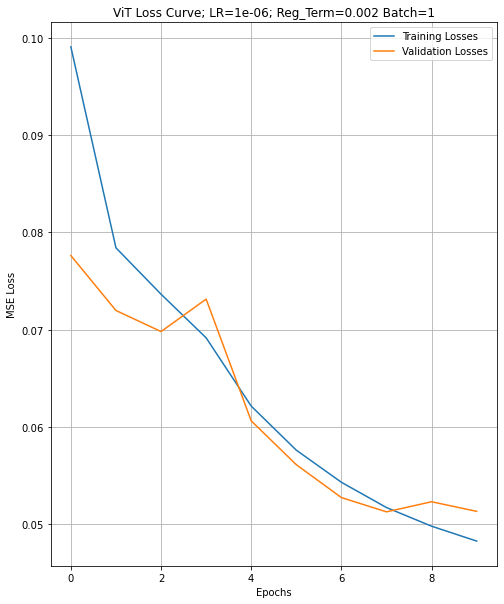

TRAIN LOSSES:  [0.09905915709132304, 0.0784003818975485, 0.07363348533988995, 0.069148054082305, 0.06212495814040503, 0.05759734464986524, 0.05429536904009871, 0.05169705784030704, 0.049781609800101656, 0.04824956861140967]
VALID_LOSSES: [0.07760853617163896, 0.0719578883603961, 0.0697927637106, 0.07312821678814051, 0.06061004721646053, 0.0561037625652976, 0.05272295393157287, 0.051255881203445305, 0.052293862858865794, 0.05130610760790127]


In [18]:
## SKIP FOR SIGOPT EXPERIMENT ##

def main():
    torch.cuda.empty_cache()
    # Resizing each image to 64 x 192.
    transform = transforms.Compose([
        # Citation:
        # https://pytorch.org/vision/stable/transforms.html#scriptable-transforms
        transforms.Resize((64, 192)),
    ])
    # Loading in images with resizing applied.
    training_set, validation_set, test_set = dataset.load_nvidia_dataset(batch_size=BATCH_SIZE, transform=transform)
    
    image_size = training_set.dataset[0][0].shape

    model = VanillaVisionTransformer.VisionTransformer(device,
                                                image_size,
                                               PATCH_SIZE, 
                                               HIDDEN_DIM,
                                               EMBED_DIM,
                                               NUM_CHANNELS,
                                               NUM_HEADS,
                                               NUM_LAYERS,
                                               DROPOUT).to(device)
    
    criterion = nn.MSELoss()
#     criterion = RMSELoss

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY_REGULARIZATION_TERM)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
    
    best = float('inf')
    best_model = None
    best_epoch = None
    train_losses = []
    valid_losses = []
    scaler = torch.cuda.amp.GradScaler()


    for epoch in range(NUM_EPOCHS):
        
        # Training.
        train_loss = train(epoch, training_set, model, optimizer, criterion, scaler=scaler)
        temp = train_loss
        temp.cpu()
        temp = float(temp)
        train_losses.append(temp)
        print(f"Average training loss this epoch: {temp:.4f}")
                
        # Validation.
        valid_loss = validate(epoch, validation_set, model, criterion)
        temp = valid_loss
        temp.cpu()
        temp = float(temp)
        valid_losses.append(temp)
        
        scheduler.step(train_loss)
        
        if valid_loss < best:
            best = valid_loss
            best_model = copy.deepcopy(model)
            best_epoch = epoch

            
    print('Best Loss @1: {:.4f}'.format(best))

    torch.save(best_model.state_dict(), './checkpoints/vanilla_vision_transformer3.pth')
    
    losses_to_plot = train_losses, valid_losses
    plots(losses_to_plot, 
          lr=LEARNING_RATE, 
          reg=WEIGHT_DECAY_REGULARIZATION_TERM,
          batch=BATCH_SIZE, 
         )
    
    print("TRAIN LOSSES: ", train_losses)
    print("VALID_LOSSES:", valid_losses)
if __name__ == '__main__':
    main()

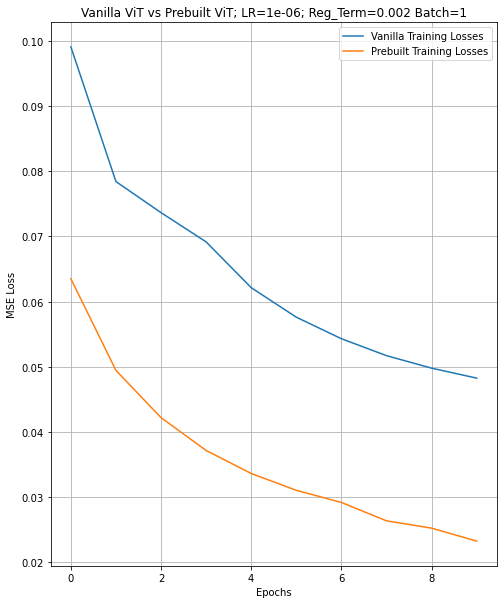

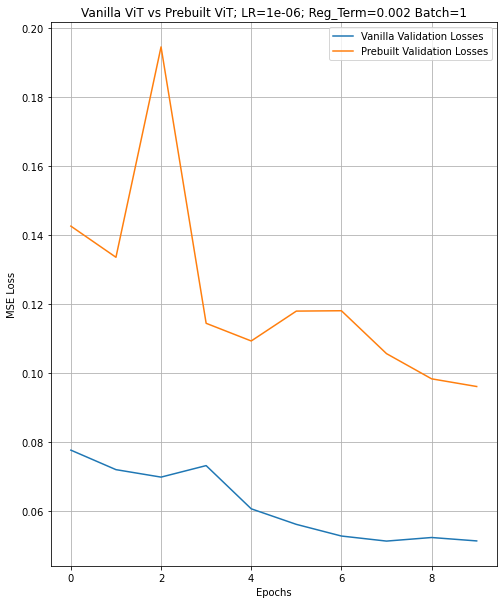

In [21]:
# code for generating plot for vanilla and prebuilt 
vanilla_training_loss = [0.09905915709132304, 
                    0.0784003818975485, 
                    0.07363348533988995, 
                    0.069148054082305, 
                    0.06212495814040503, 
                    0.05759734464986524, 
                    0.05429536904009871, 
                    0.05169705784030704, 
                    0.049781609800101656, 
                    0.04824956861140967]

vanilla_valid_loss = [0.07760853617163896, 
                      0.0719578883603961, 
                      0.0697927637106, 
                      0.07312821678814051, 
                      0.06061004721646053, 
                      0.0561037625652976, 
                      0.05272295393157287, 
                      0.051255881203445305, 
                      0.052293862858865794, 
                      0.05130610760790127]

prebuilt_training_loss = [0.06349733506052367, 
                          0.049434915306017825, 
                          0.04219180715521671, 
                          0.03714984642676089, 
                          0.03362147771533171, 
                          0.031040139911289885, 
                          0.029178072619634964, 
                          0.02635915828785801, 
                          0.025237561601976908, 
                          0.023251636363512906]

prebuilt_valid_loss = [0.14251683893504524, 
                       0.13349119205497767, 
                       0.1944447537621251, 
                       0.11436167454415362, 
                       0.10923971827740678, 
                       0.11789517432492107, 
                       0.11800127145055825, 
                       0.10557344819431186, 
                       0.09827261731688038, 
                       0.09604576804236971]

fig1, ax1 = plt.subplots(figsize=(8, 10))
ax1.plot(vanilla_training_loss, label='Vanilla Training Losses')
ax1.plot(prebuilt_training_loss, label='Prebuilt Training Losses')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE Loss')
ax1.set_title(f'Vanilla ViT vs Prebuilt ViT; LR={LEARNING_RATE}; Reg_Term={WEIGHT_DECAY_REGULARIZATION_TERM} Batch={BATCH_SIZE}')
ax1.legend(loc="best")
plt.grid()
plt.savefig('comp_train_1.png')
plt.show()

fig2, ax2 = plt.subplots(figsize=(8,10))
ax2.plot(vanilla_valid_loss, label='Vanilla Validation Losses')
ax2.plot(prebuilt_valid_loss, label='Prebuilt Validation Losses')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE Loss')
ax2.set_title(f'Vanilla ViT vs Prebuilt ViT; LR={LEARNING_RATE}; Reg_Term={WEIGHT_DECAY_REGULARIZATION_TERM} Batch={BATCH_SIZE}')
ax2.legend(loc="best")
plt.grid()
plt.savefig('comp_val_1.png')
plt.show()

## Driver Code

In [ ]:
def evaluate(assignments, args):
    
    # log source of hyperparameter suggestion
    sigopt.log_metadata('optimizer', "Adam")
    sigopt.log_model("Vanilla Vision Transformer")
    sigopt.log_dataset("Udacity self-driving dataset ")

    sigopt.params.setdefault("learning_rate", args['learning_rate'])
    sigopt.params.setdefault("reg", args['reg'])
    sigopt.params.setdefault("dropout", args['dropout'])
#     sigopt.params.setdefault("batch_size", int(args['batch_size']))
#     sigopt.params.setdefault("num_heads", int(args['num_heads']))
#     sigopt.params.setdefault("num_layers", int(args['num_layers']))
#     sigopt.params.setdefault("patch_size", int(args['patch_size']))
#     sigopt.params.setdefault("embed_dim", int(args['embed_dim']))
    
    
    # Resizing each image to 64 x 192.
    transform = transforms.Compose([
        # Citation:
        # https://pytorch.org/vision/stable/transforms.html#scriptable-transforms
        transforms.Resize((64, 192)),
    ])
    
    print("Params : ", sigopt.params)
    # Loading in images with resizing applied.
    training_set, validation_set, test_set = dataset.load_nvidia_dataset(batch_size=BATCH_SIZE, 
                                                                         transform=transform)

    image_size = training_set.dataset[0][0].shape

    model = VanillaVisionTransformer.VisionTransformer(device,
                                                image_size,
                                               PATCH_SIZE, 
                                               HIDDEN_DIM,
                                               EMBED_DIM,
                                               NUM_CHANNELS,
                                               NUM_HEADS,
                                               NUM_LAYERS,
                                               sigopt.params.dropout).to(device)
    
    criterion = nn.MSELoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=sigopt.params.learning_rate, 
                                 weight_decay =sigopt.params.reg)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
    
    best = float('inf')
    best_model = None
    best_epoch = None
    train_losses = []
    valid_losses = []
    scaler = torch.cuda.amp.GradScaler()


    for epoch in range(NUM_EPOCHS):
        
        # Training.
        train_loss = train(epoch, training_set, model, optimizer, criterion, scaler=scaler)
        temp = train_loss
        temp.cpu()
        temp = float(temp)
        train_losses.append(temp)
        print(f"Average training loss this epoch: {temp:.4f}")
                
        # Validation.
        valid_loss = validate(epoch, validation_set, model, criterion)
        temp = valid_loss
        temp.cpu()
        temp = float(temp)
        valid_losses.append(temp)
        
#         scheduler.step(train_loss)
        
        if valid_loss < best:
            best = valid_loss
            best_model = copy.deepcopy(model)
            best_epoch = epoch
            
    print('Best Loss @1: {:.4f}'.format(best))
    
    losses_to_plot = train_losses, valid_losses
    plots(losses_to_plot, 
          lr=LEARNING_RATE, 
          reg=WEIGHT_DECAY_REGULARIZATION_TERM,
          batch=BATCH_SIZE, 
          # momentum=MOMENTUM  # not necessary for ADAM
         )

    torch.save(best_model.state_dict(), './checkpoints/vanilla_vision_transformer.pth')  
    sigopt.log_metric(name='MSE', value=best)
    return best.cpu().numpy()

In [ ]:
# sigopt setup
import sigopt
import os
os.environ["SIGOPT_API_TOKEN"] = "XWBIVDWCVQXALUZQFDHNGOELLLKDJBMOJALEPCNQXQGBNIGC"
os.environ['SIGOPT_PROJECT'] = 'vanilla_vit'

args = {
    'learning_rate': 0.005,
    'reg': 0.0005,
    'dropout' : 0.2
#     'num_heads': 2,
#     'num_layers': 6,
}

In [ ]:
sigopt.set_project('vanilla_vit')
conn = sigopt.Connection(client_token=os.environ.get("SIGOPT_API_TOKEN"))
experiment = conn.experiments().create(
    
    name="Vanilla ViT Optimization 5",
 
    parameters=[
        dict(name="reg", bounds=dict(min=0.00001, max=1.0), type="double", transformation="log"),
        dict(name="learning_rate", bounds=dict(min=0.00001 ,max=1.0), type="double", transformation="log"),
        dict(name="dropout", bounds=dict(min=0.1 ,max=0.9), type="double", transformation="log"),
#         dict(name="batch_size", categorical_values=["1","8","16", "32", "64"], type="categorical"),
#         dict(name="num_heads", bounds=dict(min=2, max=12), type="int"),
#         dict(name="num_layers", bounds=dict(min=2, max=12), type="int"),
#         dict(name="patch_size", categorical_values=["4","8","16"], type="categorical"),
#         dict(name="embed_dim", categorical_values=["256","512","768", "1024"], type="categorical")
        ],
 
    metrics=[
        dict(name="MSE", objective="minimize", strategy="optimize")
        ],
 
    observation_budget = 30,
)
 
print("Explore your experiment: https://app.sigopt.com/experiment/" + experiment.id + "/analysis")

In [ ]:
#Optimization Loop
for _ in range(experiment.observation_budget):
    suggestion = conn.experiments(experiment.id).suggestions().create()
    assignments = suggestion.assignments
    value = evaluate(assignments, args)
 
    conn.experiments(experiment.id).observations().create(
        suggestion=suggestion.id,
        value=value
    )
    
    #update experiment object
    experiment = conn.experiments(experiment.id).fetch()
 
assignments = conn.experiments(experiment.id).best_assignments().fetch().data[0].assignments  
 
print("BEST ASSIGNMENTS FOUND: \n", assignments)

In [ ]:
# %%experiment 
# {
#     'name': 'Vanilla ViT model Optimization test',
#     'metrics': [
#         {
#             'name': 'MSE',
#             'strategy': 'optimize',
#             'objective': 'minimize',
#         }
#     ],
#     'parameters': [
#         {
#             'name': 'reg',
#             'type': 'double',
#             'bounds': {'min': 0.0001, 'max': 0.5},
#             'transformation': 'log'
#         },
#         {
#             'name': 'learning_rate',
#             'type': 'double',
#             'bounds': {'min': 0.0001, 'max': 0.9},
#             'transformation': 'log'
#         },
#         {
#             'name': 'batch_size',
#             'type': 'categorical',
#             'categorical_values': ['32', '64']
#         }
#     ],
#     'budget': 30
# }

In [ ]:
# %%optimize vanilla_vit_optimization_run_test
# evaluate(args)